# Patient Access to and Use of Electronic Medical Records -- Data Exploration

This project explores use of patient electronic medical records in the US.  
This file contains the data selection, cleaning, and exploratory data analysis (EDA) steps. 


## Table of Contents
<ul>
  <li><a href="#busund">Business Understanding</a></li>
  <li><a href="#dataund">Data Understanding</a></li>
  <li><a href="#exprep">Examining and Preparing the Data</a></li>
  <ul>
      <li><a href="#missform">Missing data and field formats</a></li>
      <li><a href="#webexp">Web format experiment</a></li>
      <li><a href="#reccycle">Reconciling similar fields across cycles</a></li>
      <li><a href="#survcycle">Creating a field to identify survey cycle/year</a></li>
      <li><a href="#merge">Merging the datasets</a></li>
      <li><a href="#cleancomb">Cleaning the combined dataset</a></li>
      <li><a href="#accmiss">Accuracy & missing entries</a></li>
      <li><a href="#prepsummary">Summary</a></li>
  </ul>   
  <li><a href="#prelimanalysis">Preliminary Analysis</a></li>
  <ul>
      <li><a href="#traintest">Train-Test Split</a></li>
      <li><a href="#univar">Univariate</a></li>
      <li><a href="#multivar">Multivariate</a></li>
      <ul>
          <li><a href="#mvoutcome">Outcome variables</a></li>
          <ul>
              <li><a href="#mvoae">`offeredaccesseither` variable</a></li>
              <li><a href="#mvaor">`accessonlinerecord` variable</a></li>
              <li><a href='#mvocsummary'>Summary</a></li>
          </ul>
          <li><a href="#mvpreds">Predictor variables</a></li>
          <ul>
              <li><a href="#mvcontord">Continuous/ordinal</a></li>
              <li><a href="#mvcat">Categorical</a></li>
              <li><a href="#mvquartil">Quartilizing the continuous/ordinal variables</a></li>
              <li><a href="#mvpredsummary">Summary</a></li>
          </ul>
      </ul>
  </ul>
<li><a href="#nextsteps">Next Steps</a></li>    
</ul>

<a id='busund'></a>
## Business Understanding

The aims of this study are to attempt to understand patient demographic and health-related factors associated with the availability and use of electronic medical records (EMRs) in the US. 

Understanding which factors drive availability will help healthcare providers (HCPs) and practice managers determine which patients might need increased education about or assistance with accessing an EMR. It will also elucidate whether EMRs are being offered appropriately to those who most need them (e.g. those with multiple chronic medical conditions or unhealthy lifestyles) or to those who may not but are more likely to use them (e.g. younger, healthier, better-educated patients who may not need to monitor their health as closely). 

Understanding the factors associated with actual use of EMRs will also indicate whether patients who most need access to or easy transportability of their medical records (again, patients with multiple chronic conditions or poorer health, who may need to see multiple HCPs or may have more frequent hospital or physician visits) are actually using them. 

For both of these outcomes, whether availability and adoption are changing over time and whether there was a discernible change after the onset of the COVID-19 pandemic will be assessed as part of the models.

<a id='dataund'></a>
## Data Understanding

For this analysis, we require data on EMR availability and use, as well as on patient characteristics, such as demographics, health status, and medical history, that may influence the availability to patients of EMRs and their use.

Most publicly-available datasets in this domain are curated by the US government. The source I found with the most information on EMRs was the [Health Information National Trends Survey (HINTS)](https://hints.cancer.gov). This is an annual survey conducted by the [National Cancer Institute](https://www.cancer.gov) with the aim of:
> (collecting) nationally representative data about the American public’s knowledge of, attitudes toward, and use of cancer- and health-related information. HINTS data are used to monitor changes in the rapidly evolving fields of health communication and health information technology and to create more effective health communication strategies across different populations.

Much of the data are cancer-specific; however, there are several demographic variables (e.g., age, race, gender, geographic area, income) and multiple other health-related fields included. There are also fields specific to availability and use of EMRs. The survey is designed to be nationally representative.

Data are available for multiple years up to 2020. The survey is typically conducted between January and April, which means the 2020 cycle partially overlaps with the declaration of the COVID-19 pandemic. Fortunately, the data have a field that accounts for this.  

To assess whether adoption of EMRs is evolving over time and whether there was a discernible change in the (admittedly limited) post-pandemic time period, the two prior years' data were retrieved, in addition to the 2020 file.

<a id='exprep'></a>
## Examining and Preparing the Data 

In [204]:
# import all the necessary libraries
from csv import reader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
import re

The HINTS datasets include a codebook which describes each survey question and lists the possible responses and their frequencies. Using these resources, the available variables were pre-screened for relevance and amount of data available. Variables whose association with access to and use of an EMR could not be distinguished as cause- versus effect-related were also dropped. 
After screening as above, the remaining variables were reconciled and the ones common to all three cycles (or which could be reconfigured to match across cycles) were kept.
The preliminary list of selected variables is in the file [HINTS-variables.ods](file://data/HINTS-variables.ods).

In [205]:
# get list of pre-screened columns to keep from each HINTS5 cycle
# see 'HINTS-variables.ods' for preliminary list for each cycle and a description
# see the Codebook for each cycle for a complete list of variables
# cycle 2
with open('data/C2_vars.csv') as csv_file:
    csv_rd = reader(csv_file)
    C2_var_list = list(csv_rd)[0]
# cycle 3
with open('data/C3_vars.csv') as csv_file:
    csv_rd = reader(csv_file)
    C3_var_list = list(csv_rd)[0]
# cycle 4
with open('data/C4_vars.csv') as csv_file:
    csv_rd = reader(csv_file)
    C4_var_list = list(csv_rd)[0]

The HINTS data files are available in SAS, SPSS, and STATA formats. The SAS import doesn't allow you to limit the columns, and the SPSS file for Cycle 2 seemed to be corrupted and wouldn't load. For those reasons, I chose STATA format.

In [206]:
# read in the data in STATA format
# for STATA format, all column names are lowercase (HINTS variable names in the Codebook have variable case)
C2_var_list = [x.lower() for x in C2_var_list]
# cycle 2
df_c2 = pd.read_stata('data/hints5_cycle2_public.dta', columns = C2_var_list, convert_categoricals = False)
display(df_c2.head())
display(df_c2.info())

stratum  highspanli  nchsurcode2013  censdiv  useinternet  internet_dialup  \
0      LM         2.0             1.0      5.0          1.0              2.0   
1      LM         2.0             2.0      3.0          2.0             -1.0   
2      LM         2.0             3.0      5.0          2.0             -1.0   
3      LM         2.0             2.0      1.0          1.0              2.0   
4      LM         2.0             5.0      2.0          1.0              2.0   

   internet_broadbnd  internet_cell  internet_wifi  whereuseinternet_home  \
0                2.0            2.0            1.0                    2.0   
1               -1.0           -1.0           -1.0                   -1.0   
2               -1.0           -1.0           -1.0                   -1.0   
3                2.0            2.0            1.0                    1.0   
4                1.0            2.0            2.0                    1.0   

   ...  agegrpb  educa  raceethn5  hhinc   bmi  smokestat  phq4  \
0  ...      4.0    3.0        1.0    2.0  29.9        2.0   0.0   
1  ...      2.0    2.0       -9.0    1.0  23.4        3.0  12.0   
2  ...      5.0    1.0        1.0    1.0  25.6        2.0   1.0   
3  ...      4.0    3.0        1.0    5.0  22.5        3.0   0.0   
4  ...      4.0    3.0        1.0    1.0  28.1        2.0   0.0   

   weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  
0                           30.0      3.0               0.0  
1                            0.0      3.0              -9.0  
2                            0.0      3.0               0.0  
3                          105.0      3.0               2.0  
4                          180.0      3.0               0.0  

[5 rows x 61 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3503
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stratum                        3504 non-null   object 
 1   highspanli                     3504 non-null   float64
 2   nchsurcode2013                 3504 non-null   float64
 3   censdiv                        3504 non-null   float64
 4   useinternet                    3504 non-null   float64
 5   internet_dialup                3504 non-null   float64
 6   internet_broadbnd              3504 non-null   float64
 7   internet_cell                  3504 non-null   float64
 8   internet_wifi                  3504 non-null   float64
 9   whereuseinternet_home          3504 non-null   float64
 10  whereuseinternet_work          3504 non-null   float64
 11  whereuseinternet_publicplace   3504 non-null   float64
 12  whereuseinternet_mobiledevice  3504 non-null   f

None

In [207]:
# cycle 3
# make variables lowercase
C3_var_list = [x.lower() for x in C3_var_list]
df_c3 = pd.read_stata('data/hints5_cycle3_public.dta', columns = C3_var_list, convert_categoricals = False)
display(df_c3.head())
display(df_c3.info())

stratum  highspanli  nchsurcode2013  censdiv  formtype  useinternet  \
0      HM         2.0             6.0      6.0       2.0          2.0   
1      HM         2.0             6.0      6.0       2.0          1.0   
2      HM         2.0             6.0      6.0       2.0          1.0   
3      HM         2.0             4.0      6.0       2.0          1.0   
4      HM         2.0             5.0      6.0       2.0          1.0   

   internet_dialup  internet_broadbnd  internet_cell  internet_wifi  ...  \
0             -1.0               -1.0           -1.0           -1.0  ...   
1              1.0                2.0            2.0            2.0  ...   
2              2.0                2.0            1.0            2.0  ...   
3              2.0                1.0            2.0            2.0  ...   
4             -9.0               -9.0           -9.0           -9.0  ...   

   agegrpb  educa  raceethn5  hhinc   bmi  smokestat  phq4  \
0      4.0    1.0        1.0    1.0  26.3        3.0   5.0   
1      2.0    3.0        2.0    4.0  28.3        3.0   0.0   
2     -9.0   -9.0       -9.0   -9.0  37.1        2.0   6.0   
3      4.0    4.0        1.0    2.0  21.6        3.0   0.0   
4      2.0    3.0        1.0    3.0  28.8        2.0   1.0   

   weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  
0                            0.0      3.0               0.0  
1                           30.0      3.0              -9.0  
2                            0.0      3.0               0.0  
3                           90.0      3.0               0.0  
4                          100.0      1.0               8.0  

[5 rows x 60 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5438 entries, 0 to 5437
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stratum                        5438 non-null   object 
 1   highspanli                     5438 non-null   float64
 2   nchsurcode2013                 5438 non-null   float64
 3   censdiv                        5438 non-null   float64
 4   formtype                       5438 non-null   float64
 5   useinternet                    5438 non-null   float64
 6   internet_dialup                5438 non-null   float64
 7   internet_broadbnd              5438 non-null   float64
 8   internet_cell                  5438 non-null   float64
 9   internet_wifi                  5438 non-null   float64
 10  whereuseinternet_home          5438 non-null   float64
 11  whereuseinternet_work          5438 non-null   float64
 12  whereuseinternet_publicplace   5438 non-null   f

None

In [208]:
# cycle 4
C4_var_list = [x.lower() for x in C4_var_list]
df_c4 = pd.read_stata('data/hints5_cycle4_public.dta', columns = C4_var_list, convert_categoricals = False)
display(df_c4.head())
display(df_c4.info())

stratum  highspanli  nchsurcode2013  censdiv  pandemic  useinternet  \
0      LM         2.0             3.0      2.0       1.0          1.0   
1      LM         2.0             2.0      5.0       1.0          1.0   
2      LM         2.0             2.0      1.0       1.0          1.0   
3      LM         2.0             1.0      2.0       1.0          1.0   
4      LM         2.0             2.0      1.0      -1.0          1.0   

   internet_dialup  internet_broadbnd  internet_cell  internet_wifi  ...  \
0              2.0                1.0            2.0            1.0  ...   
1              2.0                2.0            2.0            1.0  ...   
2              2.0                1.0            1.0            1.0  ...   
3              2.0                2.0            2.0            1.0  ...   
4              2.0                1.0            1.0            1.0  ...   

   agegrpb  educa  raceethn5  hhinc   bmi  smokestat  phq4  \
0     -9.0   -9.0        1.0    1.0  -9.0        1.0   4.0   
1      4.0    4.0        1.0    3.0  27.3        1.0   4.0   
2      3.0    4.0        1.0    5.0  22.3        3.0   5.0   
3      1.0    4.0        1.0    5.0  24.8        3.0   0.0   
4      4.0    4.0        1.0    3.0  28.7        2.0   0.0   

   weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  
0                            0.0      2.0               0.0  
1                            0.0      3.0               1.0  
2                          240.0      3.0              14.0  
3                          300.0      3.0               9.0  
4                          270.0      3.0               1.0  

[5 rows x 60 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 3864
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stratum                        3865 non-null   object 
 1   highspanli                     3865 non-null   float64
 2   nchsurcode2013                 3865 non-null   float64
 3   censdiv                        3865 non-null   float64
 4   pandemic                       3865 non-null   float64
 5   useinternet                    3865 non-null   float64
 6   internet_dialup                3865 non-null   float64
 7   internet_broadbnd              3865 non-null   float64
 8   internet_cell                  3865 non-null   float64
 9   internet_wifi                  3865 non-null   float64
 10  whereuseinternet_home          3865 non-null   float64
 11  whereuseinternet_work          3865 non-null   float64
 12  whereuseinternet_publicplace   3865 non-null   f

None

<a id='missform'></a>
### Missing data and field formats
We can see that none of the fields have "missing" data in the form of nulls. This is because missing and erroneous entries have their own codes, denoted by different negative values. We will deal with these later as will be variable-dependent.  The missing data codes are the same across all three cycles as well, so it will be easier to merge the datasets first, then address how to handle the missing-data codes.  
The formats of the fields are appropriate when compared to their type in the codebooks, although most of the `float` fields could be integers because the decimal isn't needed.

<a id='webexp'></a>
### Web format experiment
During Cycle 3, an experiment was performed wherein a subset of participants were offered the opportunity to complete the survey on the web, instead of on paper. 
As discussed in the `Web Pilot Results Report` (included with background material), those who chose to complete the survey on the web were significantly younger, healthier, more often male and single, and with higher education levels. Because this represents a different population than those that complete the survey on paper, which was the only method available for Cycles 2 and 4, we will exclude respondents for Cycle 3 who responded via web.

In [209]:
# exclude Cycle 3 participants who responded via web due to difference with paper-response population
# first see how many there are (2 = paper, 5=web)
display(df_c3['formtype'].value_counts())

2.0    4573
5.0     865
Name: formtype, dtype: int64

In [210]:
# drop the entries submitted via web
# backup first
df_c3bu = df_c3.copy()
# now modify the base df
df_c3 = df_c3[~(df_c3['formtype'] == 5.0)]
display(df_c3.shape)

(4573, 60)

We can now drop the `formtype` column.

In [211]:
df_c3.drop(columns = ['formtype'], inplace = True)

<a id='reccycle'></a>
### Reconciling similar fields across cycles

In Cycle 2 the field `everofferedaccessrec` asks whether the respondent has been offered EMR access by a HCP or an insurer. This is followed by 3 fields denoting which entity made the offer (HCP, insurer, or other).  
In Cycles 3 and 4, there are 2 fields, `offeredaccesshcp2` and `offeredaccessinsurer2` which denote whether the respondent was offered EMR access by a HCP or insurer, respectively. 
To make the fields consistent across cycles, we'll create `offeredaccesshcp2` and `offeredaccessinsurer2` from the similar fields for Cycle 2.

In [212]:
# create the offered by HCP and by insurer columns in Cycle 2
# popular them using the 'everofferedaccess' and 'whoofferedxxx' columns, then drop the old columns
# to make consistent with Cycles 3 & 4
# backup first
df_c2bu = df_c2.copy()

In [213]:
# check the missing counts in each field
df_c2['whooffered_hcp'].value_counts()

 1.0    1742
-1.0    1618
 2.0      73
-9.0      48
-2.0      23
Name: whooffered_hcp, dtype: int64

In [214]:
df_c2['everofferedaccessrec'].value_counts()

 1.0    1863
 2.0    1326
 3.0     295
-9.0      20
Name: everofferedaccessrec, dtype: int64

In [215]:
df_c2[(df_c2['everofferedaccessrec'] == 2)|(df_c2['everofferedaccessrec'] == 3)]['whooffered_hcp'].value_counts()

-1.0    1598
-2.0      23
Name: whooffered_hcp, dtype: int64

In [216]:
# first rename the 'whooffered' columns
df_c2.rename(columns = {'whooffered_hcp':'offeredaccesshcp2', 'whooffered_insurer':'offeredaccessinsurer2'},\
             inplace = True)

In [217]:
# now we need to change the -1 and -2 entries (NA and erroneously filled) to the reason they should be empty, 
# from the 'everofferedaccess' column ('no', 'don't know', or 'missing')
df_c2.loc[(((df_c2['offeredaccesshcp2'] == -1.0) | (df_c2['offeredaccesshcp2'] == -2.0)) \
          & (df_c2['everofferedaccessrec'] == 2)), 'offeredaccesshcp2'] = 2.0
df_c2.loc[(((df_c2['offeredaccesshcp2'] == -1.0) | (df_c2['offeredaccesshcp2'] == -2.0)) \
          & (df_c2['everofferedaccessrec'] == 3.0)), 'offeredaccesshcp2'] = 3.0
# the missing entries from everofferedaccessrec end up as -1 in the subfields as well
df_c2.loc[((df_c2['offeredaccesshcp2'] == -1.0) & (df_c2['everofferedaccessrec'] == -9.0)), 'offeredaccesshcp2'] = -9.0

# check the entries
display(df_c2['offeredaccesshcp2'].value_counts())

 1.0    1742
 2.0    1399
 3.0     295
-9.0      68
Name: offeredaccesshcp2, dtype: int64

In [218]:
# now do the same for the insurer column
# change the -1 and -2 entries (NA and erroneously filled) to the reason they should be empty, 
# from the 'everofferedaccess' column ('no', 'don't know', or 'missing')
df_c2.loc[(((df_c2['offeredaccessinsurer2'] == -1.0) | (df_c2['offeredaccessinsurer2'] == -2.0)) \
          & (df_c2['everofferedaccessrec'] == 2)), 'offeredaccessinsurer2'] = 2.0
df_c2.loc[(((df_c2['offeredaccessinsurer2'] == -1.0) | (df_c2['offeredaccessinsurer2'] == -2.0)) \
          & (df_c2['everofferedaccessrec'] == 3.0)), 'offeredaccessinsurer2'] = 3.0
# the missing entries from everofferedaccessrec end up as -1 in the subfields as well
df_c2.loc[((df_c2['offeredaccessinsurer2'] == -1.0) & (df_c2['everofferedaccessrec'] == -9.0)), 'offeredaccessinsurer2'] = -9.0

# check the entries
display(df_c2['offeredaccessinsurer2'].value_counts())

 2.0    2766
 1.0     375
 3.0     295
-9.0      68
Name: offeredaccessinsurer2, dtype: int64

In [219]:
# drop the extra columns
df_c2.drop(columns = ['everofferedaccessrec', 'whooffered_other'], inplace = True)
display(df_c2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3503
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stratum                        3504 non-null   object 
 1   highspanli                     3504 non-null   float64
 2   nchsurcode2013                 3504 non-null   float64
 3   censdiv                        3504 non-null   float64
 4   useinternet                    3504 non-null   float64
 5   internet_dialup                3504 non-null   float64
 6   internet_broadbnd              3504 non-null   float64
 7   internet_cell                  3504 non-null   float64
 8   internet_wifi                  3504 non-null   float64
 9   whereuseinternet_home          3504 non-null   float64
 10  whereuseinternet_work          3504 non-null   float64
 11  whereuseinternet_publicplace   3504 non-null   float64
 12  whereuseinternet_mobiledevice  3504 non-null   f

None

<a id='survcycle'></a>
### Creating a field to identify survey cycle/year
Finally, in addition to assessing whether there are pre- and post-pandemic differences in adoption, we want to look at whether attitudes change over time. The survey is conducted annually, so we'll create a field for each cycle, with and additional entry for Cycle 4 post-pandemic.

In [220]:
# add a survey_cycle field to denote which year the survey was conducted
# 2 = cycle 2 (2018), 3 = cycle 3 (2019), 4 = cycle 4 pre-pandemic (pre-3/11/2020), 5 = cycle 4 post-pandemic (>=3/11/20)
df_c2['survey_cycle'] = 2.0
df_c3['survey_cycle'] = 3.0
df_c4['survey_cycle'] = 4.0
df_c4.loc[df_c4['pandemic'] == 1.0,'survey_cycle'] = 5.0
print('cycle 2 survey values: ', df_c2['survey_cycle'].value_counts())
print('cycle 3 survey values: ',df_c3['survey_cycle'].value_counts())
print('cycle 4 pandemic values: ',df_c4['pandemic'].value_counts())
print('cycle 4 survey values: ',df_c4['survey_cycle'].value_counts())

cycle 2 survey values:  2.0    3504
Name: survey_cycle, dtype: int64
cycle 3 survey values:  3.0    4573
Name: survey_cycle, dtype: int64
cycle 4 pandemic values:   1.0    2428
-1.0    1437
Name: pandemic, dtype: int64
cycle 4 survey values:  5.0    2428
4.0    1437
Name: survey_cycle, dtype: int64


We can now drop the `pandemic` field from the cycle 4 data.

In [221]:
df_c4.drop(columns = ['pandemic'], inplace = True)

<a id='merge'></a>
### Merging the datasets
We should now have three datasets, one for each cycle, with identical columns. These will be merged, then we'll check the fields for cleanliness and decide how to address the missing-data codes.

In [222]:
# double check that all 3 datasets have the same number of columns
display(df_c2.shape)
display(df_c3.shape)
display(df_c4.shape)

(3504, 60)

(4573, 60)

(3865, 60)

Columns match. Now we can merge the three datasets.

In [223]:
# merge the 3 df's
df_merge = pd.concat([df_c2, df_c3, df_c4] , join = 'inner', ignore_index = True)

In [224]:
display(df_merge.shape)
display(df_merge.head())
display(df_merge.info())

(11942, 60)

stratum  highspanli  nchsurcode2013  censdiv  useinternet  internet_dialup  \
0      LM         2.0             1.0      5.0          1.0              2.0   
1      LM         2.0             2.0      3.0          2.0             -1.0   
2      LM         2.0             3.0      5.0          2.0             -1.0   
3      LM         2.0             2.0      1.0          1.0              2.0   
4      LM         2.0             5.0      2.0          1.0              2.0   

   internet_broadbnd  internet_cell  internet_wifi  whereuseinternet_home  \
0                2.0            2.0            1.0                    2.0   
1               -1.0           -1.0           -1.0                   -1.0   
2               -1.0           -1.0           -1.0                   -1.0   
3                2.0            2.0            1.0                    1.0   
4                1.0            2.0            2.0                    1.0   

   ...  educa  raceethn5  hhinc   bmi  smokestat  phq4  \
0  ...    3.0        1.0    2.0  29.9        2.0   0.0   
1  ...    2.0       -9.0    1.0  23.4        3.0  12.0   
2  ...    1.0        1.0    1.0  25.6        2.0   1.0   
3  ...    3.0        1.0    5.0  22.5        3.0   0.0   
4  ...    3.0        1.0    1.0  28.1        2.0   0.0   

   weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  survey_cycle  
0                           30.0      3.0               0.0           2.0  
1                            0.0      3.0              -9.0           2.0  
2                            0.0      3.0               0.0           2.0  
3                          105.0      3.0               2.0           2.0  
4                          180.0      3.0               0.0           2.0  

[5 rows x 60 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11942 entries, 0 to 11941
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stratum                        11942 non-null  object 
 1   highspanli                     11942 non-null  float64
 2   nchsurcode2013                 11942 non-null  float64
 3   censdiv                        11942 non-null  float64
 4   useinternet                    11942 non-null  float64
 5   internet_dialup                11942 non-null  float64
 6   internet_broadbnd              11942 non-null  float64
 7   internet_cell                  11942 non-null  float64
 8   internet_wifi                  11942 non-null  float64
 9   whereuseinternet_home          11942 non-null  float64
 10  whereuseinternet_work          11942 non-null  float64
 11  whereuseinternet_publicplace   11942 non-null  float64
 12  whereuseinternet_mobiledevice  11942 non-null 

None

<a id='cleancomb'></a>
### Cleaning the combined dataset

#### Field formats

Almost all of the fields are integer-coded categories, so integers would be more appropriate than floats. First, check the ones that may need to stay as floats.

In [225]:
# look at whether these variables have decimal data
# BMI should be a float
display(df_merge['bmi'].describe())
# this is an average, so probably has decimal data
display(df_merge['avgdrinksperweek'].describe())
display(df_merge['avgdrinksperweek'].value_counts())

count    11942.000000
mean        27.263172
std          9.305099
min         -9.000000
25%         23.600000
50%         27.100000
75%         31.600000
max         78.300000
Name: bmi, dtype: float64

count    11942.000000
mean         1.907553
std          7.919006
min         -9.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        125.000000
Name: avgdrinksperweek, dtype: float64

 0.0      5651
-9.0      1422
 1.0       916
 2.0       798
 4.0       537
 6.0       443
 3.0       346
 14.0      229
 12.0      212
 8.0       207
 10.0      206
 5.0       147
 7.0       123
 21.0      119
 9.0       110
 15.0       75
 28.0       55
 18.0       50
 24.0       50
 16.0       37
 35.0       34
 20.0       32
 30.0       25
 42.0       22
-4.0        19
 36.0       13
 25.0       12
 56.0       10
 70.0        9
 40.0        7
 49.0        4
 48.0        3
 32.0        3
 63.0        3
 120.0       2
 60.0        2
 90.0        1
 98.0        1
 125.0       1
 50.0        1
 55.0        1
 54.0        1
 27.0        1
 80.0        1
 84.0        1
Name: avgdrinksperweek, dtype: int64

Only `BMI` is a floating-point number. Convert all the other quantitative fields to integers.

In [226]:
# make a list of columns to convert to integer
int_cols = list(df_merge.columns)
int_cols.remove('stratum')
int_cols.remove('bmi')
int_cols

['highspanli',
 'nchsurcode2013',
 'censdiv',
 'useinternet',
 'internet_dialup',
 'internet_broadbnd',
 'internet_cell',
 'internet_wifi',
 'whereuseinternet_home',
 'whereuseinternet_work',
 'whereuseinternet_publicplace',
 'whereuseinternet_mobiledevice',
 'electronic_selfhealthinfo',
 'havedevice_cat',
 'tablethealthwellnessapps',
 'tablet_achievegoal',
 'tablet_makedecision',
 'tablet_discussionshcp',
 'intrsn_visitedsocnet',
 'intrsn_sharedsocnet',
 'intrsn_supportgroup',
 'intrsn_youtube',
 'regularprovider',
 'freqgoprovider',
 'qualitycare',
 'healthins_insuranceemp',
 'healthins_insurancepriv',
 'healthins_medicare',
 'healthins_medicaid',
 'healthins_tricare',
 'healthins_va',
 'healthins_ihs',
 'healthins_other',
 'healthinsurance',
 'providermaintainemr2',
 'offeredaccesshcp2',
 'offeredaccessinsurer2',
 'accessonlinerecord',
 'generalhealth',
 'ownabilitytakecarehealth',
 'medconditions_diabetes',
 'medconditions_highbp',
 'medconditions_heartcondition',
 'medconditions_l

Also, while doing these conversions, the `stratum` field is text, but should be a categorical variable.

In [227]:
# make a dict for pandas astype
# note here we're also converting the text field "stratum" to a categorical variable
col_dict = {}
for col in int_cols:
    col_dict[col] = 'int64'
col_dict['bmi'] = 'float64'
col_dict['stratum'] = 'category'

In [228]:
# convert to ints
df_merge2 = df_merge.astype(col_dict)
display(df_merge2.head())
display(df_merge2.info())

stratum  highspanli  nchsurcode2013  censdiv  useinternet  internet_dialup  \
0      LM           2               1        5            1                2   
1      LM           2               2        3            2               -1   
2      LM           2               3        5            2               -1   
3      LM           2               2        1            1                2   
4      LM           2               5        2            1                2   

   internet_broadbnd  internet_cell  internet_wifi  whereuseinternet_home  \
0                  2              2              1                      2   
1                 -1             -1             -1                     -1   
2                 -1             -1             -1                     -1   
3                  2              2              1                      1   
4                  1              2              2                      1   

   ...  educa  raceethn5  hhinc   bmi  smokestat  phq4  \
0  ...      3          1      2  29.9          2     0   
1  ...      2         -9      1  23.4          3    12   
2  ...      1          1      1  25.6          2     1   
3  ...      3          1      5  22.5          3     0   
4  ...      3          1      1  28.1          2     0   

   weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  survey_cycle  
0                             30        3                 0             2  
1                              0        3                -9             2  
2                              0        3                 0             2  
3                            105        3                 2             2  
4                            180        3                 0             2  

[5 rows x 60 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11942 entries, 0 to 11941
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   stratum                        11942 non-null  category
 1   highspanli                     11942 non-null  int64   
 2   nchsurcode2013                 11942 non-null  int64   
 3   censdiv                        11942 non-null  int64   
 4   useinternet                    11942 non-null  int64   
 5   internet_dialup                11942 non-null  int64   
 6   internet_broadbnd              11942 non-null  int64   
 7   internet_cell                  11942 non-null  int64   
 8   internet_wifi                  11942 non-null  int64   
 9   whereuseinternet_home          11942 non-null  int64   
 10  whereuseinternet_work          11942 non-null  int64   
 11  whereuseinternet_publicplace   11942 non-null  int64   
 12  whereuseinternet_mobiledevice  1

None

<a id='accmiss'></a>
#### Accuracy & missing entries
Check the columns to make sure they contain the appropriate ranges of data as specified in the codebook. Also get the percentage of missing data.

##### Missing data codes
The codes for missing data are:
- -1: "Valid" missing. The field should not be filled in because a preceding field has been marked with an entry that makes this field not applicable for this respondent.
- -2: Inappropriately filled in. The field should be empty based on a previous response, but the respondent gave an answer.
- -4: Illegible or non-conforming. The response couldn't be read, or was extremely out of the expected range for the questions (e.g. 11 feet for height, age > 105 years).
- -5: More responses selected than appropriate for the question.
- -6: Missing values in follow-ups to a missing "filter" question. The superseding question that should trigger the respondent to answer this question was not answered, nor was this question.
- -9: Missing/not ascertained. Question should've been answered but wasn't.  

Of these, -1 and -2 are "valid missing" entries since the respondent shouldn't have answered the question. The other codes indicate questions that should've been answered but either weren't or were answered incorrectly. These are the codes we'll look for. 

In [229]:
# this is the only text field; valid are "HM" & "LM"
df_merge2['stratum'].value_counts()

HM    7314
LM    4628
Name: stratum, dtype: int64

No missing data there

In [230]:
# we want to exclude codes -1 and -2 since those are "valid" missing
miss_codes = [-4, -5, -6, -9]
nrows = df_merge2.shape[0]

In [231]:
def check_cont_vars(column, miss_codes=miss_codes, nrows=nrows, df=df_merge2):
    '''
    Get the data distribution, missing value codes & counts, and percent missing data 
    for a continuous variable.
    INPUTS:
    column (str): column name
    miss_codes (list): missing codes to count
    nrows (int): number of rows
    
    OUTPUTS:
    pct_missing (float): % entries with miss_codes
    '''
    # get the stats; exclude negative values as should be missing codes
    print('Variable: {}'.format(column))
    print('Summary stats (excluding negative values):')
    print(df[column][df[column] >=0.0].describe())

    # display the negative values to make sure they align with what should be present
    print('\nNegatives:')    
    print(df[column][df[column] < 0].value_counts())

    # get the count and % missing 
    num_missing = df[column].isin(miss_codes).sum()
    pct_missing = 100*num_missing/nrows
    print('\n# missing: {}'.format(num_missing))
    print('% missing: {}\n'.format(pct_missing))
          
    return pct_missing   

In [232]:
# save the % missing values in each field to a dict in case we want to use them later, e.g for deleting 
# variables with excessive missing data
pct_miss_dict = {}

cont_vars = ['bmi', 'weeklyminutesmoderateexercise', 'avgdrinksperweek']

for var in cont_vars:
    pct_miss_dict[var] = check_cont_vars(var)

Variable: bmi
Summary stats (excluding negative values):
count    11544.000000
mean        28.499116
std          6.608052
min          9.400000
25%         24.000000
50%         27.400000
75%         31.800000
max         78.300000
Name: bmi, dtype: float64

Negatives:
-9.0    365
-4.0     33
Name: bmi, dtype: int64

# missing: 398
% missing: 3.332775079551164

Variable: weeklyminutesmoderateexercise
Summary stats (excluding negative values):
count    11529.000000
mean       163.565357
std        307.335829
min          0.000000
25%          0.000000
50%         90.000000
75%        180.000000
max       4620.000000
Name: weeklyminutesmoderateexercise, dtype: float64

Negatives:
-9    413
Name: weeklyminutesmoderateexercise, dtype: int64

# missing: 413
% missing: 3.458382180539273

Variable: avgdrinksperweek
Summary stats (excluding negative values):
count    10501.000000
mean         3.395296
std          7.275138
min          0.000000
25%          0.000000
50%          0.000000
75% 

These variables have no obvious erroneous entries based on summary stats (also, they have been pre-cleaned to weed out non-conforming data as part of the HINTS data-entry process).  
The error codes are all appropriate for the variables.  
Missingness is low for the first two variables (~3%), but higher for `avgdrinksperweek` (12%).  

Now we need to check the integer variables.

In [233]:
def check_int_vars(column, miss_codes=miss_codes, nrows=nrows, df=df_merge2):
    '''
    Get the integer value counts, missing value codes & counts, and percent missing data 
    for an integer variable.
    INPUTS:
    column (str): column name
    miss_codes (list): missing codes to count
    nrows (int): number of rows
    
    OUTPUTS:
    pct_missing (float): % entries with miss_codes
    '''
    # get the counts; exclude negative values as should be missing codes
    print('Variable: {}'.format(column))
    print('Value counts (excluding negative values):')
    print(df[column][df[column] >= 0].value_counts())

    # display the negative values to make sure they align with what should be present
    print('\nNegatives:')    
    print(df[column][df[column] < 0].value_counts())

    # get the count and % missing 
    num_missing = df[column].isin(miss_codes).sum()
    pct_missing = 100*num_missing/nrows
    print('\n# missing: {}'.format(num_missing))
    print('% missing: {}\n'.format(pct_missing))
          
    return pct_missing

In [234]:
# remove the non-integer variables from int_cols
int_cols.remove('avgdrinksperweek')
int_cols.remove('weeklyminutesmoderateexercise')

In [235]:
# check the integer columns
for var in int_cols:
    pct_miss_dict[var] = check_int_vars(var) 

Variable: highspanli
Value counts (excluding negative values):
2    10860
1     1082
Name: highspanli, dtype: int64

Negatives:
Series([], Name: highspanli, dtype: int64)

# missing: 0
% missing: 0.0

Variable: nchsurcode2013
Value counts (excluding negative values):
1    4273
2    2731
3    2500
4     994
5     853
6     591
Name: nchsurcode2013, dtype: int64

Negatives:
Series([], Name: nchsurcode2013, dtype: int64)

# missing: 0
% missing: 0.0

Variable: censdiv
Value counts (excluding negative values):
5    2889
9    1926
7    1667
3    1519
2    1348
8     913
6     660
4     591
1     429
Name: censdiv, dtype: int64

Negatives:
Series([], Name: censdiv, dtype: int64)

# missing: 0
% missing: 0.0

Variable: useinternet
Value counts (excluding negative values):
1    9388
2    2506
Name: useinternet, dtype: int64

Negatives:
-9    48
Name: useinternet, dtype: int64

# missing: 48
% missing: 0.4019427231619494

Variable: internet_dialup
Value counts (excluding negative values):
2    

2    5538
1    2860
3    2828
4     428
5     133
Name: ownabilitytakecarehealth, dtype: int64

Negatives:
-9    146
-5      9
Name: ownabilitytakecarehealth, dtype: int64

# missing: 155
% missing: 1.297940043543795

Variable: medconditions_diabetes
Value counts (excluding negative values):
2    9080
1    2584
Name: medconditions_diabetes, dtype: int64

Negatives:
-9    278
Name: medconditions_diabetes, dtype: int64

# missing: 278
% missing: 2.3279182716462903

Variable: medconditions_highbp
Value counts (excluding negative values):
2    6272
1    5415
Name: medconditions_highbp, dtype: int64

Negatives:
-9    255
Name: medconditions_highbp, dtype: int64

# missing: 255
% missing: 2.1353207167978563

Variable: medconditions_heartcondition
Value counts (excluding negative values):
2    10474
1     1239
Name: medconditions_heartcondition, dtype: int64

Negatives:
-9    229
Name: medconditions_heartcondition, dtype: int64

# missing: 229
% missing: 1.9176017417518003

Variable: medcondi

None of these variables have unexpected values (all are within the specifications given in the codebooks).  

Overall, missing data (excluding the "valid missing" categories denoting a question shouldn't be answered) are fairly rare, with the highest value 12.1% for `avgdrinksperweek`. No other variable is \> 10% and most are \< 5%. Based on this there are no columns I would drop due to excessive amounts of missing data.

We will want to drop rows with the erroneous missing data codes, but we only want to do this for variables that will be retained for the final analysis. That will be determined by the exploratory analyses below. However, we definitely need to drop them from the key outcome variables relating to availability and use of EMRs.  
These key based on the aims above will be:
- A combined variable, `offeredaccesseither`, based on the following two variables:
    - `offeredaccesshcp2`: has the HCP ever offered the patient electronic access to their records?
    - `offeredaccessinsurer2`: has the insurer ever offered the patient electronic access to their records?
- `accessonlinerecord`: how many times in the past 12 months has the patient accessed their records?

For these columns, it may be of interest to retain the -9 category (no answer) as it may be equivalent to "I don't know" or may indicate a lack of interest. We'll check whether it conveys any information in the exploratory analyses. So for now, we'll just drop any other missing codes.

First, create the combined `offeredaccesseither` variable.

In [236]:
# get baseline counts
df_merge2['offeredaccesshcp2'].value_counts()

 1    6443
 2    3851
 3    1386
-9     250
-5      12
Name: offeredaccesshcp2, dtype: int64

In [237]:
df_merge2['offeredaccessinsurer2'].value_counts()

 2    6238
 1    2346
 3    2239
-9    1110
-5       9
Name: offeredaccessinsurer2, dtype: int64

In [238]:
# variable for those offered access by either HCP or insurer
df_merge2['offeredaccesseither'] = df_merge2['offeredaccesshcp2']
# change the entries for those who have been offered access by insurer but haven't/don't know/error for hcp
df_merge2.loc[(df_merge2['offeredaccessinsurer2']==1) & (df_merge['offeredaccesshcp2']!=1), 'offeredaccesseither'] = 1
display(df_merge2['offeredaccesseither'].value_counts())

 1    6720
 2    3644
 3    1331
-9     235
-5      12
Name: offeredaccesseither, dtype: int64

In [239]:
# the codes we want to drop (excluding -9 this time)
miss_codes2 = [-4, -5, -6]
# back up first; can copy back into df_merge
df_merge = df_merge2.copy()

In [240]:
# drop rows with missing codes for the key variables; should be 12 rows
df_merge2 = df_merge2[~(df_merge2['offeredaccesseither'].isin(miss_codes2))]
display(df_merge2.shape)
display(df_merge2.head())

(11930, 61)

stratum  highspanli  nchsurcode2013  censdiv  useinternet  internet_dialup  \
0      LM           2               1        5            1                2   
1      LM           2               2        3            2               -1   
2      LM           2               3        5            2               -1   
3      LM           2               2        1            1                2   
4      LM           2               5        2            1                2   

   internet_broadbnd  internet_cell  internet_wifi  whereuseinternet_home  \
0                  2              2              1                      2   
1                 -1             -1             -1                     -1   
2                 -1             -1             -1                     -1   
3                  2              2              1                      1   
4                  1              2              2                      1   

   ...  raceethn5  hhinc   bmi  smokestat  phq4  \
0  ...          1      2  29.9          2     0   
1  ...         -9      1  23.4          3    12   
2  ...          1      1  25.6          2     1   
3  ...          1      5  22.5          3     0   
4  ...          1      1  28.1          2     0   

   weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  survey_cycle  \
0                             30        3                 0             2   
1                              0        3                -9             2   
2                              0        3                 0             2   
3                            105        3                 2             2   
4                            180        3                 0             2   

   offeredaccesseither  
0                    2  
1                    1  
2                    3  
3                    1  
4                    1  

[5 rows x 61 columns]

In [241]:
# double check the codes
display(df_merge2['offeredaccesseither'].value_counts())

 1    6720
 2    3644
 3    1331
-9     235
Name: offeredaccesseither, dtype: int64

In [242]:
# check the codes for accessonline record again
df_merge2['accessonlinerecord'].value_counts()

 0    5737
 1    1849
-1    1483
 2    1374
 3     547
 4     525
-9     257
-2     158
Name: accessonlinerecord, dtype: int64

This field doesn't have any of the deletable codes, but we missed that only Cycle 2 uses -1 and -2 codes for patients who answered "No" or "Don't Know" to whether they'd been offered access, whereas in Cycles 3 and 4 these entries are code as 0 (never accessed).  
Let's recode the -1 and -2 entries to zero to be consistent.

In [243]:
# recode the -1 and -2 entries from cycle 2 to 0 to be consistent with cycle 3 & 4 coding
df_merge2.loc[((df_merge2['accessonlinerecord'] == -1) | (df_merge2['accessonlinerecord'] == -2)), \
              'accessonlinerecord'] = 0
display(df_merge2['accessonlinerecord'].value_counts())

/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


 0    7378
 1    1849
 2    1374
 3     547
 4     525
-9     257
Name: accessonlinerecord, dtype: int64

In [244]:
# save the merged data
df_merge2.to_csv('data/HINTS_merge_with_missing.csv.gz', compression='gzip')

Each column in this dataset either represents a unique question/attribute, or is a dummy entry for a categorical variable and each row represents a unique survey response (assuming no one was contacted more than once; unlikely given the small sample sizes), so the data are tidy.

<a id='prepsummary'></a>
### Summary
Three years of HINTS survey data were inspected, preliminarily cleaned and merge.  

Variables of preliminary interest were identified via the HINTS codebooks, and those present in all three datasets were retained. Some variables need their codes or names to be reconciled.  

The web-based entries for Cycle 3 were eliminated, since their respondents were different in several key aspect from paper respondents and so represented a distinct population from the rest of the surveys.

Other than this, the data were fairly clean and tidy. This is not surprising, since the HINTS methodology reports explain they are pre-cleaned after being entered.   

Missing data were fairly rare; most categories were in the 1-2% range, and only one was > 10%. However, we still need to deal with the missing-data codes, but before deleting individual rows we'll look at univariate relationships. There may be variables we can eliminate that will eliminate some of the missing data. This would be preferable to deleting entire rows just because of a single missing variable in a category we might not find relevant to the final anlaysis.

<a id='preliminanalysis'></a>
## Preliminary analysis  
<a id='traintest'></a>
### Train-test split
Before we start analyzing, split the data into training and test sets to prevent data leakage from doing preliminary stats on the test data.

In [245]:
# split data into training and test dataframes
df_train, df_test = train_test_split(df_merge2, test_size = 0.3, random_state = 42)
print('train: ', df_train.shape)
display(df_train.head())
print('test: ', df_test.shape)
display(df_test.head())

train:  (8351, 61)


stratum  highspanli  nchsurcode2013  censdiv  useinternet  \
653        LM           2               1        3            1   
10528      HM           2               3        1            1   
2269       HM           2               1        2            1   
5109       HM           2               3        5            1   
7711       HM           2               5        5            2   

       internet_dialup  internet_broadbnd  internet_cell  internet_wifi  \
653                  2                  2              2              1   
10528                2                  1              2              2   
2269                 2                  1              1              1   
5109                 2                  2              2              1   
7711                -1                 -1             -1             -1   

       whereuseinternet_home  ...  raceethn5  hhinc   bmi  smokestat  phq4  \
653                        1  ...          1      5  23.8          3     0   
10528                      1  ...          1      3  25.1          1     0   
2269                       1  ...          2      5  35.4          1     4   
5109                       2  ...          1      4  27.4          2     7   
7711                      -2  ...          1      1  21.9          2     0   

       weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  survey_cycle  \
653                                0        3                 0             2   
10528                              0        3                 0             5   
2269                               0        2                 9             2   
5109                               0        3                -9             3   
7711                             360        3                -9             3   

       offeredaccesseither  
653                      1  
10528                    1  
2269                     1  
5109                     1  
7711                     1  

[5 rows x 61 columns]

test:  (3579, 61)


stratum  highspanli  nchsurcode2013  censdiv  useinternet  \
3959      HM           2               3        9            1   
8595      LM           2               5        1            1   
3742      HM           2               1        9            2   
357       LM           2               4        5            2   
4901      HM           2               5        2            1   

      internet_dialup  internet_broadbnd  internet_cell  internet_wifi  \
3959                2                  2              1              1   
8595                2                  2              1              1   
3742               -1                 -1             -1             -1   
357                -2                 -1             -1             -1   
4901                2                  1              2              2   

      whereuseinternet_home  ...  raceethn5  hhinc   bmi  smokestat  phq4  \
3959                      2  ...          3      3  32.6          2     2   
8595                      1  ...          1      5  20.2          3     1   
3742                     -1  ...          4      4  25.8          1     2   
357                      -2  ...         -9      2  24.2          3    -9   
4901                      1  ...          1     -9  27.2          3     0   

      weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  survey_cycle  \
3959                            180        2                 8             3   
8595                             20        3                 4             4   
3742                              0        3                 2             3   
357                              50        3                 0             2   
4901                            200        3                 0             3   

      offeredaccesseither  
3959                    2  
8595                    1  
3742                    3  
357                     2  
4901                   -9  

[5 rows x 61 columns]

<a id='univar'></a>
### Univariate

Histograms of the ordinal & continuous variables

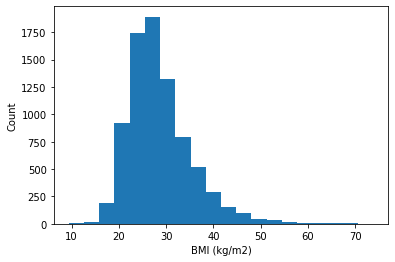

In [246]:
# BMI
plt.hist(x=df_train['bmi'][df_train['bmi']>0], bins=20)
plt.xlabel('BMI (kg/m2)')
plt.ylabel('Count');

BMI is slightly right-skewed. Replot on log scale.

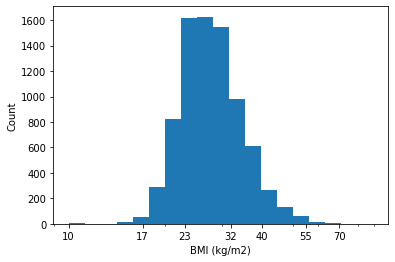

In [247]:
# right-skewed; log-transform
bins = 10**np.arange(1,2,0.05)
new_tix = [10, 17, 23, 32, 40, 55, 70]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(x=df_train['bmi'][df_train['bmi']>0], bins=bins)
plt.xlabel('BMI (kg/m2)')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs);

BMI peaks around 26

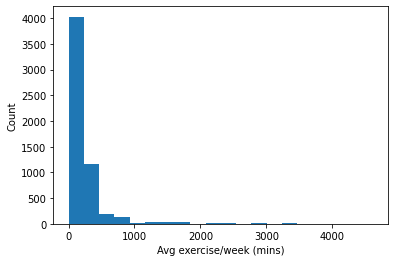

In [248]:
# avg minutes weekly moderate exercise
plt.hist(x=df_train['weeklyminutesmoderateexercise'][df_train['weeklyminutesmoderateexercise']>0], bins=20)
plt.xlabel('Avg exercise/week (mins)')
plt.ylabel('Count');

This is severely right-skewed: log transform again. The large peak at zero won't be shown on the log scale.

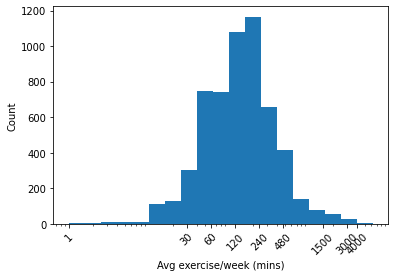

In [249]:
# right-skewed; log-transform
bins = 10**np.arange(0,4,0.2)
new_tix = [1, 30, 60, 120, 240, 480, 1500, 3000, 4000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(x=df_train['weeklyminutesmoderateexercise'][df_train['weeklyminutesmoderateexercise']>0], bins=bins)
plt.xlabel('Avg exercise/week (mins)')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

There is a large peak at zero that isn't shown on this scale. For those who do exercise, the peak is around 180 mins/week.

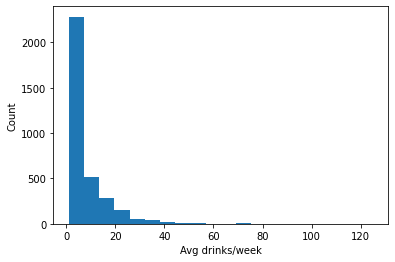

In [250]:
# avg drinks per week
plt.hist(x=df_train['avgdrinksperweek'][df_train['avgdrinksperweek']>0], bins=20)
plt.xlabel('Avg drinks/week')
plt.ylabel('Count');

The dominant value is zero. The remainder is right-skewed. Will log plot to see distribution of nonzero values.

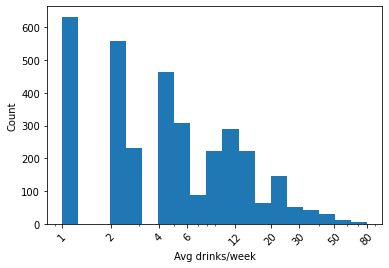

In [251]:
# right-skewed; log-transform
bins = 10**np.arange(0,2,0.1)
new_tix = [1, 2, 4, 6, 12, 20, 30, 50, 80]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(x=df_train['avgdrinksperweek'][df_train['avgdrinksperweek']>0], bins=bins)
plt.xlabel('Avg drinks/week')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

Decreasing frequency with increasing number for the non-zero values.

Bar plot the categorical variables. Will leave in the missing codes for now.


In [252]:
# add the stratum & combined "offered access" variable to the list of integer variables
int_cols.append('stratum')
int_cols.append('offeredaccesseither')

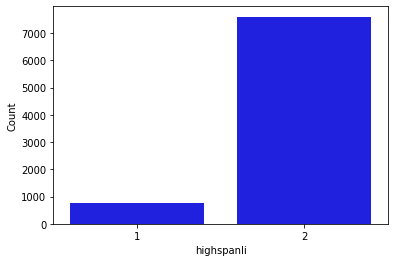

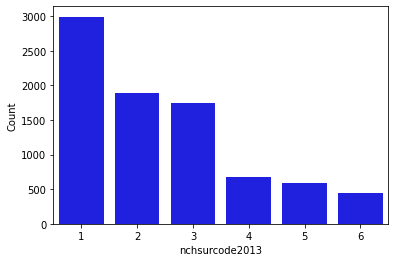

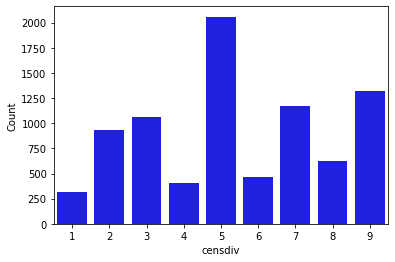

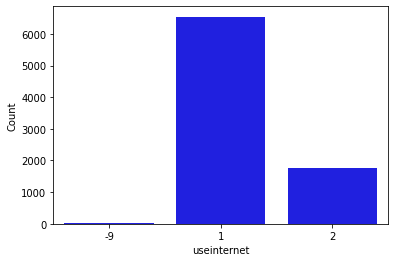

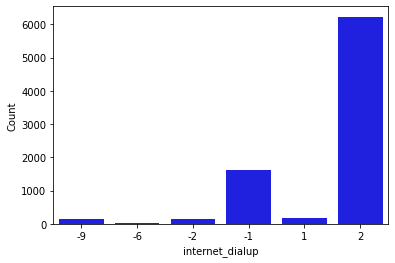

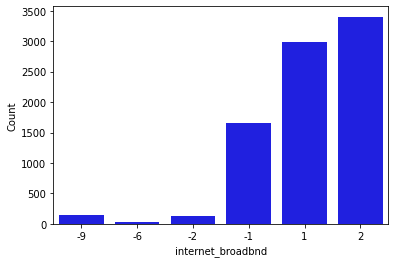

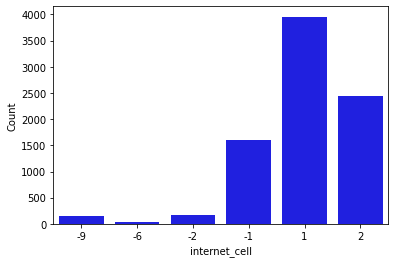

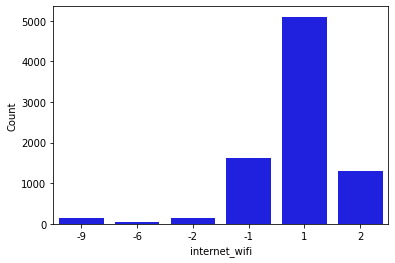

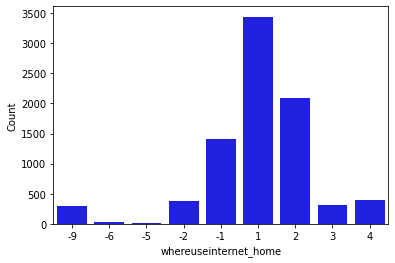

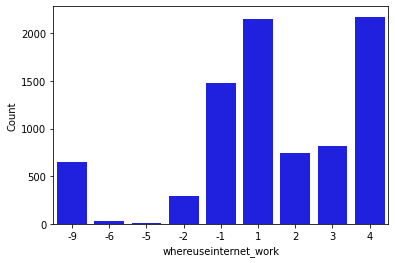

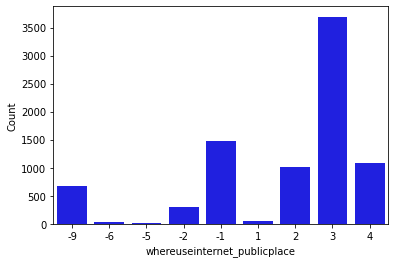

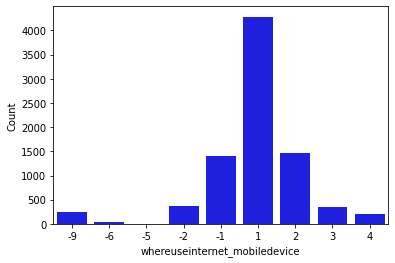

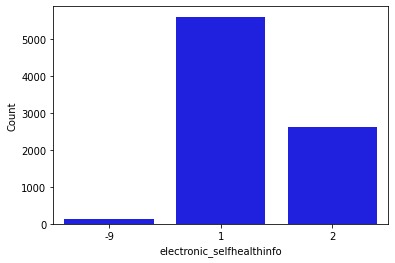

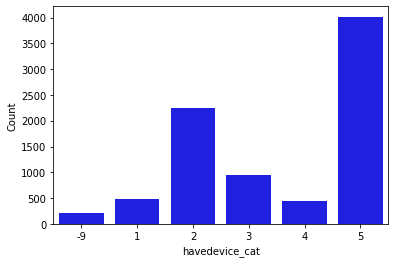

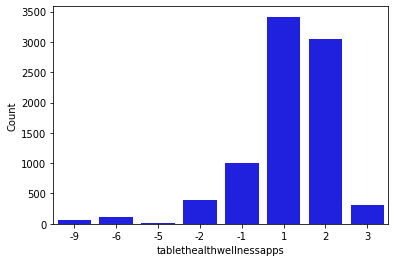

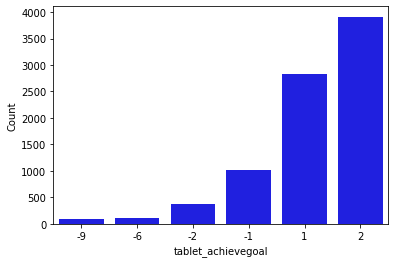

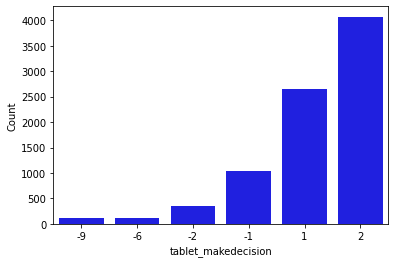

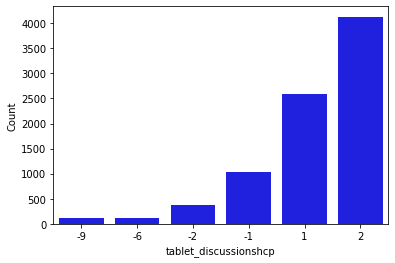

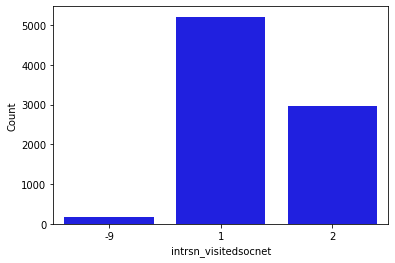

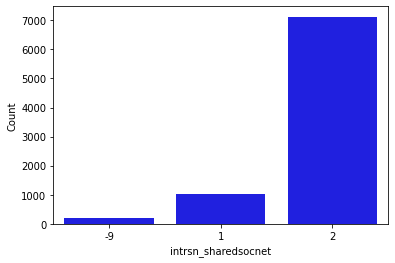

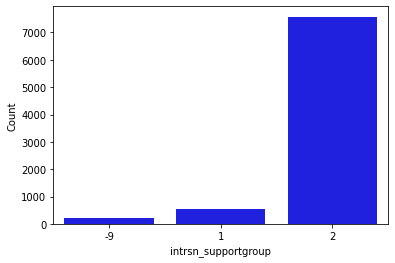

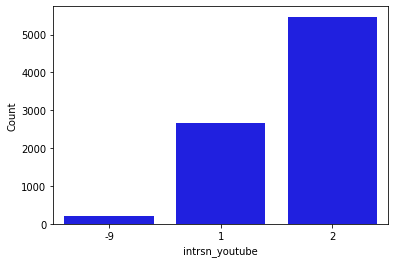

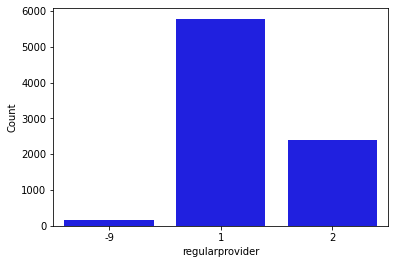

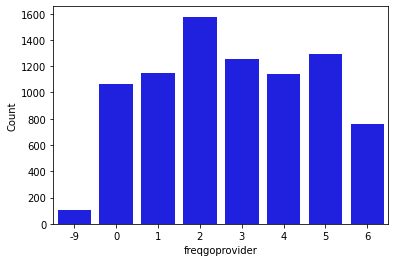

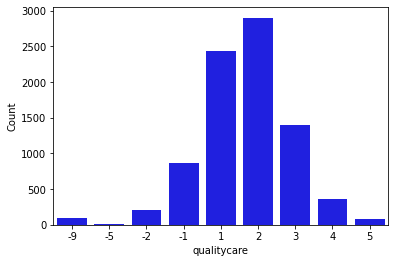

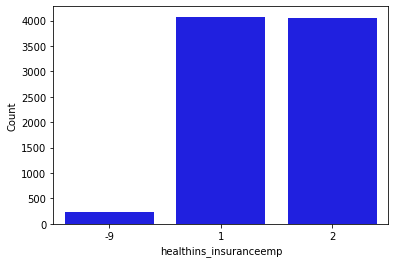

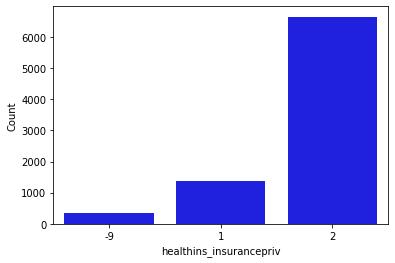

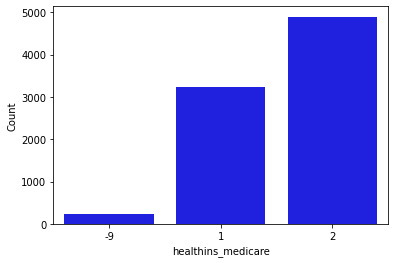

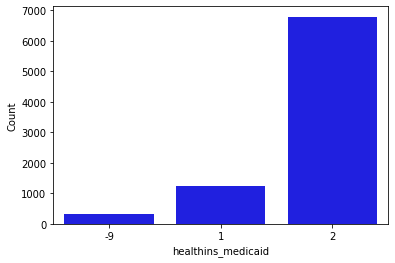

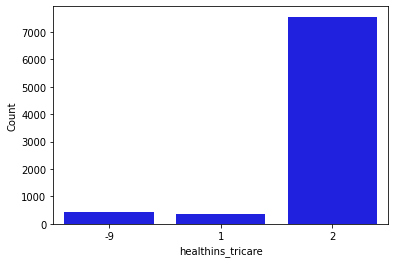

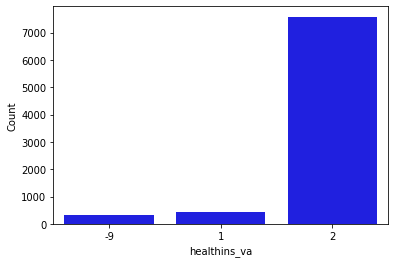

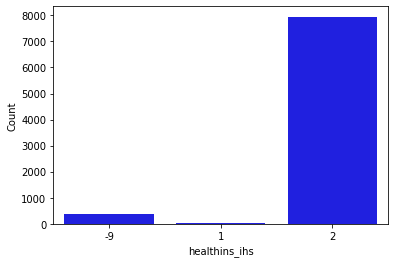

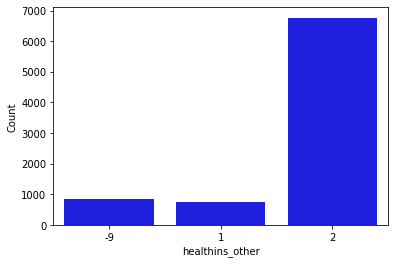

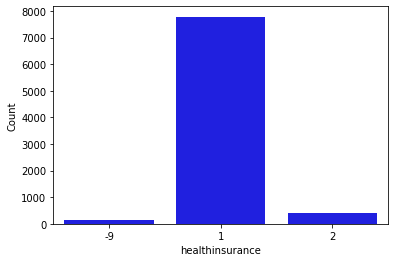

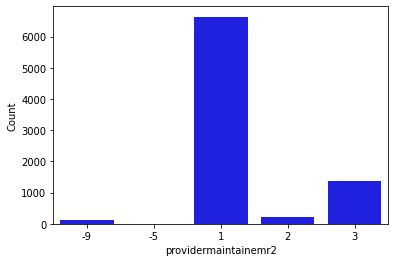

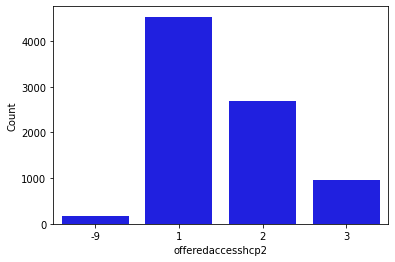

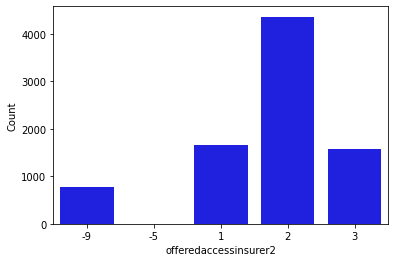

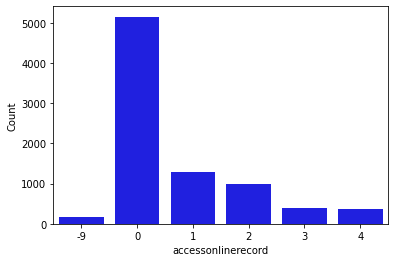

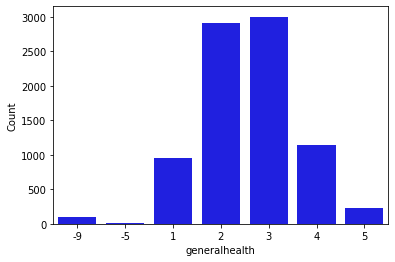

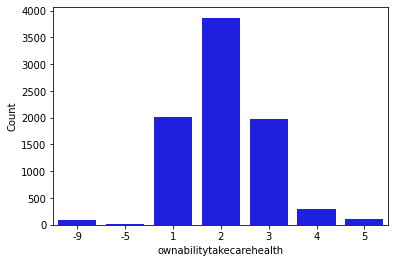

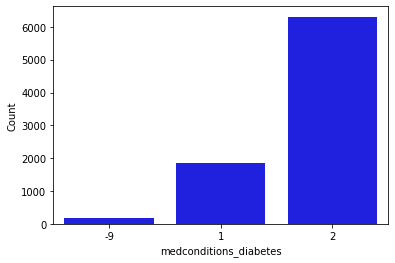

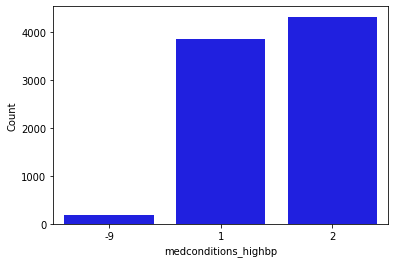

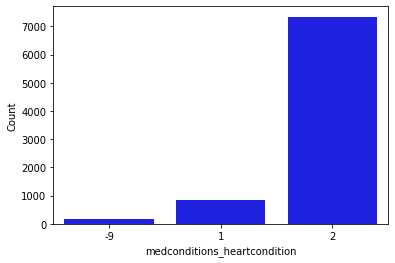

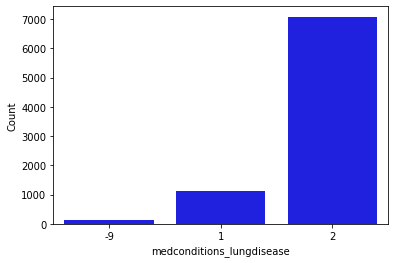

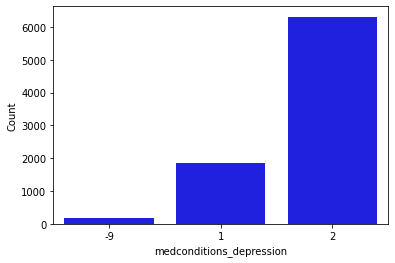

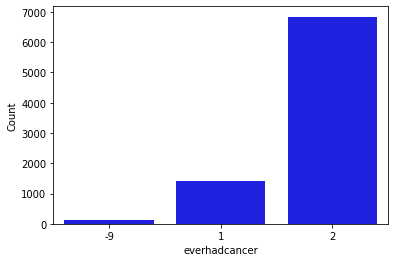

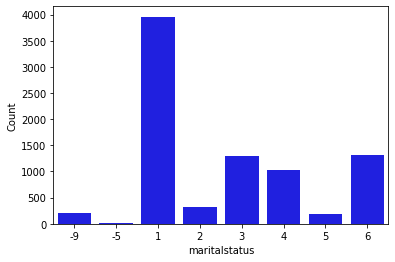

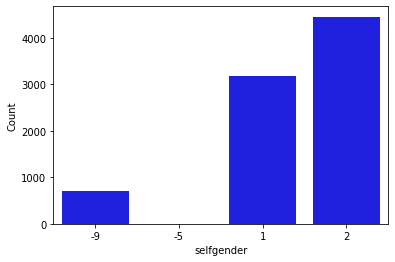

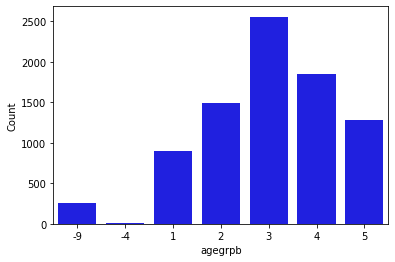

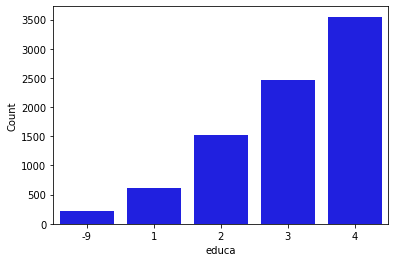

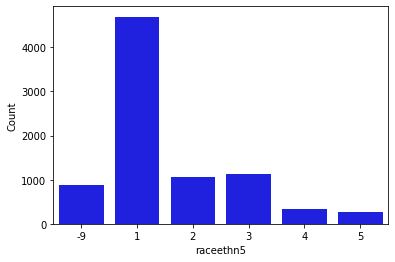

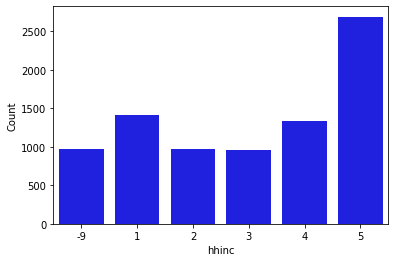

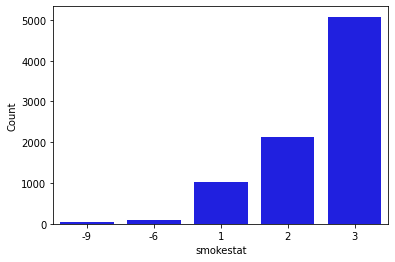

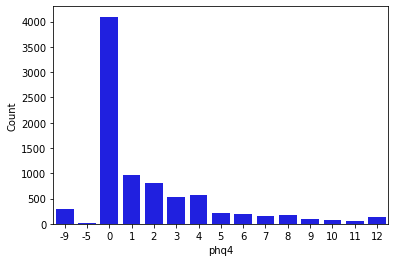

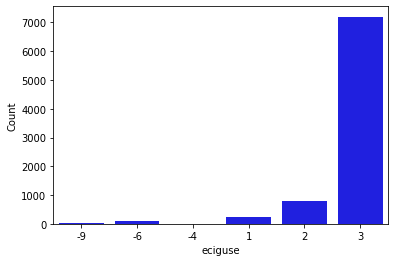

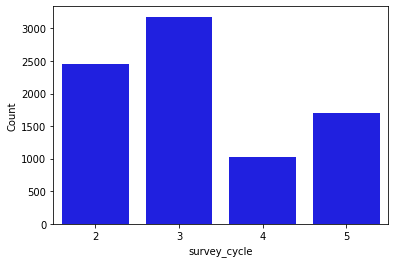

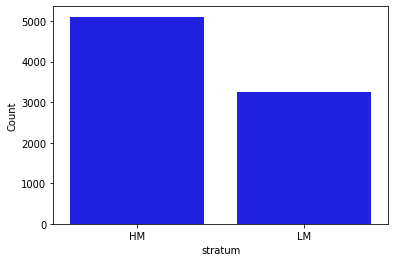

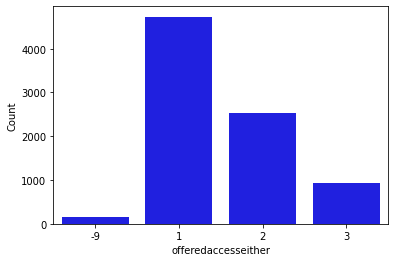

In [253]:
# do the countplots; using a loop because there are so many variables
for col in int_cols:    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sb.countplot(data=df_train, x=col, color='blue')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    # doing this to keep from opening too many figs at once (eats memory)
    plt.close(fig);

Findings from the above visualizations:  
- `highspanli` (1 = yes, 2 = no): most responses do not come from census tracts where >= 30% of citizens report not being able to speak english very well.
- `nchurscode2013` (division of urban & rural; higher code # = more rural): the prevalence decreases directly with increasing rurality.
- `censdiv` (1 = New England, 2 = Middle Atlantic, 3 = E North Ctrl, 4 = W North Ctrl, 5 = S Atlantic, 6 = E South Ctrl, 7 = W South Ctrl, 8 = Mountain, 9 = Pacific): the most common division is "South Atlantic".
- `useinternet` (1 = yes, 2 = no): surprisingly, ~1500 respondents claim **not** to use the interent to access the web or send/receive emails. 
- `internet_xxx` (what mode of internet access; 1 = yes, 2 = no): "wifi" and via mobile are the most frequent. "broadband" is less frequent (although it isn't clear if "wifi" means only outside the home). Almost none use dial-up connections.
- `whereuseinternet_xxx` (frequency of internet use in different locations; 1 = daily, 2 = sometimes, 3 = Never, 4 = NA): respondent most frequently use the internet at home or on a mobile device; least frequently in a public place (e.g. library). 
- `electronic_selfhealthinfo` (use of electronic means to search for health-related info for oneself in last 12 mos; 1 = yes, 2 = no): most (~80%) have searched for electronic health info. 
- `havedevicecat` (summary of the `havedevice_xxx` fields; 1 = tablet, 2 = smartphone, 3 = basic cellphone, 4 = none, 5 = multiple): the majority have more than one device (comprising tablet, smartphone, dumbphone; code 5).
- `tablethealthwellnessapps` (1 = yes, 2 = no, 3 = don't know): a little less than half have a health/wellness app on their tablet
- `tablet_xxx` (use of tablet for health-related activities; 1 = yes, 2 = no): roughly the same number of respondents have used their tablets to achieve a fitness/health goal, have discussions with a HCP, and make health related decisions, although for each variable more have not done these things than have. 
- `intrsn_xxx` (1 = yes, 2= no; reasons for using the internet): the most frequent reason is to visit a social networking site. few have used the internet to participate in a support group for people with similar medical conditions.
- `regularprovider`(1 = yes, 2= no): most respondents (~70%) have a regular HCP they see.
- `freqgoprovider` (HCP visit frequency/year;  0 = none; 1-4 = 1-4 times; 5 = 6-9; 6 = >= 10): the most popular visit frequency is twice/year, although the distribution is fairly even for all the categories.
- `qualitycare` (1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor): for this overall rating, the most frequent is "very good", followed by "excellent", again indicating over satisfaction with care provided by HCPs.
- `healthinsurance` and `healthins_xxx` variables (1 = yes, 2 = no for all): nearly all respondents had some form insurance (`healthinsurance`). The most common type was employer-provided insurance (`healthins_emp`), followed by Medicare (`healthins_medicare`).  
- `providermaintainemr2` (1 = yes, 2 = no 3 = don't know): the vast majority of respondents think their HCP has an EMR, although nearly 20% selected 'don't know'. 
- `offeredacessxxx` variables (1 = yes, 2 = no, 3 = don't know for all): most respondents who were offered access were offered by their HCP rather than by their insurer. About 40% have been offered access by either.
- `accessonlinerecord` (times accessed in last 12 mos; 0 = none, 1 = 1-2, 2 = 3-5, 3 = 6-9, 4 = >=10): most respondents had not accessed an EMR in the past 12 months; of those who had, the most common frequency was 1-2 times.
- `generalhealth` (self-perception of healths status; 1 = excellent, 2 =v ery good, 3 = good, 4 = fair, 5 = poor): most respondents, in roughly equal numbers, rated their health "very good" or "good".
- `ownabilitytakecarehealth` (1 = completely confident, 2 = very, 3 = somewhat, 4 = a little, 5 = not at all): most respondents were "very" confident in their ability to take care of their own health.
- chronic conditions (`medconditions_xxx` & 'everhadcancer' variables; 1 = present, 2 = absent for all): high blood pressure (`highbp` = 1) was the most common condition.
- `maritalstatus`(1 = married; 2 = long-term partner; 3 = divorced; 4 = widowed; 5 = separated; 6 = single): most respondents were married.
- `selfgender` (1 = male, 2 = female): female was most common, although ~10% of respondents didn't answer (code -9). They may be gender non-conforming, so this should probably be kept as its own category. 
- `agegrpb` (age group; 1 = 18-34, 2 = 35-49; 3 = 50-64; 4 = 65-74; 5 = 75+): the most common age group is 50-64.
- `educa`(education level; 1 = < high school; 2 = high school grad; 3 = some college; 4 = college or graduate degree): the most common education level is a college or higher degree.
- `phq4` (depression score; 0-12 where higher is more depressed): most patients have scores consistent with "no distress" (0-2). This should be categorized into common scoring categories (see below). 
- `smokestat` and `eciguse` (cigarette and e-cigarette use, respectively; 1 = current, 2 = former, 3 = never): most patients are never-smokers.
- `survey cycle` (2 = cycle 2 (2018), 3 = cycle 3 (2019), 4 = cycle 4 pre-pandemic (2020 pre-3/11), 5 = cycle 4 post-pandemic (2020 post-3/11)) & `pandemic` (-1 = pre, 1 = post): despite the limited duration of the survey, there are ~1500 entries from the post-pandemic period. 
- `hhinc` (household income in dollars;  1 = <20k; 2 = 20k-34999; 3 = 35k-49999; 4 = 50k-74999; 5 = >=75k): the most common household income is >=75k.
- `raceethn5`(race/ethnicity;  1 = nonhispanic white; 2 = nonhispanic black/african-american; 3 = hispanic; 4 = nonhispanic asian; 5 = nonhispanic other): the most common racial/ethnic category is non-hispanic white.
- `stratum` (HM = high-minority area; LM = low-minority): as stated in the methodology, high-minority areas are oversampled, resulting the majority of responses coming from these areas.

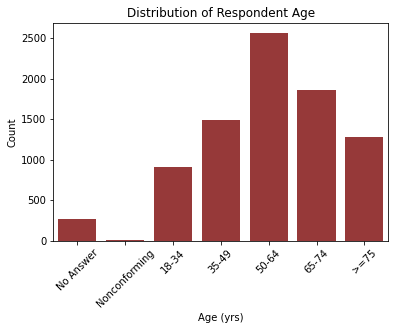

In [254]:
# make a few more rigorously formatted representative plots for the blog post
# age
fig = sb.countplot(data=df_train, x='agegrpb', color='brown')
fig.set_xticklabels (labels = ['No Answer', 'Nonconforming', '18-34', '35-49', '50-64', '65-74', '>=75'],\
                    rotation = 45)
fig.set(title = 'Distribution of Respondent Age')
fig.set(xlabel = 'Age (yrs)')
fig.set(ylabel = 'Count');

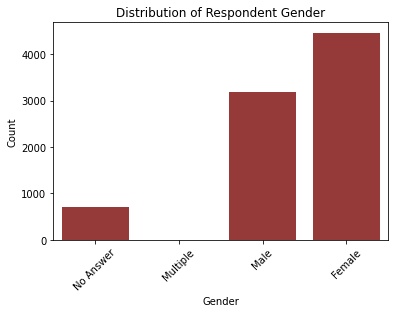

In [255]:
# gender
fig = sb.countplot(data=df_train, x='selfgender', color='brown')
fig.set_xticklabels (labels = ['No Answer', 'Multiple', 'Male', 'Female'],\
                    rotation = 45)
fig.set(title = 'Distribution of Respondent Gender')
fig.set(xlabel = 'Gender')
fig.set(ylabel = 'Count');

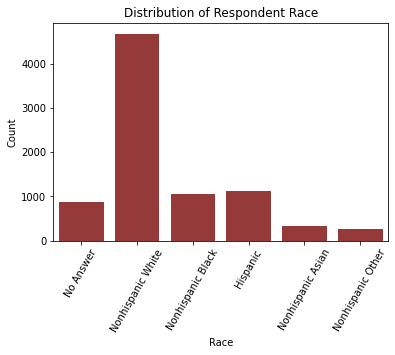

In [256]:
# race
fig = sb.countplot(data=df_train, x='raceethn5', color='brown')
fig.set_xticklabels (labels = ['No Answer', 'Nonhispanic White', 'Nonhispanic Black', 'Hispanic',\
                               'Nonhispanic Asian', 'Nonhispanic Other'], rotation = 60)
fig.set(title = 'Distribution of Respondent Race')
fig.set(xlabel = 'Race')
fig.set(ylabel = 'Count');

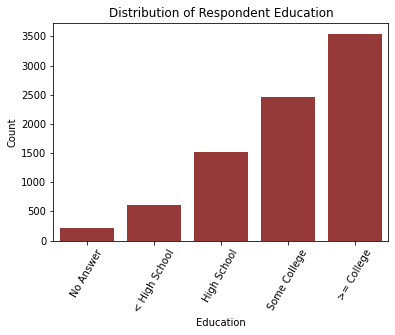

In [257]:
# Education
fig = sb.countplot(data=df_train, x='educa', color='brown')
fig.set_xticklabels(labels = ['No Answer', '< High School', 'High School', 'Some College','>= College'],\
                     rotation = 60)
fig.set(title = 'Distribution of Respondent Education')
fig.set(xlabel = 'Education')
fig.set(ylabel = 'Count');

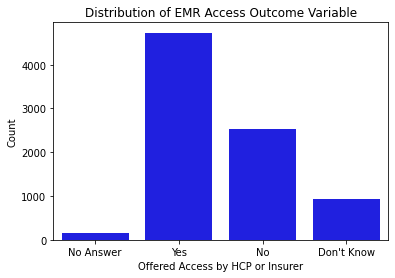

In [258]:
# access variable
fig = sb.countplot(data=df_train, x='offeredaccesseither', color='blue')
fig.set(xticklabels = ['No Answer', 'Yes', 'No', "Don't Know"])
fig.set(title = 'Distribution of EMR Access Outcome Variable')
fig.set(xlabel = 'Offered Access by HCP or Insurer')
fig.set(ylabel = 'Count');

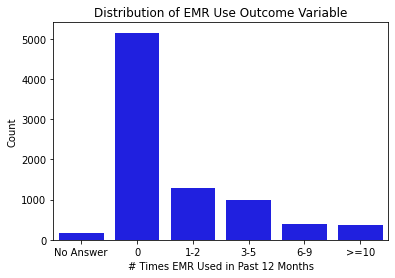

In [259]:
# use variable
fig = sb.countplot(data=df_train, x='accessonlinerecord', color='blue')
fig.set(xticklabels = ['No Answer','0', '1-2', '3-5', '6-9', '>=10'])
fig.set(title = 'Distribution of EMR Use Outcome Variable')
fig.set(xlabel = '# Times EMR Used in Past 12 Months')
fig.set(ylabel = 'Count');

Finally, the PHQ-4 psychological distress scale has 12 possible values, which makes some of them sparse. However, it is [typically scored](https://www.midss.org/content/patient-health-questionnaire-4-phq-4) as:
- 0-2 points: no distress
- 3-5 points: mild distress
- 6-8 points: moderate distress
- 9-12 points: severe distress  

We'll create a field for that scoring system, where 1 = no to 4 = severe distress.

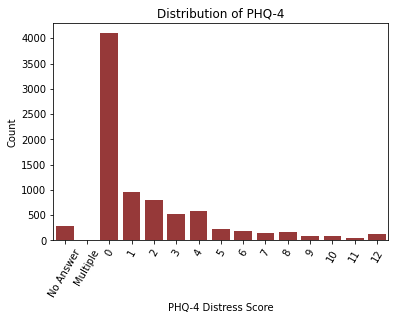

In [260]:
# PHQ-4 baseline
fig = sb.countplot(data=df_train, x='phq4', color='brown')
fig.set_xticklabels (labels = ['No Answer', 'Multiple', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',\
                               '10', '11', '12'], rotation = 60)
fig.set(title = 'Distribution of PHQ-4')
fig.set(xlabel = 'PHQ-4 Distress Score')
fig.set(ylabel = 'Count');

In [261]:
# back up first
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [262]:
# categorize phq4 as above-training set
df_train['phq4_cat'] = df_train['phq4']
df_train.loc[(df_train['phq4'] >= 0) & (df_train['phq4'] <= 2), 'phq4_cat'] = 1
df_train.loc[(df_train['phq4'] >= 3) & (df_train['phq4'] <= 5), 'phq4_cat'] = 2
df_train.loc[(df_train['phq4'] >= 6) & (df_train['phq4'] <= 8), 'phq4_cat'] = 3
df_train.loc[(df_train['phq4'] >= 9) & (df_train['phq4'] <= 12), 'phq4_cat'] = 4
display(df_train['phq4_cat'].value_counts())

<ipython-input-262-76ddd0a3a534>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['phq4_cat'] = df_train['phq4']
/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

 1    5860
 2    1317
 3     507
 4     373
-9     284
-5      10
Name: phq4_cat, dtype: int64

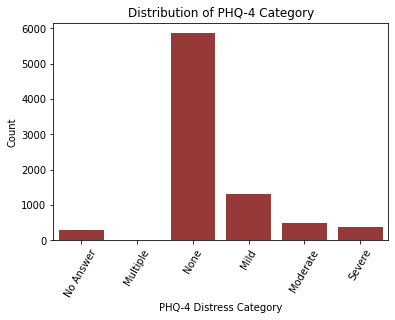

In [263]:
# PHQ-4 categories
fig = sb.countplot(data=df_train, x='phq4_cat', color='brown')
fig.set_xticklabels (labels = ['No Answer', 'Multiple', 'None', 'Mild', 'Moderate', 'Severe'], rotation = 60)
fig.set(title = 'Distribution of PHQ-4 Category')
fig.set(xlabel = 'PHQ-4 Distress Category')
fig.set(ylabel = 'Count');

In [264]:
# categorize phq4 as above-test set -- no peeking
df_test['phq4_cat'] = df_test['phq4']
df_test.loc[(df_test['phq4'] >= 0) & (df_test['phq4'] <= 2), 'phq4_cat'] = 1
df_test.loc[(df_test['phq4'] >= 3) & (df_test['phq4'] <= 5), 'phq4_cat'] = 2
df_test.loc[(df_test['phq4'] >= 6) & (df_test['phq4'] <= 8), 'phq4_cat'] = 3
df_test.loc[(df_test['phq4'] >= 9) & (df_test['phq4'] <= 12), 'phq4_cat'] = 4

<ipython-input-264-8789f5d9622e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['phq4_cat'] = df_test['phq4']
/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [265]:
# now we can drop the original phq4 column
df_train.drop(columns = 'phq4', inplace = True)
display(df_train.columns)
df_test.drop(columns = 'phq4', inplace = True)
display(df_test.columns)

/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Index(['stratum', 'highspanli', 'nchsurcode2013', 'censdiv', 'useinternet',
       'internet_dialup', 'internet_broadbnd', 'internet_cell',
       'internet_wifi', 'whereuseinternet_home', 'whereuseinternet_work',
       'whereuseinternet_publicplace', 'whereuseinternet_mobiledevice',
       'electronic_selfhealthinfo', 'havedevice_cat',
       'tablethealthwellnessapps', 'tablet_achievegoal', 'tablet_makedecision',
       'tablet_discussionshcp', 'intrsn_visitedsocnet', 'intrsn_sharedsocnet',
       'intrsn_supportgroup', 'intrsn_youtube', 'regularprovider',
       'freqgoprovider', 'qualitycare', 'healthins_insuranceemp',
       'healthins_insurancepriv', 'healthins_medicare', 'healthins_medicaid',
       'healthins_tricare', 'healthins_va', 'healthins_ihs', 'healthins_other',
       'healthinsurance', 'providermaintainemr2', 'offeredaccesshcp2',
       'offeredaccessinsurer2', 'accessonlinerecord', 'generalhealth',
       'ownabilitytakecarehealth', 'medconditions_diabetes',
       

Index(['stratum', 'highspanli', 'nchsurcode2013', 'censdiv', 'useinternet',
       'internet_dialup', 'internet_broadbnd', 'internet_cell',
       'internet_wifi', 'whereuseinternet_home', 'whereuseinternet_work',
       'whereuseinternet_publicplace', 'whereuseinternet_mobiledevice',
       'electronic_selfhealthinfo', 'havedevice_cat',
       'tablethealthwellnessapps', 'tablet_achievegoal', 'tablet_makedecision',
       'tablet_discussionshcp', 'intrsn_visitedsocnet', 'intrsn_sharedsocnet',
       'intrsn_supportgroup', 'intrsn_youtube', 'regularprovider',
       'freqgoprovider', 'qualitycare', 'healthins_insuranceemp',
       'healthins_insurancepriv', 'healthins_medicare', 'healthins_medicaid',
       'healthins_tricare', 'healthins_va', 'healthins_ihs', 'healthins_other',
       'healthinsurance', 'providermaintainemr2', 'offeredaccesshcp2',
       'offeredaccessinsurer2', 'accessonlinerecord', 'generalhealth',
       'ownabilitytakecarehealth', 'medconditions_diabetes',
       

<a id='multivar'></a>
### Mulitvariate
<a id='mvoutcome'></a>
#### Outcome variables
We need to determine what to do with the skipped/missing data (code -9) entries in the outcome fields.  
The preliminary suspicion is that these indicate disengagement or disinterest. 

<a id='mvoae'></a>
##### `offeredaccesseither` variable

For `offeredaccesseither`, we would hope characteristics of patients answering "don't know" and skipping the question  are similar. If so we can combine the missing entries with the "don't know" entries. If they aren't similar, we either have to keep the missing entries as a separate category, or drop them.   
To assess this we'll compare the two categories on key demographic variables. 

The demographic variables we'll analyze are:
- `stratum` (minority status of census tract)
- `highspanli` (prevalence of less proficient English speakers)
- `useinternet` (internet usage)
- `healthinsurance` (any form of insurance)
- `selfgender` (gender)
- `agegrpb` (age groups)
- `educa` (education-level groups)
- `raceethn5` (race/ethnicity groups)
- `hhinc` (household income groups)   

For these variables, we'll omit the missing/error codes except -9.  
A chi-squared contingency table analysis will be used to assess the relationship between each demographic variable and the outcome variables. 
The null hypothesis is that respondents who selected "don't know" (code 3) for the outcome variables have the same demographic characteristics as respondents who failed to answer (code -9).  
The alternative hypothesis is that demographic characteristics are different between these groups.
The null hypothesis will be rejected for tests with a p-value < 0.05.

In [266]:
# check the codes
miss_codes2

[-4, -5, -6]

In [267]:
def get_crosstabs(row, column, df, ignore_codes = miss_codes2, plot_data = False):
    '''
    Create and analyze an R x C contingency table for categorical data
    Optionally, plot the data
    INPUTS:
    row (str) : row name (should be a column in df)
    column (str) : column name (should be a column in df); will not be filtered by ignore_codes
    df (pandas dataframe) : data source for the above variables
    ignore_codes (list) : missing-data codes to exclude from the row values
    plot_data (boolean) : display a grouped countplot
    
    OUTPUTS:
    xtab (pandas dataframe) : crosstabulation of observed data
    expected (numpy array) : crosstabulation of expected data
    chi2 (float) : chi-squared value
    dof (int) : degrees of freedom for chi-squared test
    p_value (float): p-value for chi-squared test on contingency table
    '''    
    # filter out the missing codes
    df_filt = df[~(df[row].isin(ignore_codes))]
    
    # plot if requested
    if plot_data:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        sb.countplot(data=df_filt, x=row, hue=column)  
        plt.xlabel(row)
        plt.ylabel('Count')
        plt.show()
        # doing this to keep from opening too many figs at once (eats memory)
        plt.close(fig);
      
    # create cross-tabulation
    xtab = pd.crosstab(df_filt[row], df_filt[column], margins = False)   
    print('observed data:\n', xtab)
    
    # analyze
    # don't generally use continuity correction for tables > 2 x 2; Rosner, Fundamentals of Biostatics, p. 394
    chi2, p_value, dof, expected = chi2_contingency(xtab, correction = False)
    print('expected data:\n', expected)
    print('chi-squared value: {:.4f} for {:.0f} dof; p-value = {:.4f}\n'.format(chi2, dof, p_value))
    
    return

In [268]:
# make df containing only the 3 (don't know) and -9 (skipped/missing) entries for offeredaccesseither
df_missdk = df_train[(df_train['offeredaccesseither'] == -9) | (df_train['offeredaccesseither'] == 3)]
display(df_missdk['offeredaccesseither'].value_counts())
display(df_missdk.head())

 3    929
-9    154
Name: offeredaccesseither, dtype: int64

stratum  highspanli  nchsurcode2013  censdiv  useinternet  \
9194      LM           2               6        4            1   
611       LM           2               1        6            1   
8474      LM           2               3        5            1   
511       LM           2               5        2            1   
4235      HM           2               3        5            1   

      internet_dialup  internet_broadbnd  internet_cell  internet_wifi  \
9194                2                  1              2              2   
611                 2                  1              2              2   
8474                2                  2              2              1   
511                 2                  2              2              1   
4235                2                  2              2              1   

      whereuseinternet_home  ...  raceethn5  hhinc   bmi  smokestat  \
9194                      1  ...         -9     -9  17.6         -6   
611                       1  ...          1      5  23.2          3   
8474                      1  ...          1      5  23.1          3   
511                      -9  ...         -9     -9  -9.0          3   
4235                     -9  ...          1      2  27.4          1   

      weeklyminutesmoderateexercise  eciguse  avgdrinksperweek  survey_cycle  \
9194                             -9       -6                 0             4   
611                             120        3                 0             2   
8474                            200        3                12             4   
511                              -9        3                -9             2   
4235                             90        2                -9             3   

      offeredaccesseither  phq4_cat  
9194                    3         1  
611                     3         2  
8474                    3         1  
511                    -9        -9  
4235                    3         2  

[5 rows x 61 columns]

In [269]:
# pefrom the contingency-table analysis
demog_vars = ['stratum', 'highspanli', 'useinternet', 'healthinsurance', 'selfgender', 'agegrpb', 'raceethn5',\
             'educa', 'hhinc']

for dvar in demog_vars:
    get_crosstabs(dvar, 'offeredaccesseither', df_missdk)

observed data:
 offeredaccesseither   -9    3
stratum                      
HM                   109  593
LM                    45  336
expected data:
 [[ 99.82271468 602.17728532]
 [ 54.17728532 326.82271468]]
chi-squared value: 2.7959 for 1 dof; p-value = 0.0945

observed data:
 offeredaccesseither   -9    3
highspanli                   
1                     16  103
2                    138  826
expected data:
 [[ 16.92151431 102.07848569]
 [137.07848569 826.92151431]]
chi-squared value: 0.0657 for 1 dof; p-value = 0.7977

observed data:
 offeredaccesseither  -9    3
useinternet                 
-9                    2    3
 1                   85  604
 2                   67  322
expected data:
 [[  0.710988     4.289012  ]
 [ 97.97414589 591.02585411]
 [ 55.31486611 333.68513389]]
chi-squared value: 7.6049 for 2 dof; p-value = 0.0223

observed data:
 offeredaccesseither  -9    3
healthinsurance             
-9                   65   12
 1                   79  851
 2              

There are significant differences in demographic characteristic between the groups on all the variables except the first two. This seems to be almost completely driven by a higher frequency of omission of answers (code -9) on the demographic variables for those who also omitted an answer to `offeredaccesseither`.  
This could indicate a general lack of interest in the survey, or general concerns about providing information.

<a id='mvaor'></a>
##### `accessonlinerecord` variable

This variable relates to frequency of EMR use, and does not have a "don't know" category. A missing answer here could indicate that the respondent doesn't use an EMR, doesn't remember whether they have used it, or doesn't want to respond. Thus, it would be difficult to determine which category to merge the missing-answer category with. Also, since the categories denote increasing frequency, keeping the missing code as a separate category creates a disruption in that order. For these reasons, and since the missing data are relatively infrequent, surveys with missing responses to this question will also be dropped. 

<a id='mvocsummary'></a>
##### Summary
For `offeredaccesseither`, there are significant demographic differences between respondents who answered "don't know" and respondents who omitted an answer to the outcome-variable questions. This means we can't combine the two categories into one. The options would be to either keep them both as separate categories, or to drop the omitted entries.  

The largest differences between the observed and expected data were that more of the non-responders also omitted an answer to the demographic questions. This would seem to indicate a group of "serial non-responders" who omit answers to several questions, perhaps out of disinterest.  

For `accessonlinerecord`, the meaning of a missing answer is ambiguous, as discussed above, so merging it with another category isn't straighforward. Keeping it separate creates a discontinuity in the order of categories.

For the above reasons, and since: a) the missing entries (code -9) are relatively few; and b) the entries for these respondents will tend to have large amounts of missing data that we'll have to make numerous assumptions to handle, the decision based on this analysis is to **drop the rows containing omitted responses to the outcome-variable questions**. 

In [270]:
# drop the rows with omitted answers (code -9) in the outcome variables
# first back up
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [271]:
# check the counts -- training set 
df_train['offeredaccesseither'].value_counts()

 1    4731
 2    2537
 3     929
-9     154
Name: offeredaccesseither, dtype: int64

In [272]:
# drop the -9s
df_train = df_train[~(df_train['offeredaccesseither'] == -9)]
display(df_train['offeredaccesseither'].value_counts())

1    4731
2    2537
3     929
Name: offeredaccesseither, dtype: int64

In [273]:
# repeat for the other variable
display(df_train['accessonlinerecord'].value_counts())
df_train = df_train[~(df_train['accessonlinerecord'] == -9)]
display(df_train['accessonlinerecord'].value_counts())

 0    5095
 1    1289
 2     987
 3     388
 4     355
-9      83
Name: accessonlinerecord, dtype: int64

0    5095
1    1289
2     987
3     388
4     355
Name: accessonlinerecord, dtype: int64

In [274]:
# repeat for test set, but no peeking at the counts
df_test = df_test[~(df_test['offeredaccesseither'] == -9)]
df_test = df_test[~(df_test['accessonlinerecord'] == -9)]

In [275]:
# how many records are left?
print('train size: ', df_train.shape[0])
print('test size: ', df_test.shape[0])

train size:  8114
test size:  3464


After eliminating the omitted entries, we have 8114 training records and 3464 test records (11578 total).

<a id='mvpreds'></a>
#### Predictor variables
Next, we'll examine the relationships between the predictor variables and each outcome variable.  

<a id='mvcontord'></a>
##### Continuous/ordinal 
The variables will be plotted using box & whisker plots. Since these variables displayed skewed univariate distributions (see above), the relationship to the outcome variables will be tested with the nonparametric Kruskal-Wallis test.

In [276]:
def get_boxKW(predictor, outcome, xlab, ylab, df = df_train):
    '''
    Create box & whisker plot and perform Kruskal-Wallis analysis of a continuous/ordinal predictor 
    and an outcome variable
    INPUTS:
    predictor (str) : predictor variable name (should be a column in df)
    outcome (str) : outcome variable name (should be a column in df); assumed Y=1, N=2, don't know = 3
    xlab (str) : x-axis label
    ylab (str) : y-axis label
    df (pandas dataframe): data source for the above variables
    
    OUTPUTS:
    p_value: p-value for Kruskal-Wallis analysis
    '''  
    # omit the missing-data codes   
    df_boxKW = df[df[predictor] >= 0.0]
    
    # box & whisker plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sb.boxplot(data=df_boxKW, x=outcome, y=predictor, color='brown')
    ax.set_xticklabels(["Yes", "No", "Don't Know"])
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.show()
    # doing this to keep from opening too many figs at once (eats memory)
    plt.close(fig);
    
    # test the association with Kruskal-Wallis
    x_kw = df_boxKW[predictor][df_boxKW[outcome] == 1]
    y_kw = df_boxKW[predictor][df_boxKW[outcome] == 2]
    z_kw = df_boxKW[predictor][df_boxKW[outcome] == 3]
    p_value = kruskal(x_kw, y_kw, z_kw)[1]
    print('p-value: {:.4f}'.format(p_value))

In [277]:
# cont_vars was defined above and contains the three continuous/ordinal variables
cont_vars

['bmi', 'weeklyminutesmoderateexercise', 'avgdrinksperweek']

In [278]:
# 'accessonlinerecord' has more than 3 categories so will be done separately
y_label_list = ['BMI (kg/m2)', 'Avg. weekly exercise (mins)', 'Avg. drinks/week']

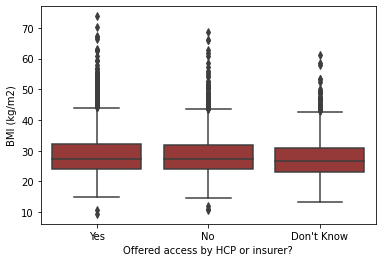

p-value: 0.0002


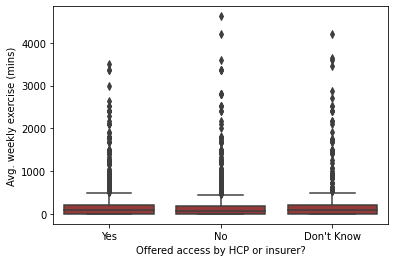

p-value: 0.0000


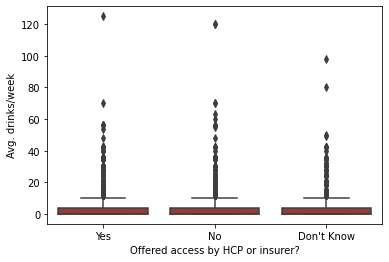

p-value: 0.0001


In [279]:
# plot and analyze the data
for i in range(len(cont_vars)):
    get_boxKW(cont_vars[i], 'offeredaccesseither', 'Offered access by HCP or insurer?', y_label_list[i])

All the relationships are significant at a p \< 0.05 level.

Now let's do `accessonlinerecord`. 

In [280]:
# check to see if there are missing codes here
df_train['accessonlinerecord'].value_counts()

0    5095
1    1289
2     987
3     388
4     355
Name: accessonlinerecord, dtype: int64

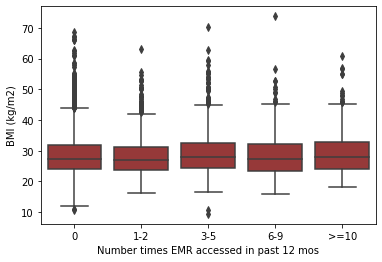

p-value: 0.0434


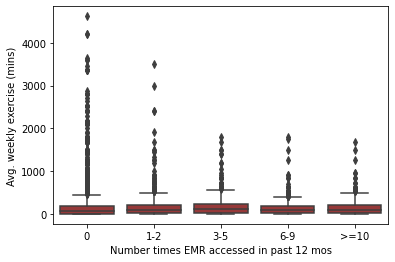

p-value: 0.0000


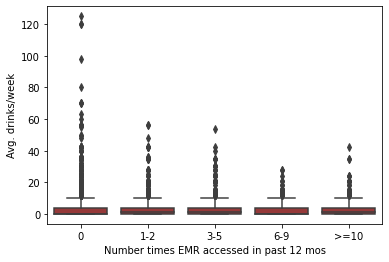

p-value: 0.0000


In [281]:
# plot & analyze effect of each continuous predictor on accesssonlinerecords
outcome = 'accessonlinerecord'
for j in range(len(cont_vars)):
    # omit the missing-data codes   
    df_boxKW = df_train[df_train[cont_vars[j]] >= 0.0]
    
    # plot each predictor
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sb.boxplot(data=df_boxKW, x=outcome, y=cont_vars[j], color='brown')
    ax.set_xticklabels(["0", "1-2", "3-5", "6-9", ">=10"])
    ax.set_xlabel("Number times EMR accessed in past 12 mos")
    ax.set_ylabel(y_label_list[j])
    plt.show()
    # doing this to keep from opening too many figs at once (eats memory)
    plt.close(fig);
    
    # test the association with Kruskal-Wallis
    a_kw = df_boxKW[cont_vars[j]][df_boxKW[outcome] == 0]
    b_kw = df_boxKW[cont_vars[j]][df_boxKW[outcome] == 1]
    c_kw = df_boxKW[cont_vars[j]][df_boxKW[outcome] == 2]
    d_kw = df_boxKW[cont_vars[j]][df_boxKW[outcome] == 3]
    e_kw = df_boxKW[cont_vars[j]][df_boxKW[outcome] == 4]
    p_value = kruskal(a_kw, b_kw, c_kw, d_kw, e_kw)[1]
    print('p-value: {:.4f}'.format(p_value))

Again, all of the relationships above were significant at a p < 0.05 level.

For both outcome variables, all p-values but one are all very low. However, as the plots show, all three predictor variables have many outliers.

These fields _should_ exclude obviously non-conforming data, as that has been cleaned according to the methodology.  

The values for BMI, for instance, cover an extreme range but are physiologically possible. The values for average exercise are also not implausible (i.e., not more than the number of minutes in a week). The values for average drinks also run to large values, but not impossible, e.g. 120 drinks/week would be ~17/day.   

Thus, it's possible the extremes just represent extreme behavior or physiologic extremes. For this reason we won't discard the outliers. However, we can diminish their influence by binning the data into quantiles. We'll do that and re-assess signficance, after we analyze categorical variables. 

<a id='mvcat'></a>
##### Categorical
The relationships of the outcome variables to the categorical predictors will be plotted using bar plots. The relationship will be analyzed with contingency tables and a chi-squared test.  
For the first go, we'll leave in the -9 missing code. The -1 and -2 "N/A" codes will also be included for fields where they exist, but we'll merge them into 1 code since the distinction between the two is irrelevant.

In [282]:
# first back up again
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [283]:
# merge the -2 and -1 codes into just a -1 = "N/A" code -- training set
for col in df_train.columns:
    print('column: ', col)
    print('pre: ', df_train[col].value_counts())
    # fails for stratum b/c categorical
    if col != 'stratum':
        df_train.loc[df_train[col] == -2, col] = -1
    print('post: ', df_train[col].value_counts())

column:  stratum
pre:  HM    4940
LM    3174
Name: stratum, dtype: int64
post:  HM    4940
LM    3174
Name: stratum, dtype: int64
column:  highspanli
pre:  2    7392
1     722
Name: highspanli, dtype: int64
post:  2    7392
1     722
Name: highspanli, dtype: int64
column:  nchsurcode2013
pre:  1    2911
2    1839
3    1705
4     667
5     572
6     420
Name: nchsurcode2013, dtype: int64
post:  1    2911
2    1839
3    1705
4     667
5     572
6     420
Name: nchsurcode2013, dtype: int64
column:  censdiv
pre:  5    2002
9    1282
7    1140
3    1026
2     899
8     609
6     446
4     407
1     303
Name: censdiv, dtype: int64
post:  5    2002
9    1282
7    1140
3    1026
2     899
8     609
6     446
4     407
1     303
Name: censdiv, dtype: int64
column:  useinternet
pre:   1    6419
 2    1663
-9      32
Name: useinternet, dtype: int64
post:   1    6419
 2    1663
-9      32
Name: useinternet, dtype: int64
column:  internet_dialup
pre:   2    6128
-1    1521
 1     164
-2     142
-9 

post:   1    3878
 6    1294
 3    1277
 4     971
 2     319
 5     188
-9     171
-5      16
Name: maritalstatus, dtype: int64
column:  selfgender
pre:   2    4355
 1    3109
-9     649
-5       1
Name: selfgender, dtype: int64
post:   2    4355
 1    3109
-9     649
-5       1
Name: selfgender, dtype: int64
column:  agegrpb
pre:   3    2503
 4    1810
 2    1474
 5    1212
 1     893
-9     217
-4       5
Name: agegrpb, dtype: int64
post:   3    2503
 4    1810
 2    1474
 5    1212
 1     893
-9     217
-4       5
Name: agegrpb, dtype: int64
column:  educa
pre:   4    3495
 3    2403
 2    1471
 1     566
-9     179
Name: educa, dtype: int64
post:   4    3495
 3    2403
 2    1471
 1     566
-9     179
Name: educa, dtype: int64
column:  raceethn5
pre:   1    4618
 3    1099
 2    1025
-9     790
 4     323
 5     259
Name: raceethn5, dtype: int64
post:   1    4618
 3    1099
 2    1025
-9     790
 4     323
 5     259
Name: raceethn5, dtype: int64
column:  hhinc
pre:   5    2660
 1

In [284]:
# merge the -2 and -1 codes into just a -1 = "N/A" code -- test set, no peeking at the #'s
for col in df_test.columns:
    # fails for stratum b/c categorical
    if col != 'stratum':
        df_test.loc[df_test[col] == -2, col] = -1

In [285]:
# make list of outcome vars
outcome_vars = ['offeredaccesseither', 'accessonlinerecord']
outcome_vars

['offeredaccesseither', 'accessonlinerecord']

In [286]:
# make a list of variables to analyze.
# check the previous list
int_cols

['highspanli',
 'nchsurcode2013',
 'censdiv',
 'useinternet',
 'internet_dialup',
 'internet_broadbnd',
 'internet_cell',
 'internet_wifi',
 'whereuseinternet_home',
 'whereuseinternet_work',
 'whereuseinternet_publicplace',
 'whereuseinternet_mobiledevice',
 'electronic_selfhealthinfo',
 'havedevice_cat',
 'tablethealthwellnessapps',
 'tablet_achievegoal',
 'tablet_makedecision',
 'tablet_discussionshcp',
 'intrsn_visitedsocnet',
 'intrsn_sharedsocnet',
 'intrsn_supportgroup',
 'intrsn_youtube',
 'regularprovider',
 'freqgoprovider',
 'qualitycare',
 'healthins_insuranceemp',
 'healthins_insurancepriv',
 'healthins_medicare',
 'healthins_medicaid',
 'healthins_tricare',
 'healthins_va',
 'healthins_ihs',
 'healthins_other',
 'healthinsurance',
 'providermaintainemr2',
 'offeredaccesshcp2',
 'offeredaccessinsurer2',
 'accessonlinerecord',
 'generalhealth',
 'ownabilitytakecarehealth',
 'medconditions_diabetes',
 'medconditions_highbp',
 'medconditions_heartcondition',
 'medconditions_l

In [287]:
# remove columns we deleted
int_cols.remove('phq4')
# remove outcome variables and the variables used to derive them
int_cols.remove('offeredaccesshcp2')
int_cols.remove('offeredaccessinsurer2')
int_cols.remove('offeredaccesseither')
int_cols.remove('accessonlinerecord')
# these are additional non-predictor variables. 
# 'providermaintainemr2' is an auxiliary datum on access. we likely won't use it, but am keeping for now
int_cols.remove('providermaintainemr2')

In [288]:
# add the revised phq-4 column
int_cols.append('phq4_cat')

This list now has all the categorical variables, except for the ones we're going to create from the 3 continuous/ordinal variables. For those, we'll have to exclude the negative entries before quantilizing and binning the data, so we'll do that separately.

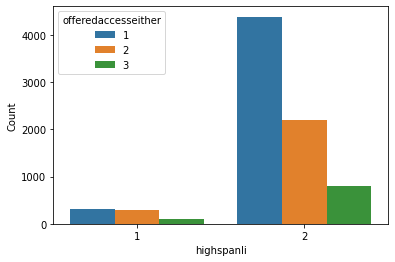

observed data:
 offeredaccesseither     1     2    3
highspanli                          
1                     322   297  103
2                    4389  2198  805
expected data:
 [[ 419.19423219  222.01010599   80.79566182]
 [4291.80576781 2272.98989401  827.20433818]]
chi-squared value: 59.2387 for 2 dof; p-value = 0.0000



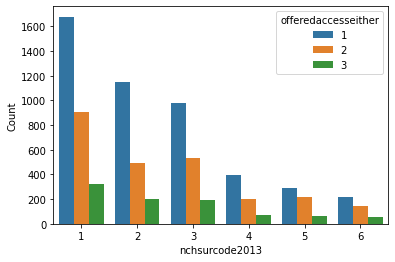

observed data:
 offeredaccesseither     1    2    3
nchsurcode2013                     
1                    1679  909  323
2                    1146  495  198
3                     979  534  192
4                     396  198   73
5                     292  214   66
6                     219  145   56
expected data:
 [[1690.13076165  895.11276806  325.7564703 ]
 [1067.72602909  565.48003451  205.79393641]
 [ 989.92543752  524.27594281  190.79861967]
 [ 387.26115356  205.0979788    74.64086764]
 [ 332.10401775  175.88612275   64.0098595 ]
 [ 243.85260044  129.14715307   47.00024649]]
chi-squared value: 35.2833 for 10 dof; p-value = 0.0001



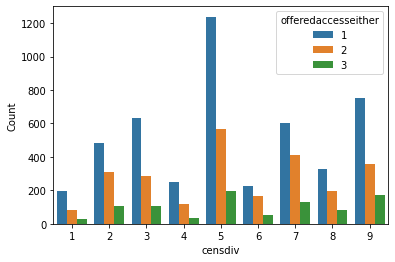

observed data:
 offeredaccesseither     1    2    3
censdiv                            
1                     195   80   28
2                     481  312  106
3                     632  288  106
4                     251  119   37
5                    1238  567  197
6                     226  168   52
7                     603  409  128
8                     330  197   82
9                     755  355  172
expected data:
 [[ 175.92223318   93.17044614   33.90732068]
 [ 521.96068524  276.43640621  100.60290855]
 [ 595.6970668   315.48804535  114.81488785]
 [ 236.30478186  125.14974119   45.54547695]
 [1162.36406211  615.60142963  224.03450826]
 [ 258.94823761  137.14197683   49.90978556]
 [ 661.88562978  350.54227262  127.57209761]
 [ 353.58627064  187.26337195   68.15035741]
 [ 744.33103278  394.20631008  143.46265714]]
chi-squared value: 73.9986 for 16 dof; p-value = 0.0000



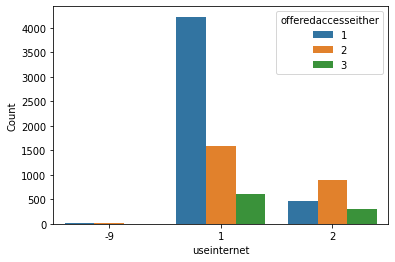

observed data:
 offeredaccesseither     1     2    3
useinternet                         
-9                     19    11    2
 1                   4225  1596  598
 2                    467   888  308
expected data:
 [[1.85792457e+01 9.83978309e+00 3.58097116e+00]
 [3.72688058e+03 1.97379899e+03 7.18320434e+02]
 [9.65540177e+02 5.11361228e+02 1.86098595e+02]]
chi-squared value: 774.5609 for 4 dof; p-value = 0.0000



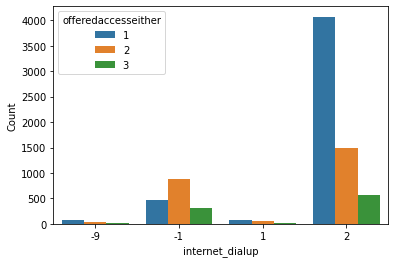

observed data:
 offeredaccesseither     1     2    3
internet_dialup                     
-9                     74    36   17
-1                    467   888  308
 1                     80    63   21
 2                   4071  1497  560
expected data:
 [[  73.72976986   39.03340757   14.23682257]
 [ 965.45360059  511.12249443  186.42390497]
 [  95.21009651   50.40534521   18.38455828]
 [3557.60653304 1883.43875278  686.95471418]]
chi-squared value: 798.0834 for 6 dof; p-value = 0.0000



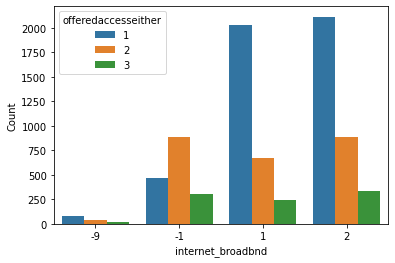

observed data:
 offeredaccesseither     1    2    3
internet_broadbnd                  
-9                     82   39   19
-1                    467  888  308
 1                   2030  669  244
 2                   2113  888  335
expected data:
 [[  81.27691166   43.02895323   15.69413512]
 [ 965.45360059  511.12249443  186.42390497]
 [1708.55679287  904.53006682  329.91314031]
 [1936.71269488 1025.31848552  373.9688196 ]]
chi-squared value: 798.2793 for 6 dof; p-value = 0.0000



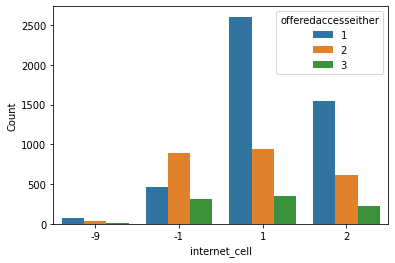

observed data:
 offeredaccesseither     1    2    3
internet_cell                      
-9                     77   41   15
-1                    467  888  308
 1                   2604  939  357
 2                   1544  616  226
expected data:
 [[  77.21306607   40.87750557   14.90942836]
 [ 965.45360059  511.12249443  186.42390497]
 [2264.14253898 1198.6636971   437.19376392]
 [1385.19079436  733.3363029   267.47290275]]
chi-squared value: 779.9113 for 6 dof; p-value = 0.0000



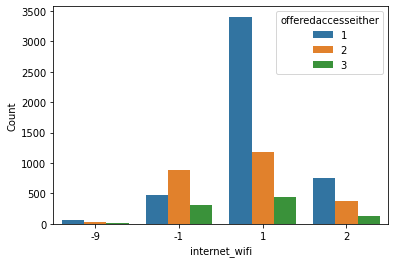

observed data:
 offeredaccesseither     1     2    3
internet_wifi                       
-9                     67    39   17
-1                    467   888  308
 1                   3404  1177  447
 2                    754   380  134
expected data:
 [[  71.40757238   37.80400891   13.78841871]
 [ 965.45360059  511.12249443  186.42390497]
 [2919.00222717 1545.35412027  563.64365256]
 [ 736.13659985  389.71937639  142.14402376]]
chi-squared value: 809.2480 for 6 dof; p-value = 0.0000



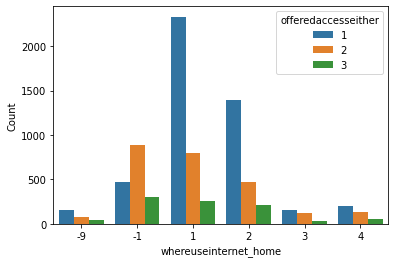

observed data:
 offeredaccesseither       1    2    3
whereuseinternet_home                
-9                      153   81   41
-1                      467  888  308
 1                     2329  798  254
 2                     1390  466  210
 3                      153  117   33
 4                      196  132   59
expected data:
 [[ 159.65325077   84.52631579   30.82043344]
 [ 965.46674923  511.15368421  186.37956656]
 [1962.86414861 1039.21263158  378.92321981]
 [1199.43133127  635.02315789  231.54551084]
 [ 175.90885449   93.13263158   33.95851393]
 [ 224.67566563  118.95157895   43.37275542]]
chi-squared value: 880.9230 for 10 dof; p-value = 0.0000



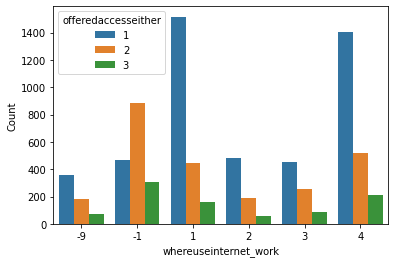

observed data:
 offeredaccesseither       1    2    3
whereuseinternet_work                
-9                      357  183   75
-1                      467  888  308
 1                     1516  449  160
 2                      482  193   61
 3                      456  255   90
 4                     1408  516  211
expected data:
 [[ 356.89040248  189.18390093   68.92569659]
 [ 965.05486068  511.56557276  186.37956656]
 [1233.15789474  653.68421053  238.15789474]
 [ 427.10786378  226.40544892   82.48668731]
 [ 464.82798762  246.40049536   89.77151703]
 [1238.96099071  656.76037152  239.27863777]]
chi-squared value: 843.3769 for 10 dof; p-value = 0.0000



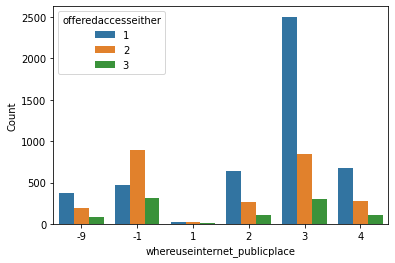

observed data:
 offeredaccesseither              1    2    3
whereuseinternet_publicplace                
-9                             377  188   78
-1                             467  888  308
 1                              25   23    7
 2                             634  263  103
 3                            2504  841  301
 4                             677  279  109
expected data:
 [[ 373.11843409  197.71134787   72.17021804]
 [ 965.00148662  511.34365709  186.65485629]
 [  31.91526264   16.91154609    6.17319128]
 [ 580.27750248  307.4826561   112.23984143]
 [2115.69177403 1121.08176412  409.22646184]
 [ 617.99554014  327.46902874  119.53543112]]
chi-squared value: 813.8921 for 10 dof; p-value = 0.0000



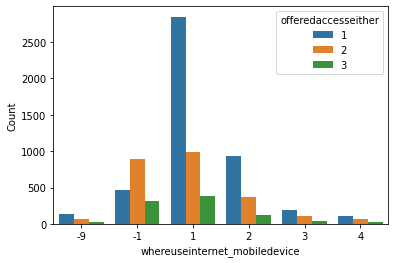

observed data:
 offeredaccesseither               1    2    3
whereuseinternet_mobiledevice                
-9                              133   63   31
-1                              467  888  308
 1                             2847  986  383
 2                              937  374  124
 3                              194  104   35
 4                              111   68   24
expected data:
 [[ 131.78197351   69.78345921   25.43456729]
 [ 965.43357682  511.2330073   186.33341587]
 [2447.54537576 1296.06636127  472.38826297]
 [ 833.07106599  441.14213198  160.78680203]
 [ 193.3189303   102.36956791   37.3115018 ]
 [ 117.84907763   62.40547233   22.74545004]]
chi-squared value: 805.3592 for 10 dof; p-value = 0.0000



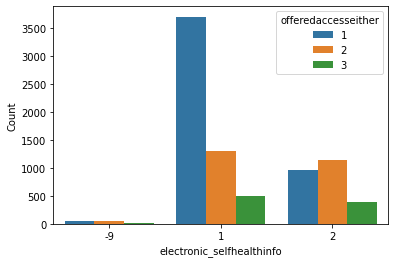

observed data:
 offeredaccesseither           1     2    3
electronic_selfhealthinfo                 
-9                           51    44   15
 1                         3697  1303  498
 2                          963  1148  395
expected data:
 [[  63.86615726   33.82425438   12.30958837]
 [3192.14666009 1690.59773231  615.25560759]
 [1454.98718265  770.57801331  280.43480404]]
chi-squared value: 595.3167 for 4 dof; p-value = 0.0000



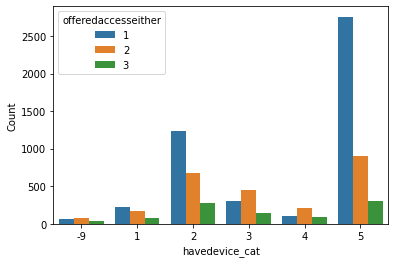

observed data:
 offeredaccesseither     1    2    3
havedevice_cat                     
-9                     70   78   32
 1                    228  167   72
 2                   1240  681  276
 3                    308  453  140
 4                    110  218   88
 5                   2755  898  300
expected data:
 [[ 104.50825733   55.34877989   20.14296278]
 [ 271.14086764  143.59933448   52.25979788]
 [1275.58134089  675.56260784  245.85605127]
 [ 523.12188809  277.05139265  100.82671925]
 [ 241.53019473  127.91718018   46.55262509]
 [2295.11745132 1215.52070495  442.36184373]]
chi-squared value: 658.8098 for 10 dof; p-value = 0.0000



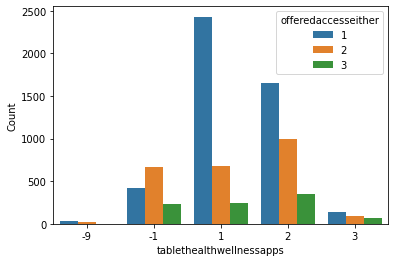

observed data:
 offeredaccesseither          1    2    3
tablethealthwellnessapps                
-9                          31   23    3
-1                         418  671  228
 1                        2429  675  246
 2                        1649  993  347
 3                         135   96   66
expected data:
 [[  33.1752809    17.49138577    6.33333333]
 [ 766.52359551  404.14307116  146.33333333]
 [1949.7752809  1028.00249688  372.22222222]
 [1739.66516854  917.22372035  332.11111111]
 [ 172.86067416   91.13932584   33.        ]]
chi-squared value: 718.8919 for 8 dof; p-value = 0.0000



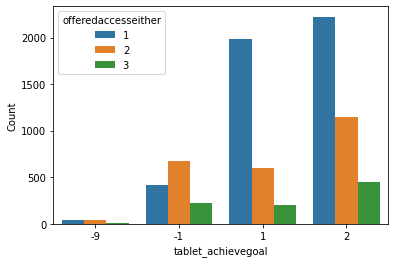

observed data:
 offeredaccesseither     1     2    3
tablet_achievegoal                  
-9                     42    38    7
-1                    418   671  228
 1                   1985   604  208
 2                   2223  1143  446
expected data:
 [[  50.68214152   26.66566829    9.65219019]
 [ 767.22276301  403.66304755  146.11418944]
 [1629.4017222   857.2859104   310.3123674 ]
 [2220.69337327 1168.38537377  422.92125296]]
chi-squared value: 576.9195 for 6 dof; p-value = 0.0000



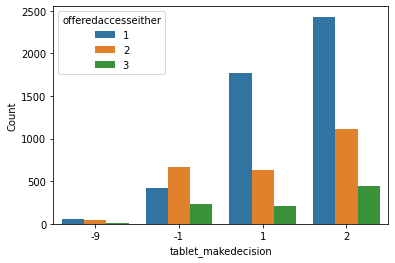

observed data:
 offeredaccesseither     1     2    3
tablet_makedecision                 
-9                     52    46    9
-1                    418   671  228
 1                   1769   632  209
 2                   2429  1108  442
expected data:
 [[  62.33320854   32.80906028   11.85773119]
 [ 767.22276301  403.82740547  145.94983152]
 [1520.4642456   800.29576937  289.23998502]
 [2317.97978285 1220.06776488  440.95245227]]
chi-squared value: 503.4428 for 6 dof; p-value = 0.0000



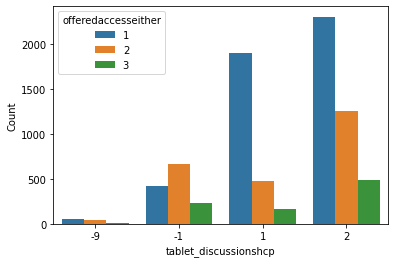

observed data:
 offeredaccesseither       1     2    3
tablet_discussionshcp                 
-9                       51    48    9
-1                      418   671  228
 1                     1898   481  165
 2                     2301  1257  486
expected data:
 [[  62.91576189   33.11568701   11.9685511 ]
 [ 767.22276301  403.82740547  145.94983152]
 [1482.01572445  780.05840509  281.92587046]
 [2355.84575066 1239.99850243  448.15574691]]
chi-squared value: 676.1443 for 6 dof; p-value = 0.0000



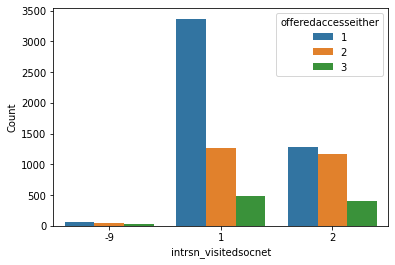

observed data:
 offeredaccesseither      1     2    3
intrsn_visitedsocnet                 
-9                      60    52   24
 1                    3369  1266  484
 2                    1282  1177  400
expected data:
 [[  78.96179443   41.81907814   15.21912743]
 [2972.09871826 1574.05780133  572.8434804 ]
 [1659.93948731  879.12312053  319.93739216]]
chi-squared value: 346.1865 for 4 dof; p-value = 0.0000



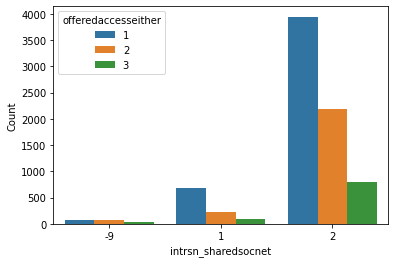

observed data:
 offeredaccesseither     1     2    3
intrsn_sharedsocnet                 
-9                     74    72   31
 1                    692   234   85
 2                   3945  2189  792
expected data:
 [[ 102.76645304   54.42630022   19.80724673]
 [ 586.98804535  310.87564703  113.13630762]
 [4021.2455016  2129.69805275  775.05644565]]
chi-squared value: 68.3132 for 4 dof; p-value = 0.0000



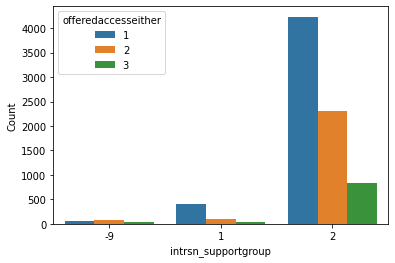

observed data:
 offeredaccesseither     1     2    3
intrsn_supportgroup                 
-9                     69    77   34
 1                    410   102   38
 2                   4232  2316  836
expected data:
 [[ 104.50825733   55.34877989   20.14296278]
 [ 319.3307863   169.12127188   61.54794183]
 [4287.16095637 2270.52994824  826.30909539]]
chi-squared value: 93.1934 for 4 dof; p-value = 0.0000



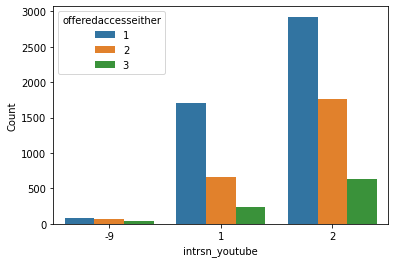

observed data:
 offeredaccesseither     1     2    3
intrsn_youtube                      
-9                     77    75   34
 1                   1711   664  235
 2                   2923  1756  639
expected data:
 [[ 107.99186591   57.19373922   20.81439487]
 [1515.36973133  802.55730836  292.07296032]
 [3087.63840276 1635.24895243  595.11264481]]
chi-squared value: 104.0516 for 4 dof; p-value = 0.0000



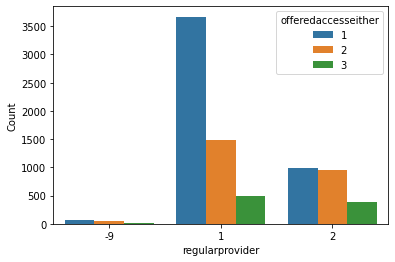

observed data:
 offeredaccesseither     1     2    3
regularprovider                     
-9                     61    58   23
 1                   3669  1485  498
 2                    981   952  387
expected data:
 [[  82.44540301   43.66403747   15.89055953]
 [3281.55928026 1737.95168844  632.4890313 ]
 [1346.99531674  713.38427409  259.62040917]]
chi-squared value: 366.3785 for 4 dof; p-value = 0.0000



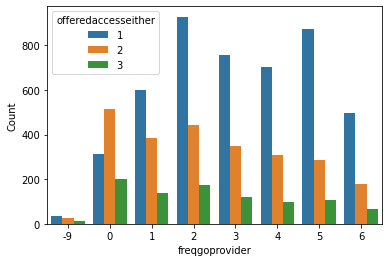

observed data:
 offeredaccesseither    1    2    3
freqgoprovider                    
-9                    37   28   13
 0                   314  515  199
 1                   599  386  136
 2                   928  441  175
 3                   756  350  119
 4                   704  309   96
 5                   875  288  105
 6                   498  178   65
expected data:
 [[ 45.28691151  23.98447128   8.7286172 ]
 [596.85826966 316.1030318  115.03869855]
 [650.85420261 344.6999014  125.44589598]
 [896.44860735 474.76953414 172.78185852]
 [711.23675129 376.67919645 137.08405226]
 [643.88698546 341.00998275 124.1030318 ]
 [736.20261277 389.90140498 141.89598225]
 [430.22565935 227.8524772   82.92186345]]
chi-squared value: 448.1900 for 14 dof; p-value = 0.0000



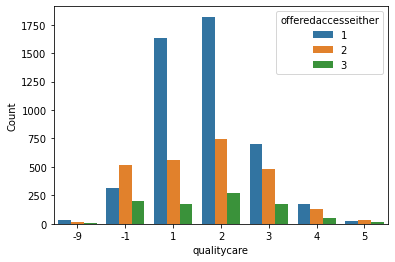

observed data:
 offeredaccesseither     1    2    3
qualitycare                        
-9                     33   20   11
-1                    314  515  199
 1                   1637  565  177
 2                   1820  749  273
 3                    700  481  177
 4                    177  129   54
 5                     25   33   15
expected data:
 [[  37.16485686   19.68015795    7.15498519]
 [ 596.96051333  316.11253702  114.92694965]
 [1381.48741362  731.54837117  265.9642152 ]
 [1650.35192498  873.92201382  317.7260612 ]
 [ 788.59180652  417.58835143  151.81984205]
 [ 209.05231984  110.70088845   40.24679171]
 [  42.39116486   22.44768016    8.16115499]]
chi-squared value: 534.0466 for 12 dof; p-value = 0.0000



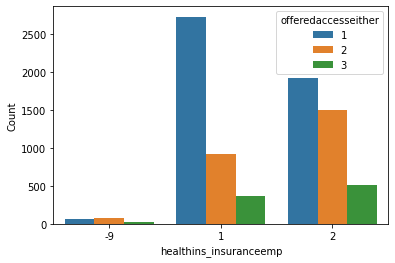

observed data:
 offeredaccesseither        1     2    3
healthins_insuranceemp                 
-9                        65    75   22
 1                      2724   924  372
 2                      1922  1496  514
expected data:
 [[  94.0574316   49.8139019   18.1286665]
 [2334.0177471 1236.1227508  449.8595021]
 [2282.9248213 1209.0633473  440.0118314]]
chi-squared value: 317.5840 for 4 dof; p-value = 0.0000



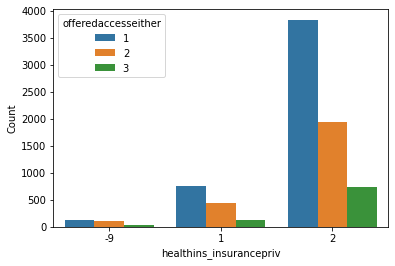

observed data:
 offeredaccesseither         1     2    3
healthins_insurancepriv                 
-9                        122   111   34
 1                        751   446  137
 2                       3838  1938  737
expected data:
 [[ 155.02058171   82.10069017   29.87872812]
 [ 774.52230712  410.1959576   149.28173527]
 [3781.45711117 2002.70335223  728.8395366 ]]
chi-squared value: 25.6519 for 4 dof; p-value = 0.0000



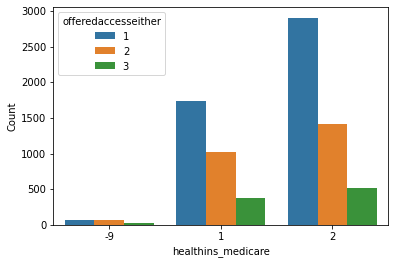

observed data:
 offeredaccesseither     1     2    3
healthins_medicare                  
-9                     66    63   20
 1                   1739  1021  377
 2                   2906  1411  511
expected data:
 [[  86.50961301   45.81649002   16.67389697]
 [1821.34668474  964.60623614  351.04707912]
 [2803.14370224 1484.57727385  540.27902391]]
chi-squared value: 29.9167 for 4 dof; p-value = 0.0000



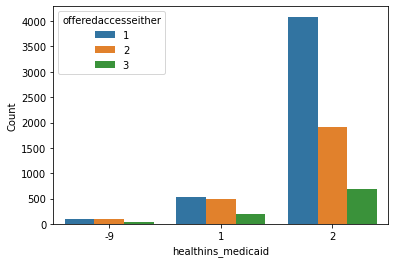

observed data:
 offeredaccesseither     1     2    3
healthins_medicaid                  
-9                    105    92   33
 1                    521   497  186
 2                   4085  1906  689
expected data:
 [[ 133.53832881   70.72344097   25.73823022]
 [ 699.04412127  370.2218388   134.73403993]
 [3878.41754991 2054.05472024  747.52772985]]
chi-squared value: 149.0737 for 4 dof; p-value = 0.0000



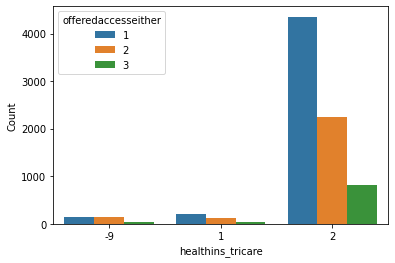

observed data:
 offeredaccesseither     1     2    3
healthins_tricare                   
-9                    141   140   47
 1                    217   116   35
 2                   4353  2239  826
expected data:
 [[ 190.43726892  100.85777668   36.7049544 ]
 [ 213.6613261   113.15750555   41.18116835]
 [4306.90140498 2280.98471777  830.11387725]]
chi-squared value: 33.2502 for 4 dof; p-value = 0.0000



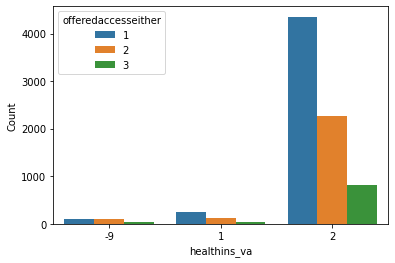

observed data:
 offeredaccesseither     1     2    3
healthins_va                        
-9                    101   101   35
 1                    258   134   50
 2                   4352  2260  823
expected data:
 [[ 137.60253882   72.87589352   26.52156766]
 [ 256.6258319   135.91200394   49.46216416]
 [4316.77162928 2286.21210254  832.01626818]]
chi-squared value: 24.0262 for 4 dof; p-value = 0.0001



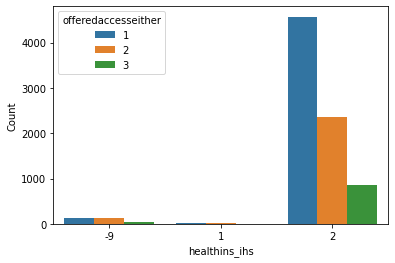

observed data:
 offeredaccesseither     1     2    3
healthins_ihs                       
-9                    120   126   40
 1                     19    12    6
 2                   4572  2357  862
expected data:
 [[1.66052009e+02 8.79430614e+01 3.20049298e+01]
 [2.14822529e+01 1.13772492e+01 4.14049790e+00]
 [4.52346574e+03 2.39567969e+03 8.71854572e+02]]
chi-squared value: 33.6507 for 4 dof; p-value = 0.0000



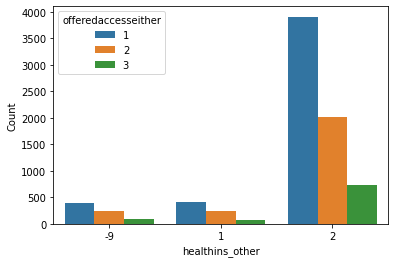

observed data:
 offeredaccesseither     1     2    3
healthins_other                     
-9                    395   249   99
 1                    410   237   82
 2                   3906  2009  727
expected data:
 [[ 431.38686221  228.46746364   83.14567414]
 [ 423.2584422   224.16255854   81.57899926]
 [3856.35469559 2042.36997782  743.2753266 ]]
chi-squared value: 10.6310 for 4 dof; p-value = 0.0310



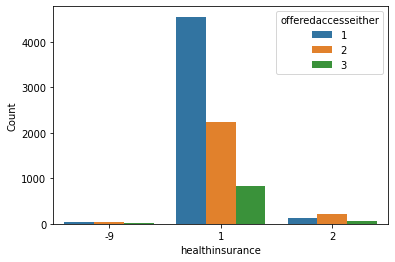

observed data:
 offeredaccesseither     1     2    3
healthinsurance                     
-9                     37    34   10
 1                   4556  2245  832
 2                    118   216   66
expected data:
 [[  47.0287158    24.90695095    9.06433325]
 [4431.73071235 2347.09576041  854.17352724]
 [ 232.24057185  122.99728864   44.76213951]]
chi-squared value: 150.6510 for 4 dof; p-value = 0.0000



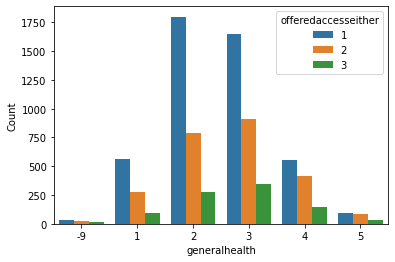

observed data:
 offeredaccesseither     1    2    3
generalhealth                      
-9                     32   22   15
 1                    567  275   92
 2                   1799  785  278
 3                   1649  912  342
 4                    558  412  144
 5                     97   85   34
expected data:
 [[  40.06396641   21.22487034    7.71116325]
 [ 542.31513954  287.30476661  104.38009385]
 [1661.78365028  880.37070882  319.8456409 ]
 [1685.58977525  892.98258829  324.42763645]
 [ 646.82983453  342.67399358  124.49617189]
 [ 125.41763398   66.44307236   24.13929365]]
chi-squared value: 85.8771 for 10 dof; p-value = 0.0000



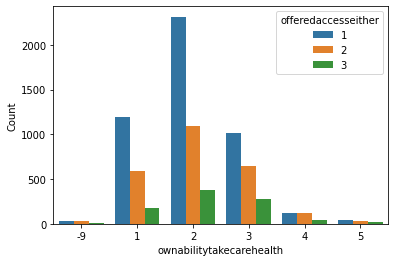

observed data:
 offeredaccesseither          1     2    3
ownabilitytakecarehealth                 
-9                          31    26   14
 1                        1191   586  178
 2                        2314  1090  374
 3                        1010   642  272
 4                         125   116   46
 5                          39    30   24
expected data:
 [[  41.24444993   21.80439073    7.95115935]
 [1135.67464233  600.38850518  218.93685249]
 [2194.66946226 1160.23926986  423.09126788]
 [1117.66650222  590.86827824  215.46521954]
 [ 166.72052294   88.13887519   32.14060187]
 [  54.02442033   28.56068081   10.41489887]]
chi-squared value: 111.9096 for 10 dof; p-value = 0.0000



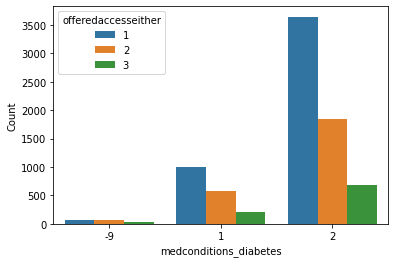

observed data:
 offeredaccesseither        1     2    3
medconditions_diabetes                 
-9                        73    62   26
 1                       995   585  205
 2                      3643  1848  677
expected data:
 [[  93.47683017   49.50640868   18.01676115]
 [1036.37355189  548.87540054  199.75104757]
 [3581.14961794 1896.61819078  690.23219127]]
chi-squared value: 17.9113 for 4 dof; p-value = 0.0013



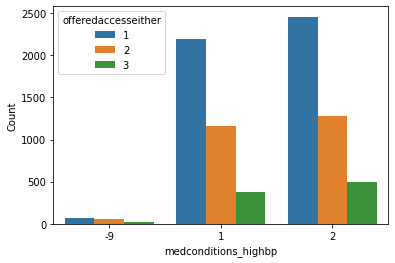

observed data:
 offeredaccesseither      1     2    3
medconditions_highbp                 
-9                      69    54   25
 1                    2187  1166  384
 2                    2455  1275  499
expected data:
 [[  85.92901158   45.5089968    16.56199162]
 [2169.70754252 1149.10216909  418.19028839]
 [2455.3634459  1300.38883411  473.24771999]]
chi-squared value: 14.2972 for 4 dof; p-value = 0.0064



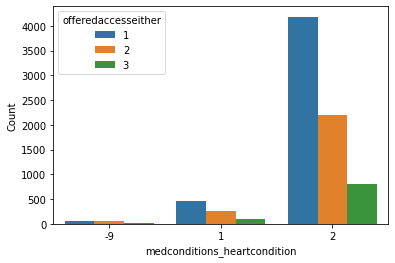

observed data:
 offeredaccesseither              1     2    3
medconditions_heartcondition                 
-9                              58    49   23
 1                             471   256   89
 2                            4182  2190  796
expected data:
 [[  75.47818585   39.97411881   14.54769534]
 [ 473.77076658  250.91446882   91.3147646 ]
 [4161.75104757 2204.11141237  802.13754005]]
chi-squared value: 11.4100 for 4 dof; p-value = 0.0223



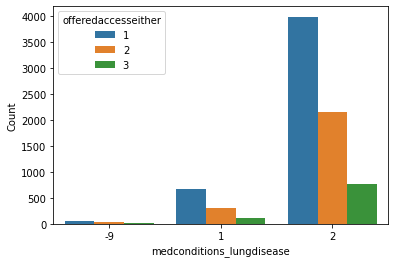

observed data:
 offeredaccesseither           1     2    3
medconditions_lungdisease                 
-9                           55    38   25
 1                          666   310  109
 2                         3990  2147  774
expected data:
 [[  68.5109687    36.28420015   13.20483116]
 [ 629.95255115  333.63014543  121.41730343]
 [4012.53648016 2125.08565442  773.37786542]]
chi-squared value: 18.6410 for 4 dof; p-value = 0.0009



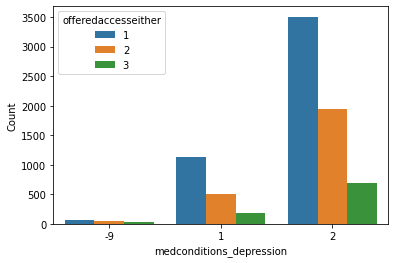

observed data:
 offeredaccesseither          1     2    3
medconditions_depression                 
-9                          70    50   32
 1                        1134   502  178
 2                        3507  1943  698
expected data:
 [[  88.2514173    46.73896968   17.00961301]
 [1053.21099334  557.79270397  202.99630269]
 [3569.53758935 1890.46832635  687.9940843 ]]
chi-squared value: 34.7696 for 4 dof; p-value = 0.0000



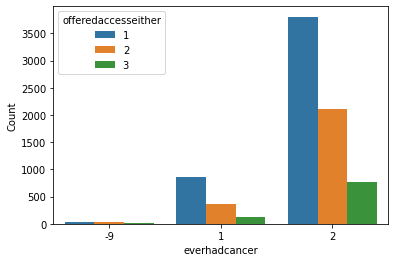

observed data:
 offeredaccesseither     1     2    3
everhadcancer                       
-9                     37    28   15
 1                    867   361  130
 2                   3807  2106  763
expected data:
 [[  46.44811437   24.59945773    8.9524279 ]
 [ 788.45674143  417.57579492  151.96746364]
 [3876.0951442  2052.82474735  747.08010845]]
chi-squared value: 28.0905 for 4 dof; p-value = 0.0000



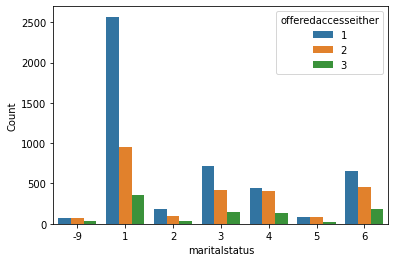

observed data:
 offeredaccesseither     1    2    3
maritalstatus                      
-9                     67   72   32
 1                   2568  949  361
 2                    183   98   38
 3                    711  424  142
 4                    438  405  128
 5                     84   80   24
 6                    657  458  179
expected data:
 [[  99.41565819   52.495184     19.08915782]
 [2254.58434181 1190.504816    432.91084218]
 [ 185.45961966   97.92961225   35.61076809]
 [ 742.41985675  392.02543838  142.55470487]
 [ 564.51815263  298.08668807  108.3951593 ]
 [ 109.29908619   57.71400346   20.98691035]
 [ 752.30328476  397.24425784  144.4524574 ]]
chi-squared value: 249.9556 for 12 dof; p-value = 0.0000



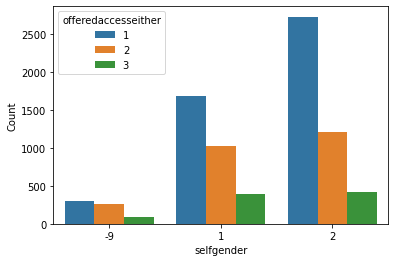

observed data:
 offeredaccesseither     1     2    3
selfgender                          
-9                    295   258   96
 1                   1687  1024  398
 2                   2729  1213  413
expected data:
 [[ 376.85677308  199.58769876   72.55552816]
 [1805.31233822  956.11426106  347.57340071]
 [2528.8308887  1339.29804018  486.87107112]]
chi-squared value: 101.3031 for 4 dof; p-value = 0.0000



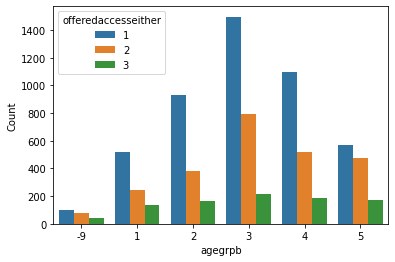

observed data:
 offeredaccesseither     1    2    3
agegrpb                            
-9                     97   81   39
 1                    517  243  133
 2                    931  380  163
 3                   1497  794  212
 4                   1100  520  190
 5                    568  474  170
expected data:
 [[ 126.04143544   66.68689111   24.27167345]
 [ 518.68664447  274.43038599   99.88296954]
 [ 856.15242323  452.97915896  164.86841781]
 [1453.83277839  769.20409422  279.96312739]
 [1051.31335553  556.23628068  202.45036379]
 [ 703.97336293  372.46318905  135.56344802]]
chi-squared value: 138.2601 for 10 dof; p-value = 0.0000



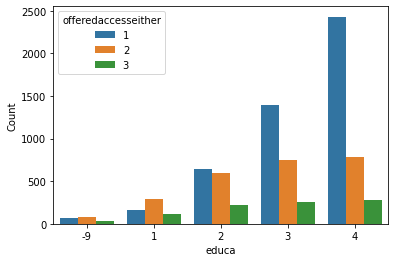

observed data:
 offeredaccesseither     1    2    3
educa                              
-9                     69   77   33
 1                    164  289  113
 2                    648  598  225
 3                   1398  748  257
 4                   2432  783  280
expected data:
 [[ 103.9276559    55.04128667   20.03105743]
 [ 328.62040917  174.04116342   63.33842741]
 [ 854.06470298  452.32252896  164.61276806]
 [1395.1852354   738.90621149  268.90855312]
 [2029.20199655 1074.68880947  391.10919399]]
chi-squared value: 536.3558 for 8 dof; p-value = 0.0000



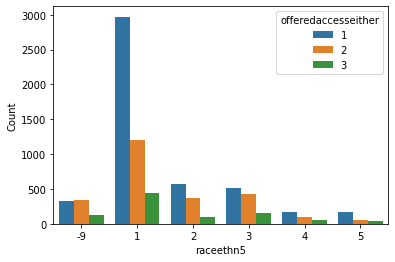

observed data:
 offeredaccesseither     1     2    3
raceethn5                           
-9                    322   341  127
 1                   2972  1205  441
 2                    566   368   91
 3                    514   430  155
 4                    172    95   56
 5                    165    56   38
expected data:
 [[ 458.67512941  242.91964506   88.40522554]
 [2681.21740202 1420.00369731  516.77890067]
 [ 595.11646537  315.18055213  114.7029825 ]
 [ 638.08097116  337.93505053  122.98397831]
 [ 187.53426177   99.32031057   36.14542766]
 [ 150.37577027   79.64074439   28.98348533]]
chi-squared value: 268.7226 for 10 dof; p-value = 0.0000



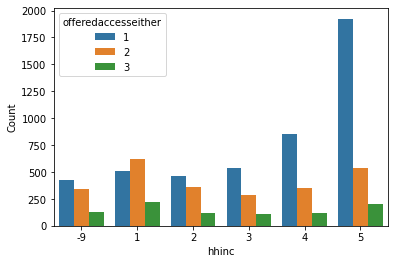

observed data:
 offeredaccesseither     1    2    3
hhinc                              
-9                    423  340  132
 1                    506  625  225
 2                    466  363  121
 3                    539  283  111
 4                    853  350  117
 5                   1924  534  202
expected data:
 [[ 519.63827952  275.20643333  100.15528716]
 [ 787.29553858  416.96080848  151.74365295]
 [ 551.57135815  292.11856051  106.31008134]
 [ 541.70113384  286.89117575  104.40769041]
 [ 766.39388711  405.8910525   147.71506039]
 [1544.39980281  817.93196944  297.66822775]]
chi-squared value: 562.4907 for 10 dof; p-value = 0.0000



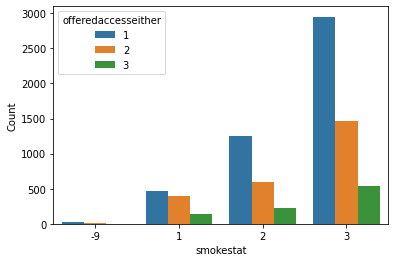

observed data:
 offeredaccesseither     1     2    3
smokestat                           
-9                     20     8    3
 1                    461   396  133
 2                   1246   600  226
 3                   2952  1464  532
expected data:
 [[  18.03867678    9.51473697    3.44658625]
 [ 576.07387141  303.85772914  110.06839945]
 [1205.68188036  635.9527422   230.36537744]
 [2879.20557145 1518.67479169  550.11963686]]
chi-squared value: 64.0870 for 6 dof; p-value = 0.0000



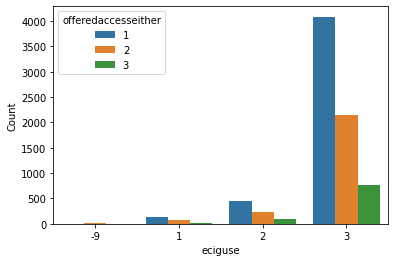

observed data:
 offeredaccesseither     1     2    3
eciguse                             
-9                      3     7    1
 1                    136    78   23
 2                    456   225   95
 3                   4087  2157  770
expected data:
 [[6.40731525e+00 3.37608858e+00 1.21659617e+00]
 [1.38048520e+02 7.27393630e+01 2.62121174e+01]
 [4.52006967e+02 2.38167703e+02 8.58253297e+01]
 [4.08553720e+03 2.15271684e+03 7.75745957e+02]]
chi-squared value: 8.3406 for 6 dof; p-value = 0.2142



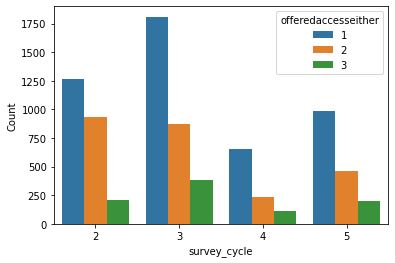

observed data:
 offeredaccesseither     1    2    3
survey_cycle                       
2                    1264  930  210
3                    1809  869  387
4                     650  234  115
5                     988  462  196
expected data:
 [[1395.76583683  739.21370471  269.02045847]
 [1779.54338181  942.46672418  342.98989401]
 [ 580.0208282   307.18572837  111.79344343]
 [ 955.66995317  506.13384274  184.19620409]]
chi-squared value: 118.1596 for 6 dof; p-value = 0.0000



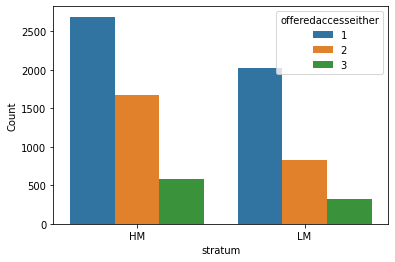

observed data:
 offeredaccesseither     1     2    3
stratum                             
HM                   2688  1669  583
LM                   2023   826  325
expected data:
 [[2868.17106236 1519.01651467  552.81242297]
 [1842.82893764  975.98348533  355.18757703]]
chi-squared value: 71.0046 for 2 dof; p-value = 0.0000



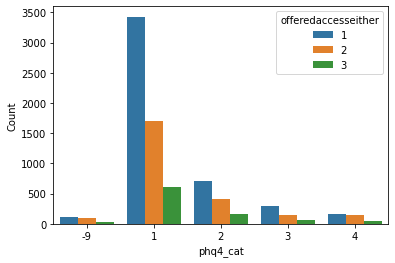

observed data:
 offeredaccesseither     1     2    3
phq4_cat                            
-9                    106    96   31
 1                   3428  1698  610
 2                    710   410  161
 3                    289   147   60
 4                    172   142   45
expected data:
 [[ 135.25786552   71.66798273   26.07415176]
 [3329.78161629 1764.32424429  641.89413942]
 [ 743.6280074   394.02011104  143.35188155]
 [ 287.93090685  152.56360271   55.50549044]
 [ 208.40160395  110.42405922   40.17433683]]
chi-squared value: 43.3749 for 8 dof; p-value = 0.0000



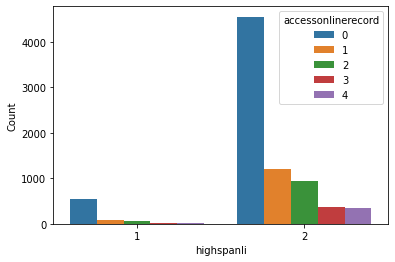

observed data:
 accessonlinerecord     0     1    2    3    4
highspanli                                   
1                    545    83   56   23   15
2                   4550  1206  931  365  340
expected data:
 [[ 453.36332265  114.69780626   87.82524033   34.52501849   31.58861228]
 [4641.63667735 1174.30219374  899.17475967  353.47498151  323.41138772]]
chi-squared value: 56.3912 for 4 dof; p-value = 0.0000



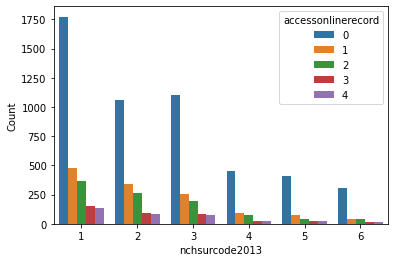

observed data:
 accessonlinerecord     0    1    2    3    4
nchsurcode2013                              
1                   1773  482  368  156  132
2                   1056  339  264   93   87
3                   1101  253  197   80   74
4                    452   96   74   23   22
5                    408   75   45   21   23
6                    305   44   39   15   17
expected data:
 [[1827.89561252  462.44503328  354.09871826  139.1999014   127.36073453]
 [1154.75782598  292.14579739  223.69891545   87.93837811   80.45908307]
 [1070.61560266  270.8583929   207.3989401    81.5306877    74.59637663]
 [ 418.82733547  105.96043875   81.13495193   31.8949963    29.18227754]
 [ 359.1742667    90.86862213   69.57899926   27.35223071   25.02588119]
 [ 263.72935667   66.72171555   51.08947498   20.08380577   18.37564703]]
chi-squared value: 78.4732 for 20 dof; p-value = 0.0000



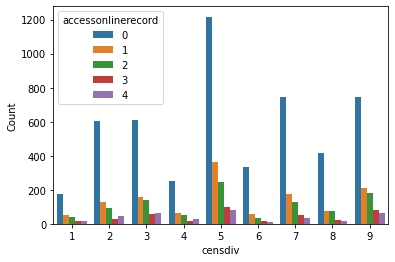

observed data:
 accessonlinerecord     0    1    2   3   4
censdiv                                   
1                    178   51   41  15  18
2                    603  130   92  31  43
3                    608  159  139  58  62
4                    253   61   49  18  26
5                   1217  363  246  97  79
6                    331   59   33  14   9
7                    745  176  130  54  35
8                    417   77   75  22  18
9                    743  213  182  79  65
expected data:
 [[ 190.26189302   48.13495193   36.85740695   14.4890313    13.25671679]
 [ 564.50640868  142.81624353  109.35580478   42.98890806   39.33263495]
 [ 644.25314272  162.99161942  124.80428888   49.06186838   44.8890806 ]
 [ 255.56630515   64.6565196    49.50813409   19.46216416   17.806877  ]
 [1257.10993345  318.04017747  243.52649741   95.73280749   87.59058418]
 [ 280.0554597    70.85210747   54.25215677   21.32708898   19.51318708]
 [ 715.83682524  181.10179936  138.67143209   54.51318708

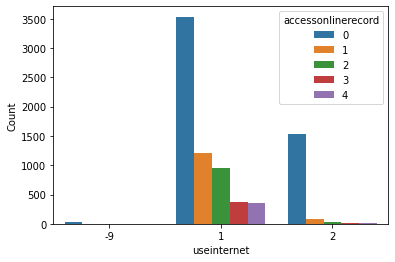

observed data:
 accessonlinerecord     0     1    2    3    4
useinternet                                  
-9                    24     4    1    3    0
 1                  3534  1208  954  374  349
 2                  1537    77   32   11    6
expected data:
 [[2.00936653e+01 5.08355928e+00 3.89253143e+00 1.53019473e+00
  1.40004930e+00]
 [4.03066367e+03 1.01973022e+03 7.80817476e+02 3.06947498e+02
  2.80841139e+02]
 [1.04424267e+03 2.64186221e+02 2.02289993e+02 7.95223071e+01
  7.27588119e+01]]
chi-squared value: 800.3122 for 8 dof; p-value = 0.0000



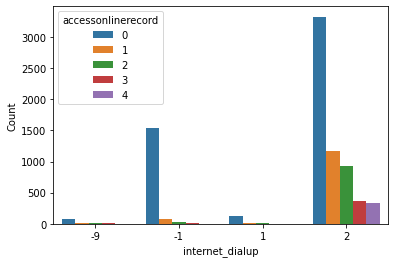

observed data:
 accessonlinerecord     0     1    2    3    4
internet_dialup                              
-9                    82    20   14    7    4
-1                  1537    77   32   11    6
 1                   127    18   12    2    5
 2                  3325  1170  928  365  340
expected data:
 [[  79.68535016   20.19240287   15.49393714    6.0498639     5.57844593]
 [1043.43887652  264.4091809   202.88517694   79.21987132   73.04689433]
 [ 102.90076714   26.0752289    20.00791883    7.81242267    7.20366246]
 [3844.97500619  974.32318733  747.61296709  291.91784212  269.17099728]]
chi-squared value: 837.7466 for 12 dof; p-value = 0.0000



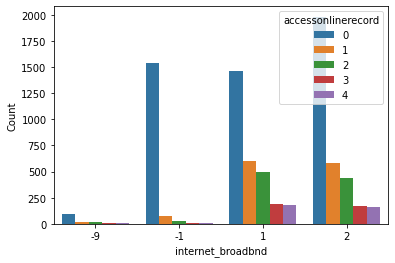

observed data:
 accessonlinerecord     0    1    2    3    4
internet_broadbnd                           
-9                    90   22   16    8    4
-1                  1537   77   32   11    6
 1                  1463  605  500  193  182
 2                  1981  581  438  173  163
expected data:
 [[  87.84211829   22.25934175   17.07993071    6.6691413     6.14946795]
 [1043.43887652  264.4091809   202.88517694   79.21987132   73.04689433]
 [1846.56681514  467.92316258  359.04454343  140.19487751  129.27060134]
 [2093.15219005  530.40831477  406.99034892  158.91610987  146.53303638]]
chi-squared value: 864.5157 for 12 dof; p-value = 0.0000



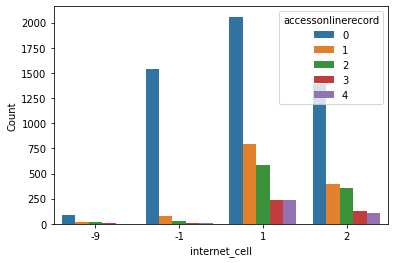

observed data:
 accessonlinerecord     0    1    2    3    4
internet_cell                               
-9                    87   20   15    8    3
-1                  1537   77   32   11    6
 1                  2058  790  583  234  235
 2                  1389  398  356  132  111
expected data:
 [[  83.45001237   21.14637466   16.22593417    6.33568424    5.84199456]
 [1043.43887652  264.4091809   202.88517694   79.21987132   73.04689433]
 [2447.03043801  620.08166295  475.79806978  185.78322197  171.30660728]
 [1497.0806731   379.36278149  291.0908191   113.66122247  104.80450384]]
chi-squared value: 827.9159 for 12 dof; p-value = 0.0000



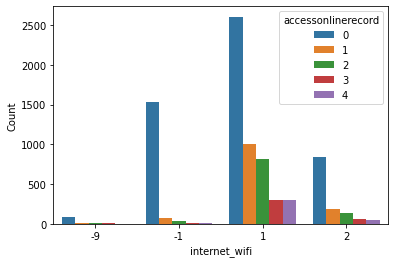

observed data:
 accessonlinerecord     0     1    2    3    4
internet_wifi                                
-9                    84    17   12    7    3
-1                  1537    77   32   11    6
 1                  2607  1009  811  306  295
 2                   843   182  131   61   51
expected data:
 [[  77.17557535   19.55642168   15.00593912    5.859317      5.40274684]
 [1043.43887652  264.4091809   202.88517694   79.21987132   73.04689433]
 [3154.78693393  799.42835932  613.41351151  239.51744618  220.85374907]
 [ 795.5986142   201.60603811  154.69537243   60.4033655    55.69660975]]
chi-squared value: 899.1525 for 12 dof; p-value = 0.0000



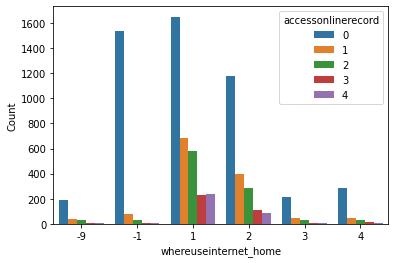

observed data:
 accessonlinerecord        0    1    2    3    4
whereuseinternet_home                          
-9                      193   37   28    8    9
-1                     1537   77   32   11    6
 1                     1650  682  578  234  237
 2                     1182  397  289  109   89
 3                      215   46   28    6    8
 4                      289   45   30   17    6
expected data:
 [[ 172.52631579   43.72755418   33.54489164   13.11145511   12.08978328]
 [1043.31368421  264.43244582  202.85510836   79.28854489   73.11021672]
 [2121.13263158  537.61040248  412.41919505  161.1993808   148.63839009]
 [1296.14315789  328.51318885  252.01362229   98.50278638   90.82724458]
 [ 190.09263158   48.17981424   36.96037152   14.44643963   13.32074303]
 [ 242.79157895   61.53659443   47.20681115   18.45139319   17.01362229]]
chi-squared value: 1003.5209 for 20 dof; p-value = 0.0000



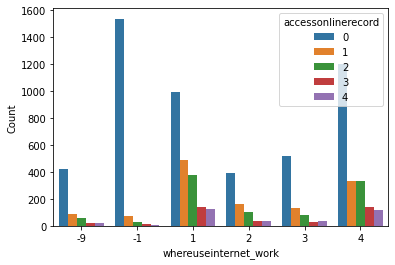

observed data:
 accessonlinerecord        0    1    2    3    4
whereuseinternet_work                          
-9                      420   87   59   24   25
-1                     1537   77   32   11    6
 1                      994  490  376  137  128
 2                      393  164  102   40   37
 3                      520  133   78   32   38
 4                     1205  332  336  141  121
expected data:
 [[ 386.06006192   97.71455108   74.86625387   29.32198142   27.0371517 ]
 [1043.93151703  264.22650155  202.44321981   79.28854489   73.11021672]
 [1333.94736842  337.63157895  258.68421053  101.31578947   93.42105263]
 [ 462.01659443  116.9396904    89.59603715   35.09102167   32.35665635]
 [ 502.8196904   127.26724458   97.50873065   38.19009288   35.21424149]
 [1340.2247678   339.22043344  259.90154799  101.79256966   93.86068111]]
chi-squared value: 969.3949 for 20 dof; p-value = 0.0000



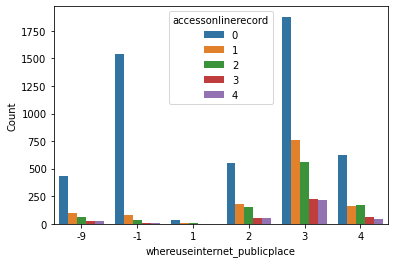

observed data:
 accessonlinerecord               0    1    2    3    4
whereuseinternet_publicplace                          
-9                             435   95   62   23   28
-1                            1537   77   32   11    6
 1                              38    9    6    1    1
 2                             554  180  154   57   55
 3                            1877  762  563  227  217
 4                             626  160  168   65   46
expected data:
 [[ 403.6274777   102.20131318   78.46320614   30.58870168   28.11930129]
 [1043.90745788  264.32470268  202.9305005    79.11199207   72.72534688]
 [  34.52490089    8.74194747    6.71147175    2.61645193    2.40522795]
 [ 627.72547076  158.9444995   122.02675917   47.57185332   43.73141724]
 [2288.6870664   579.51164519  444.90956392  173.44697721  159.44474727]
 [ 668.52762636  169.27589197  129.95849851   50.66402379   46.57395937]]
chi-squared value: 883.2286 for 20 dof; p-value = 0.0000



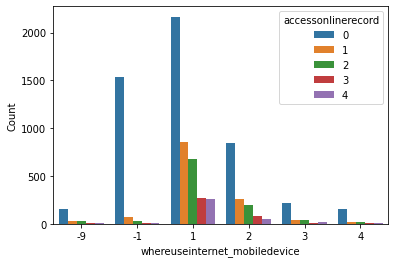

observed data:
 accessonlinerecord                0    1    2    3    4
whereuseinternet_mobiledevice                          
-9                              152   31   27   11    6
-1                             1537   77   32   11    6
 1                             2164  852  673  266  261
 2                              843  262  197   78   55
 3                              220   44   40   12   17
 4                              152   19   17    6    9
expected data:
 [[ 142.43357682   36.1142751    27.71103132   10.79212579    9.94899096]
 [1043.46712888  264.57286121  203.01077133   79.06301845   72.88622013]
 [2645.37427263  670.73913582  514.66831744  200.43877677  184.77949734]
 [ 900.40609137  228.29949239  175.17766497   68.22335025   62.89340102]
 [ 208.94441005   52.97820973   40.65098428   15.83162065   14.59477529]
 [ 127.37452024   32.29602575   24.78123065    9.65110808    8.89711527]]
chi-squared value: 902.8143 for 20 dof; p-value = 0.0000



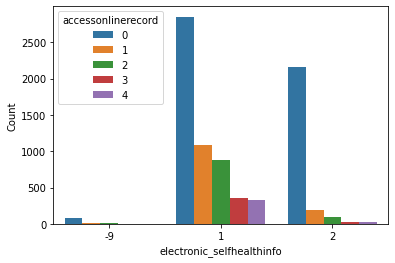

observed data:
 accessonlinerecord            0     1    2    3    4
electronic_selfhealthinfo                           
-9                           85    10    8    5    2
 1                         2849  1089  880  352  328
 2                         2161   190   99   31   25
expected data:
 [[  69.07197437   17.47473503   13.38057678    5.26004437    4.81266946]
 [3452.34286419  873.41902884  668.78555583  262.90658122  240.54596993]
 [1573.58516145  398.10623614  304.83386739  119.83337441  109.64136061]]
chi-squared value: 896.2820 for 8 dof; p-value = 0.0000



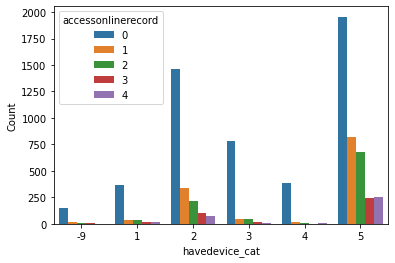

observed data:
 accessonlinerecord     0    1    2    3    4
havedevice_cat                              
-9                   147   18    8    5    2
 1                   365   39   35   14   14
 2                  1459  343  219  104   72
 3                   786   48   42   14   11
 4                   383   19    7    3    4
 5                  1955  822  676  248  252
expected data:
 [[ 113.02686714   28.59502095   21.89548928    8.60734533    7.8752773 ]
 [ 293.24192753   74.18819325   56.80663052   22.33127927   20.43196944]
 [1379.55570619  349.01811684  267.2466108   105.0574316    96.12213458]
 [ 565.76226276  143.13396598  109.599088     43.08454523   39.42013803]
 [ 261.21764851   66.08627064   50.60290855   19.89253143   18.20064087]
 [2482.19558787  627.97843234  480.84927286  189.02686714  172.94983978]]
chi-squared value: 785.8079 for 20 dof; p-value = 0.0000



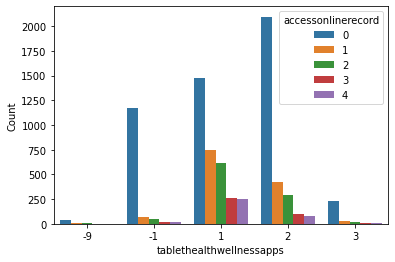

observed data:
 accessonlinerecord           0    1    2    3    4
tablethealthwellnessapps                          
-9                          38   11    5    2    1
-1                        1169   67   49   17   15
 1                        1477  744  611  263  255
 2                        2095  427  296   97   74
 3                         234   29   21    4    9
expected data:
 [[  35.67303371    9.09438202    6.98801498    2.72546816    2.51910112]
 [ 824.23483146  210.12808989  161.45992509   62.97265918   58.20449438]
 [2096.57303371  534.49438202  410.69912609  160.18102372  148.05243446]
 [1870.64382022  476.89662921  366.44169788  142.91972534  132.09812734]
 [ 185.8752809    47.38651685   36.41123596   14.2011236    13.1258427 ]]
chi-squared value: 1014.7635 for 16 dof; p-value = 0.0000



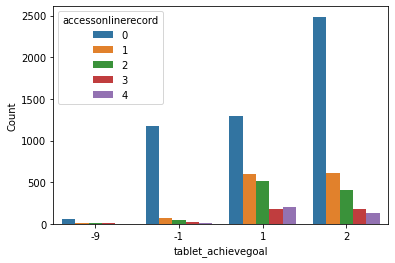

observed data:
 accessonlinerecord     0    1    2    3    4
tablet_achievegoal                          
-9                    63   11    7    5    1
-1                  1169   67   49   17   15
 1                  1297  595  518  184  203
 2                  2485  607  408  177  135
expected data:
 [[  54.43878697   13.8974167    10.66192437    4.15836765    3.84350431]
 [ 824.09060277  210.37813553  161.39947585   62.94908274   58.18270311]
 [1750.17571446  446.79395982  342.77474105  133.68913016  123.56645451]
 [2385.29489579  608.93048796  467.16385873  182.20341944  168.40733808]]
chi-squared value: 735.9359 for 12 dof; p-value = 0.0000



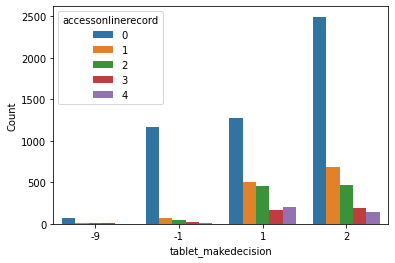

observed data:
 accessonlinerecord      0    1    2    3    4
tablet_makedecision                          
-9                     75   14   11    5    2
-1                   1169   67   49   17   15
 1                   1275  509  455  173  198
 2                   2495  690  467  188  139
expected data:
 [[  66.95345064   17.09222513   13.11294147    5.11431424    4.72706851]
 [ 824.09060277  210.37813553  161.39947585   62.94908274   58.18270311]
 [1633.16360914  416.92250094  319.85773119  124.75102958  115.30512917]
 [2489.79233745  635.6071384   487.62985149  190.18557344  175.78509921]]
chi-squared value: 636.5914 for 12 dof; p-value = 0.0000



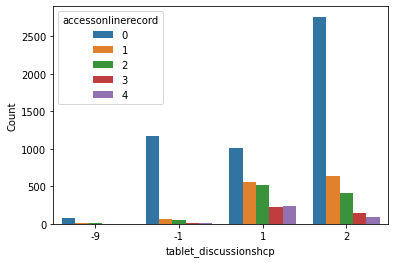

observed data:
 accessonlinerecord        0    1    2    3    4
tablet_discussionshcp                          
-9                       75   16   10    5    2
-1                     1169   67   49   17   15
 1                     1009  556  517  222  240
 2                     2761  641  406  139   97
expected data:
 [[  67.57918383   17.25196556   13.23549232    5.16211157    4.77124672]
 [ 824.09060277  210.37813553  161.39947585   62.94908274   58.18270311]
 [1591.86521902  406.3796331   311.76937477  121.59640584  112.38936728]
 [2530.46499438  645.99026582  495.59565706  193.29239985  178.65668289]]
chi-squared value: 1110.4601 for 12 dof; p-value = 0.0000



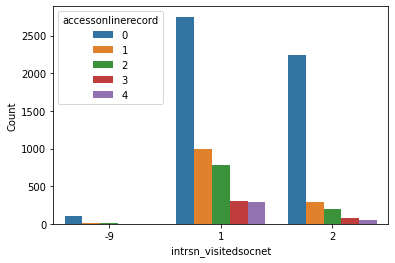

observed data:
 accessonlinerecord       0    1    2    3    4
intrsn_visitedsocnet                          
-9                     106   13   11    3    3
 1                    2749  991  776  308  295
 2                    2240  285  200   77   57
expected data:
 [[  85.3980774    21.60512694   16.54325857    6.50332758    5.95020951]
 [3214.35851614  813.21062361  622.68338674  244.78333744  223.96413606]
 [1795.24340646  454.18424945  347.7733547   136.71333498  125.08565442]]
chi-squared value: 495.5912 for 8 dof; p-value = 0.0000



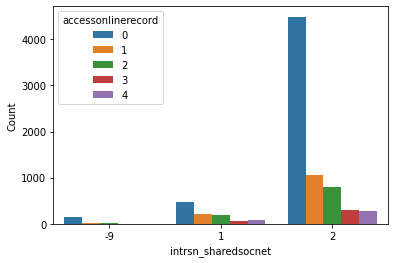

observed data:
 accessonlinerecord      0     1    2    3    4
intrsn_sharedsocnet                           
-9                    139    15   15    5    3
 1                    470   208  183   73   77
 2                   4486  1066  789  310  275
expected data:
 [[ 111.14308602   28.11843727   21.53056446    8.46388957    7.74402268]
 [ 634.83423712  160.60870101  122.97966478   48.3445896    44.23280749]
 [4349.02267685 1100.27286172  842.48977077  331.19152083  303.02316983]]
chi-squared value: 155.0561 for 8 dof; p-value = 0.0000



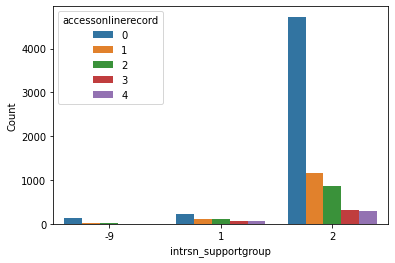

observed data:
 accessonlinerecord      0     1    2    3    4
intrsn_supportgroup                           
-9                    145    13   14    5    3
 1                    222   106  106   55   61
 2                   4728  1170  867  328  291
expected data:
 [[ 113.02686714   28.59502095   21.89548928    8.60734533    7.8752773 ]
 [ 345.35987183   87.37367513   66.9028839    26.30022184   24.0633473 ]
 [4636.61326103 1173.03130392  898.20162682  353.09243283  323.0613754 ]]
chi-squared value: 191.6816 for 8 dof; p-value = 0.0000



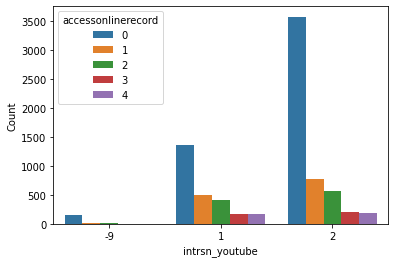

observed data:
 accessonlinerecord     0    1    2    3    4
intrsn_youtube                              
-9                   150   14   13    6    3
 1                  1370  497  409  169  165
 2                  3575  778  565  213  187
expected data:
 [[ 116.79442938   29.54818832   22.62533892    8.89425684    8.13778654]
 [1638.88957358  414.6278038   317.48459453  124.80650727  114.19152083]
 [3339.31599704  844.82400789  646.89006655  254.29923589  232.67069263]]
chi-squared value: 198.9763 for 8 dof; p-value = 0.0000



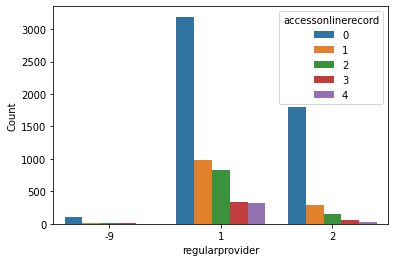

observed data:
 accessonlinerecord     0    1    2    3    4
regularprovider                             
-9                   106   20    7    5    4
 1                  3192  986  824  331  319
 2                  1797  283  156   52   32
expected data:
 [[  89.16563964   22.55829431   17.27310821    6.79023909    6.21271876]
 [3549.0436283   897.88365788  687.51836332  270.27064333  247.28370717]
 [1456.79073207  368.55804782  282.20852847  110.93911757  101.50357407]]
chi-squared value: 351.6029 for 8 dof; p-value = 0.0000



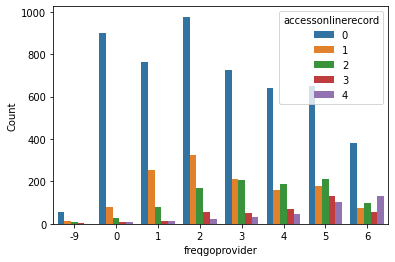

observed data:
 accessonlinerecord    0    1    2    3    4
freqgoprovider                             
-9                   57   11    7    2    1
 0                  902   81   29    8    8
 1                  764  252   77   15   13
 2                  977  324  168   54   21
 3                  724  211  207   50   33
 4                  642  161  190   72   44
 5                  649  176  210  130  103
 6                  380   73   99   57  132
expected data:
 [[ 48.9783091   12.39117575   9.48804535   3.72984964   3.41262016]
 [645.5089968  163.30934188 125.0475721   49.15750555  44.97658368]
 [703.90621149 178.08343604 136.36024156  53.60463397  49.04547695]
 [969.51934927 245.28173527 187.81464136  73.83189549  67.5523786 ]
 [769.21062361 194.6050037  149.0109687   58.57776682  53.59563717]
 [696.37108701 176.17710131 134.90054227  53.03081094  48.52045847]
 [796.21148632 201.43603648 154.2415578   60.63396598  55.47695341]
 [465.29393641 117.71616958  90.13643086  35.4335716

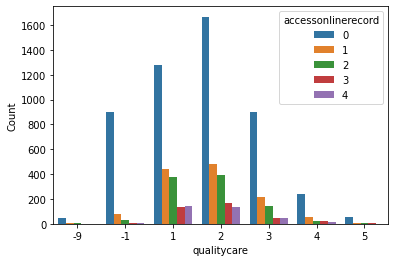

observed data:
 accessonlinerecord     0    1    2    3    4
qualitycare                                 
-9                    45    8    8    2    1
-1                   902   81   29    8    8
 1                  1282  440  378  135  144
 2                  1667  478  395  166  136
 3                   897  217  146   49   49
 4                   241   58   25   21   15
 5                    55    6    4    6    2
expected data:
 [[  40.18953603   10.17176703    7.77887463    3.05626851    2.8035538 ]
 [ 645.54442251  163.3840079   124.94817374   49.09131293   45.03208292]
 [1493.92040967  378.10365252  289.15535538  113.607231    104.21335143]
 [1784.6665844   451.69002962  345.43065153  135.71742349  124.49531096]
 [ 852.77171767  215.83218164  165.05799605   64.85019743   59.48790721]
 [ 226.06614018   57.21618954   43.75616979   17.19151037   15.76999013]
 [  45.84118954   11.60217177    8.87277887    3.48605627    3.19780355]]
chi-squared value: 425.0706 for 24 dof; p-value = 0

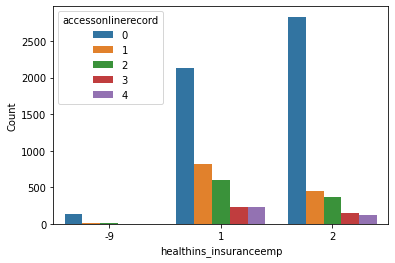

observed data:
 accessonlinerecord         0    1    2    3    4
healthins_insuranceemp                          
-9                       133   13   12    3    1
 1                      2129  824  606  234  227
 2                      2833  452  369  151  127
expected data:
 [[ 101.72418043   25.73551886   19.70594035    7.7466108     7.08774957]
 [2524.26669953  638.62213458  488.99926054  192.23071235  175.881193  ]
 [2469.00912004  624.64234656  478.29479911  188.02267685  172.03105743]]
chi-squared value: 340.1302 for 8 dof; p-value = 0.0000



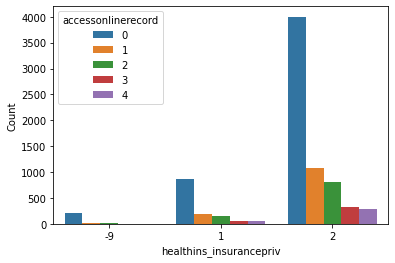

observed data:
 accessonlinerecord          0     1    2    3    4
healthins_insurancepriv                           
-9                        219    20   19    3    6
 1                        876   183  155   65   55
 2                       4000  1086  813  320  294
expected data:
 [[ 167.6565196    42.41594774   32.4783091    12.76756224   11.68166133]
 [ 837.65467094  211.9208775   162.26990387   63.78999261   58.36455509]
 [4089.68880947 1034.66317476  792.25178703  311.44244516  284.95378358]]
chi-squared value: 55.2238 for 8 dof; p-value = 0.0000



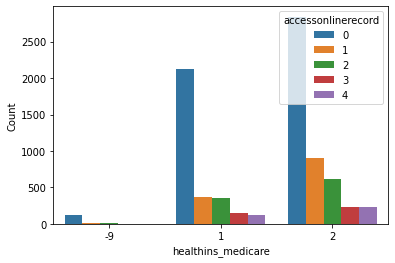

observed data:
 accessonlinerecord     0    1    2    3    4
healthins_medicare                          
-9                   123   13   10    3    0
 1                  2130  369  357  155  126
 2                  2842  907  620  230  229
expected data:
 [[  93.56112891   23.6703229    18.12459946    7.12496919    6.51897954]
 [1969.80712349  498.34767069  381.58972147  150.00690165  137.2485827 ]
 [3031.6317476   766.98200641  587.28567907  230.86812916  211.23243776]]
chi-squared value: 116.6379 for 8 dof; p-value = 0.0000



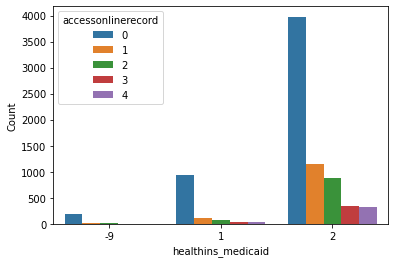

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_medicaid                           
-9                   185    19   17    7    2
 1                   934   121   82   33   34
 2                  3976  1149  888  348  319
expected data:
 [[ 144.42321913   36.53808233   27.97756963   10.99827459   10.06285433]
 [ 756.02415578  191.26891792  146.45649495   57.57357653   52.67685482]
 [4194.55262509 1061.19299975  812.56593542  319.42814888  292.26029086]]
chi-squared value: 175.8888 for 8 dof; p-value = 0.0000



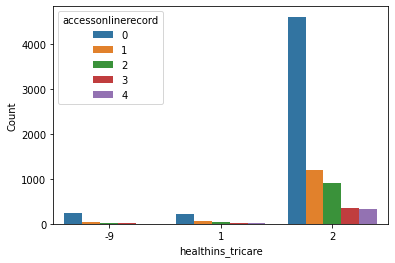

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_tricare                            
-9                   253    32   23   12    8
 1                   230    61   44   20   13
 2                  4612  1196  920  356  334
expected data:
 [[ 205.96006902   52.10648262   39.89844713   15.68449593   14.3505053 ]
 [ 231.0771506    58.46093172   44.76411141   17.59723934   16.10056692]
 [4657.96278038 1178.43258565  902.33744146  354.71826473  324.54892778]]
chi-squared value: 31.7296 for 8 dof; p-value = 0.0001



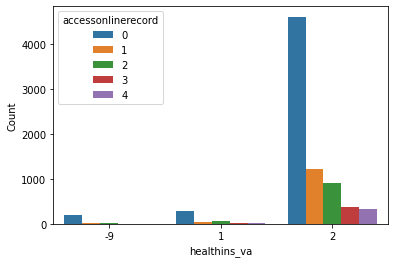

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_va                                 
-9                   190    24   15    6    2
 1                   293    52   61   16   20
 2                  4612  1213  911  366  333
expected data:
 [[ 148.81870841   37.65011092   28.82906088   11.33300468   10.36911511]
 [ 277.54375154   70.21666256   53.76559034   21.13581464   19.33818092]
 [4668.63754005 1181.13322652  904.40534878  355.53118068  325.29270397]]
chi-squared value: 42.1594 for 8 dof; p-value = 0.0000



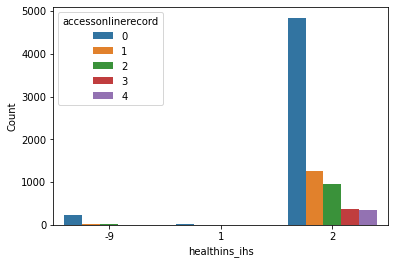

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_ihs                                
-9                   228    27   19    9    3
 1                    25     5    4    1    2
 2                  4842  1257  964  378  350
expected data:
 [[1.79587133e+02 4.54343111e+01 3.47894996e+01 1.36761154e+01
  1.25129406e+01]
 [2.32333005e+01 5.87786542e+00 4.50073946e+00 1.76928765e+00
  1.61880700e+00]
 [4.89217957e+03 1.23768782e+03 9.47709761e+02 3.72554597e+02
  3.40868252e+02]]
chi-squared value: 38.6935 for 8 dof; p-value = 0.0000



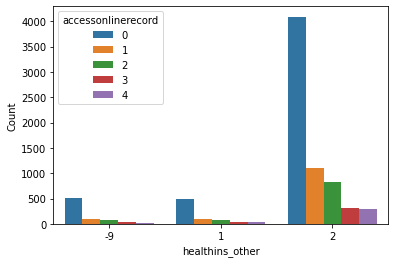

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_other                              
-9                   518    99   76   28   22
 1                   489    89   81   37   33
 2                  4088  1101  830  323  300
expected data:
 [[ 466.54979049  118.03389204   90.37971407   35.52920877   32.50739463]
 [ 457.75881193  115.80983485   88.67673158   34.85974858   31.89487306]
 [4170.69139758 1055.15627311  807.94355435  317.61104264  290.59773231]]
chi-squared value: 29.8249 for 8 dof; p-value = 0.0002



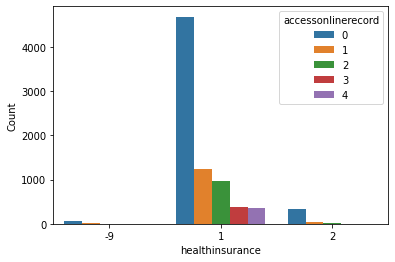

observed data:
 accessonlinerecord     0     1    2    3    4
healthinsurance                              
-9                    66     7    6    2    0
 1                  4688  1245  965  383  352
 2                   341    37   16    3    3
expected data:
 [[5.08620902e+01 1.28677594e+01 9.85297018e+00 3.87330540e+00
  3.54387478e+00]
 [4.79296709e+03 1.21258775e+03 9.28490387e+02 3.64999261e+02
  3.33955509e+02]
 [2.51170816e+02 6.35444910e+01 4.86566428e+01 1.91274341e+01
  1.75006162e+01]]
chi-squared value: 110.3472 for 8 dof; p-value = 0.0000



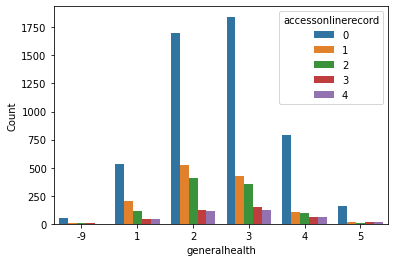

observed data:
 accessonlinerecord     0    1    2    3    4
generalhealth                               
-9                    49    9    8    3    0
 1                   537  202  115   41   39
 2                  1697  525  404  124  112
 3                  1845  429  355  148  126
 4                   793  106   92   59   64
 5                   163   16   11   13   13
expected data:
 [[  43.31884416   10.966041      8.39281304    3.30600148    3.01630032]
 [ 586.37391949  148.4388738   113.60706347   44.75080267   40.82934058]
 [1796.7903186   454.85230921  348.11928871  137.1271919   125.11089158]
 [1822.53050136  461.36836256  353.10632255  139.09162756  126.90318597]
 [ 699.3795999   177.04593727  135.50135836   53.37515436   48.69795011]
 [ 135.6068165    34.32847617   26.27315387   10.34922203    9.44233144]]
chi-squared value: 145.7799 for 20 dof; p-value = 0.0000



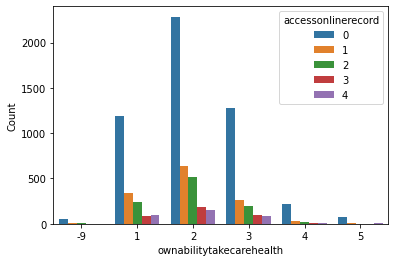

observed data:
 accessonlinerecord           0    1    2    3    4
ownabilitytakecarehealth                          
-9                          54    6    8    3    0
 1                        1186  339  246   84  100
 2                        2285  642  511  183  157
 3                        1278  262  201  101   82
 4                         216   29   18   14   10
 5                          71   11    2    3    6
expected data:
 [[  44.57202763   11.28749383    8.63418846    3.39763197    3.10865812]
 [1227.30019734  310.80352738  237.74420326   93.55451406   85.59755797]
 [2371.73408979  600.62185496  459.43611248  180.7923039   165.41563888]
 [1207.83917119  305.875185    233.97434632   92.07104095   84.24025654]
 [ 180.17143562   45.62691169   34.90157869   13.73408979   12.56598421]
 [  58.38307844   14.78502713   11.30957079    4.45041934    4.07190429]]
chi-squared value: 78.1552 for 20 dof; p-value = 0.0000



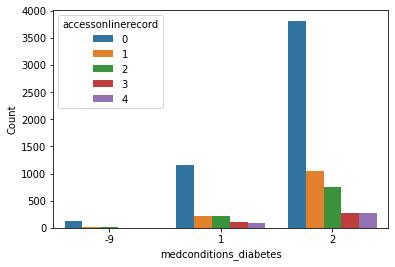

observed data:
 accessonlinerecord         0     1    2    3    4
medconditions_diabetes                           
-9                       122    16   13    6    4
 1                      1159   222  222  101   81
 2                      3814  1051  752  281  270
expected data:
 [[ 101.09625339   25.57665763   19.58429874    7.69879221    7.04399803]
 [1120.84976584  283.5672911   217.13026867   85.35617451   78.09649988]
 [3873.05398077  979.85605127  750.28543259  294.94503328  269.8595021 ]]
chi-squared value: 36.2914 for 8 dof; p-value = 0.0000



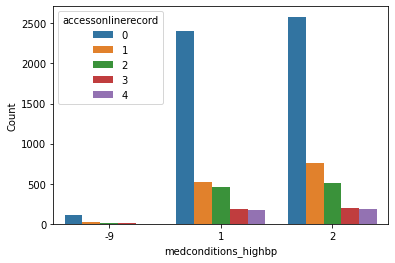

observed data:
 accessonlinerecord       0    1    2    3    4
medconditions_highbp                          
-9                     110   18   12    5    3
 1                    2404  518  463  182  170
 2                    2581  753  512  201  182
expected data:
 [[  92.93320187   23.51146167   18.00295785    7.0771506     6.475228  ]
 [2346.5633473   593.6644072   454.57468573  178.69805275  163.49950702]
 [2655.50345083  671.82413113  514.42235642  202.22479665  185.02526497]]
chi-squared value: 32.3948 for 8 dof; p-value = 0.0001



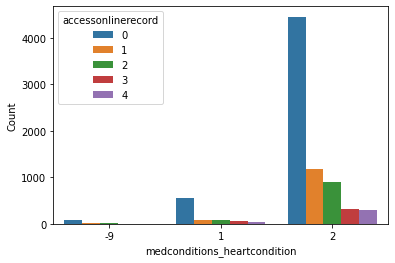

observed data:
 accessonlinerecord               0     1    2    3    4
medconditions_heartcondition                           
-9                              93    17   11    5    4
 1                             549    84   81   55   47
 2                            4453  1188  895  328  304
expected data:
 [[  81.63051516   20.65195958   15.81340892    6.21641607    5.68770027]
 [ 512.38846438  129.63076165   99.25955139   39.01996549   35.70125709]
 [4500.98102046 1138.71727878  871.92703968  342.76361844  313.61104264]]
chi-squared value: 40.7762 for 8 dof; p-value = 0.0000



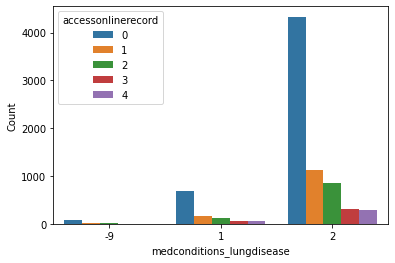

observed data:
 accessonlinerecord            0     1    2    3    4
medconditions_lungdisease                           
-9                           85    14   10    6    3
 1                          678   155  123   63   66
 2                         4332  1120  854  319  286
expected data:
 [[  74.09539068   18.74562485   14.35370964    5.64259305    5.16268178]
 [ 681.30083806  172.36443185  131.9811437    51.8831649    47.47042149]
 [4339.60377126 1097.88994331  840.66514666  330.47424205  302.36689672]]
chi-squared value: 19.0011 for 8 dof; p-value = 0.0149



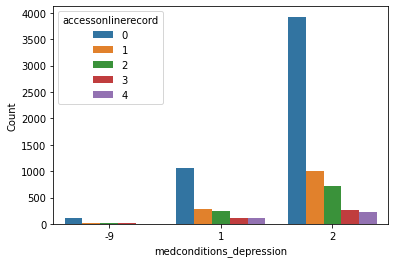

observed data:
 accessonlinerecord           0    1    2    3    4
medconditions_depression                          
-9                         109   18   13    8    4
 1                        1058  277  252  110  117
 2                        3928  994  722  270  234
expected data:
 [[  95.44491003   24.14690658   18.48952428    7.26842494    6.65023416]
 [1139.05964999  288.1742667   220.65787528   86.74291348   79.36529455]
 [3860.49543998  976.67882672  747.85260044  293.98866157  268.98447128]]
chi-squared value: 49.8737 for 8 dof; p-value = 0.0000



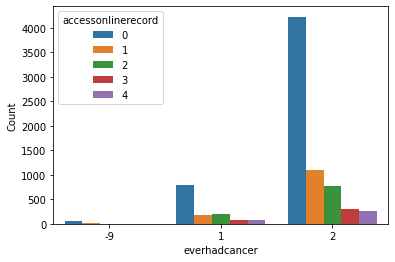

observed data:
 accessonlinerecord     0     1    2    3    4
everhadcancer                                
-9                    64     8    2    3    3
 1                   801   183  209   78   87
 2                  4230  1098  776  307  265
expected data:
 [[5.02341632e+01 1.27088982e+01 9.73132857e+00 3.82548681e+00
  3.50012324e+00]
 [8.52724920e+02 2.15733547e+02 1.65189302e+02 6.49376386e+01
  5.94145921e+01]
 [4.19204092e+03 1.06055755e+03 8.12079369e+02 3.19236875e+02
  2.92085285e+02]]
chi-squared value: 53.3168 for 8 dof; p-value = 0.0000



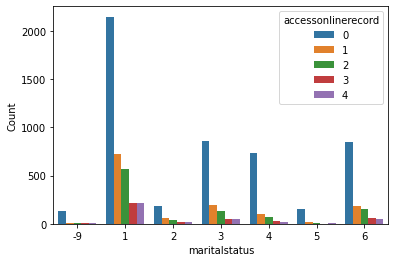

observed data:
 accessonlinerecord     0    1    2    3    4
maritalstatus                               
-9                   137    9   12    6    7
 1                  2150  727  565  220  216
 2                   189   57   43   16   14
 3                   863  190  129   50   45
 4                   739  106   73   31   22
 5                   152   17   12    2    5
 6                   851  181  153   63   46
expected data:
 [[ 107.29204742   27.1767103    20.84181279    8.19313411    7.49629538]
 [2433.20795258  616.3232897   472.65818721  185.80686589  170.00370462]
 [ 200.15300074   50.6980736    38.88034082   15.28426772   13.98431712]
 [ 801.23944184  202.95122252  155.64324525   61.18498395   55.98110645]
 [ 609.24314646  154.31921462  118.34736972   46.52358607   42.56668313]
 [ 117.95850827   29.87848852   22.91380588    9.00765621    8.24154112]
 [ 811.90590269  205.65300074  157.71523833   61.99950605   56.72635219]]
chi-squared value: 240.1720 for 24 dof; p-value = 0

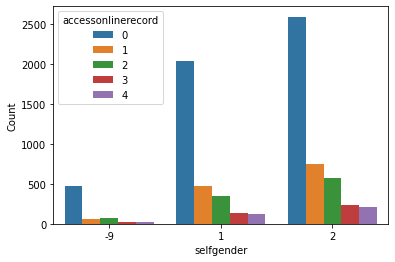

observed data:
 accessonlinerecord     0    1    2    3    4
selfgender                                  
-9                   478   64   67   21   19
 1                  2029  477  348  134  121
 2                  2587  748  572  233  215
expected data:
 [[ 407.49488475  103.11364477   78.95513374   31.03808702   28.39824972]
 [1952.08258351  493.96043387  378.23037101  148.68630593  136.04030568]
 [2734.42253174  691.92592136  529.81449525  208.27560705  190.5614446 ]]
chi-squared value: 66.2658 for 8 dof; p-value = 0.0000



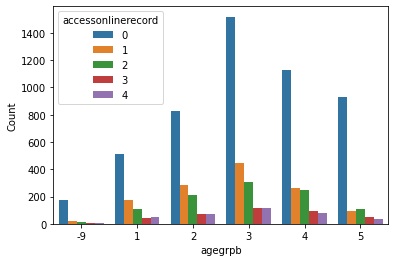

observed data:
 accessonlinerecord     0    1    2    3    4
agegrpb                                     
-9                   172   22   14    6    3
 1                   513  178  108   44   50
 2                   831  286  209   75   73
 3                  1519  444  305  118  117
 4                  1128  262  246   97   77
 5                   927   97  105   48   35
expected data:
 [[ 136.21038352   34.49414231   26.41250462   10.3830312     9.49993834]
 [ 560.5339746   141.95054877  108.69293378   42.72832655   39.0942163 ]
 [ 925.22629177  234.30583303  179.41028487   70.52805525   64.52953508]
 [1571.12714268  397.87483044  304.65667777  119.76371932  109.57762979]
 [1136.13269207  287.71611789  220.30706622   86.60500678   79.23911703]
 [ 760.76951535  192.65852756  147.52053274   57.9918609    53.05956345]]
chi-squared value: 187.8198 for 20 dof; p-value = 0.0000



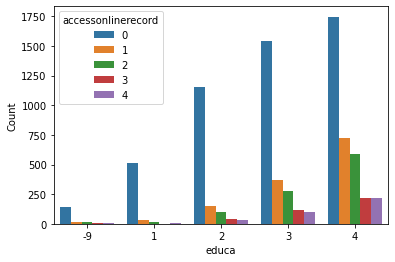

observed data:
 accessonlinerecord     0    1    2    3    4
educa                                       
-9                   145   12   11    5    6
 1                   511   32   17    2    4
 2                  1152  151   96   41   31
 3                  1540  370  277  119   97
 4                  1747  724  586  221  217
expected data:
 [[ 112.3989401    28.43615972   21.77384767    8.55952674    7.83152576]
 [ 355.40670446   89.91545477   68.84914962   27.0653192    24.76337195]
 [ 923.68067538  233.68486566  178.93480404   70.34113877   64.35851614]
 [1508.90867636  381.7435297   292.30478186  114.90806014  105.13495193]
 [2194.6050037   555.21999014  425.13741681  167.12595514  152.91163421]]
chi-squared value: 615.2202 for 16 dof; p-value = 0.0000



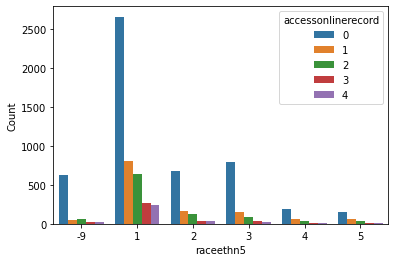

observed data:
 accessonlinerecord     0    1    2    3    4
raceethn5                                   
-9                   629   55   61   27   18
 1                  2660  812  639  261  246
 2                   672  160  124   33   36
 3                   790  147   91   42   29
 4                   194   59   40   15   15
 5                   150   56   32   10   11
expected data:
 [[ 496.06236135  125.50036973   96.09686961   37.77668228   34.56371703]
 [2899.76706926  733.62114863  561.74094158  220.82622628  202.04461425]
 [ 643.62521568  162.8327582   124.68264728   49.01404979   44.84532906]
 [ 690.09181661  174.58848903  133.6841262    52.55262509   48.08294306]
 [ 202.82043382   51.31217649   39.29023909   15.44540301   14.1317476 ]
 [ 162.63310328   41.14505792   31.50517624   12.38501356   11.331649  ]]
chi-squared value: 213.6170 for 20 dof; p-value = 0.0000



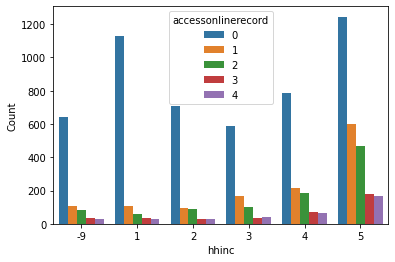

observed data:
 accessonlinerecord     0    1    2    3    4
hhinc                                       
-9                   642  107   82   37   27
 1                  1128  105   61   34   28
 2                   708   93   90   31   28
 3                   586  170  103   33   41
 4                   786  214  185   73   62
 5                  1245  600  466  180  169
expected data:
 [[ 561.99470052  142.18079862  108.86923835   42.79763372   39.15762879]
 [ 851.46906581  215.4158245   164.94601923   64.84200148   59.32708898]
 [ 596.5306877   150.91816613  115.55952674   45.4276559    41.56396352]
 [ 585.85592803  148.21752526  113.49161942   44.61473996   40.82018733]
 [ 828.86369238  209.69682031  160.56692137   63.12053241   57.75203352]
 [1670.28592556  422.57086517  323.56667488  127.19743653  116.37909786]]
chi-squared value: 638.3992 for 20 dof; p-value = 0.0000



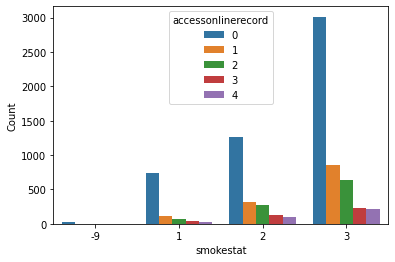

observed data:
 accessonlinerecord     0    1    2    3    4
smokestat                                   
-9                    19    4    4    0    4
 1                   742  118   64   34   32
 2                  1267  310  270  122  103
 3                  3013  851  641  229  214
expected data:
 [[1.94342743e+01 4.94627534e+00 3.77428181e+00 1.48426813e+00
  1.36090039e+00]
 [6.20642955e+02 1.57961696e+02 1.20533516e+02 4.74008208e+01
  4.34610123e+01]
 [1.29896182e+03 3.30602661e+02 2.52268126e+02 9.92065663e+01
  9.09608258e+01]
 [3.10196095e+03 7.89489367e+02 6.02424077e+02 2.36908345e+02
  2.17217262e+02]]
chi-squared value: 94.2449 for 12 dof; p-value = 0.0000



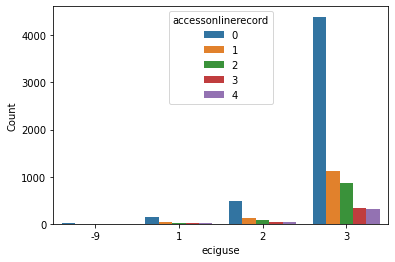

observed data:
 accessonlinerecord     0     1    2    3    4
eciguse                                      
-9                     8     2    1    0    0
 1                   139    48   25   14   11
 2                   494   119   90   37   36
 3                  4395  1114  864  334  307
expected data:
 [[6.89176412e+00 1.75578502e+00 1.34112963e+00 5.26872356e-01
  4.84448868e-01]
 [1.48486191e+02 3.78291864e+01 2.88952476e+01 1.13517044e+01
  1.04376711e+01]
 [4.86182632e+02 1.23862652e+02 9.46105997e+01 3.71684499e+01
  3.41756656e+01]
 [4.39443941e+03 1.11955238e+03 8.55153023e+02 3.35952973e+02
  3.08902214e+02]]
chi-squared value: 6.6057 for 12 dof; p-value = 0.8825



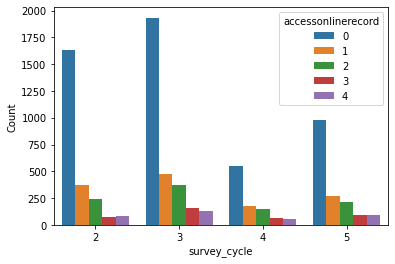

observed data:
 accessonlinerecord     0    1    2    3    4
survey_cycle                                
2                   1631  371  245   76   81
3                   1932  473  374  156  130
4                    549  178  150   68   54
5                    983  267  218   88   90
expected data:
 [[1509.5366034   381.90239093  292.42642347  114.95587873  105.17870348]
 [1924.59637663  486.90966231  372.83152576  146.56396352  134.09847178]
 [ 627.29911264  158.70236628  121.51996549   47.77076658   43.70778901]
 [1033.56790732  261.48558048  200.22208528   78.70939118   72.01503574]]
chi-squared value: 77.2397 for 12 dof; p-value = 0.0000



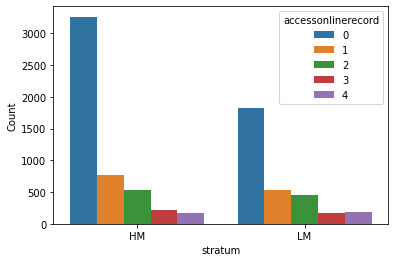

observed data:
 accessonlinerecord     0    1    2    3    4
stratum                                     
HM                  3263  762  529  217  169
LM                  1832  527  458  171  186
expected data:
 [[3101.95957604  784.77446389  600.90953907  236.2238107   216.1326103 ]
 [1993.04042396  504.22553611  386.09046093  151.7761893   138.8673897 ]]
chi-squared value: 75.3356 for 4 dof; p-value = 0.0000



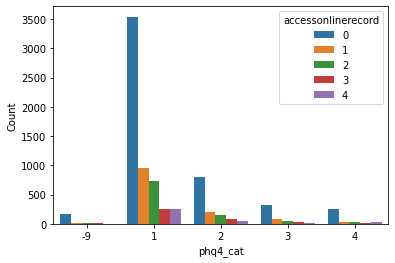

observed data:
 accessonlinerecord     0    1    2    3    4
phq4_cat                                    
-9                   176   20   23    9    5
 1                  3539  959  732  258  248
 2                   800  197  150   78   56
 3                   315   78   57   26   20
 4                   259   35   25   14   26
expected data:
 [[ 146.29697717   37.05576804   28.37396669   11.06785935   10.20542875]
 [3601.54275139  912.23985194  698.51104257  272.46884639  251.23750771]
 [ 804.31943245  203.72720543  155.99592844   60.84947563   56.10795805]
 [ 311.43047502   78.88266502   60.40123381   23.56076496   21.7248612 ]
 [ 225.41036397   57.09450956   43.7178285    17.05305367   15.72424429]]
chi-squared value: 58.6119 for 16 dof; p-value = 0.0000



In [289]:
# plot and analyze the data
for oc_var in outcome_vars:
    for cat_var in int_cols:
        get_crosstabs(cat_var, oc_var, df_train, plot_data = True)

Nearly all the relationships are significant (chi-squared p-value < 0.05).  
The non-signficant relationships by outcome variable are:  

**`offeredaccesseither`**:
- `eciguse` (e-cigarette user) 
  
**`accessonlinerecord`**: 
- `eciguse` (e-cigarette user)  

The variable `eciguse` does not have a signficant relationship to either outcome variable, so it will be dropped.  

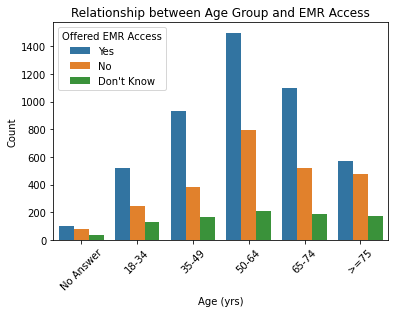

In [313]:
# representative plots with nice formatting for the blog post
# age & access
row = 'agegrpb'
col = 'offeredaccesseither'
x_labs = ['No Answer', '18-34', '35-49', '50-64', '65-74', '>=75']
leg_labs = ['Yes','No',"Don't Know"]
leg_title = 'Offered EMR Access'
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 45)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Age Group and EMR Access')
fig.set(xlabel = 'Age (yrs)')
fig.set(ylabel = 'Count');

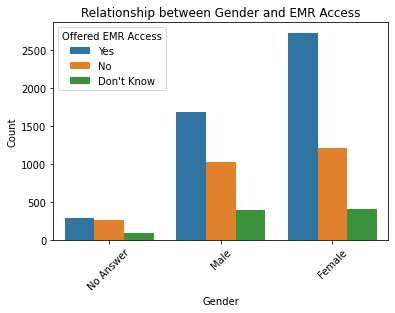

In [314]:
# gender and access
row = 'selfgender'
x_labs = ['No Answer', 'Male', 'Female']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 45)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Gender and EMR Access')
fig.set(xlabel = 'Gender')
fig.set(ylabel = 'Count');

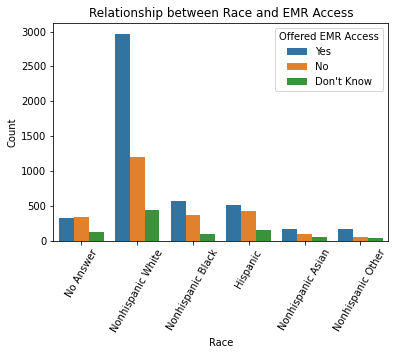

In [315]:
# race and access
row = 'raceethn5'
x_labs = ['No Answer', 'Nonhispanic White', 'Nonhispanic Black', 'Hispanic',\
         'Nonhispanic Asian', 'Nonhispanic Other']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 60)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Race and EMR Access')
fig.set(xlabel = 'Race')
fig.set(ylabel = 'Count');

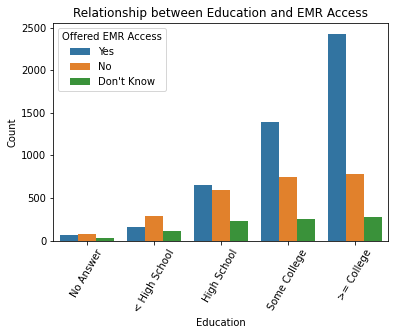

In [316]:
# education and access
row = 'educa'
x_labs = ['No Answer', '< High School', 'High School', 'Some College','>= College']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 60)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Education and EMR Access')
fig.set(xlabel = 'Education')
fig.set(ylabel = 'Count');

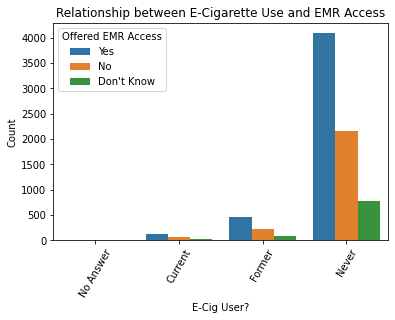

In [317]:
# ecigs and access
row = 'eciguse'
x_labs = ['No Answer', 'Current', 'Former', 'Never']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 60)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between E-Cigarette Use and EMR Access')
fig.set(xlabel = 'E-Cig User?')
fig.set(ylabel = 'Count');

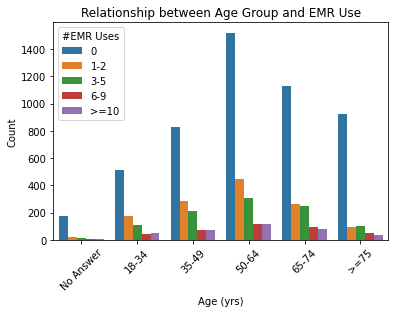

In [320]:
# age and use
row = 'agegrpb'
col = 'accessonlinerecord'
x_labs = ['No Answer', '18-34', '35-49', '50-64', '65-74', '>=75']
leg_labs = ['0', '1-2', '3-5', '6-9', '>=10']
leg_title = '#EMR Uses'
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 45)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Age Group and EMR Use')
fig.set(xlabel = 'Age (yrs)')
fig.set(ylabel = 'Count');

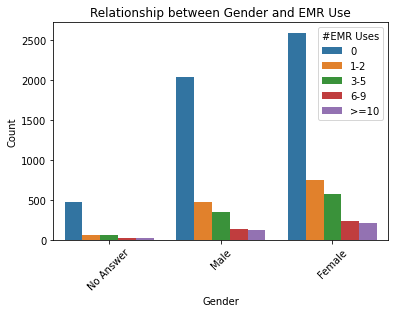

In [321]:
# gender and use
row = 'selfgender'
x_labs = ['No Answer', 'Male', 'Female']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 45)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Gender and EMR Use')
fig.set(xlabel = 'Gender')
fig.set(ylabel = 'Count');

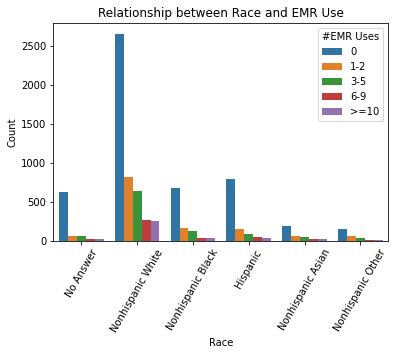

In [322]:
# race and use
row = 'raceethn5'
x_labs = ['No Answer', 'Nonhispanic White', 'Nonhispanic Black', 'Hispanic',\
         'Nonhispanic Asian', 'Nonhispanic Other']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 60)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Race and EMR Use')
fig.set(xlabel = 'Race')
fig.set(ylabel = 'Count');

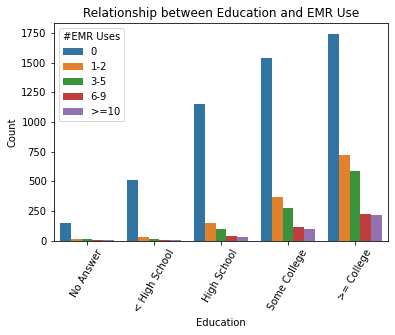

In [323]:
# education and use
row = 'educa'
x_labs = ['No Answer', '< High School', 'High School', 'Some College','>= College']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 60)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between Education and EMR Use')
fig.set(xlabel = 'Education')
fig.set(ylabel = 'Count');

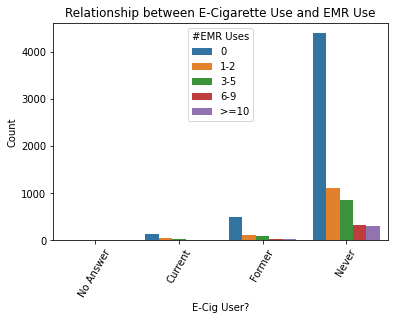

In [324]:
# ecigs and use
row = 'eciguse'
x_labs = ['No Answer', 'Current', 'Former', 'Never']
df_filt = df_train[~(df_train[row].isin(miss_codes2))]
fig = sb.countplot(data=df_filt, x=row, hue=col)  
fig.set_xticklabels (labels = x_labs, rotation = 60)
fig.legend(leg_labs, title=leg_title)
fig.set(title = 'Relationship between E-Cigarette Use and EMR Use')
fig.set(xlabel = 'E-Cig User?')
fig.set(ylabel = 'Count');

It generally looks like the -9 missing category is rare and doesn't have a significant influence, except for in `selfgender`. We want to retain these entries since it may indicate gender-nonconformity.
To see the effect of removing the -9 code, we'll re-run the analysis with it excluded **except** for -9 `selfgender`, which we'll recode to 3.  

In [325]:
# back up yet again
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [326]:
# recode selfgender (-1 to 3)-- train set
print('gender, pre: ', df_train['selfgender'].value_counts())
df_train.loc[df_train['selfgender'] == -9, 'selfgender'] = 3
print('gender, post: ', df_train['selfgender'].value_counts())

gender, pre:   2    4355
 1    3109
-9     649
-5       1
Name: selfgender, dtype: int64
gender, post:   2    4355
 1    3109
 3     649
-5       1
Name: selfgender, dtype: int64


In [327]:
# recode selfgender (-1 to 3)-- test set, no peeking
df_test.loc[df_test['selfgender'] == -9, 'selfgender'] = 3

In [328]:
# drop eciguse since relationship to both outcomes is non-signficant
df_train.drop(columns = ['eciguse'], inplace = True)
df_test.drop(columns = ['eciguse'], inplace = True)

In [329]:
# also remove it from the list of columns to analyze
int_cols.remove('eciguse')

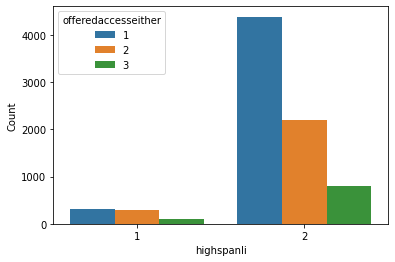

observed data:
 offeredaccesseither     1     2    3
highspanli                          
1                     322   297  103
2                    4389  2198  805
expected data:
 [[ 419.19423219  222.01010599   80.79566182]
 [4291.80576781 2272.98989401  827.20433818]]
chi-squared value: 59.2387 for 2 dof; p-value = 0.0000



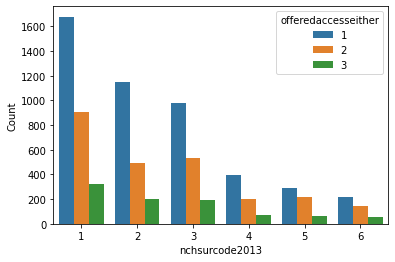

observed data:
 offeredaccesseither     1    2    3
nchsurcode2013                     
1                    1679  909  323
2                    1146  495  198
3                     979  534  192
4                     396  198   73
5                     292  214   66
6                     219  145   56
expected data:
 [[1690.13076165  895.11276806  325.7564703 ]
 [1067.72602909  565.48003451  205.79393641]
 [ 989.92543752  524.27594281  190.79861967]
 [ 387.26115356  205.0979788    74.64086764]
 [ 332.10401775  175.88612275   64.0098595 ]
 [ 243.85260044  129.14715307   47.00024649]]
chi-squared value: 35.2833 for 10 dof; p-value = 0.0001



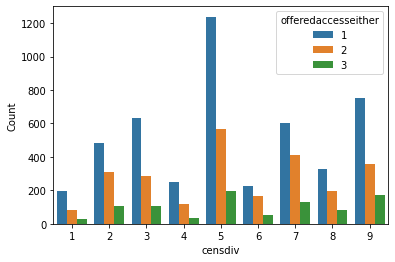

observed data:
 offeredaccesseither     1    2    3
censdiv                            
1                     195   80   28
2                     481  312  106
3                     632  288  106
4                     251  119   37
5                    1238  567  197
6                     226  168   52
7                     603  409  128
8                     330  197   82
9                     755  355  172
expected data:
 [[ 175.92223318   93.17044614   33.90732068]
 [ 521.96068524  276.43640621  100.60290855]
 [ 595.6970668   315.48804535  114.81488785]
 [ 236.30478186  125.14974119   45.54547695]
 [1162.36406211  615.60142963  224.03450826]
 [ 258.94823761  137.14197683   49.90978556]
 [ 661.88562978  350.54227262  127.57209761]
 [ 353.58627064  187.26337195   68.15035741]
 [ 744.33103278  394.20631008  143.46265714]]
chi-squared value: 73.9986 for 16 dof; p-value = 0.0000



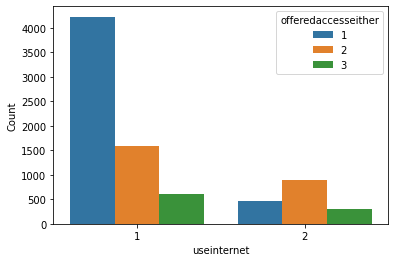

observed data:
 offeredaccesseither     1     2    3
useinternet                         
1                    4225  1596  598
2                     467   888  308
expected data:
 [[3726.54639941 1972.87750557  719.57609503]
 [ 965.45360059  511.12249443  186.42390497]]
chi-squared value: 773.7312 for 2 dof; p-value = 0.0000



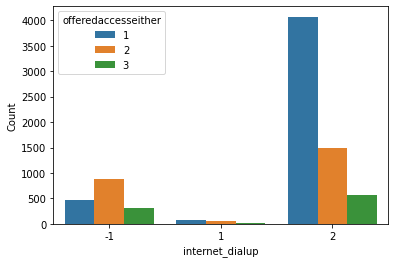

observed data:
 offeredaccesseither     1     2    3
internet_dialup                     
-1                    467   888  308
 1                     80    63   21
 2                   4071  1497  560
expected data:
 [[ 965.39710874  511.75663105  185.84626021]
 [  95.20452546   50.46788184   18.32759271]
 [3557.39836581 1885.77548712  684.82614708]]
chi-squared value: 797.1916 for 4 dof; p-value = 0.0000



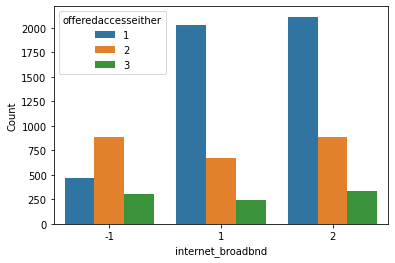

observed data:
 offeredaccesseither     1    2    3
internet_broadbnd                  
-1                    467  888  308
 1                   2030  669  244
 2                   2113  888  335
expected data:
 [[ 965.30219088  511.96612944  185.73167968]
 [1708.28884412  906.02304205  328.68811383]
 [1936.408965   1027.01082851  372.5802065 ]]
chi-squared value: 797.0372 for 4 dof; p-value = 0.0000



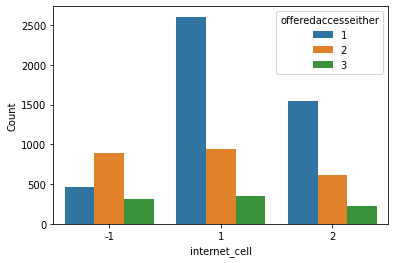

observed data:
 offeredaccesseither     1    2    3
internet_cell                      
-1                    467  888  308
 1                   2604  939  357
 2                   1544  616  226
expected data:
 [[ 965.49817587  511.09686753  186.4049566 ]
 [2264.2470751  1198.60359794  437.14932696]
 [1385.25474903  733.29953453  267.44571644]]
chi-squared value: 779.9226 for 4 dof; p-value = 0.0000



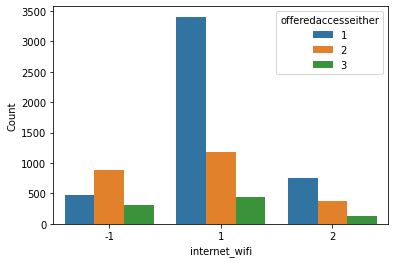

observed data:
 offeredaccesseither     1     2    3
internet_wifi                       
-1                    467   888  308
 1                   3404  1177  447
 2                    754   380  134
expected data:
 [[ 966.37454454  510.87259706  185.7528584 ]
 [2921.78665662 1544.59856766  561.61477573]
 [ 736.83879884  389.52883528  141.63236588]]
chi-squared value: 808.4056 for 4 dof; p-value = 0.0000



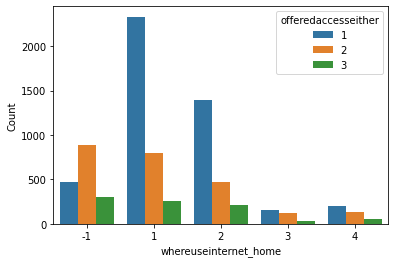

observed data:
 offeredaccesseither       1    2    3
whereuseinternet_home                
-1                      467  888  308
 1                     2329  798  254
 2                     1390  466  210
 3                      153  117   33
 4                      196  132   59
expected data:
 [[ 966.88525641  511.90551282  184.20923077]
 [1965.74807692 1040.74115385  374.51076923]
 [1201.19358974  635.95717949  228.84923077]
 [ 176.16730769   93.26961538   33.56307692]
 [ 225.00576923  119.12653846   42.86769231]]
chi-squared value: 877.4127 for 8 dof; p-value = 0.0000



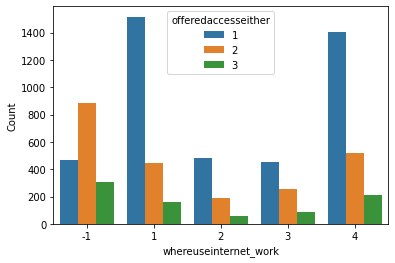

observed data:
 offeredaccesseither       1    2    3
whereuseinternet_work                
-1                      467  888  308
 1                     1516  449  160
 2                      482  193   61
 3                      456  255   90
 4                     1408  516  211
expected data:
 [[ 965.03042895  512.94410188  185.02546917]
 [1233.1266756   655.44571046  236.42761394]
 [ 427.09705094  227.0155496    81.88739946]
 [ 464.81621984  247.06447721   89.11930295]
 [1238.92962466  658.53016086  237.54021448]]
chi-squared value: 842.4094 for 8 dof; p-value = 0.0000



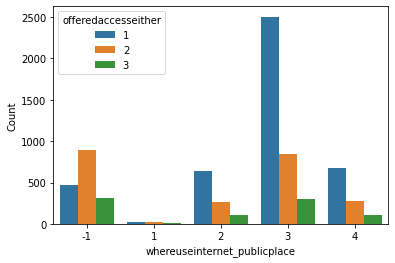

observed data:
 offeredaccesseither              1    2    3
whereuseinternet_publicplace                
-1                             467  888  308
 1                              25   23    7
 2                             634  263  103
 3                            2504  841  301
 4                             677  279  109
expected data:
 [[ 964.1325885   513.51756629  185.3498452 ]
 [  31.88652578   16.98344326    6.13003096]
 [ 579.75501413  308.78987751  111.45510836]
 [2113.78678153 1125.84789339  406.36532508]
 [ 617.43909005  328.86121955  118.6996904 ]]
chi-squared value: 812.3569 for 8 dof; p-value = 0.0000



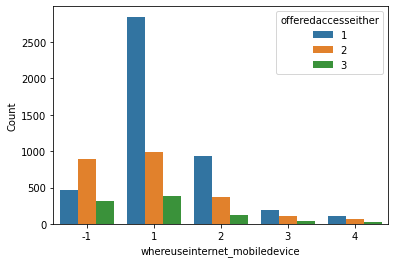

observed data:
 offeredaccesseither               1    2    3
whereuseinternet_mobiledevice                
-1                              467  888  308
 1                             2847  986  383
 2                              937  374  124
 3                              194  104   35
 4                              111   68   24
expected data:
 [[ 965.1755414   512.67006369  185.1543949 ]
 [2446.89121019 1299.70955414  469.39923567]
 [ 832.84840764  442.38216561  159.76942675]
 [ 193.26726115  102.65732484   37.07541401]
 [ 117.81757962   62.58089172   22.60152866]]
chi-squared value: 803.1579 for 8 dof; p-value = 0.0000



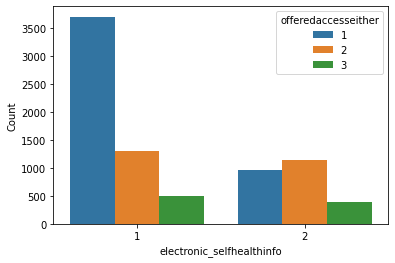

observed data:
 offeredaccesseither           1     2    3
electronic_selfhealthinfo                 
1                          3697  1303  498
2                           963  1148  395
expected data:
 [[3200.98450775 1683.60794603  613.40754623]
 [1459.01549225  767.39205397  279.59245377]]
chi-squared value: 589.6545 for 2 dof; p-value = 0.0000



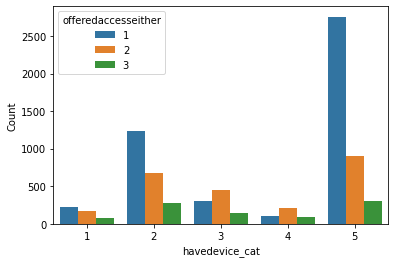

observed data:
 offeredaccesseither     1    2    3
havedevice_cat                     
1                     228  167   72
2                    1240  681  276
3                     308  453  140
4                     110  218   88
5                    2755  898  300
expected data:
 [[ 273.17204437  142.26607008   51.56188556]
 [1285.13700529  669.29026973  242.57272498]
 [ 527.04071086  274.47907739   99.48021175]
 [ 243.3395513   126.72951853   45.93093017]
 [2312.31068818 1204.23506428  436.45424754]]
chi-squared value: 632.5343 for 8 dof; p-value = 0.0000



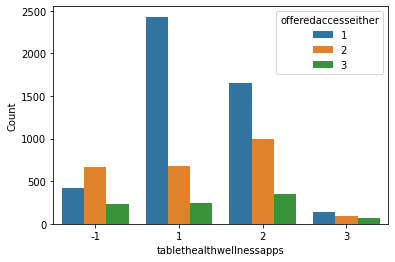

observed data:
 offeredaccesseither          1    2    3
tablethealthwellnessapps                
-1                         418  671  228
 1                        2429  675  246
 2                        1649  993  347
 3                         135   96   66
expected data:
 [[ 766.88381743  403.23085628  146.88532629]
 [1950.69156293 1025.68213253  373.62630454]
 [1740.48271093  915.15340123  333.36388784]
 [ 172.94190871   90.93360996   33.12448133]]
chi-squared value: 715.3271 for 6 dof; p-value = 0.0000



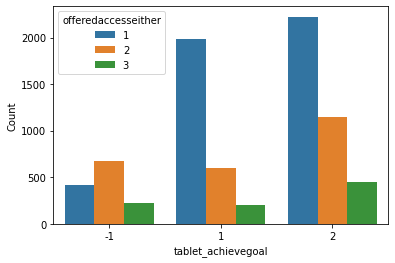

observed data:
 offeredaccesseither     1     2    3
tablet_achievegoal                  
-1                    418   671  228
 1                   1985   604  208
 2                   2223  1143  446
expected data:
 [[ 768.665405    401.77971234  146.55488266]
 [1632.4655564   853.28614686  311.24829674]
 [2224.86903861 1162.9341408   424.19682059]]
chi-squared value: 570.3044 for 4 dof; p-value = 0.0000



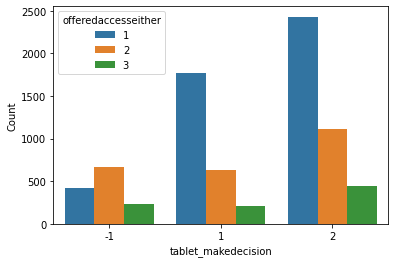

observed data:
 offeredaccesseither     1     2    3
tablet_makedecision                 
-1                    418   671  228
 1                   1769   632  209
 2                   2429  1108  442
expected data:
 [[ 768.94409309  401.63002783  146.42587908]
 [1523.87553757  795.94105742  290.18340501]
 [2323.18036934 1213.42891475  442.39071591]]
chi-squared value: 496.1691 for 4 dof; p-value = 0.0000



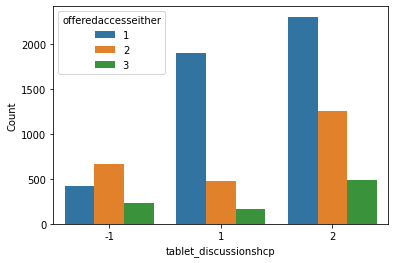

observed data:
 offeredaccesseither       1     2    3
tablet_discussionshcp                 
-1                      418   671  228
 1                     1898   481  165
 2                     2301  1257  486
expected data:
 [[ 769.20796964  401.34762808  146.44440228]
 [1485.85047438  775.2683112   282.88121442]
 [2361.94155598 1232.38406072  449.6743833 ]]
chi-squared value: 667.0853 for 4 dof; p-value = 0.0000



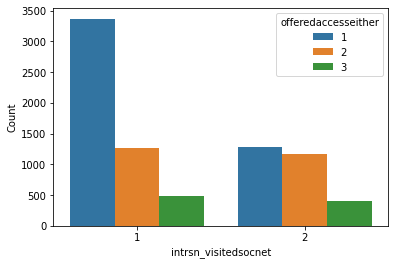

observed data:
 offeredaccesseither      1     2    3
intrsn_visitedsocnet                 
1                     3369  1266  484
2                     1282  1177  400
expected data:
 [[2984.26535473 1567.52531963  567.20932565]
 [1666.73464527  875.47468037  316.79067435]]
chi-squared value: 334.3221 for 2 dof; p-value = 0.0000



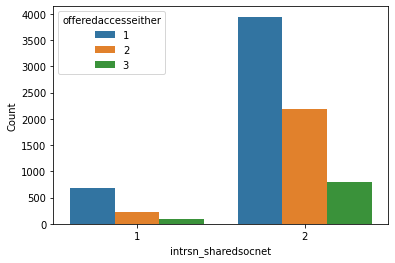

observed data:
 offeredaccesseither     1     2    3
intrsn_sharedsocnet                 
1                     692   234   85
2                    3945  2189  792
expected data:
 [[ 590.65226156  308.6371425   111.71059594]
 [4046.34773844 2114.3628575   765.28940406]]
chi-squared value: 47.9313 for 2 dof; p-value = 0.0000



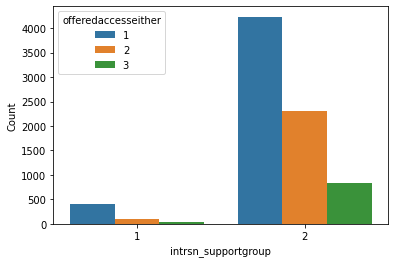

observed data:
 offeredaccesseither     1     2    3
intrsn_supportgroup                 
1                     410   102   38
2                    4232  2316  836
expected data:
 [[ 321.79228636  167.62036804   60.5873456 ]
 [4320.20771364 2250.37963196  813.4126544 ]]
chi-squared value: 62.6305 for 2 dof; p-value = 0.0000



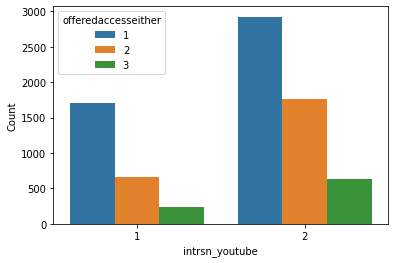

observed data:
 offeredaccesseither     1     2    3
intrsn_youtube                      
1                    1711   664  235
2                    2923  1756  639
expected data:
 [[1525.57265388  796.69525732  287.7320888 ]
 [3108.42734612 1623.30474268  586.2679112 ]]
chi-squared value: 80.9548 for 2 dof; p-value = 0.0000



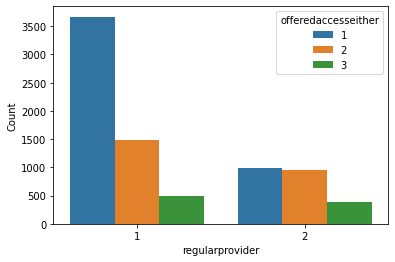

observed data:
 offeredaccesseither     1     2    3
regularprovider                     
1                    3669  1485  498
2                     981   952  387
expected data:
 [[3296.76367285 1727.78775715  627.44856999]
 [1353.23632715  709.21224285  257.55143001]]
chi-squared value: 353.4205 for 2 dof; p-value = 0.0000



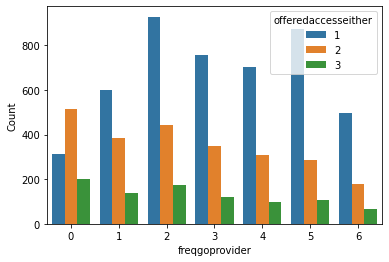

observed data:
 offeredaccesseither    1    2    3
freqgoprovider                    
0                    314  515  199
1                    599  386  136
2                    928  441  175
3                    756  350  119
4                    704  309   96
5                    875  288  105
6                    498  178   65
expected data:
 [[597.91836735 315.58934793 114.49228472]
 [652.01020408 344.13974614 124.85004978]
 [898.04081633 473.99800896 171.96117471]
 [712.5        376.06707317 136.43292683]
 [645.03061224 340.45582379 123.51356396]
 [737.51020408 389.26779492 141.222001  ]
 [430.98979592 227.48220508  82.527999  ]]
chi-squared value: 444.2299 for 12 dof; p-value = 0.0000



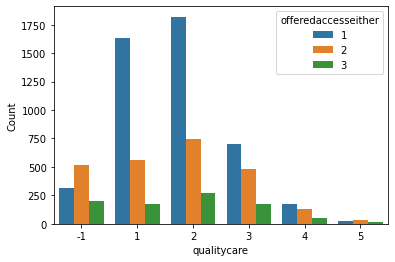

observed data:
 offeredaccesseither     1    2    3
qualitycare                        
-1                    314  515  199
 1                   1637  565  177
 2                   1820  749  273
 3                    700  481  177
 4                    177  129   54
 5                     25   33   15
expected data:
 [[ 597.49303483  316.07164179  114.43532338]
 [1382.71977612  731.45373134  264.82649254]
 [1651.82412935  873.80895522  316.36691542]
 [ 789.29527363  417.53432836  151.17039801]
 [ 209.23880597  110.68656716   40.07462687]
 [  42.4289801    22.44477612    8.12624378]]
chi-squared value: 531.7989 for 10 dof; p-value = 0.0000



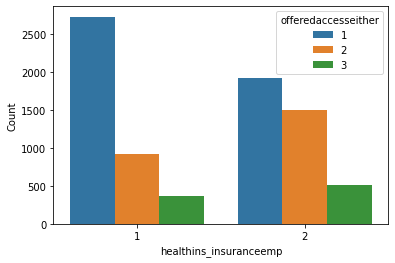

observed data:
 offeredaccesseither        1     2    3
healthins_insuranceemp                 
1                       2724   924  372
2                       1922  1496  514
expected data:
 [[2348.70724346 1223.39034205  447.90241449]
 [2297.29275654 1196.60965795  438.09758551]]
chi-squared value: 295.4633 for 2 dof; p-value = 0.0000



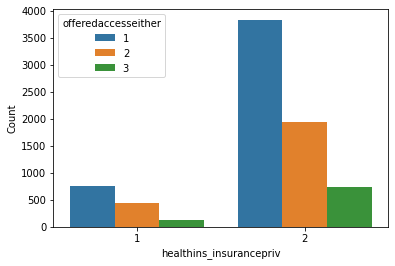

observed data:
 offeredaccesseither         1     2    3
healthins_insurancepriv                 
1                         751   446  137
2                        3838  1938  737
expected data:
 [[ 780.13584809  405.2830381   148.5811138 ]
 [3808.86415191 1978.7169619   725.4188862 ]]
chi-squared value: 7.3271 for 2 dof; p-value = 0.0256



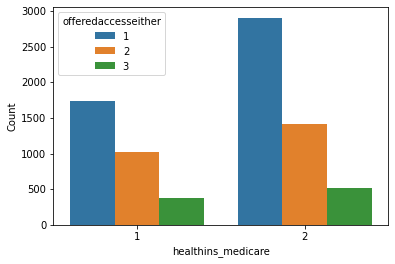

observed data:
 offeredaccesseither     1     2    3
healthins_medicare                  
1                    1739  1021  377
2                    2906  1411  511
expected data:
 [[1829.42435656  957.83854363  349.73709981]
 [2815.57564344 1474.16145637  538.26290019]]
chi-squared value: 17.7508 for 2 dof; p-value = 0.0001



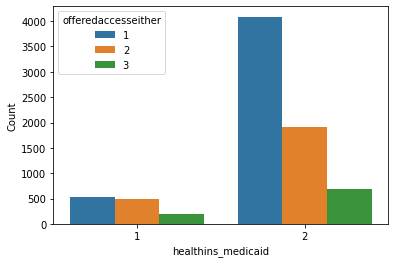

observed data:
 offeredaccesseither     1     2    3
healthins_medicaid                  
1                     521   497  186
2                    4085  1906  689
expected data:
 [[ 703.40233384  366.97260274  133.62506342]
 [3902.59766616 2036.02739726  741.37493658]]
chi-squared value: 134.4293 for 2 dof; p-value = 0.0000



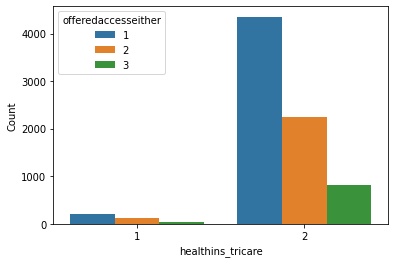

observed data:
 offeredaccesseither     1     2    3
healthins_tricare                   
1                     217   116   35
2                    4353  2239  826
expected data:
 [[ 215.99794503  111.30747496   40.69458002]
 [4354.00205497 2243.69252504  820.30541998]]
chi-squared value: 1.0489 for 2 dof; p-value = 0.5919



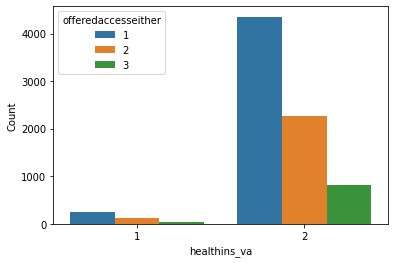

observed data:
 offeredaccesseither     1     2    3
healthins_va                        
1                     258   134   50
2                    4352  2260  823
expected data:
 [[ 258.67970039  134.33388346   48.98641615]
 [4351.32029961 2259.66611654  824.01358385]]
chi-squared value: 0.0250 for 2 dof; p-value = 0.9876



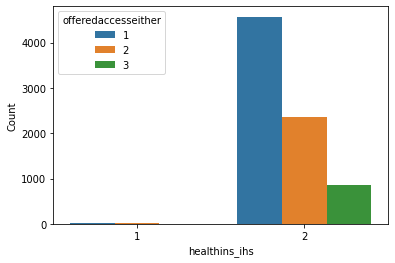

observed data:
 offeredaccesseither     1     2    3
healthins_ihs                       
1                      19    12    6
2                    4572  2357  862
expected data:
 [[2.16999234e+01 1.11973684e+01 4.10270823e+00]
 [4.56930008e+03 2.35780263e+03 8.63897292e+02]]
chi-squared value: 1.2769 for 2 dof; p-value = 0.5281



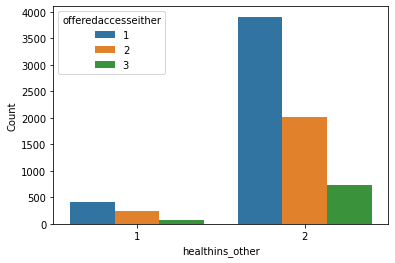

observed data:
 offeredaccesseither     1     2    3
healthins_other                     
1                     410   237   82
2                    3906  2009  727
expected data:
 [[ 426.85714286  222.13186813   80.01098901]
 [3889.14285714 2023.86813187  728.98901099]]
chi-squared value: 1.8981 for 2 dof; p-value = 0.3871



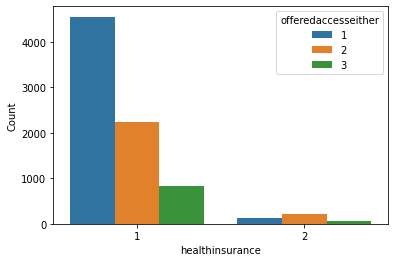

observed data:
 offeredaccesseither     1     2    3
healthinsurance                     
1                    4556  2245  832
2                     118   216   66
expected data:
 [[4441.26005228 2338.45549608  853.28445164]
 [ 232.73994772  122.54450392   44.71554836]]
chi-squared value: 145.1993 for 2 dof; p-value = 0.0000



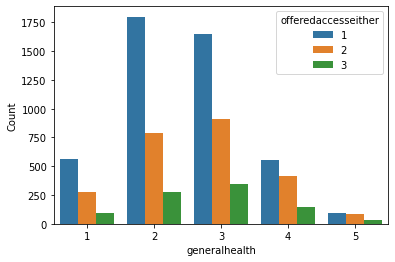

observed data:
 offeredaccesseither     1    2    3
generalhealth                      
1                     567  275   92
2                    1799  785  278
3                    1649  912  342
4                     558  412  144
5                      97   85   34
expected data:
 [[ 543.25320712  287.21459709  103.53219579]
 [1664.65811434  880.09440777  317.24747789]
 [1688.50541786  892.70232906  321.79225308]
 [ 647.94868601  342.56644663  123.48486736]
 [ 125.63457467   66.42221945   23.94320588]]
chi-squared value: 77.3394 for 8 dof; p-value = 0.0000



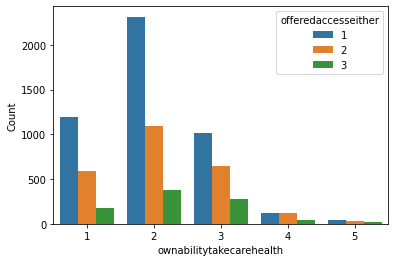

observed data:
 offeredaccesseither          1     2    3
ownabilitytakecarehealth                 
1                         1191   586  178
2                         2314  1090  374
3                         1010   642  272
4                          125   116   46
5                           39    30   24
expected data:
 [[1138.16660445  599.36792335  217.46547219]
 [2199.48513127 1158.26701506  420.24785368]
 [1120.11894986  589.86387956  214.01717059]
 [ 167.08635063   87.98905064   31.92459873]
 [  54.14296379   28.51213139   10.34490482]]
chi-squared value: 104.1923 for 8 dof; p-value = 0.0000



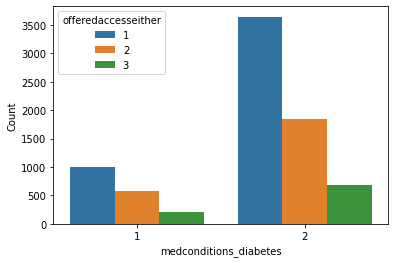

observed data:
 offeredaccesseither        1     2    3
medconditions_diabetes                 
1                        995   585  205
2                       3643  1848  677
expected data:
 [[1040.96944549  546.07129385  197.95926066]
 [3597.03055451 1886.92870615  684.04073934]]
chi-squared value: 6.5187 for 2 dof; p-value = 0.0384



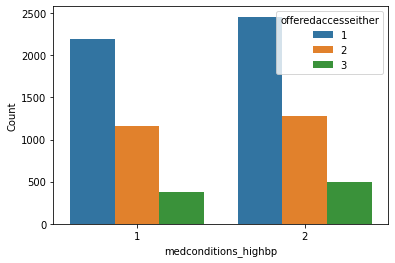

observed data:
 offeredaccesseither      1     2    3
medconditions_highbp                 
1                     2187  1166  384
2                     2455  1275  499
expected data:
 [[2177.64925935 1145.11888024  414.23186041]
 [2464.35074065 1295.88111976  468.76813959]]
chi-squared value: 4.9490 for 2 dof; p-value = 0.0842



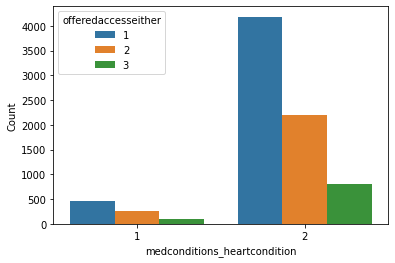

observed data:
 offeredaccesseither              1     2    3
medconditions_heartcondition                 
1                              471   256   89
2                             4182  2190  796
expected data:
 [[ 475.55711423  249.99198397   90.4509018 ]
 [4177.44288577 2196.00801603  794.5490982 ]]
chi-squared value: 0.2354 for 2 dof; p-value = 0.8890



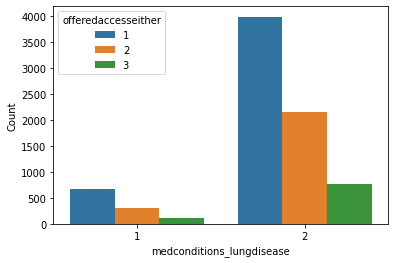

observed data:
 offeredaccesseither           1     2    3
medconditions_lungdisease                 
1                           666   310  109
2                          3990  2147  774
expected data:
 [[ 631.78589295  333.39732366  119.81678339]
 [4024.21410705 2123.60267634  763.18321661]]
chi-squared value: 5.1733 for 2 dof; p-value = 0.0753



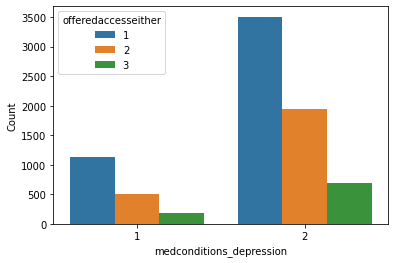

observed data:
 offeredaccesseither          1     2    3
medconditions_depression                 
1                         1134   502  178
2                         3507  1943  698
expected data:
 [[1057.36925396  557.04973625  199.5810098 ]
 [3583.63074604 1887.95026375  676.4189902 ]]
chi-squared value: 17.2598 for 2 dof; p-value = 0.0002



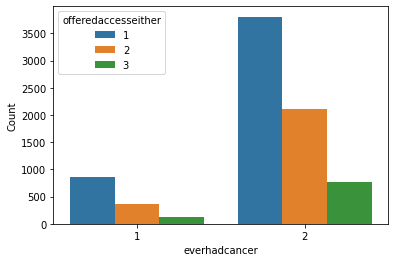

observed data:
 offeredaccesseither     1     2    3
everhadcancer                       
1                     867   361  130
2                    3807  2106  763
expected data:
 [[ 790.05377147  417.00099577  150.94523276]
 [3883.94622853 2049.99900423  742.05476724]]
chi-squared value: 21.5665 for 2 dof; p-value = 0.0000



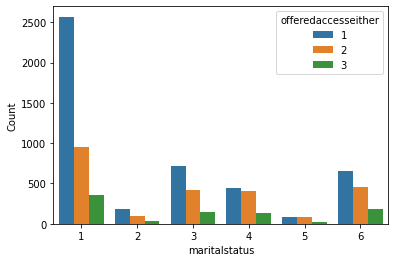

observed data:
 offeredaccesseither     1    2    3
maritalstatus                      
1                    2568  949  361
2                     183   98   38
3                     711  424  142
4                     438  405  128
5                      84   80   24
6                     657  458  179
expected data:
 [[2270.44253816 1180.96278542  426.59467642]
 [ 186.76409739   97.14469535   35.09120727]
 [ 747.64185694  388.88331021  140.47483285]
 [ 568.48883563  295.69748959  106.81367478]
 [ 110.06786931   57.2514192    20.68071149]
 [ 757.59480257  394.06030024  142.34489719]]
chi-squared value: 223.4264 for 10 dof; p-value = 0.0000



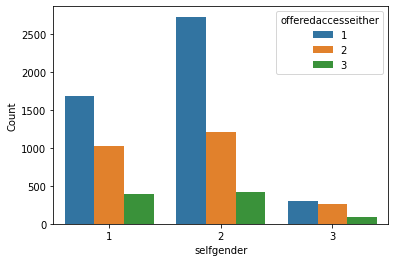

observed data:
 offeredaccesseither     1     2    3
selfgender                          
1                    1687  1024  398
2                    2729  1213  413
3                     295   258   96
expected data:
 [[1805.31233822  956.11426106  347.57340071]
 [2528.8308887  1339.29804018  486.87107112]
 [ 376.85677308  199.58769876   72.55552816]]
chi-squared value: 101.3031 for 4 dof; p-value = 0.0000



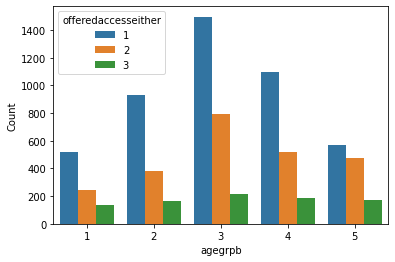

observed data:
 offeredaccesseither     1    2    3
agegrpb                            
1                     517  243  133
2                     931  380  163
3                    1497  794  212
4                    1100  520  190
5                     568  474  170
expected data:
 [[ 521.97275722  272.81082108   98.21642169]
 [ 861.5765332   450.30587937  162.11758743]
 [1463.04346173  764.66459706  275.29194121]
 [1057.97389762  552.95362392  199.07247846]
 [ 708.43335023  370.26507856  133.30157121]]
chi-squared value: 119.7150 for 8 dof; p-value = 0.0000



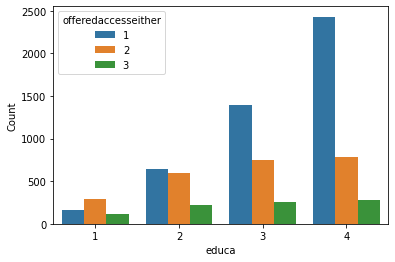

observed data:
 offeredaccesseither     1    2    3
educa                              
1                     164  289  113
2                     648  598  225
3                    1398  748  257
4                    2432  783  280
expected data:
 [[ 331.11178324  172.47485822   62.41335854]
 [ 860.53963453  448.25179584  162.20856963]
 [1405.76257089  732.2563327   264.98109641]
 [2044.58601134 1065.01701323  385.39697543]]
chi-squared value: 508.4264 for 6 dof; p-value = 0.0000



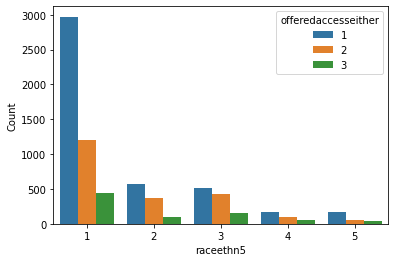

observed data:
 offeredaccesseither     1     2    3
raceethn5                           
1                    2972  1205  441
2                     566   368   91
3                     514   430  155
4                     172    95   56
5                     165    56   38
expected data:
 [[2767.39513927 1358.16111415  492.44374659]
 [ 614.24426543  301.45412343  109.30161114]
 [ 658.58970508  323.21764063  117.19265429]
 [ 193.56185145   94.99481158   34.44333697]
 [ 155.20903878   76.17231021   27.61865101]]
chi-squared value: 164.2913 for 8 dof; p-value = 0.0000



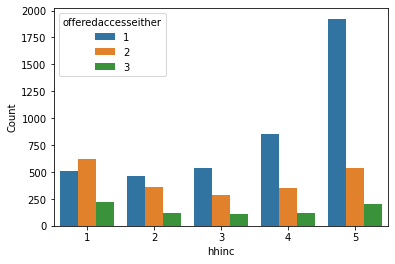

observed data:
 offeredaccesseither     1    2    3
hhinc                              
1                     506  625  225
2                     466  363  121
3                     539  283  111
4                     853  350  117
5                    1924  534  202
expected data:
 [[ 805.44784596  404.79013714  145.7620169 ]
 [ 564.28868264  283.59191024  102.11940712]
 [ 554.19088516  278.51710763  100.2920072 ]
 [ 784.06427483  394.04349633  141.89222884]
 [1580.0083114   794.05734866  285.93433994]]
chi-squared value: 518.7280 for 8 dof; p-value = 0.0000



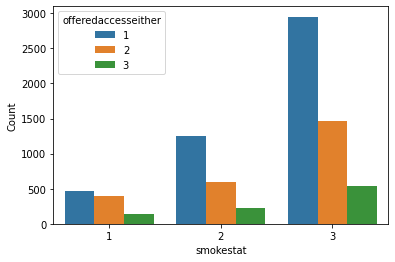

observed data:
 offeredaccesseither     1     2    3
smokestat                           
1                     461   396  133
2                    1246   600  226
3                    2952  1464  532
expected data:
 [[ 575.83146067  304.04494382  110.12359551]
 [1205.17453184  636.34456929  230.48089888]
 [2877.99400749 1519.61048689  550.39550562]]
chi-squared value: 63.5613 for 4 dof; p-value = 0.0000



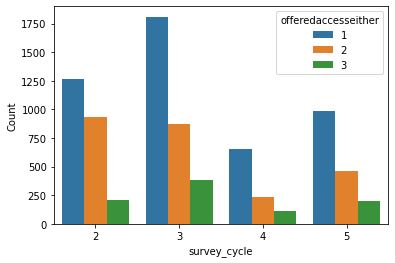

observed data:
 offeredaccesseither     1    2    3
survey_cycle                       
2                    1264  930  210
3                    1809  869  387
4                     650  234  115
5                     988  462  196
expected data:
 [[1395.76583683  739.21370471  269.02045847]
 [1779.54338181  942.46672418  342.98989401]
 [ 580.0208282   307.18572837  111.79344343]
 [ 955.66995317  506.13384274  184.19620409]]
chi-squared value: 118.1596 for 6 dof; p-value = 0.0000



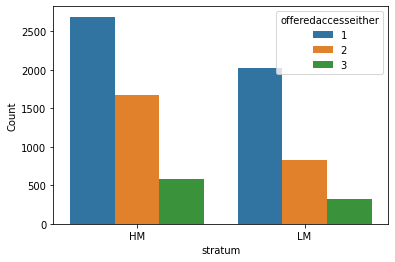

observed data:
 offeredaccesseither     1     2    3
stratum                             
HM                   2688  1669  583
LM                   2023   826  325
expected data:
 [[2868.17106236 1519.01651467  552.81242297]
 [1842.82893764  975.98348533  355.18757703]]
chi-squared value: 71.0046 for 2 dof; p-value = 0.0000



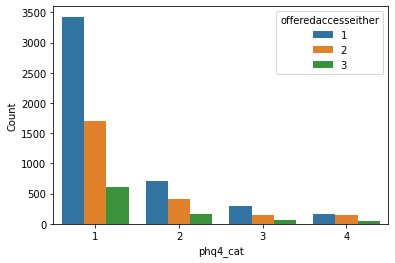

observed data:
 offeredaccesseither     1     2    3
phq4_cat                            
1                    3428  1698  610
2                     710   410  161
3                     289   147   60
4                     172   142   45
expected data:
 [[3351.10060976 1746.5945122   638.30487805]
 [ 748.38910061  390.06059451  142.55030488]
 [ 289.77439024  151.0304878    55.19512195]
 [ 209.73589939  109.31440549   39.94969512]]
chi-squared value: 27.4772 for 6 dof; p-value = 0.0001



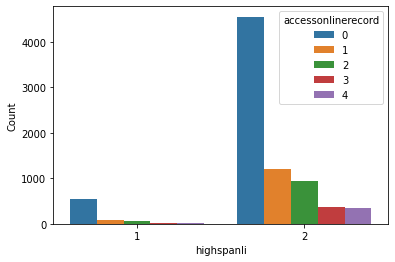

observed data:
 accessonlinerecord     0     1    2    3    4
highspanli                                   
1                    545    83   56   23   15
2                   4550  1206  931  365  340
expected data:
 [[ 453.36332265  114.69780626   87.82524033   34.52501849   31.58861228]
 [4641.63667735 1174.30219374  899.17475967  353.47498151  323.41138772]]
chi-squared value: 56.3912 for 4 dof; p-value = 0.0000



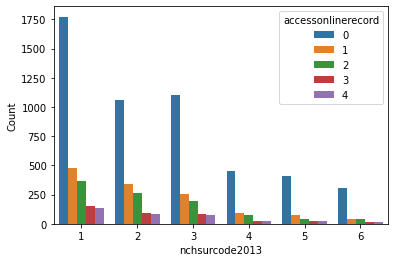

observed data:
 accessonlinerecord     0    1    2    3    4
nchsurcode2013                              
1                   1773  482  368  156  132
2                   1056  339  264   93   87
3                   1101  253  197   80   74
4                    452   96   74   23   22
5                    408   75   45   21   23
6                    305   44   39   15   17
expected data:
 [[1827.89561252  462.44503328  354.09871826  139.1999014   127.36073453]
 [1154.75782598  292.14579739  223.69891545   87.93837811   80.45908307]
 [1070.61560266  270.8583929   207.3989401    81.5306877    74.59637663]
 [ 418.82733547  105.96043875   81.13495193   31.8949963    29.18227754]
 [ 359.1742667    90.86862213   69.57899926   27.35223071   25.02588119]
 [ 263.72935667   66.72171555   51.08947498   20.08380577   18.37564703]]
chi-squared value: 78.4732 for 20 dof; p-value = 0.0000



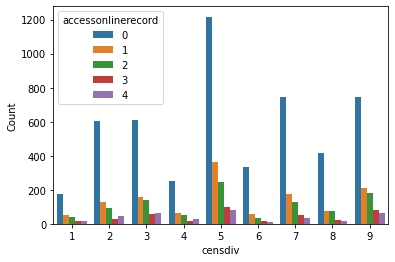

observed data:
 accessonlinerecord     0    1    2   3   4
censdiv                                   
1                    178   51   41  15  18
2                    603  130   92  31  43
3                    608  159  139  58  62
4                    253   61   49  18  26
5                   1217  363  246  97  79
6                    331   59   33  14   9
7                    745  176  130  54  35
8                    417   77   75  22  18
9                    743  213  182  79  65
expected data:
 [[ 190.26189302   48.13495193   36.85740695   14.4890313    13.25671679]
 [ 564.50640868  142.81624353  109.35580478   42.98890806   39.33263495]
 [ 644.25314272  162.99161942  124.80428888   49.06186838   44.8890806 ]
 [ 255.56630515   64.6565196    49.50813409   19.46216416   17.806877  ]
 [1257.10993345  318.04017747  243.52649741   95.73280749   87.59058418]
 [ 280.0554597    70.85210747   54.25215677   21.32708898   19.51318708]
 [ 715.83682524  181.10179936  138.67143209   54.51318708

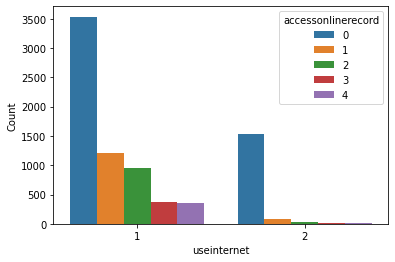

observed data:
 accessonlinerecord     0     1    2    3    4
useinternet                                  
1                   3534  1208  954  374  349
2                   1537    77   32   11    6
expected data:
 [[4027.56112348 1020.5908191   783.11482306  305.78012868  281.95310567]
 [1043.43887652  264.4091809   202.88517694   79.21987132   73.04689433]]
chi-squared value: 793.8634 for 4 dof; p-value = 0.0000



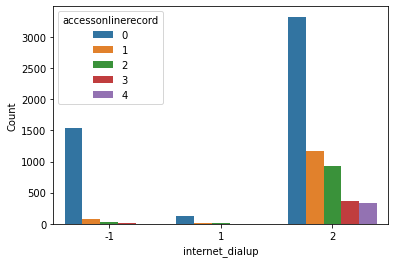

observed data:
 accessonlinerecord     0     1    2    3    4
internet_dialup                              
-1                  1537    77   32   11    6
 1                   127    18   12    2    5
 2                  3325  1170  928  365  340
expected data:
 [[1042.95499686  264.44940289  203.19748586   79.0212445    73.37686989]
 [ 102.8530484    26.07919547   20.03871779    7.7928347     7.23620365]
 [3843.19195475  974.47140163  748.76379635  291.1859208   270.38692646]]
chi-squared value: 836.5896 for 8 dof; p-value = 0.0000



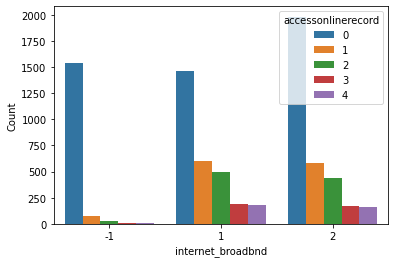

observed data:
 accessonlinerecord     0    1    2    3    4
internet_broadbnd                           
-1                  1537   77   32   11    6
 1                  1463  605  500  193  182
 2                  1981  581  438  173  163
expected data:
 [[1042.98703097  264.46348527  203.11130698   78.94119869   73.49697809]
 [1845.76718711  468.01926467  359.44472425  139.70171242  130.06711156]
 [2092.24578192  530.51725006  407.44396877  158.35708889  147.43591035]]
chi-squared value: 862.9938 for 8 dof; p-value = 0.0000



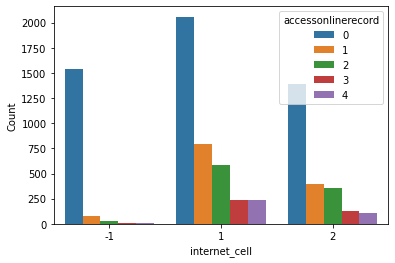

observed data:
 accessonlinerecord     0    1    2    3    4
internet_cell                               
-1                  1537   77   32   11    6
 1                  2058  790  583  234  235
 2                  1389  398  356  132  111
expected data:
 [[1042.6961882   264.64901245  203.14165304   78.87168197   73.64146434]
 [2445.28871556  620.64410618  476.39954711  184.96666247  172.70096868]
 [1496.01509624  379.70688137  291.45879985  113.16165555  105.65756699]]
chi-squared value: 825.2136 for 8 dof; p-value = 0.0000



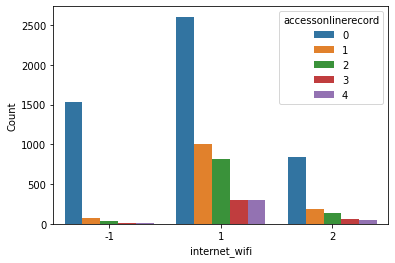

observed data:
 accessonlinerecord     0     1    2    3    4
internet_wifi                                
-1                  1537    77   32   11    6
 1                  2607  1009  811  306  295
 2                   843   182  131   61   51
expected data:
 [[1042.01294132  264.94333459  203.51325543   78.98153034   73.54893831]
 [3150.4756879   801.04334715  615.31247644  238.79683377  222.37165473]
 [ 794.51137078  202.01331826  155.17426812   60.22163588   56.07940696]]
chi-squared value: 895.3380 for 8 dof; p-value = 0.0000



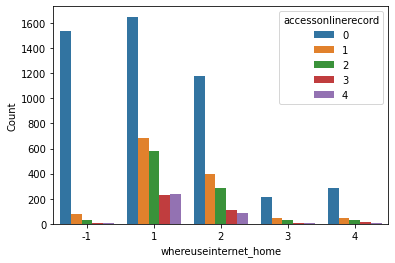

observed data:
 accessonlinerecord        0    1    2    3    4
whereuseinternet_home                          
-1                     1537   77   32   11    6
 1                     1650  682  578  234  237
 2                     1182  397  289  109   89
 3                      215   46   28    6    8
 4                      289   45   30   17    6
expected data:
 [[1038.94858974  265.86679487  204.03730769   80.37833333   73.76897436]
 [2112.25807692  540.52653846  414.82269231  163.415       149.97769231]
 [1290.72025641  330.29512821  253.48230769   99.85666667   91.64564103]
 [ 189.29730769   48.44115385   37.17576923   14.645        13.44076923]
 [ 241.77576923   61.87038462   47.48192308   18.705        17.16692308]]
chi-squared value: 992.8642 for 16 dof; p-value = 0.0000



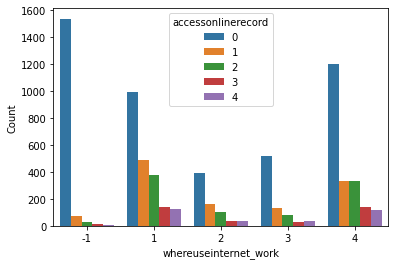

observed data:
 accessonlinerecord        0    1    2    3    4
whereuseinternet_work                          
-1                     1537   77   32   11    6
 1                      994  490  376  137  128
 2                      393  164  102   40   37
 3                      520  133   78   32   38
 4                     1205  332  336  141  121
expected data:
 [[1036.3655496   266.6150134   205.98016086   80.47493298   73.56434316]
 [1324.27949062  340.68364611  263.20375335  102.83176944   94.00134048]
 [ 458.66809651  117.99678284   91.1613941    35.61608579   32.55764075]
 [ 499.17546917  128.41769437   99.21233244   38.76152815   35.43297587]
 [1330.5113941   342.28686327  264.44235925  103.31568365   94.44369973]]
chi-squared value: 954.9111 for 16 dof; p-value = 0.0000



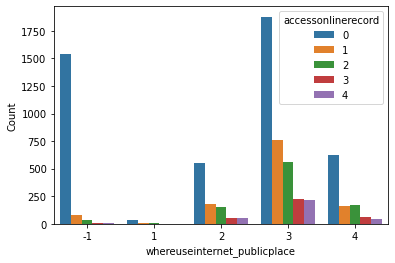

observed data:
 accessonlinerecord               0    1    2    3    4
whereuseinternet_publicplace                          
-1                            1537   77   32   11    6
 1                              38    9    6    1    1
 2                             554  180  154   57   55
 3                            1877  762  563  227  217
 4                             626  160  168   65   46
expected data:
 [[1036.88464127  265.93673442  206.61582986   80.81074169   72.75205277]
 [  34.29263696    8.79526181    6.83335577    2.67263427    2.40611119]
 [ 623.50249024  159.91385112  124.24283214   48.59335038   43.74747611]
 [2273.29007942  583.0459012   452.989366    177.1713555   159.50329789]
 [ 664.03015211  170.30825145  132.31861623   51.75191816   46.59106205]]
chi-squared value: 869.9873 for 16 dof; p-value = 0.0000



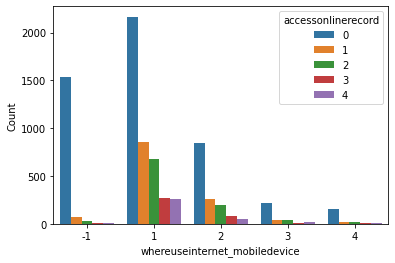

observed data:
 accessonlinerecord                0    1    2    3    4
whereuseinternet_mobiledevice                          
-1                             1537   77   32   11    6
 1                             2164  852  673  266  261
 2                              843  262  197   78   55
 3                              220   44   40   12   17
 4                              152   19   17    6    9
expected data:
 [[1041.44050955  265.65630573  203.16140127   79.01898089   73.72280255]
 [2640.23643312  673.48585987  515.05019108  200.32713376  186.90038217]
 [ 898.65732484  229.2343949   175.30764331   68.18535032   63.61528662]
 [ 208.53859873   53.19515924   40.6811465    15.82280255   14.76229299]
 [ 127.12713376   32.42828025   24.79961783    9.64573248    8.99923567]]
chi-squared value: 898.4550 for 16 dof; p-value = 0.0000



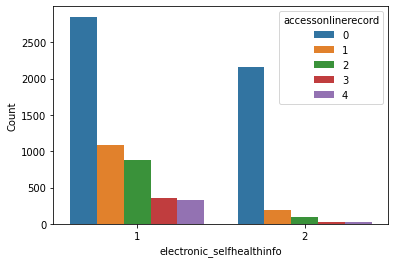

observed data:
 accessonlinerecord            0     1    2    3    4
electronic_selfhealthinfo                           
1                          2849  1089  880  352  328
2                          2161   190   99   31   25
expected data:
 [[3441.4017991   878.55347326  672.48150925  263.0852074   242.47801099]
 [1568.5982009   400.44652674  306.51849075  119.9147926   110.52198901]]
chi-squared value: 883.5609 for 4 dof; p-value = 0.0000



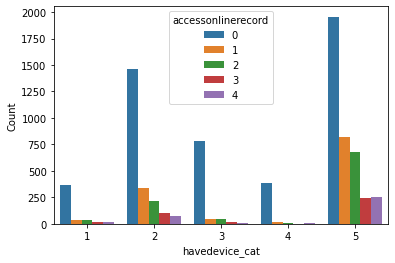

observed data:
 accessonlinerecord     0    1    2    3    4
havedevice_cat                              
1                    365   39   35   14   14
2                   1459  343  219  104   72
3                    786   48   42   14   11
4                    383   19    7    3    4
5                   1955  822  676  248  252
expected data:
 [[ 291.24224855   74.81182254   57.62452735   22.54360978   20.77779178]
 [1370.14822284  351.95197883  271.09440383  106.0563398    97.7490547 ]
 [ 561.90420973  144.33715654  111.17708596   43.49420217   40.0873456 ]
 [ 259.43634989   66.64179481   51.33148475   20.08167381   18.50869675]
 [2465.26896899  633.25724729  487.77249811  190.82417444  175.87711117]]
chi-squared value: 752.4838 for 16 dof; p-value = 0.0000



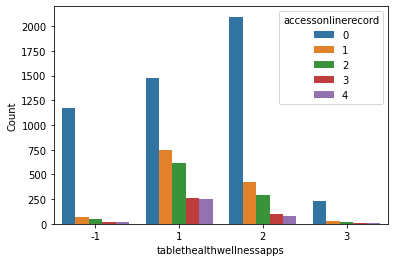

observed data:
 accessonlinerecord           0    1    2    3    4
tablethealthwellnessapps                          
-1                        1169   67   49   17   15
 1                        1477  744  611  263  255
 2                        2095  427  296   97   74
 3                         234   29   21    4    9
expected data:
 [[ 823.84949076  209.81252358  161.78913618   63.09279517   58.45605432]
 [2095.59285804  533.69168867  411.5365271   160.48660883  148.69231736]
 [1869.76926946  476.18043506  367.18885955  143.19238023  132.6690557 ]
 [ 185.78838174   47.3153527    36.48547718   14.22821577   13.18257261]]
chi-squared value: 1011.7653 for 12 dof; p-value = 0.0000



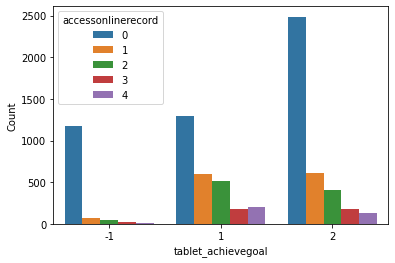

observed data:
 accessonlinerecord     0    1    2    3    4
tablet_achievegoal                          
-1                  1169   67   49   17   15
 1                  1297  595  518  184  203
 2                  2485  607  408  177  135
expected data:
 [[ 822.6680545   210.85957608  162.00794852   62.80923543   58.65518547]
 [1747.15455463  447.81642695  344.0669947   133.39212718  124.56989654]
 [2381.17739087  610.32399697  468.92505678  181.7986374   169.77491799]]
chi-squared value: 729.2539 for 8 dof; p-value = 0.0000



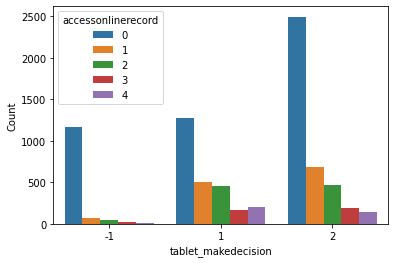

observed data:
 accessonlinerecord      0    1    2    3    4
tablet_makedecision                          
-1                   1169   67   49   17   15
 1                   1275  509  455  173  198
 2                   2495  690  467  188  139
expected data:
 [[ 822.75018973  210.89324564  161.75145459   62.96812547   58.63698457]
 [1630.50720971  417.94333418  320.55527448  124.78876802  116.20541361]
 [2485.74260056  637.16342019  488.69327093  190.2431065   177.15760182]]
chi-squared value: 632.0859 for 8 dof; p-value = 0.0000



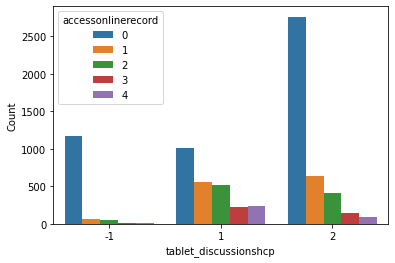

observed data:
 accessonlinerecord        0    1    2    3    4
tablet_discussionshcp                          
-1                     1169   67   49   17   15
 1                     1009  556  517  222  240
 2                     2761  641  406  139   97
expected data:
 [[ 822.85426945  210.58671727  161.93851992   62.97609108   58.64440228]
 [1589.47703985  406.78254269  312.81062619  121.64857685  113.28121442]
 [2526.6686907   646.63074004  497.25085389  193.37533207  180.0743833 ]]
chi-squared value: 1105.0139 for 8 dof; p-value = 0.0000



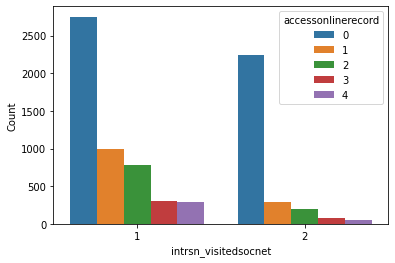

observed data:
 accessonlinerecord       0    1    2    3    4
intrsn_visitedsocnet                          
1                     2749  991  776  308  295
2                     2240  285  200   77   57
expected data:
 [[3201.13950865  818.73201304  626.24016044  247.03121083  225.85710704]
 [1787.86049135  457.26798696  349.75983956  137.96878917  126.14289296]]
chi-squared value: 480.3448 for 4 dof; p-value = 0.0000



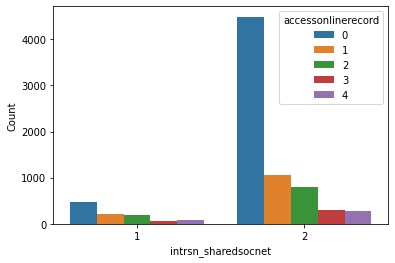

observed data:
 accessonlinerecord      0     1    2    3    4
intrsn_sharedsocnet                           
1                     470   208  183   73   77
2                    4486  1066  789  310  275
expected data:
 [[ 631.28587628  162.27970266  123.81151569   48.78581328   44.8370921 ]
 [4324.71412372 1111.72029734  848.18848431  334.21418672  307.1629079 ]]
chi-squared value: 134.6204 for 4 dof; p-value = 0.0000



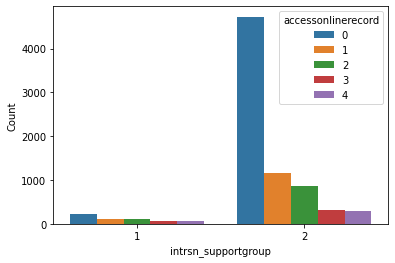

observed data:
 accessonlinerecord      0     1    2    3    4
intrsn_supportgroup                           
1                     222   106  106   55   61
2                    4728  1170  867  328  291
expected data:
 [[ 343.14343332   88.4547517    67.45021427   26.55028989   24.40131081]
 [4606.85656668 1187.5452483   905.54978573  356.44971011  327.59868919]]
chi-squared value: 165.1045 for 4 dof; p-value = 0.0000



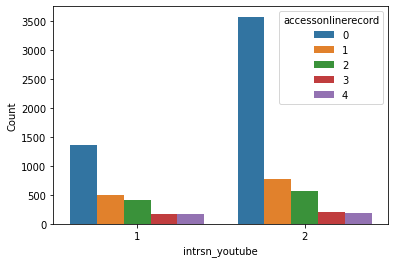

observed data:
 accessonlinerecord     0    1    2    3    4
intrsn_youtube                              
1                   1370  497  409  169  165
2                   3575  778  565  213  187
expected data:
 [[1627.95787084  419.74646821  320.65338042  125.75933401  115.88294652]
 [3317.04212916  855.25353179  653.34661958  256.24066599  236.11705348]]
chi-squared value: 171.6199 for 4 dof; p-value = 0.0000



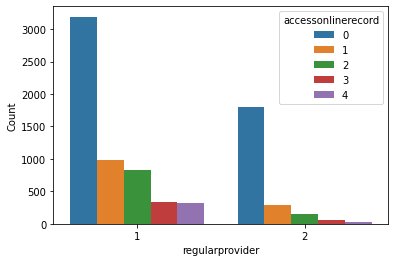

observed data:
 accessonlinerecord     0    1    2    3    4
regularprovider                             
1                   3192  986  824  331  319
2                   1797  283  156   52   32
expected data:
 [[3537.10837933  899.69744104  694.80180632  271.53988961  248.85248369]
 [1451.89162067  369.30255896  285.19819368  111.46011039  102.14751631]]
chi-squared value: 339.3874 for 4 dof; p-value = 0.0000



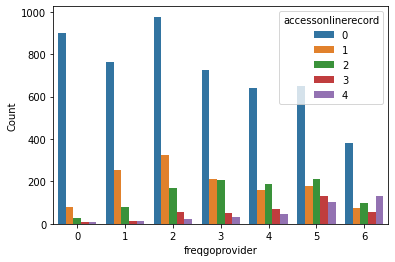

observed data:
 accessonlinerecord    0    1    2    3    4
freqgoprovider                             
0                   902   81   29    8    8
1                   764  252   77   15   13
2                   977  324  168   54   21
3                   724  211  207   50   33
4                   642  161  190   72   44
5                   649  176  210  130  103
6                   380   73   99   57  132
expected data:
 [[644.48282728 163.48730712 125.36585366  49.37879542  45.28521653]
 [702.78720757 178.27750124 136.70731707  53.84594326  49.38203086]
 [967.97809856 245.54902937 188.29268293  74.16426083  68.01592832]
 [767.98780488 194.81707317 149.3902439   58.84146341  53.96341463]
 [695.26406172 176.3690891  135.24390244  53.26953708  48.85340966]
 [794.94574415 201.65555002 154.63414634  60.90691887  55.85764062]
 [464.55425585 117.84444998  90.36585366  35.59308113  32.64235938]]
chi-squared value: 1052.8444 for 24 dof; p-value = 0.0000



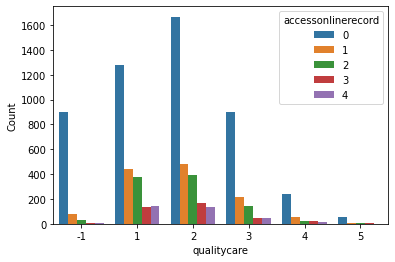

observed data:
 accessonlinerecord     0    1    2    3    4
qualitycare                                 
-1                   902   81   29    8    8
 1                  1282  440  378  135  144
 2                  1667  478  395  166  136
 3                   897  217  146   49   49
 4                   241   58   25   21   15
 5                    55    6    4    6    2
expected data:
 [[ 644.92935323  163.66169154  124.9199005    49.22636816   45.26268657]
 [1492.49701493  378.74626866  289.08992537  113.91977612  104.74701493]
 [1782.96616915  452.45771144  345.35248756  136.09079602  125.13283582]
 [ 851.95920398  216.19900498  165.02064677   65.02860697   59.79253731]
 [ 225.85074627   57.31343284   43.74626866   17.23880597   15.85074627]
 [  45.79751244   11.62189055    8.87077114    3.49564677    3.2141791 ]]
chi-squared value: 422.1580 for 20 dof; p-value = 0.0000



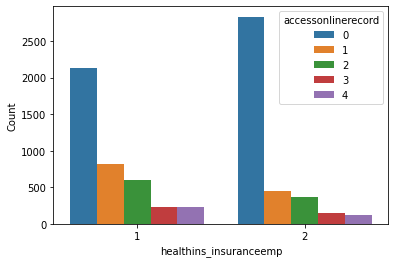

observed data:
 accessonlinerecord         0    1    2    3    4
healthins_insuranceemp                          
1                       2129  824  606  234  227
2                       2833  452  369  151  127
expected data:
 [[2508.45573441  645.06036217  492.89486922  194.63028169  178.95875252]
 [2453.54426559  630.93963783  482.10513078  190.36971831  175.04124748]]
chi-squared value: 311.1493 for 4 dof; p-value = 0.0000



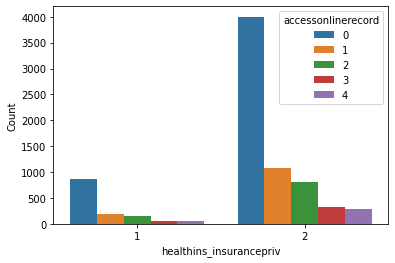

observed data:
 accessonlinerecord          0     1    2    3    4
healthins_insurancepriv                           
1                         876   183  155   65   55
2                        4000  1086  813  320  294
expected data:
 [[ 828.92621384  215.73161718  164.56123359   65.45049063   59.33044476]
 [4047.07378616 1053.26838282  803.43876641  319.54950937  289.66955524]]
chi-squared value: 10.2580 for 4 dof; p-value = 0.0363



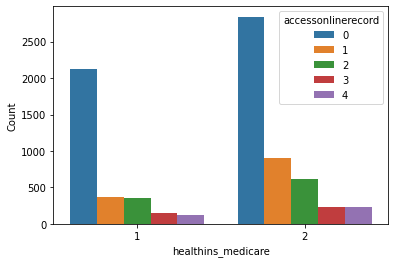

observed data:
 accessonlinerecord     0    1    2    3    4
healthins_medicare                          
1                   2130  369  357  155  126
2                   2842  907  620  230  229
expected data:
 [[1958.21268048  502.55015694  384.78957941  151.63151287  139.81607031]
 [3013.78731952  773.44984306  592.21042059  233.36848713  215.18392969]]
chi-squared value: 89.0992 for 4 dof; p-value = 0.0000



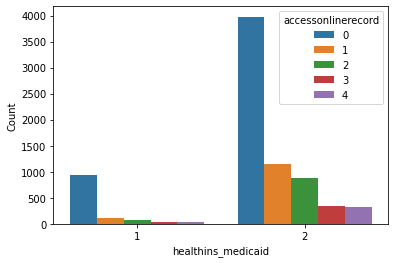

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_medicaid                           
1                    934   121   82   33   34
2                   3976  1149  888  348  319
expected data:
 [[ 749.82749873  193.94723491  148.13292745   58.18417047   53.90816844]
 [4160.17250127 1076.05276509  821.86707255  322.81582953  299.09183156]]
chi-squared value: 142.1604 for 4 dof; p-value = 0.0000



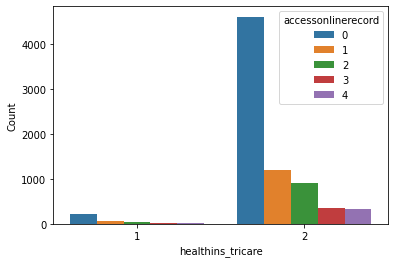

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_tricare                            
1                    230    61   44   20   13
2                   4612  1196  920  356  334
expected data:
 [[ 228.85384023   59.41125096   45.56280503   17.77138454   16.40071924]
 [4613.14615977 1197.58874904  918.43719497  358.22861546  330.59928076]]
chi-squared value: 1.1404 for 4 dof; p-value = 0.8878



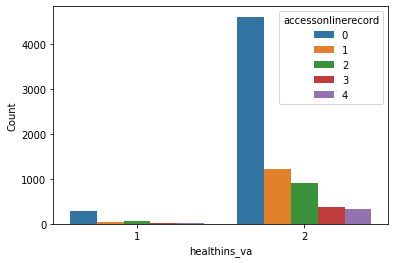

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_va                                 
1                    293    52   61   16   20
2                   4612  1213  911  366  333
expected data:
 [[ 275.23295671   70.98260759   54.54157674   21.43506411   19.80779485]
 [4629.76704329 1194.01739241  917.45842326  360.56493589  333.19220515]]
chi-squared value: 8.8656 for 4 dof; p-value = 0.0645



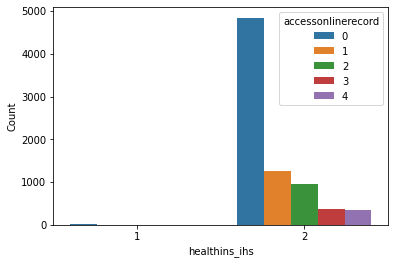

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_ihs                                
1                     25     5    4    1    2
2                   4842  1257  964  378  350
expected data:
 [[2.30044711e+01 5.96499745e+00 4.57537046e+00 1.79138988e+00
  1.66377108e+00]
 [4.84399553e+03 1.25603500e+03 9.63424630e+02 3.77208610e+02
  3.50336229e+02]]
chi-squared value: 0.8230 for 4 dof; p-value = 0.9353



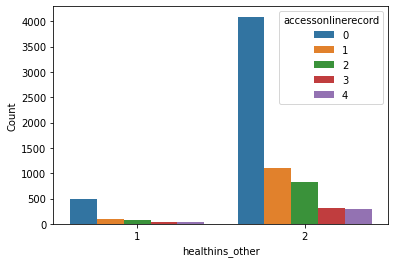

observed data:
 accessonlinerecord     0     1    2    3    4
healthins_other                              
1                    489    89   81   37   33
2                   4088  1101  830  323  300
expected data:
 [[ 452.67032967  117.69230769   90.0989011    35.6043956    32.93406593]
 [4124.32967033 1072.30769231  820.9010989   324.3956044   300.06593407]]
chi-squared value: 12.0789 for 4 dof; p-value = 0.0168



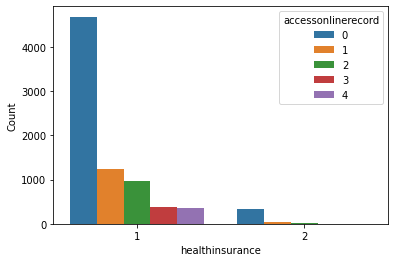

observed data:
 accessonlinerecord     0     1    2    3    4
healthinsurance                              
1                   4688  1245  965  383  352
2                    341    37   16    3    3
expected data:
 [[4778.58297025 1218.16332628  932.15150006  366.77928545  337.32291796]
 [ 250.41702975   63.83667372   48.84849994   19.22071455   17.67708204]]
chi-squared value: 96.8347 for 4 dof; p-value = 0.0000



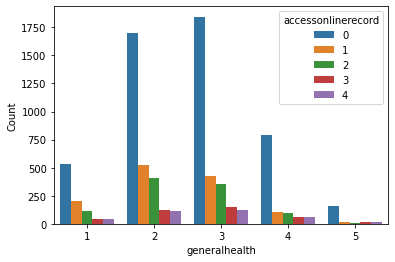

observed data:
 accessonlinerecord     0    1    2    3    4
generalhealth                               
1                    537  202  115   41   39
2                   1697  525  404  124  112
3                   1845  429  355  148  126
4                    793  106   92   59   64
5                    163   16   11   13   13
expected data:
 [[ 585.71304023  148.66758002  113.65275875   44.7863993    41.1802217 ]
 [1794.76522606  455.55311994  348.25931     137.23626853  126.18607548]
 [1820.47639806  462.07921285  353.24834973  139.20226678  127.99377257]
 [ 698.59135633  177.31871964  135.55586001   53.41761116   49.11645286]
 [ 135.45397932   34.38136754   26.28372151   10.35745423    9.52347739]]
chi-squared value: 141.4263 for 16 dof; p-value = 0.0000



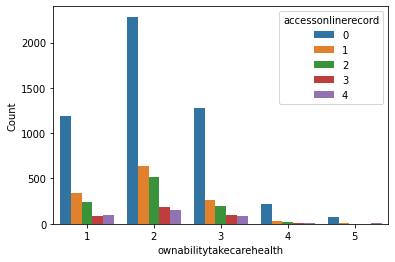

observed data:
 accessonlinerecord           0    1    2    3    4
ownabilitytakecarehealth                          
1                         1186  339  246   84  100
2                         2285  642  511  183  157
3                         1278  262  201  101   82
4                          216   29   18   14   10
5                           71   11    2    3    6
expected data:
 [[1225.00684335  312.08971009  237.89846958   93.65123802   86.35373896]
 [2367.3022272   603.10737838  459.73422919  180.9792211   166.87694413]
 [1205.58218241  307.140973    234.12616648   92.16623118   84.98444693]
 [ 179.83476422   45.81572726   34.92422546   13.74828916   12.6769939 ]
 [  58.27398283   14.84621127   11.31690929    4.45502053    4.10787607]]
chi-squared value: 70.3145 for 16 dof; p-value = 0.0000



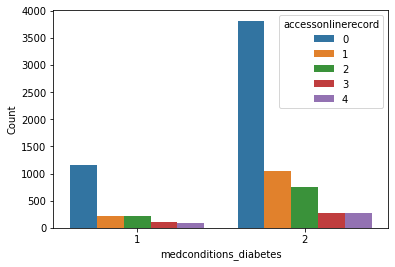

observed data:
 accessonlinerecord         0     1    2    3    4
medconditions_diabetes                           
1                       1159   222  222  101   81
2                       3814  1051  752  281  270
expected data:
 [[1116.15805356  285.71671068  218.60807243   85.73745756   78.77970577]
 [3856.84194644  987.28328932  755.39192757  296.26254244  272.22029423]]
chi-squared value: 24.0935 for 4 dof; p-value = 0.0001



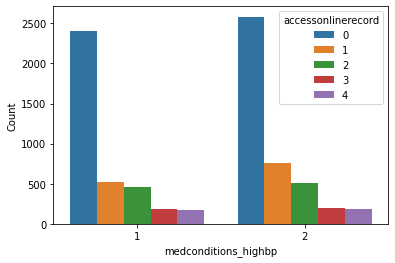

observed data:
 accessonlinerecord       0    1    2    3    4
medconditions_highbp                          
1                     2404  518  463  182  170
2                     2581  753  512  201  182
expected data:
 [[2338.55699222  596.24993723  457.39078584  179.67248305  165.12980166]
 [2646.44300778  674.75006277  517.60921416  203.32751695  186.87019834]]
chi-squared value: 23.2505 for 4 dof; p-value = 0.0001



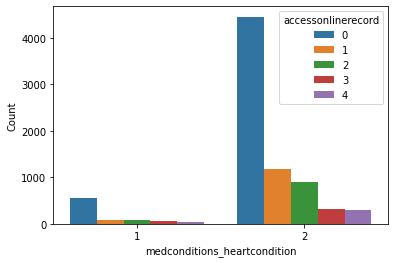

observed data:
 accessonlinerecord               0     1    2    3    4
medconditions_heartcondition                           
1                              549    84   81   55   47
2                             4453  1188  895  328  304
expected data:
 [[ 511.22645291  130.00400802   99.75150301   39.14428858   35.87374749]
 [4490.77354709 1141.99599198  876.24849699  343.85571142  315.12625251]]
chi-squared value: 36.1647 for 4 dof; p-value = 0.0000



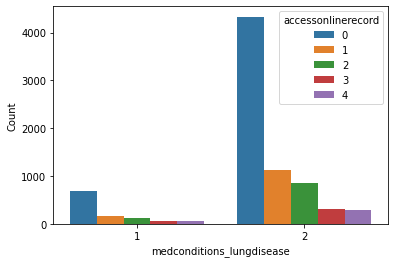

observed data:
 accessonlinerecord            0     1    2    3    4
medconditions_lungdisease                           
1                           678   155  123   63   66
2                          4332  1120  854  319  286
expected data:
 [[ 679.82116058  173.00837919  132.57191096   51.83466733   47.76388194]
 [4330.17883942 1101.99162081  844.42808904  330.16533267  304.23611806]]
chi-squared value: 13.8122 for 4 dof; p-value = 0.0079



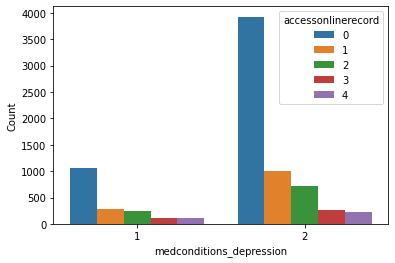

observed data:
 accessonlinerecord           0    1    2    3    4
medconditions_depression                          
1                         1058  277  252  110  117
2                         3928  994  722  270  234
expected data:
 [[1135.97136398  289.57472997  221.90856569   86.57623713   79.96910324]
 [3850.02863602  981.42527003  752.09143431  293.42376287  271.03089676]]
chi-squared value: 43.3371 for 4 dof; p-value = 0.0000



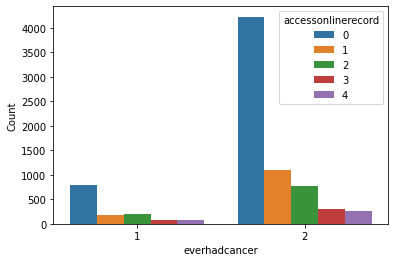

observed data:
 accessonlinerecord     0     1    2    3    4
everhadcancer                                
1                    801   183  209   78   87
2                   4230  1098  776  307  265
expected data:
 [[ 850.39805825  216.52949963  166.4961414    65.07717202   59.4991287 ]
 [4180.60194175 1064.47050037  818.5038586   319.92282798  292.5008713 ]]
chi-squared value: 41.1439 for 4 dof; p-value = 0.0000



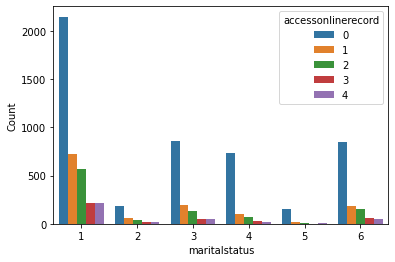

observed data:
 accessonlinerecord     0    1    2    3    4
maritalstatus                               
1                   2150  727  565  220  216
2                    189   57   43   16   14
3                    863  190  129   50   45
4                    739  106   73   31   22
5                    152   17   12    2    5
6                    851  181  153   63   46
expected data:
 [[2418.67440394  625.21559228  476.9837265   186.87977797  170.24649931]
 [ 198.95748707   51.42954459   39.23615491   15.37252428   14.00428914]
 [ 796.45363946  205.87939952  157.06761701   61.53828687   56.06105715]
 [ 605.60413776  156.54572978  119.43042765   46.79222909   42.62747572]
 [ 117.25394222   30.30957487   23.12350196    9.05966948    8.25331147]
 [ 807.05638955  208.62015895  159.15857197   62.3575123    56.80736723]]
chi-squared value: 214.1488 for 20 dof; p-value = 0.0000



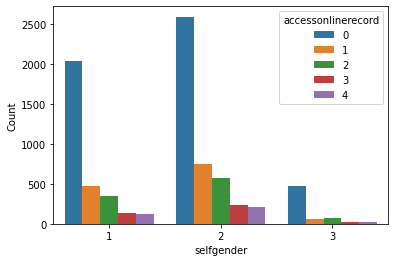

observed data:
 accessonlinerecord     0    1    2    3    4
selfgender                                  
1                   2029  477  348  134  121
2                   2587  748  572  233  215
3                    478   64   67   21   19
expected data:
 [[1952.08258351  493.96043387  378.23037101  148.68630593  136.04030568]
 [2734.42253174  691.92592136  529.81449525  208.27560705  190.5614446 ]
 [ 407.49488475  103.11364477   78.95513374   31.03808702   28.39824972]]
chi-squared value: 66.2658 for 8 dof; p-value = 0.0000



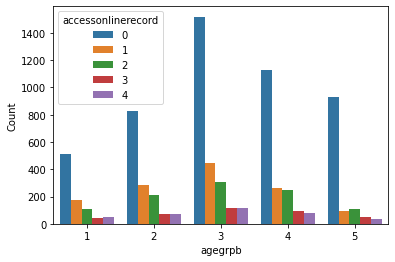

observed data:
 accessonlinerecord     0    1    2    3    4
agegrpb                                     
1                    513  178  108   44   50
2                    831  286  209   75   73
3                   1519  444  305  118  117
4                   1128  262  246   97   77
5                    927   97  105   48   35
expected data:
 [[ 556.48428789  143.36429295  110.09744045   43.22427775   39.82970096]
 [ 918.5418145   236.63938165  181.72858591   71.34668018   65.74353776]
 [1559.77622909  401.83743031  308.59338571  121.15382666  111.63912823]
 [1127.92448049  290.58160162  223.15382666   87.61023822   80.72985302]
 [ 755.27318804  194.57729346  149.42676128   58.66497719   54.05778003]]
chi-squared value: 160.1818 for 16 dof; p-value = 0.0000



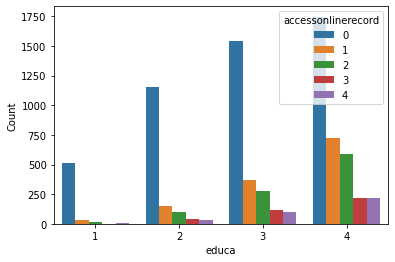

observed data:
 accessonlinerecord     0    1    2    3    4
educa                                       
1                    511   32   17    2    4
2                   1152  151   96   41   31
3                   1540  370  277  119   97
4                   1747  724  586  221  217
expected data:
 [[ 353.08128544   91.08783869   69.61764335   27.31921865   24.89401386]
 [ 917.63705104  236.73182105  180.93207309   71.00100819   64.69804663]
 [1499.03591682  386.72098299  295.56748582  115.98601134  105.68960302]
 [2180.24574669  562.45935728  429.88279773  168.69376181  153.71833648]]
chi-squared value: 585.9861 for 12 dof; p-value = 0.0000



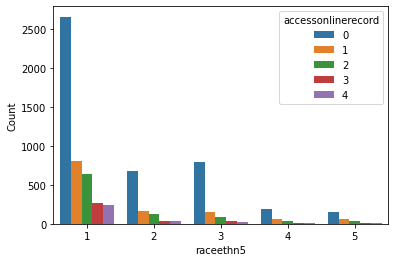

observed data:
 accessonlinerecord     0    1    2    3    4
raceethn5                                   
1                   2660  812  639  261  246
2                    672  160  124   33   36
3                    790  147   91   42   29
4                    194   59   40   15   15
5                    150   56   32   10   11
expected data:
 [[2815.94593119  778.0737302   583.87056253  227.62124522  212.48853086]
 [ 625.02048061  172.69934462  129.59448389   50.5222556    47.16343528]
 [ 670.14391043  185.16739487  138.95057346   54.169716     50.56840524]
 [ 196.9576734    54.42135445   40.83806663   15.92067176   14.86223375]
 [ 157.93200437   43.63817586   32.74631349   12.76611141   11.91739487]]
chi-squared value: 101.7995 for 16 dof; p-value = 0.0000



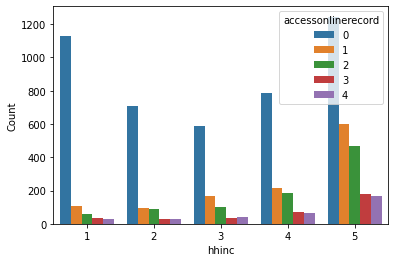

observed data:
 accessonlinerecord     0    1    2    3    4
hhinc                                       
1                   1128  105   61   34   28
2                    708   93   90   31   28
3                    586  170  103   33   41
4                    786  214  185   73   62
5                   1245  600  466  180  169
expected data:
 [[ 836.44105832  222.02410306  169.99307383   65.93101538   61.61074941]
 [ 586.00221637  155.54785981  119.09544258   46.19060812   43.16387311]
 [ 575.51586092  152.7643718   116.96426098   45.36403934   42.39146696]
 [ 814.23465854  216.12965785  165.47998338   64.18063444   59.9750658 ]
 [1640.80620585  435.53400748  333.46723923  129.33370273  120.85884472]]
chi-squared value: 596.0566 for 16 dof; p-value = 0.0000



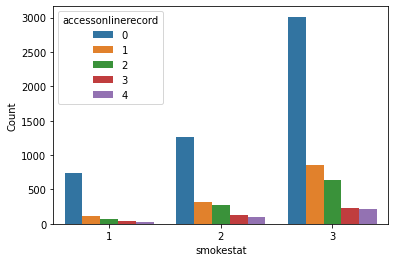

observed data:
 accessonlinerecord     0    1    2    3    4
smokestat                                   
1                    742  118   64   34   32
2                   1267  310  270  122  103
3                   3013  851  641  229  214
expected data:
 [[ 620.69662921  158.07865169  120.50561798   47.58426966   43.13483146]
 [1299.0741573   330.8474407   252.20973783   99.59051186   90.27815231]
 [3102.22921348  790.07390762  602.28464419  237.82521848  215.58701623]]
chi-squared value: 87.4042 for 8 dof; p-value = 0.0000



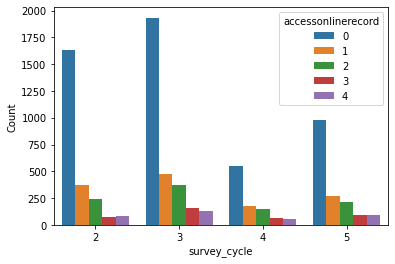

observed data:
 accessonlinerecord     0    1    2    3    4
survey_cycle                                
2                   1631  371  245   76   81
3                   1932  473  374  156  130
4                    549  178  150   68   54
5                    983  267  218   88   90
expected data:
 [[1509.5366034   381.90239093  292.42642347  114.95587873  105.17870348]
 [1924.59637663  486.90966231  372.83152576  146.56396352  134.09847178]
 [ 627.29911264  158.70236628  121.51996549   47.77076658   43.70778901]
 [1033.56790732  261.48558048  200.22208528   78.70939118   72.01503574]]
chi-squared value: 77.2397 for 12 dof; p-value = 0.0000



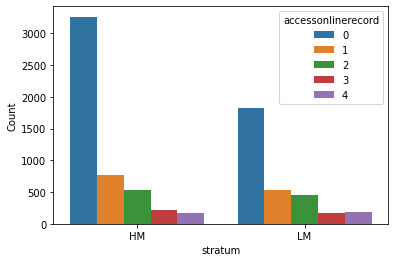

observed data:
 accessonlinerecord     0    1    2    3    4
stratum                                     
HM                  3263  762  529  217  169
LM                  1832  527  458  171  186
expected data:
 [[3101.95957604  784.77446389  600.90953907  236.2238107   216.1326103 ]
 [1993.04042396  504.22553611  386.09046093  151.7761893   138.8673897 ]]
chi-squared value: 75.3356 for 4 dof; p-value = 0.0000



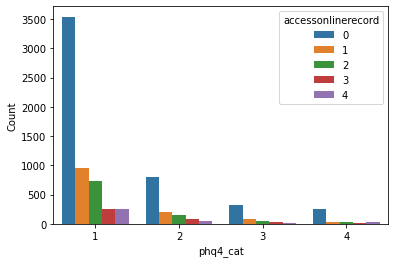

observed data:
 accessonlinerecord     0    1    2    3    4
phq4_cat                                    
1                   3539  959  732  258  248
2                    800  197  150   78   56
3                    315   78   57   26   20
4                    259   35   25   14   26
expected data:
 [[3579.89939024  924.66768293  702.42682927  273.97560976  255.0304878 ]
 [ 799.48589939  206.50266768  156.87042683   61.18597561   56.95503049]
 [ 309.55894309   79.95731707   60.7398374    23.69105691   22.05284553]
 [ 224.05576728   57.87233232   43.9629065    17.14735772   15.96163618]]
chi-squared value: 39.8373 for 12 dof; p-value = 0.0001



In [330]:
# re-run the above analysis, except exclude the -9 code
miss_codes3 = [-4, -5, -6, -9]
for oc_var in outcome_vars:
    for cat_var in int_cols:
        get_crosstabs(cat_var, oc_var, df_train, ignore_codes = miss_codes3, plot_data = True)

With the -9 missing code excluded, some of the relationships became non-significant.  This is likely because the -9 field has mostly small values, so small fluctuations in that field relative to the expected values may cause oscillations in the p-values.     

Below, the additional non-signficant relationship are given.

**`offeredaccesseither`**:  
additional new non-significant relationships besides the one listed above:  
- `healthins_tricare` (Tricare or other military insurance)
- `healthins_va` (VA insurance)
- `healthins_ihs` (Indian Health Service benefits only)
- `healthins_other` (other insurance not specified above)
- `medconditions_highbp` (ever diagnosed with hypertension) 
- `medconditions_heartcondition` (ever diagnosed with heart condition) 
- `medconditions_lungdisease` (ever diagnosed with lung disease) 

**`accessonlinerecord`**:  
additional new non-significant relationships besides the one listed above: 
- `healthins_tricare` (Tricare or other military insurance)
- `healthins_va` (VA insurance)
- `healthins_ihs` (Indian Health Service benefits only)

Based on the above analyses, these variables will be dropped from consideration for multivariate modeling:  
- `healthins_tricare`
- `healthins_va`
- `healthins_ihs`

In [331]:
# drop the non-signficant variables
df_train.drop(columns = ['healthins_tricare', 'healthins_va', 'healthins_ihs'], inplace = True)

In [332]:
# repeat for test set
df_test.drop(columns = ['healthins_tricare', 'healthins_va', 'healthins_ihs'], inplace = True)

<a id='mvquartil'></a>
#### Quartilizing the continuous/ordinal variables
Next, we need to make categorical variables for the 3 ordinal/continuous variables test them.  
We'll divide each into quartiles where the code will be first quartile = 1, fourth = 4.  
To do this, we need to eliminate the missing-data codes so they don't affect the quartile computations. This means we'll be losing the -9 omitted code, but for these variables there is no way to impute a category to that code (unlike e.g. "don't know").

In [333]:
# see which negative codes exist and how many entries there are in the training set
df_train[df_train['bmi'] < 0.0]['bmi'].value_counts()

-9.0    227
-4.0     28
Name: bmi, dtype: int64

In [334]:
df_train[df_train['weeklyminutesmoderateexercise'] < 0.0]['weeklyminutesmoderateexercise'].value_counts()

-9    238
Name: weeklyminutesmoderateexercise, dtype: int64

In [335]:
df_train[df_train['avgdrinksperweek'] < 0.0]['avgdrinksperweek'].value_counts()

-9    940
-4     15
Name: avgdrinksperweek, dtype: int64

The last variable has quite a few omitted entries. However, we'd have to guess that this means those respondents didn't answer because they don't drink (healthier), drink alot (not healthy), or just don't think it's our business (could be either). Since there's not a clear way to categorize these responses, they'll be dropped.

In [336]:
# back up first
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [337]:
# eliminate the missing-code entries
df_train = df_train[~(df_train['bmi'] < 0.0)]
df_train[df_train['bmi'] < 0.0]['bmi'].value_counts()

Series([], Name: bmi, dtype: int64)

In [338]:
df_train = df_train[~(df_train['weeklyminutesmoderateexercise'] < 0.0)]
df_train[df_train['weeklyminutesmoderateexercise'] < 0.0]['weeklyminutesmoderateexercise'].value_counts()

Series([], Name: weeklyminutesmoderateexercise, dtype: int64)

In [339]:
df_train = df_train[~(df_train['avgdrinksperweek'] < 0.0)]
df_train[df_train['avgdrinksperweek'] < 0.0]['avgdrinksperweek'].value_counts()

Series([], Name: avgdrinksperweek, dtype: int64)

In [340]:
# see how many entries remain
df_train.shape[0]

6836

In [341]:
# do same for test set
df_test = df_test[~(df_test['bmi'] < 0.0)]
df_test[df_test['bmi'] < 0.0]['bmi'].value_counts()

Series([], Name: bmi, dtype: int64)

In [342]:
df_test = df_test[~(df_test['weeklyminutesmoderateexercise'] < 0.0)]
df_test[df_test['weeklyminutesmoderateexercise'] < 0.0]['weeklyminutesmoderateexercise'].value_counts()

Series([], Name: weeklyminutesmoderateexercise, dtype: int64)

In [343]:
df_test = df_test[~(df_test['avgdrinksperweek'] < 0.0)]
df_test[df_test['avgdrinksperweek'] < 0.0]['avgdrinksperweek'].value_counts()

Series([], Name: avgdrinksperweek, dtype: int64)

In [344]:
# see how many entries remain
df_test.shape[0]

2967

We still have reasonable-size training and test sets.  

Now let's make categorical variables for each of these using quartiles.

In [345]:
# back up again
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [346]:
# divide into quartiles
df_train['bmi_cat'] = pd.qcut(df_train['bmi'], 4, labels = [1, 2, 3, 4])
# check that the categories are roughly evenly distributed
display(df_train['bmi_cat'].value_counts())
# check that the ordering is correct, i.e. lowest BMI in category 1, highest in 4
print('1st quartile: ', df_train[df_train['bmi_cat'] == 1]['bmi'].mean())
print('2nd quartile: ', df_train[df_train['bmi_cat'] == 2]['bmi'].mean())
print('3rd quartile: ', df_train[df_train['bmi_cat'] == 3]['bmi'].mean())
print('4th quartile: ', df_train[df_train['bmi_cat'] == 4]['bmi'].mean())

3    1750
1    1720
2    1705
4    1661
Name: bmi_cat, dtype: int64

1st quartile:  21.60162790697674
2nd quartile:  25.60392961876833
3rd quartile:  29.43165714285714
4th quartile:  37.77218543046357


In [347]:
# do same for test data, but no peeking at the distribution
df_test['bmi_cat'] = pd.qcut(df_test['bmi'], 4, labels = [1, 2, 3, 4])

For the other two variables, using `qcut` to divide the data into quartiles won't work, because there are so many zero entries, which makes the bins non-unique. We'll need to find a different way to categorize them.

For moderate exercise, the [CDC recommendation for adults](https://www.cdc.gov/physicalactivity/basics/adults/index.htm) is at least 150 minutes/week. We'll categorize that variable based on levels relative to the CDC recommendation as follows:
- 0 mins/week
- \> 0 but \< 50% (< 75 mins) of the CDC recommendation
- \>= 50% to \< 100% (75-149 mins)
- \>= 100% to \< 150% (150-224 mins)
- \>= 150% (\>= 225 mins)

In [348]:
# categorize exercise duration based on the above bins
# this will be the default, for zero mins
df_train['wkminmodex_cat'] = 1
df_train.loc[(df_train['weeklyminutesmoderateexercise'] > 0.0) & (df_train['weeklyminutesmoderateexercise'] < 75.0),\
            'wkminmodex_cat'] = 2
df_train.loc[(df_train['weeklyminutesmoderateexercise'] >= 75.0) & (df_train['weeklyminutesmoderateexercise'] < 150.0),\
            'wkminmodex_cat'] = 3
df_train.loc[(df_train['weeklyminutesmoderateexercise'] >= 150.0) & (df_train['weeklyminutesmoderateexercise'] < 225.0),\
            'wkminmodex_cat'] = 4
df_train.loc[df_train['weeklyminutesmoderateexercise'] >= 225.0 , 'wkminmodex_cat'] = 5
# check that the categories are filled and what the distribution is
display(df_train['wkminmodex_cat'].value_counts())

1    1922
5    1527
3    1359
2    1133
4     895
Name: wkminmodex_cat, dtype: int64

In [349]:
# do same for test data, but no peeking at the distribution
df_test['wkminmodex_cat'] = 1
df_test.loc[(df_test['weeklyminutesmoderateexercise'] > 0.0) & (df_test['weeklyminutesmoderateexercise'] < 75.0),\
            'wkminmodex_cat'] = 2
df_test.loc[(df_test['weeklyminutesmoderateexercise'] >= 75.0) & (df_test['weeklyminutesmoderateexercise'] < 150.0),\
            'wkminmodex_cat'] = 3
df_test.loc[(df_test['weeklyminutesmoderateexercise'] >= 150.0) & (df_test['weeklyminutesmoderateexercise'] < 225.0),\
            'wkminmodex_cat'] = 4
df_test.loc[df_test['weeklyminutesmoderateexercise'] >= 225.0 , 'wkminmodex_cat'] = 5

For alcohol consumption, again looking at [CDC recommendations](https://www.cdc.gov/alcohol/fact-sheets/alcohol-use.htm), heavy drinking is defined as \>= 8 drinks/week for women and \>= 15 drinks/week for men. 
We can again define categories based on these recommendations. We do, however, have multiple respondents who did not specify a gender, and we want to retain these entries. For them, we'll apply a cutoff based on the mean value of 11.5 drinks/week.  
The categories will be similar to those used for exercise, as follows:
- 0 drinks/week
- \> 0 but \< 50% of the CDC recommendation (M: 1-7, F: 1-3; missing: 1-5)
- \>= 50% to \< 100% (M: 8-14, F: 4-7; missing: 6-11)
- \>= 100% to \< 150% (M: 15-22, F: 8-12; missing: 12-17)
- \>= 150% (M: >= 23, F: >=13; missing: >= 18)

In [350]:
# categorize alcohol consumption based on the above bins
# this will be the default, for zero drinks (independent of gender)
df_train['avgdrinks_cat'] = 1
# males
df_train.loc[(df_train['avgdrinksperweek'] > 0.0) & (df_train['avgdrinksperweek'] < 8.0) & \
             (df_train['selfgender'] == 1), 'avgdrinks_cat'] = 2
df_train.loc[(df_train['avgdrinksperweek'] >= 8.0) & (df_train['avgdrinksperweek'] < 15.0) & \
             (df_train['selfgender'] == 1), 'avgdrinks_cat'] = 3
df_train.loc[(df_train['avgdrinksperweek'] >= 15.0) & (df_train['avgdrinksperweek'] < 23.0) & \
             (df_train['selfgender'] == 1), 'avgdrinks_cat'] = 4
df_train.loc[(df_train['avgdrinksperweek'] >= 23.0) & (df_train['selfgender'] == 1), 'avgdrinks_cat'] = 5
# females
df_train.loc[(df_train['avgdrinksperweek'] > 0.0) & (df_train['avgdrinksperweek'] < 4.0) & \
             (df_train['selfgender'] == 2), 'avgdrinks_cat'] = 2
df_train.loc[(df_train['avgdrinksperweek'] >= 4.0) & (df_train['avgdrinksperweek'] < 8.0) & \
             (df_train['selfgender'] == 2), 'avgdrinks_cat'] = 3
df_train.loc[(df_train['avgdrinksperweek'] >= 8.0) & (df_train['avgdrinksperweek'] < 13.0) & \
             (df_train['selfgender'] == 2), 'avgdrinks_cat'] = 4
df_train.loc[(df_train['avgdrinksperweek'] >= 13.0) & (df_train['selfgender'] == 2), 'avgdrinks_cat'] = 5
# not specified
df_train.loc[(df_train['avgdrinksperweek'] > 0.0) & (df_train['avgdrinksperweek'] < 5.0) & \
             (df_train['selfgender'] == 3), 'avgdrinks_cat'] = 2
df_train.loc[(df_train['avgdrinksperweek'] >= 5.0) & (df_train['avgdrinksperweek'] < 12.0) & \
             (df_train['selfgender'] == 3), 'avgdrinks_cat'] = 3
df_train.loc[(df_train['avgdrinksperweek'] >= 12.0) & (df_train['avgdrinksperweek'] < 18.0) & \
             (df_train['selfgender'] == 3), 'avgdrinks_cat'] = 4
df_train.loc[(df_train['avgdrinksperweek'] >= 18.0) & (df_train['selfgender'] == 3), 'avgdrinks_cat'] = 5
# check that the categories are filled and what the distribution is
display(df_train['avgdrinks_cat'].value_counts())

1    3628
2    1739
3     777
4     376
5     316
Name: avgdrinks_cat, dtype: int64

In [351]:
# repeat for test set, but don't peek at distribution
# this will be the default, for zero drinks (independent of gender)
df_test['avgdrinks_cat'] = 1
# males
df_test.loc[(df_test['avgdrinksperweek'] > 0.0) & (df_test['avgdrinksperweek'] < 8.0) & \
             (df_test['selfgender'] == 1), 'avgdrinks_cat'] = 2
df_test.loc[(df_test['avgdrinksperweek'] >= 8.0) & (df_test['avgdrinksperweek'] < 15.0) & \
             (df_test['selfgender'] == 1), 'avgdrinks_cat'] = 3
df_test.loc[(df_test['avgdrinksperweek'] >= 15.0) & (df_test['avgdrinksperweek'] < 23.0) & \
             (df_test['selfgender'] == 1), 'avgdrinks_cat'] = 4
df_test.loc[(df_test['avgdrinksperweek'] >= 23.0) & (df_test['selfgender'] == 1), 'avgdrinks_cat'] = 5
# females
df_test.loc[(df_test['avgdrinksperweek'] > 0.0) & (df_test['avgdrinksperweek'] < 4.0) & \
             (df_test['selfgender'] == 2), 'avgdrinks_cat'] = 2
df_test.loc[(df_test['avgdrinksperweek'] >= 4.0) & (df_test['avgdrinksperweek'] < 8.0) & \
             (df_test['selfgender'] == 2), 'avgdrinks_cat'] = 3
df_test.loc[(df_test['avgdrinksperweek'] >= 8.0) & (df_test['avgdrinksperweek'] < 13.0) & \
             (df_test['selfgender'] == 2), 'avgdrinks_cat'] = 4
df_test.loc[(df_test['avgdrinksperweek'] >= 13.0) & (df_test['selfgender'] == 2), 'avgdrinks_cat'] = 5
# not specified
df_test.loc[(df_test['avgdrinksperweek'] > 0.0) & (df_test['avgdrinksperweek'] < 5.0) & \
             (df_test['selfgender'] == 3), 'avgdrinks_cat'] = 2
df_test.loc[(df_test['avgdrinksperweek'] >= 5.0) & (df_test['avgdrinksperweek'] < 12.0) & \
             (df_test['selfgender'] == 3), 'avgdrinks_cat'] = 3
df_test.loc[(df_test['avgdrinksperweek'] >= 12.0) & (df_test['avgdrinksperweek'] < 18.0) & \
             (df_test['selfgender'] == 3), 'avgdrinks_cat'] = 4
df_test.loc[(df_test['avgdrinksperweek'] >= 18.0) & (df_test['selfgender'] == 3), 'avgdrinks_cat'] = 5

Now we need to check the relationship between these categorical variables and the outcomes.

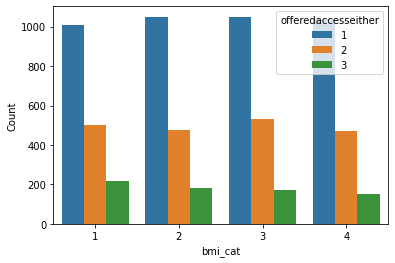

observed data:
 offeredaccesseither     1    2    3
bmi_cat                            
1                    1006  499  215
2                    1050  474  181
3                    1047  531  172
4                    1040  470  151
expected data:
 [[1042.41661791  496.67641896  180.90696314]
 [1033.32577531  492.34493856  179.32928613]
 [1060.5983031   505.33937975  184.06231714]
 [1006.65930369  479.63926273  174.70143359]]
chi-squared value: 15.4576 for 6 dof; p-value = 0.0170



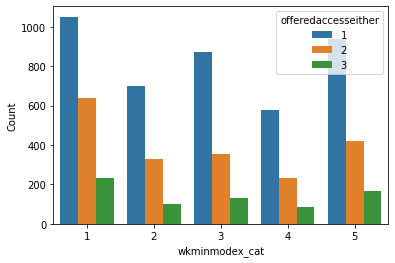

observed data:
 offeredaccesseither     1    2    3
wkminmodex_cat                     
1                    1051  638  233
2                     701  329  103
3                     873  353  133
4                     580  231   84
5                     938  423  166
expected data:
 [[1164.83996489  555.00702165  202.15301346]
 [ 686.66164424  327.17115272  119.16720304]
 [ 823.63033938  392.43212405  142.93753657]
 [ 542.42027501  258.44499707   94.13472791]
 [ 925.44777648  440.94470451  160.60751902]]
chi-squared value: 46.0491 for 8 dof; p-value = 0.0000



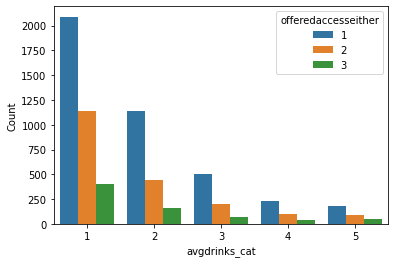

observed data:
 offeredaccesseither     1     2    3
avgdrinks_cat                       
1                    2089  1141  398
2                    1135   443  161
3                     506   197   74
4                     235   103   38
5                     178    90   48
expected data:
 [[2198.77179637 1047.64072557  381.58747806]
 [1053.9316852   502.1629608   182.90535401]
 [ 470.90564658  224.37068461   81.72366881]
 [ 227.87712112  108.57577531   39.54710357]
 [ 191.51375073   91.24985372   33.23639555]]
chi-squared value: 45.1178 for 8 dof; p-value = 0.0000



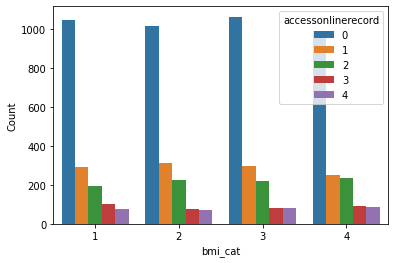

observed data:
 accessonlinerecord     0    1    2    3   4
bmi_cat                                    
1                   1049  295  196  101  79
2                   1020  311  228   75  71
3                   1065  299  221   83  82
4                    992  254  235   91  89
expected data:
 [[1038.13926273  291.61497952  221.41603277   88.06319485   80.76653013]
 [1029.08572264  289.07182563  219.48507899   87.29520187   80.06217086]
 [1056.24634289  296.7012873   225.27794032   89.59918081   82.17524868]
 [1002.52867174  281.61190755  213.82094792   85.04242247   77.99605032]]
chi-squared value: 17.3845 for 12 dof; p-value = 0.1357



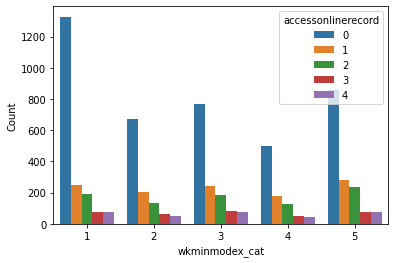

observed data:
 accessonlinerecord     0    1    2   3   4
wkminmodex_cat                            
1                   1327  251  191  75  78
2                    675  207  136  66  49
3                    768  244  187  84  76
4                    496  176  130  50  43
5                    860  281  236  75  75
expected data:
 [[1160.06026916  325.86278525  247.41954359   98.40550029   90.2519017 ]
 [ 683.84406085  192.09289058  145.85137507   58.00906963   53.20260386]
 [ 820.25073142  230.40974254  174.94441194   69.58016384   63.81495026]
 [ 540.19455822  151.74151551  115.21357519   45.82358104   42.02677004]
 [ 921.65038034  258.89306612  196.57109421   78.1816852    71.70377414]]
chi-squared value: 98.9592 for 16 dof; p-value = 0.0000



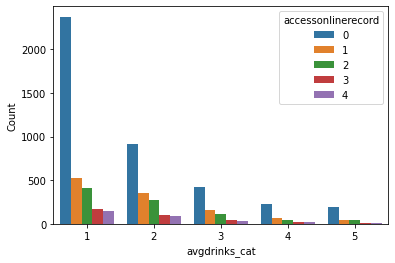

observed data:
 accessonlinerecord     0    1    2    3    4
avgdrinks_cat                               
1                   2370  523  408  175  152
2                    919  357  269   99   95
3                    417  164  114   45   37
4                    225   66   47   16   22
5                    195   49   42   15   15
expected data:
 [[2189.74956115  615.10415448  467.03335284  185.7519017   170.36102984]
 [1049.60708016  294.83630778  223.86190755   89.03598596   81.65871855]
 [ 468.97337624  131.73537156  100.0234055    39.78203628   36.48581042]
 [ 226.94207139   63.74839087   48.40257461   19.25102399   17.65593915]
 [ 190.72791106   53.57577531   40.67875951   16.17905208   14.83850205]]
chi-squared value: 99.1252 for 16 dof; p-value = 0.0000



In [352]:
# do the crosstabs. ignore_codes can be left to the default since there aren't any missing codes in these variables
cat_cols = ['bmi_cat', 'wkminmodex_cat', 'avgdrinks_cat']
for oc_var in outcome_vars:
    for cat_var in cat_cols:
        get_crosstabs(cat_var, oc_var, df_train, plot_data = True)

Using categorical variables to reduce the influence of outliers, we see that BMI does not have a significant relationship to `accesssonlinerecord`. 
Exercise duration and alcohol consumption as categorical variables have significant relationships to both outcome variables.

We can now delete the continuous variables that the categories were based on.

In [353]:
# drop original continuous variables, now that we've created the categoricals
df_train.drop(columns = ['bmi', 'weeklyminutesmoderateexercise', 'avgdrinksperweek'], inplace = True)

In [354]:
# repeat for test set
df_test.drop(columns = ['bmi', 'weeklyminutesmoderateexercise', 'avgdrinksperweek'], inplace = True)

In the above analyses, we excluded missing codes on a variable-by-variable basis.  
This was to avoid deleting rows where there might be missing-data codes only in some variable that's non-significant.   
To have a uniform dataset for multivariate analysis, we'll need to delete rows with missing-data codes in the remaining variables, which had significant univariate relationships with the outcome variables. 
However, there were three variables which had a non-significant relationship to `offeredaccesseither` but not to `accessonlinerecord`. Let's look at the distribution of those.

In [355]:
# look at number of missing values for variables with non-sig relationship to one, but not the other, outcome
df_train['healthins_other'].value_counts()

 2    5644
-9     603
 1     589
Name: healthins_other, dtype: int64

In [356]:
df_train['medconditions_lungdisease'].value_counts()

 2    5890
 1     912
-9      34
Name: medconditions_lungdisease, dtype: int64

In [357]:
df_train['medconditions_heartcondition'].value_counts()

 2    6120
 1     677
-9      39
Name: medconditions_heartcondition, dtype: int64

In [358]:
df_train['medconditions_highbp'].value_counts()

 2    3664
 1    3116
-9      56
Name: medconditions_highbp, dtype: int64

There are relatively few missing entries for the `medconditions_xxx` variables, but quite a few for `healthins_other`. For the former, we'll drop the rows with -9 values.  
For the latter, we have already dropped some of the specific insurance categories, and the number of respondents who say they have this type of insurance is less than those who omitted an answer. For those reasons, we'll drop this variable.

In [359]:
# drop the healthins_other variable
df_train.drop(columns = ['healthins_other'], inplace = True)
df_test.drop(columns = ['healthins_other'], inplace = True)

Before we delete rows with missing data for the remaining columns, let's look more closely at some of the variables.

In [360]:
int_cols

['highspanli',
 'nchsurcode2013',
 'censdiv',
 'useinternet',
 'internet_dialup',
 'internet_broadbnd',
 'internet_cell',
 'internet_wifi',
 'whereuseinternet_home',
 'whereuseinternet_work',
 'whereuseinternet_publicplace',
 'whereuseinternet_mobiledevice',
 'electronic_selfhealthinfo',
 'havedevice_cat',
 'tablethealthwellnessapps',
 'tablet_achievegoal',
 'tablet_makedecision',
 'tablet_discussionshcp',
 'intrsn_visitedsocnet',
 'intrsn_sharedsocnet',
 'intrsn_supportgroup',
 'intrsn_youtube',
 'regularprovider',
 'freqgoprovider',
 'qualitycare',
 'healthins_insuranceemp',
 'healthins_insurancepriv',
 'healthins_medicare',
 'healthins_medicaid',
 'healthins_tricare',
 'healthins_va',
 'healthins_ihs',
 'healthins_other',
 'healthinsurance',
 'generalhealth',
 'ownabilitytakecarehealth',
 'medconditions_diabetes',
 'medconditions_highbp',
 'medconditions_heartcondition',
 'medconditions_lungdisease',
 'medconditions_depression',
 'everhadcancer',
 'maritalstatus',
 'selfgender',
 'a

Examine the missing & overlap patterns in the internet use fields

In [361]:
# how many overall say they use the internet?
df_train['useinternet'].value_counts()

 1    5636
 2    1182
-9      18
Name: useinternet, dtype: int64

In [362]:
# look at the specific access methods
df_train['internet_dialup'].value_counts()

 2    5410
-1    1182
 1     125
-9     101
-6      18
Name: internet_dialup, dtype: int64

In [363]:
df_train['internet_broadbnd'].value_counts()

 2    2868
 1    2655
-1    1182
-9     113
-6      18
Name: internet_broadbnd, dtype: int64

In [364]:
df_train['internet_cell'].value_counts()

 1    3497
 2    2034
-1    1182
-9     105
-6      18
Name: internet_cell, dtype: int64

In [365]:
df_train['internet_wifi'].value_counts()

 1    4474
-1    1182
 2    1065
-9      97
-6      18
Name: internet_wifi, dtype: int64

While only 18 respondents didn't answer to whether they use the internet, about 100 didn't answer for each specific category of internent access method.  
Very few use dial-up. It's also possible multiple responses could be selected. Let's check that.

In [366]:
df_train[(df_train['internet_dialup'] == 1) & (df_train['internet_broadbnd'] == 1)].shape[0]

49

In [367]:
df_train[(df_train['internet_dialup'] == 1) & (df_train['internet_cell'] == 1)].shape[0]

63

In [368]:
df_train[(df_train['internet_dialup'] == 1) & (df_train['internet_wifi'] == 1)].shape[0]

72

In [369]:
df_train[(df_train['internet_wifi'] == 1) & (df_train['internet_broadbnd'] == 1)].shape[0]

1984

In [370]:
df_train[(df_train['internet_wifi'] == 1) & (df_train['internet_cell'] == 1)].shape[0]

3049

In [371]:
df_train[(df_train['internet_cell'] == 1) & (df_train['internet_broadbnd'] == 1)].shape[0]

1842

It looks like multiple options could be selected. Oddly, some respondents even report using both broadband and dialup. These are all yes/no categories, so there's nothing to guide us to which modality is used most frequently by those who select multiple options.

Dial-up is fairly rarely selected, and it seems like many of those who selected it also tended to pick another modality. It's unclear from the survey whether wifi here refers to a home-based network, or a public one. According to the survey, cell-based service includes both 3G & 4G, which are vastly different in terms of speed. So these categories aren't terribly useful.

Given this, we'll just keep the broadband category (along with the base internet access vs none category). Those who pick this are acknowledging have a home-based, relatively high-speed access modality, and are computer-literate enough to know this is what they have. Thus, this category is likely to differentiate between somewhat more and less internet-savvy.

In [372]:
# drop the non-broadband internet categories
df_train.drop(columns = ['internet_dialup', 'internet_cell', 'internet_wifi'], inplace = True)
df_test.drop(columns = ['internet_dialup', 'internet_cell', 'internet_wifi'], inplace = True)

The "where do you use the internet?" variables contain frequency options and "not applicable", in addition to the missing codes. These variables are also oddly structured, as three of them are places, and one (from a mobile device) is a method of accessing the internet. We probably want to consolidate or reduce the dimensions of these variables. Let's look again at the frequency of each in the training set.

In [373]:
df_train['whereuseinternet_home'].value_counts()

 1    3015
 2    1828
-1    1182
 4     324
 3     259
-9     204
-6      18
-5       6
Name: whereuseinternet_home, dtype: int64

In [374]:
df_train['whereuseinternet_work'].value_counts()

 1    1946
 4    1870
-1    1182
 3     690
 2     658
-9     465
-6      18
-5       7
Name: whereuseinternet_work, dtype: int64

In [375]:
df_train['whereuseinternet_publicplace'].value_counts()

 3    3295
-1    1182
 4     912
 2     879
-9     496
 1      47
-6      18
-5       7
Name: whereuseinternet_publicplace, dtype: int64

In [376]:
df_train['whereuseinternet_mobiledevice'].value_counts()

 1    3792
 2    1219
-1    1182
 3     280
-9     171
 4     170
-6      18
-5       4
Name: whereuseinternet_mobiledevice, dtype: int64

In [377]:
# check overlap of "daily" use in each category, except public place since that's so sparse 
df_train[(df_train['whereuseinternet_mobiledevice']==1) & (df_train['whereuseinternet_home']==1)].shape[0]

2006

In [378]:
df_train[(df_train['whereuseinternet_mobiledevice']==1) & (df_train['whereuseinternet_work']==1)].shape[0]

1656

In [379]:
df_train[(df_train['whereuseinternet_work']==1) & (df_train['whereuseinternet_home']==1)].shape[0]

1242

There's quite a bit of overlap in "daily" use between these three categories. For "public place", few cite "daily" use, but more cite "sometimes". Let's see if it's common for these respondents to use other locations/means.

In [380]:
df_train[(df_train['whereuseinternet_publicplace']==2) & (df_train['whereuseinternet_work']==1)].shape[0]

327

In [381]:
df_train[(df_train['whereuseinternet_publicplace']==2) & (df_train['whereuseinternet_home']==1)].shape[0]

476

In [382]:
df_train[(df_train['whereuseinternet_publicplace']==2) & (df_train['whereuseinternet_mobiledevice']==1)].shape[0]

665

It appears slightly fewer respondents who use public places for internet access have other opportunities to access the internet. This may limit their ability to use EMRs.
Since there seems to be quite a bit of overlap in the other categories, these are not likely to be useful in a multivariate model. For these reasons, we'll make one category, with those who use public places to access the internet vs those with no access vs the other categories.
For this new category, the values will be:
- -1: internet use is N/A (presumably no access, or don't use whatever access they have)
- 1: use internet in a public place "daily" or "sometimes"
- 2: use internet in a public place "never" or "N/A"
- other missing-data codes: unchanged, will be dropped later

In [383]:
# back up first, of course
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [384]:
# create the new variable
df_train['whruseinet_pubvother'] = df_train['whereuseinternet_publicplace']

In [385]:
# combine "daily" and "sometimes"
df_train.loc[((df_train['whereuseinternet_publicplace'] == 1) | (df_train['whereuseinternet_publicplace'] == 2)),\
             'whruseinet_pubvother'] = 1
display(df_train['whereuseinternet_publicplace'].value_counts())
display(df_train['whruseinet_pubvother'].value_counts())

 3    3295
-1    1182
 4     912
 2     879
-9     496
 1      47
-6      18
-5       7
Name: whereuseinternet_publicplace, dtype: int64

 3    3295
-1    1182
 1     926
 4     912
-9     496
-6      18
-5       7
Name: whruseinet_pubvother, dtype: int64

In [386]:
# combine the "never" and "N/A" categories, indicating those who don't use public internet
df_train.loc[((df_train['whereuseinternet_publicplace'] == 3) | (df_train['whereuseinternet_publicplace'] == 4)),\
             'whruseinet_pubvother'] = 2
display(df_train['whereuseinternet_publicplace'].value_counts())
display(df_train['whruseinet_pubvother'].value_counts())

 3    3295
-1    1182
 4     912
 2     879
-9     496
 1      47
-6      18
-5       7
Name: whereuseinternet_publicplace, dtype: int64

 2    4207
-1    1182
 1     926
-9     496
-6      18
-5       7
Name: whruseinet_pubvother, dtype: int64

In [387]:
# do the same for the test data, but don't peek at the distribution
df_test['whruseinet_pubvother'] = df_test['whereuseinternet_publicplace']
df_test.loc[((df_test['whereuseinternet_publicplace'] == 1) | (df_test['whereuseinternet_publicplace'] == 2)),\
             'whruseinet_pubvother'] = 1
df_test.loc[((df_test['whereuseinternet_publicplace'] == 3) | (df_test['whereuseinternet_publicplace'] == 4)),\
             'whruseinet_pubvother'] = 2

In [388]:
# drop the old columns
df_train.drop(columns = ['whereuseinternet_home', 'whereuseinternet_work', 'whereuseinternet_publicplace',\
                        'whereuseinternet_mobiledevice'], inplace = True)
df_test.drop(columns = ['whereuseinternet_home', 'whereuseinternet_work', 'whereuseinternet_publicplace',\
                        'whereuseinternet_mobiledevice'], inplace = True)

Finally, let's look at overlap in the remaining insurance categories. Generally, people with employer-provider or private insurance are not likely to have Medicare or Medicaid. But, Medicare and Medicaid may overlap.

In [164]:
df_train['healthins_insuranceemp'].value_counts()

 1    3552
 2    3178
-9     106
Name: healthins_insuranceemp, dtype: int64

In [165]:
df_train['healthins_insurancepriv'].value_counts()

 2    5558
 1    1092
-9     186
Name: healthins_insurancepriv, dtype: int64

In [166]:
# overlap between employer-provided insurance and privately-purchased insurance
df_train[(df_train['healthins_insuranceemp']==1) & (df_train['healthins_insurancepriv']==1)].shape[0]

173

In [167]:
df_train['healthins_medicare'].value_counts()

 2    4194
 1    2536
-9     106
Name: healthins_medicare, dtype: int64

In [168]:
df_train['healthins_medicaid'].value_counts()

 2    5752
 1     914
-9     170
Name: healthins_medicaid, dtype: int64

In [169]:
# overlap between employer-provided insurance and medicare
# this would presumably be workers over 65 or on dialysis
df_train[(df_train['healthins_insuranceemp']==1) & (df_train['healthins_medicare']==1)].shape[0]

753

In [170]:
# overlap between employer-provided insurance and medicaid
df_train[(df_train['healthins_insuranceemp']==1) & (df_train['healthins_medicaid']==1)].shape[0]

81

In [171]:
# overlap between private insurance and medicare
# this would presumably included medicare supplemental insurance
df_train[(df_train['healthins_insurancepriv']==1) & (df_train['healthins_medicare']==1)].shape[0]

658

In [172]:
# overlap between private insurance and medicaid
df_train[(df_train['healthins_insurancepriv']==1) & (df_train['healthins_medicaid']==1)].shape[0]

85

In [173]:
# overlap between medicaid and medicare
df_train[(df_train['healthins_medicaid']==1) & (df_train['healthins_medicare']==1)].shape[0]

369

In [174]:
# medicaid only
df_train[(df_train['healthins_medicaid']==1) & (df_train['healthins_medicare']==2) &\
        (df_train['healthins_insuranceemp']==2) &  (df_train['healthins_insurancepriv']==2)].shape[0]

470

In [175]:
df_train[(df_train['healthins_medicaid']==1) | (df_train['healthins_medicare']==1)].shape[0]

3081

There is a less obvious pattern of overlap here, and relatively few respondents have only Medicaid, which is considered "safety net" insurance for the poor or disabled. However, it is of interest to compare those with publicly-funded insurance (Medicare or Medicaid) to those with private insurance. For this analysis, employer-provided insurance will be assumed as primary, while "private" insurance accompanying Medicare or Medicaid will be assumed as secondary (Medicare Part D or supplemental drug plans). 
Categories:
- 1: private (employer-provided; or private without Medicare or Medicaid)
- 2: public (Medicare and/or Medicaid, without employer-provided insurance)
- 3: none/other
- -9: no answer; will be dropped later

In [389]:
# create the new category
df_train['healthins_pubpriv'] = df_train['healthins_insuranceemp']

In [390]:
# private w/o medicare or medicaid
df_train.loc[((df_train['healthins_insuranceemp']==1) | (df_train['healthins_insurancepriv']==1) & \
              (df_train['healthins_medicare']==2) & (df_train['healthins_medicaid']==2)), 'healthins_pubpriv'] = 1

In [391]:
# medicare or medicaid, excluding those with employer insurance (where Medicare should be secondary)
df_train.loc[((df_train['healthins_insuranceemp']==2) & (df_train['healthins_medicare']==1)\
              | (df_train['healthins_medicaid']==1)), 'healthins_pubpriv'] = 2

In [392]:
# none or other
df_train.loc[((df_train['healthins_insuranceemp']==2) & ~((df_train['healthins_insuranceemp']==2) \
            & (df_train['healthins_medicare']==1) | (df_train['healthins_medicaid']==1))), 'healthins_pubpriv'] = 3

In [393]:
df_train['healthins_pubpriv'].value_counts()

 1    3472
 2    2340
 3     925
-9      99
Name: healthins_pubpriv, dtype: int64

In [394]:
# repeat for test set
df_test['healthins_pubpriv'] = df_test['healthins_insuranceemp']
df_test.loc[((df_test['healthins_insuranceemp']==1) | (df_test['healthins_insurancepriv']==1) & \
              (df_test['healthins_medicare']==2) & (df_test['healthins_medicaid']==2)), 'healthins_pubpriv'] = 1
df_test.loc[((df_test['healthins_insuranceemp']==2) & (df_test['healthins_medicare']==1)\
              | (df_test['healthins_medicaid']==1)), 'healthins_pubpriv'] = 2
df_test.loc[((df_test['healthins_insuranceemp']==2) & ~((df_test['healthins_insuranceemp']==2) \
            & (df_test['healthins_medicare']==1) | (df_test['healthins_medicaid']==1))), 'healthins_pubpriv'] = 3

In [395]:
# delete the old columns
df_train.drop(columns = ['healthins_insuranceemp', 'healthins_insurancepriv', 'healthins_medicare',\
                        'healthins_medicaid'], inplace = True)
df_test.drop(columns = ['healthins_insuranceemp', 'healthins_insurancepriv', 'healthins_medicare',\
                        'healthins_medicaid'], inplace = True)

Check to see if any other columns need to be removed

In [396]:
df_train.columns

Index(['stratum', 'highspanli', 'nchsurcode2013', 'censdiv', 'useinternet',
       'internet_broadbnd', 'electronic_selfhealthinfo', 'havedevice_cat',
       'tablethealthwellnessapps', 'tablet_achievegoal', 'tablet_makedecision',
       'tablet_discussionshcp', 'intrsn_visitedsocnet', 'intrsn_sharedsocnet',
       'intrsn_supportgroup', 'intrsn_youtube', 'regularprovider',
       'freqgoprovider', 'qualitycare', 'healthinsurance',
       'providermaintainemr2', 'offeredaccesshcp2', 'offeredaccessinsurer2',
       'accessonlinerecord', 'generalhealth', 'ownabilitytakecarehealth',
       'medconditions_diabetes', 'medconditions_highbp',
       'medconditions_heartcondition', 'medconditions_lungdisease',
       'medconditions_depression', 'everhadcancer', 'maritalstatus',
       'selfgender', 'agegrpb', 'educa', 'raceethn5', 'hhinc', 'smokestat',
       'survey_cycle', 'offeredaccesseither', 'phq4_cat', 'bmi_cat',
       'wkminmodex_cat', 'avgdrinks_cat', 'whruseinet_pubvother',
       '

We forgot to remove the `offeredaccesshcp2` and `offeredaccessinsurer2` columns. We also won't be using `providermaintainemr2` for the primary analysis. Additionally, the fields relating to how respondents do and don't use the EMR will be analyzed separately from the modeling, so we don't want to use those columns to delete entries based on missing data codes (for now)

In [397]:
# drop these columns as no longer needed
df_train.drop(columns = ['providermaintainemr2', 'offeredaccesshcp2', 'offeredaccessinsurer2'], inplace = True)
df_test.drop(columns = ['providermaintainemr2', 'offeredaccesshcp2', 'offeredaccessinsurer2'], inplace = True)

Now that we've sorted out the columns, delete the missing-code entries. We'll retain the -1 entry since that means the question does not apply.

In [398]:
# back up
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [399]:
# recheck the start lengths
print('train size:', df_train.shape[0])
print('test size:', df_test.shape[0])

train size: 6836
test size: 2967


We'll remove the missing codes individually to see their effect on the size of the dataset. We definitely want to remove the "erroneous entry" codes (-4, -5, -6) but may want to keep the -9 "no answer" code for some fields

In [400]:
# remove the missing codes individually to see their impact on dataset size
missdrop_cols = list(df_train.columns)
for col in missdrop_cols:
    df_train = df_train[~(df_train[col] == -4)] 
    df_test = df_test[~(df_test[col] == -4)] 

In [401]:
print('train size:', df_train.shape[0])
print('test size:', df_test.shape[0])

train size: 6834
test size: 2966


In [402]:
for col in missdrop_cols:
    df_train = df_train[~(df_train[col] == -5)] 
    df_test = df_test[~(df_test[col] == -5)] 

In [403]:
print('train size:', df_train.shape[0])
print('test size:', df_test.shape[0])

train size: 6784
test size: 2940


In [404]:
for col in missdrop_cols:
    df_train = df_train[~(df_train[col] == -6)] 
    df_test = df_test[~(df_test[col] == -6)] 

In [405]:
print('train size:', df_train.shape[0])
print('test size:', df_test.shape[0])

train size: 6709
test size: 2901


Removing rows with those codes didn't have a very big impact on the dataset size. However, removing the -9 code likely will. Let's look again at how many of those entries are in the training set.

In [406]:
for col in missdrop_cols:
    print('column: ', col, ' # -9s: ', df_train[df_train[col] == -9].shape[0])

column:  stratum  # -9s:  0
column:  highspanli  # -9s:  0
column:  nchsurcode2013  # -9s:  0
column:  censdiv  # -9s:  0
column:  useinternet  # -9s:  0
column:  internet_broadbnd  # -9s:  108
column:  electronic_selfhealthinfo  # -9s:  28
column:  havedevice_cat  # -9s:  38
column:  tablethealthwellnessapps  # -9s:  36
column:  tablet_achievegoal  # -9s:  58
column:  tablet_makedecision  # -9s:  67
column:  tablet_discussionshcp  # -9s:  69
column:  intrsn_visitedsocnet  # -9s:  66
column:  intrsn_sharedsocnet  # -9s:  89
column:  intrsn_supportgroup  # -9s:  88
column:  intrsn_youtube  # -9s:  99
column:  regularprovider  # -9s:  73
column:  freqgoprovider  # -9s:  30
column:  qualitycare  # -9s:  37
column:  healthinsurance  # -9s:  56
column:  accessonlinerecord  # -9s:  0
column:  generalhealth  # -9s:  14
column:  ownabilitytakecarehealth  # -9s:  17
column:  medconditions_diabetes  # -9s:  61
column:  medconditions_highbp  # -9s:  53
column:  medconditions_heartcondition  # -9s

Most of the columns have < 100 of these missing codes. However, there are a few exceptions: `raceethn5`, `hhinc` and `whereuseinternet_pubvother` have several hundred.  
`raceethn5` is a respondent's self-described race, so a missing entry here may indicate that the respondent either didn't feel they fit the categories, or didn't want to answer. We would not want to discard these entries as they may be valid responses.   
`hhinc` is household income. A missing answer here may indicate unwillingness to disclose this information. This may mark a subset of respondents uncomfortable disclosing personal information, which may make them less likely to use an EMR, so this will also be retained.   
`whereuseinternet_pubvother` indicates whether respondents use the internet at a public location, or primarily other locations (e.g. home or work). It is unclear what the significance of the missing responses here would be, as the entries already have a separate category for those who don't use the internet and for those who never use it in a given location. So, these entries will be dropped.  
While most categories have < 100 missing entries, these are likely not all in the same row, so deleting the missing data will remove a larger number of entries than this. Let's see what the effect is.

Remove the race and income categories from the list, since we'll deliberately retain their -9 entries.

In [407]:
missdrop_cols.remove('raceethn5')
missdrop_cols.remove('hhinc')

In [408]:
# back up
df_trainbu = df_train.copy()
df_testbu = df_test.copy()

In [409]:
# remove entries with -9 in the remaining columns
for col in missdrop_cols:
    df_train = df_train[~(df_train[col] == -9)] 
    df_test = df_test[~(df_test[col] == -9)] 

In [410]:
print('train size:', df_train.shape[0])
print('test size:', df_test.shape[0])

train size: 5490
test size: 2328


This had a bigger effect on the sizes of the datasets, removing about 20% of the data. When we ran the analyses before, we did so by excluding missing data on a column-by-column basis. That would result in retaining more data than we now have. So, we should re-run the univariate analysis to see if any of the relationship are now non-significant.

In [411]:
# create list of columns
univar_cols = missdrop_cols
# add back the race
univar_cols.append('hhinc')
univar_cols.append('raceethn5')
# remove the outcome variables
univar_cols.remove('accessonlinerecord')
univar_cols.remove('offeredaccesseither')

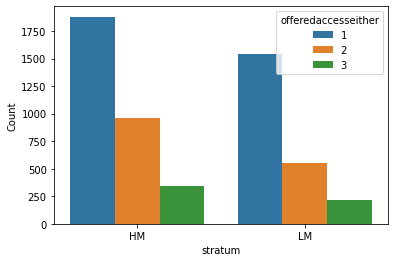

observed data:
 offeredaccesseither     1    2    3
stratum                            
HM                   1880  963  342
LM                   1538  549  218
expected data:
 [[1982.93806922  877.18032787  324.88160291]
 [1435.06193078  634.81967213  235.11839709]]
chi-squared value: 34.8739 for 2 dof; p-value = 0.0000



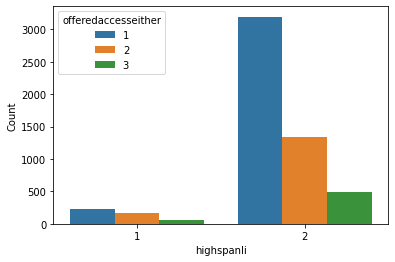

observed data:
 offeredaccesseither     1     2    3
highspanli                          
1                     224   173   62
2                    3194  1339  498
expected data:
 [[ 285.76721311  126.41311475   46.81967213]
 [3132.23278689 1385.58688525  513.18032787]]
chi-squared value: 38.6747 for 2 dof; p-value = 0.0000



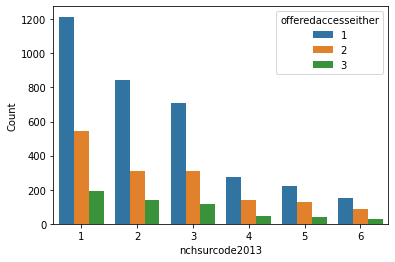

observed data:
 offeredaccesseither     1    2    3
nchsurcode2013                     
1                    1215  542  195
2                     844  309  138
3                     711  307  116
4                     275  138   43
5                     224  128   37
6                     149   88   31
expected data:
 [[1215.28888889  537.6         199.11111111]
 [ 803.75919854  355.55409836  131.6867031 ]
 [ 706.01311475  312.3147541   115.67213115]
 [ 283.89945355  125.58688525   46.5136612 ]
 [ 242.18615665  107.13442623   39.67941712]
 [ 166.85318761   73.80983607   27.33697632]]
chi-squared value: 21.1713 for 10 dof; p-value = 0.0199



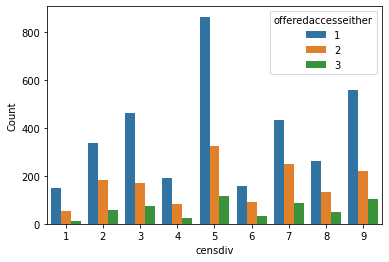

observed data:
 offeredaccesseither    1    2    3
censdiv                           
1                    151   54   12
2                    337  183   59
3                    463  170   75
4                    191   83   23
5                    866  325  118
6                    158   92   31
7                    432  250   88
8                    261  134   51
9                    559  221  103
expected data:
 [[135.10127505  59.76393443  22.13479053]
 [360.47759563 159.46229508  59.06010929]
 [440.79125683 194.99016393  72.21857923]
 [184.90819672  81.79672131  30.29508197]
 [814.96575592 360.51147541 133.52276867]
 [174.94681239  77.39016393  28.66302368]
 [479.39162113 212.06557377  78.5428051 ]
 [277.67358834 122.83278689  45.49362477]
 [549.743898   243.18688525  90.06921676]]
chi-squared value: 50.8921 for 16 dof; p-value = 0.0000



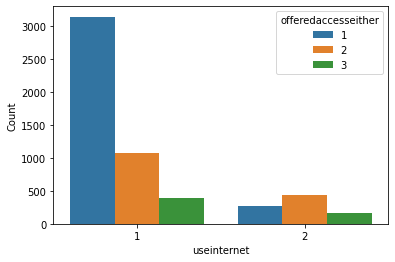

observed data:
 offeredaccesseither     1     2    3
useinternet                         
1                    3142  1081  392
2                     276   431  168
expected data:
 [[2873.23679417 1271.01639344  470.74681239]
 [ 544.76320583  240.98360656   89.25318761]]
chi-squared value: 418.6226 for 2 dof; p-value = 0.0000



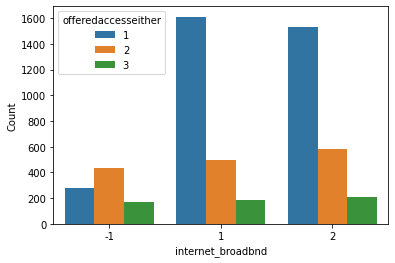

observed data:
 offeredaccesseither     1    2    3
internet_broadbnd                  
-1                    276  431  168
 1                   1611  500  184
 2                   1531  581  208
expected data:
 [[ 544.76320583  240.98360656   89.25318761]
 [1428.83606557  632.06557377  234.09836066]
 [1444.4007286   638.95081967  236.64845173]]
chi-squared value: 427.3582 for 4 dof; p-value = 0.0000



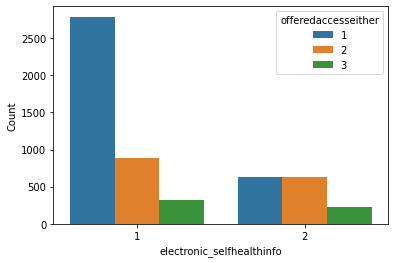

observed data:
 offeredaccesseither           1    2    3
electronic_selfhealthinfo                
1                          2786  885  328
2                           632  627  232
expected data:
 [[2489.72349727 1101.36393443  407.91256831]
 [ 928.27650273  410.63606557  152.08743169]]
chi-squared value: 343.9703 for 2 dof; p-value = 0.0000



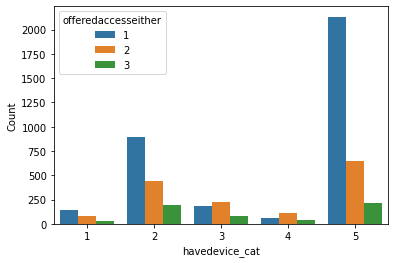

observed data:
 offeredaccesseither     1    2    3
havedevice_cat                     
1                     144   83   31
2                     892  442  193
3                     187  225   85
4                      63  112   38
5                    2132  650  213
expected data:
 [[ 160.6273224    71.0557377    26.31693989]
 [ 950.68961749  420.55081967  155.75956284]
 [ 309.42550091  136.87868852   50.69581056]
 [ 132.61092896   58.66229508   21.72677596]
 [1864.64663024  824.85245902  305.50091075]]
chi-squared value: 347.1974 for 8 dof; p-value = 0.0000



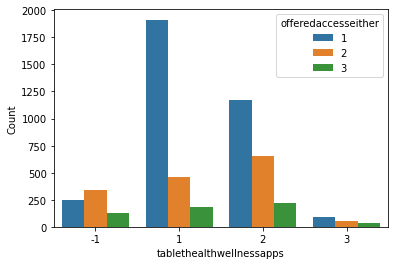

observed data:
 offeredaccesseither          1    2    3
tablethealthwellnessapps                
-1                         250  337  123
 1                        1913  464  184
 2                        1169  658  217
 3                          86   53   36
expected data:
 [[ 442.03642987  195.54098361   72.42258652]
 [1594.44408015  705.32459016  261.23132969]
 [1272.56684882  562.93770492  208.49544627]
 [ 108.95264117   48.19672131   17.85063752]]
chi-squared value: 438.7256 for 6 dof; p-value = 0.0000



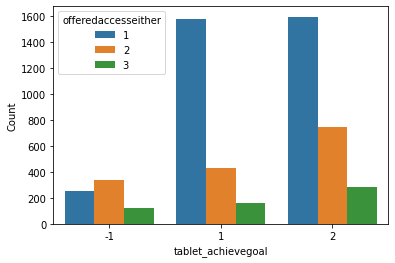

observed data:
 offeredaccesseither     1    2    3
tablet_achievegoal                 
-1                    250  337  123
 1                   1576  433  157
 2                   1592  742  280
expected data:
 [[ 442.03642987  195.54098361   72.42258652]
 [1348.52240437  596.53770492  220.93989071]
 [1627.44116576  719.92131148  266.63752277]]
chi-squared value: 324.9120 for 4 dof; p-value = 0.0000



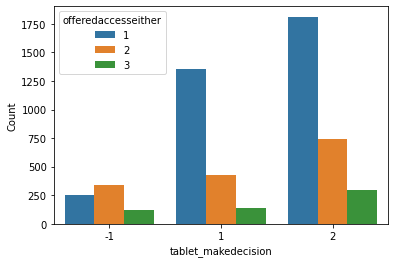

observed data:
 offeredaccesseither     1    2    3
tablet_makedecision                
-1                    250  337  123
 1                   1357  430  137
 2                   1811  745  300
expected data:
 [[ 442.03642987  195.54098361   72.42258652]
 [1197.8564663   529.88852459  196.25500911]
 [1778.10710383  786.5704918   291.32240437]]
chi-squared value: 282.0117 for 4 dof; p-value = 0.0000



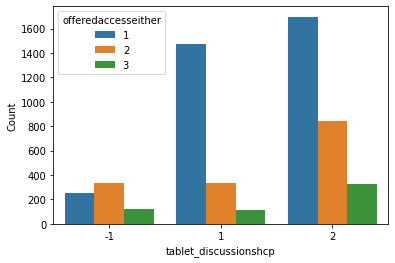

observed data:
 offeredaccesseither       1    2    3
tablet_discussionshcp                
-1                      250  337  123
 1                     1471  334  110
 2                     1697  841  327
expected data:
 [[ 442.03642987  195.54098361   72.42258652]
 [1192.25318761  527.40983607  195.33697632]
 [1783.71038251  789.04918033  292.24043716]]
chi-squared value: 406.2321 for 4 dof; p-value = 0.0000



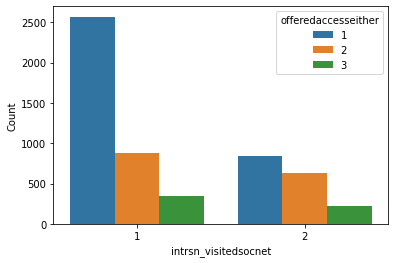

observed data:
 offeredaccesseither      1    2    3
intrsn_visitedsocnet                
1                     2570  886  343
2                      848  626  217
expected data:
 [[2365.20619308 1046.28196721  387.51183971]
 [1052.79380692  465.71803279  172.48816029]]
chi-squared value: 153.8858 for 2 dof; p-value = 0.0000



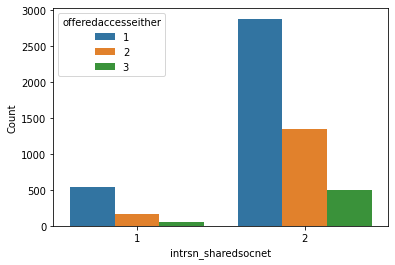

observed data:
 offeredaccesseither     1     2    3
intrsn_sharedsocnet                 
1                     536   170   59
2                    2882  1342  501
expected data:
 [[ 476.27868852  210.68852459   78.03278689]
 [2941.72131148 1301.31147541  481.96721311]]
chi-squared value: 23.2249 for 2 dof; p-value = 0.0000



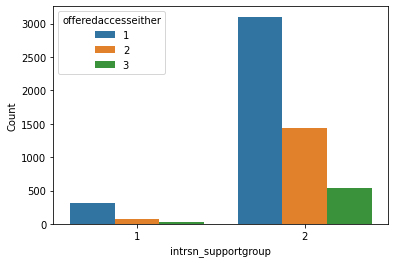

observed data:
 offeredaccesseither     1     2    3
intrsn_supportgroup                 
1                     315    71   27
2                    3103  1441  533
expected data:
 [[ 257.12823315  113.7442623    42.12750455]
 [3160.87176685 1398.2557377   517.87249545]]
chi-squared value: 37.3284 for 2 dof; p-value = 0.0000



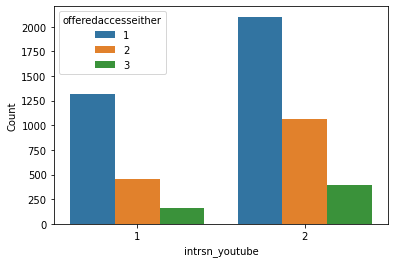

observed data:
 offeredaccesseither     1     2    3
intrsn_youtube                      
1                    1317   451  164
2                    2101  1061  396
expected data:
 [[1202.83715847  532.09180328  197.07103825]
 [2215.16284153  979.90819672  362.92896175]]
chi-squared value: 44.3515 for 2 dof; p-value = 0.0000



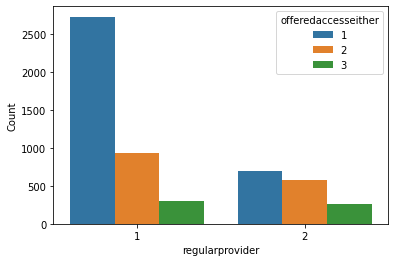

observed data:
 offeredaccesseither     1    2    3
regularprovider                    
1                    2724  934  305
2                     694  578  255
expected data:
 [[2467.31038251 1091.44918033  404.24043716]
 [ 950.68961749  420.55081967  155.75956284]]
chi-squared value: 265.2657 for 2 dof; p-value = 0.0000



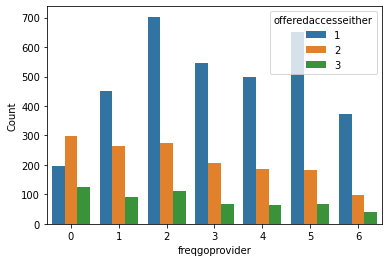

observed data:
 offeredaccesseither    1    2    3
freqgoprovider                    
0                    195  298  125
1                    450  264   90
2                    703  275  110
3                    546  206   66
4                    500  187   63
5                    650  184   66
6                    374   98   40
expected data:
 [[384.75846995 170.20327869  63.03825137]
 [500.55956284 221.4295082   82.01092896]
 [677.37413479 299.64590164 110.97996357]
 [509.27577413 225.2852459   83.43897996]
 [466.93989071 206.55737705  76.50273224]
 [560.32786885 247.86885246  91.80327869]
 [318.76429872 141.00983607  52.22586521]]
chi-squared value: 345.6527 for 12 dof; p-value = 0.0000



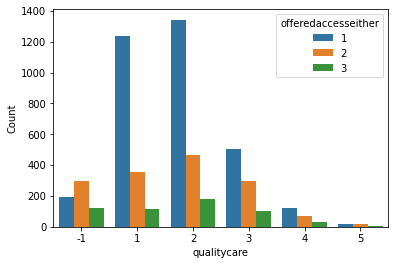

observed data:
 offeredaccesseither     1    2    3
qualitycare                        
-1                    195  298  125
 1                   1235  354  115
 2                   1343  467  182
 3                    504  300  101
 4                    125   73   33
 5                     16   20    4
expected data:
 [[ 384.75846995  170.20327869   63.03825137]
 [1060.88743169  469.29836066  173.81420765]
 [1240.19234973  548.61639344  203.19125683]
 [ 563.44080146  249.24590164   92.3132969 ]
 [ 143.81748634   63.61967213   23.56284153]
 [  24.90346084   11.01639344    4.08014572]]
chi-squared value: 385.6827 for 10 dof; p-value = 0.0000



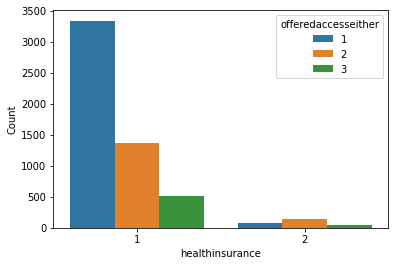

observed data:
 offeredaccesseither     1     2    3
healthinsurance                     
1                    3339  1375  519
2                      79   137   41
expected data:
 [[3257.99526412 1441.21967213  533.78506375]
 [ 160.00473588   70.78032787   26.21493625]]
chi-squared value: 116.7676 for 2 dof; p-value = 0.0000



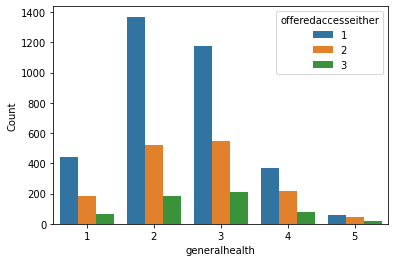

observed data:
 offeredaccesseither     1    2    3
generalhealth                      
1                     441  184   62
2                    1370  520  187
3                    1178  547  211
4                     372  216   80
5                      57   45   20
expected data:
 [[ 427.71693989  189.20655738   70.07650273]
 [1293.11220401  572.02622951  211.86156648]
 [1205.32750455  533.19344262  197.47905282]
 [ 415.88779599  183.97377049   68.13843352]
 [  75.95555556   33.6          12.44444444]]
chi-squared value: 41.0676 for 8 dof; p-value = 0.0000



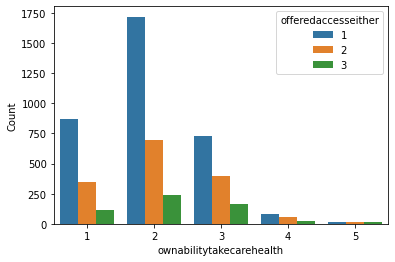

observed data:
 offeredaccesseither          1    2    3
ownabilitytakecarehealth                
1                          873  349  116
2                         1718  694  240
3                          726  394  167
4                           82   57   26
5                           19   18   11
expected data:
 [[ 833.02076503  368.49836066  136.48087432]
 [1651.09945355  730.38688525  270.5136612 ]
 [ 801.26885246  354.45245902  131.27868852]
 [ 102.72677596   45.44262295   16.83060109]
 [  29.88415301   13.21967213    4.89617486]]
chi-squared value: 60.6111 for 8 dof; p-value = 0.0000



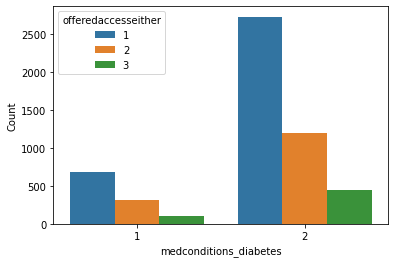

observed data:
 offeredaccesseither        1     2    3
medconditions_diabetes                 
1                        690   314  109
2                       2728  1198  451
expected data:
 [[ 692.93879781  306.53114754  113.53005464]
 [2725.06120219 1205.46885246  446.46994536]]
chi-squared value: 0.4706 for 2 dof; p-value = 0.7903



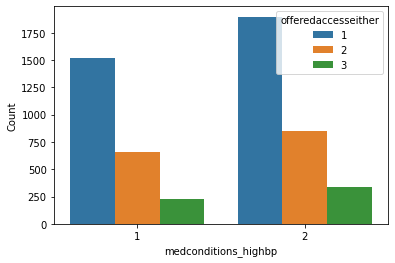

observed data:
 offeredaccesseither      1    2    3
medconditions_highbp                
1                     1521  657  226
2                     1897  855  334
expected data:
 [[1496.69799636  662.0852459   245.21675774]
 [1921.30200364  849.9147541   314.78324226]]
chi-squared value: 3.4506 for 2 dof; p-value = 0.1781



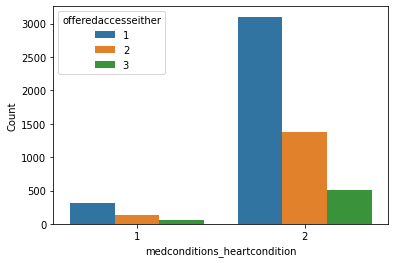

observed data:
 offeredaccesseither              1     2    3
medconditions_heartcondition                 
1                              316   137   51
2                             3102  1375  509
expected data:
 [[ 313.78360656  138.80655738   51.40983607]
 [3104.21639344 1373.19344262  508.59016393]]
chi-squared value: 0.0467 for 2 dof; p-value = 0.9769



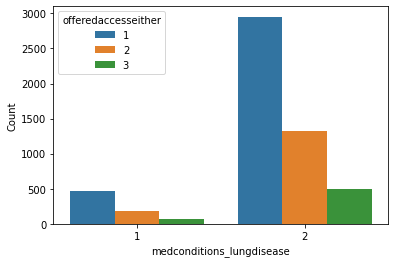

observed data:
 offeredaccesseither           1     2    3
medconditions_lungdisease                 
1                           467   184   63
2                          2951  1328  497
expected data:
 [[ 444.52677596  196.64262295   72.83060109]
 [2973.47322404 1315.35737705  487.16939891]]
chi-squared value: 3.7656 for 2 dof; p-value = 0.1522



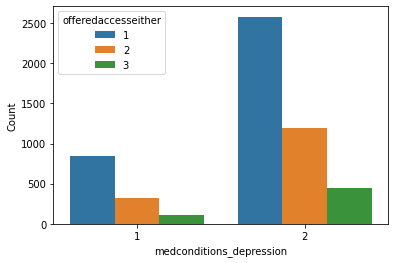

observed data:
 offeredaccesseither          1     2    3
medconditions_depression                 
1                          842   317  111
2                         2576  1195  449
expected data:
 [[ 790.6848816   349.7704918   129.54462659]
 [2627.3151184  1162.2295082   430.45537341]]
chi-squared value: 11.7805 for 2 dof; p-value = 0.0028



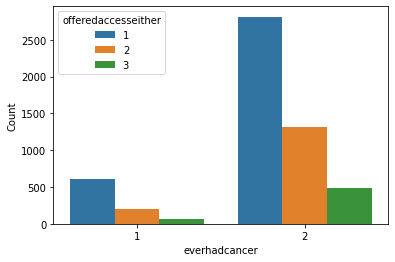

observed data:
 offeredaccesseither     1     2    3
everhadcancer                       
1                     606   195   70
2                    2812  1317  490
expected data:
 [[ 542.27285974  239.88196721   88.84517304]
 [2875.72714026 1272.11803279  471.15482696]]
chi-squared value: 23.6333 for 2 dof; p-value = 0.0000



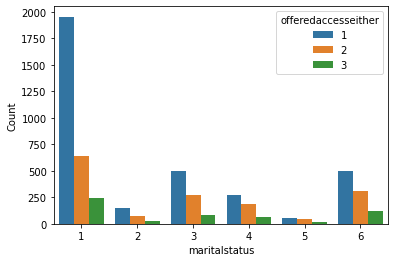

observed data:
 offeredaccesseither     1    2    3
maritalstatus                      
1                    1953  637  245
2                     149   69   27
3                     495  267   87
4                     270  187   67
5                      53   41   15
6                     498  311  119
expected data:
 [[1765.03278689  780.78688525  289.18032787]
 [ 152.53369763   67.47540984   24.99089253]
 [ 528.57595628  233.82295082   86.6010929 ]
 [ 326.23533698  144.3147541    53.44990893]
 [  67.86193078   30.01967213   11.11839709]
 [ 577.76029144  255.58032787   94.65938069]]
chi-squared value: 124.0339 for 10 dof; p-value = 0.0000



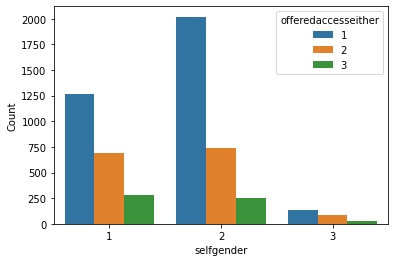

observed data:
 offeredaccesseither     1    2    3
selfgender                         
1                    1269  686  278
2                    2019  742  253
3                     130   84   29
expected data:
 [[1390.23570128  614.99016393  227.77413479]
 [1876.47577413  830.0852459   307.43897996]
 [ 151.28852459   66.92459016   24.78688525]]
chi-squared value: 67.7272 for 4 dof; p-value = 0.0000



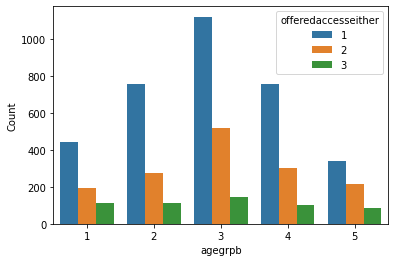

observed data:
 offeredaccesseither     1    2    3
agegrpb                            
1                     442  196  110
2                     760  277  114
3                    1122  520  145
4                     756  303  104
5                     338  216   87
expected data:
 [[ 465.69471767  206.00655738   76.29872495]
 [ 716.59708561  316.99672131  117.40619308]
 [1112.56211293  492.15737705  182.28051002]
 [ 724.06812386  320.30163934  118.63023679]
 [ 399.07795993  176.53770492   65.38433515]]
chi-squared value: 63.0938 for 8 dof; p-value = 0.0000



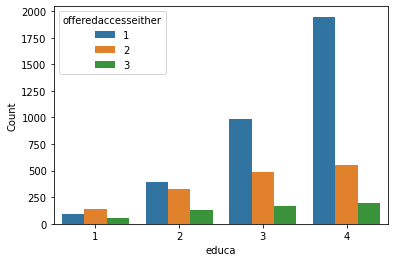

observed data:
 offeredaccesseither     1    2    3
educa                              
1                      95  142   59
2                     394  329  130
3                     982  488  171
4                    1947  553  200
expected data:
 [[ 184.2856102    81.52131148   30.19307832]
 [ 531.06630237  234.92459016   87.00910747]
 [1021.66448087  451.94754098  167.38797814]
 [1680.98360656  743.60655738  275.40983607]]
chi-squared value: 325.9976 for 6 dof; p-value = 0.0000



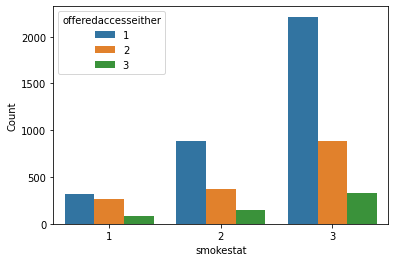

observed data:
 offeredaccesseither     1    2    3
smokestat                          
1                     315  262   81
2                     889  367  146
3                    2214  883  333
expected data:
 [[ 409.66193078  181.21967213   67.11839709]
 [ 872.86630237  386.12459016  143.00910747]
 [2135.47176685  944.6557377   349.87249545]]
chi-squared value: 69.7870 for 4 dof; p-value = 0.0000



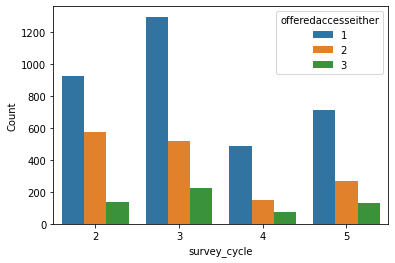

observed data:
 offeredaccesseither     1    2    3
survey_cycle                       
2                     926  576  138
3                    1294  516  222
4                     484  150   72
5                     714  270  128
expected data:
 [[1021.04189435  451.67213115  167.2859745 ]
 [1265.09581056  559.63278689  207.27140255]
 [ 439.54608379  194.43934426   72.01457195]
 [ 692.31621129  306.2557377   113.428051  ]]
chi-squared value: 74.8012 for 6 dof; p-value = 0.0000



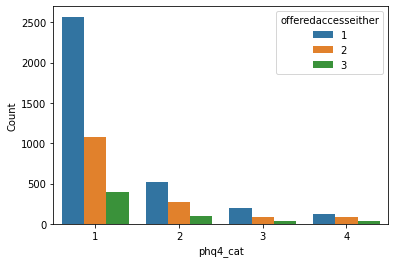

observed data:
 offeredaccesseither     1     2    3
phq4_cat                            
1                    2570  1073  394
2                     523   269  104
3                     203    86   32
4                     122    84   30
expected data:
 [[2513.38178506 1111.8295082   411.78870674]
 [ 557.83752277  246.76721311   91.39526412]
 [ 199.85027322   88.40655738   32.7431694 ]
 [ 146.93041894   64.99672131   24.07285974]]
chi-squared value: 20.6945 for 6 dof; p-value = 0.0021



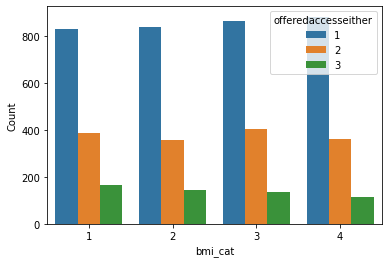

observed data:
 offeredaccesseither    1    2    3
bmi_cat                           
1                    833  388  164
2                    839  359  145
3                    863  405  137
4                    883  360  114
expected data:
 [[862.28233151 381.44262295 141.27504554]
 [836.13369763 369.87540984 136.99089253]
 [874.73406193 386.95081967 143.3151184 ]
 [844.84990893 373.73114754 138.41894353]]
chi-squared value: 13.3730 for 6 dof; p-value = 0.0375



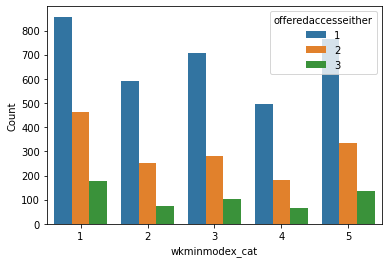

observed data:
 offeredaccesseither    1    2    3
wkminmodex_cat                    
1                    857  461  177
2                    591  251   76
3                    707  282  105
4                    498  183   66
5                    765  335  136
expected data:
 [[930.76684882 411.73770492 152.49544627]
 [571.53442623 252.82622951  93.63934426]
 [681.10965392 301.29836066 111.59198543]
 [465.07213115 205.73114754  76.19672131]
 [769.51693989 340.40655738 126.07650273]]
chi-squared value: 29.3874 for 8 dof; p-value = 0.0003



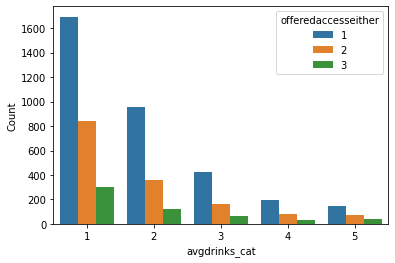

observed data:
 offeredaccesseither     1    2    3
avgdrinks_cat                      
1                    1694  843  304
2                     956  355  118
3                     425  163   61
4                     195   78   35
5                     148   73   42
expected data:
 [[1768.76830601  782.43934426  289.79234973]
 [ 889.67613843  393.56065574  145.76320583]
 [ 404.05865209  178.74098361   66.2003643 ]
 [ 191.75664845   84.82622951   31.41712204]
 [ 163.74025501   72.43278689   26.82695811]]
chi-squared value: 36.5471 for 8 dof; p-value = 0.0000



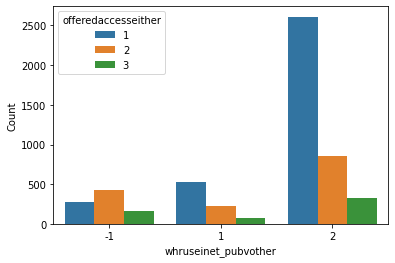

observed data:
 offeredaccesseither      1    2    3
whruseinet_pubvother                
-1                     276  431  168
 1                     533  231   70
 2                    2609  850  322
expected data:
 [[ 544.76320583  240.98360656   89.25318761]
 [ 519.23715847  229.69180328   85.07103825]
 [2353.9996357  1041.32459016  385.67577413]]
chi-squared value: 428.2331 for 4 dof; p-value = 0.0000



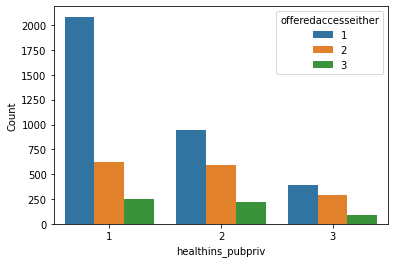

observed data:
 offeredaccesseither     1    2    3
healthins_pubpriv                  
1                    2085  624  252
2                     944  596  221
3                     389  292   87
expected data:
 [[1843.47868852  815.48852459  302.03278689]
 [1096.37486339  484.99672131  179.6284153 ]
 [ 478.14644809  211.5147541    78.33879781]]
chi-squared value: 189.2109 for 4 dof; p-value = 0.0000



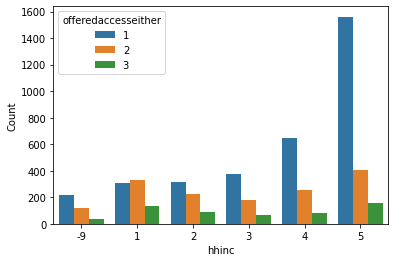

observed data:
 offeredaccesseither     1    2    3
hhinc                              
-9                    216  118   35
 1                    308  328  131
 2                    317  225   89
 3                    373  177   69
 4                    643  258   82
 5                   1561  406  154
expected data:
 [[ 229.73442623  101.62622951   37.63934426]
 [ 477.52386157  211.23934426   78.23679417]
 [ 392.85209472  173.78360656   64.36429872]
 [ 385.38105647  170.47868852   63.14025501]
 [ 612.00255009  270.72786885  100.26958106]
 [1320.50601093  584.1442623   216.34972678]]
chi-squared value: 325.9017 for 10 dof; p-value = 0.0000



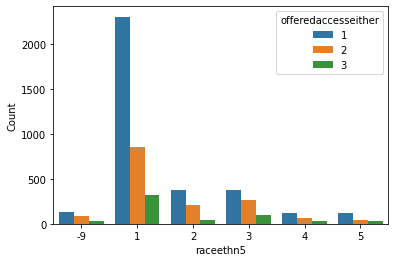

observed data:
 offeredaccesseither     1    2    3
raceethn5                          
-9                    128   82   31
 1                   2303  858  318
 2                    371  207   46
 3                    374  265  103
 4                    120   63   36
 5                    122   37   26
expected data:
 [[ 150.04335155   66.37377049   24.58287796]
 [2165.97850638  958.15081967  354.87067395]
 [ 388.49398907  171.8557377    63.65027322]
 [ 461.95919854  204.35409836   75.6867031 ]
 [ 136.34644809   60.3147541    22.33879781]
 [ 115.17850638   50.95081967   18.87067395]]
chi-squared value: 106.3821 for 10 dof; p-value = 0.0000



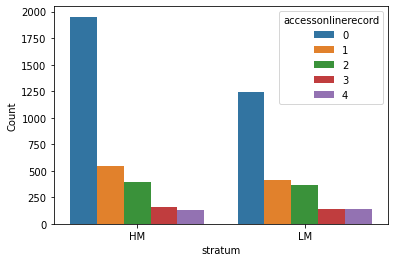

observed data:
 accessonlinerecord     0    1    2    3    4
stratum                                     
HM                  1952  548  397  159  129
LM                  1244  417  366  137  141
expected data:
 [[1854.14571949  559.84061931  442.65118397  171.72313297  156.63934426]
 [1341.85428051  405.15938069  320.34881603  124.27686703  113.36065574]]
chi-squared value: 37.9716 for 4 dof; p-value = 0.0000



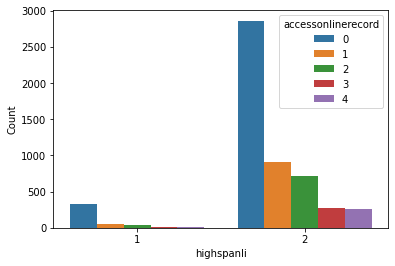

observed data:
 accessonlinerecord     0    1    2    3    4
highspanli                                  
1                    333   56   42   16   12
2                   2863  909  721  280  258
expected data:
 [[ 267.20655738   80.68032787   63.79180328   24.74754098   22.57377049]
 [2928.79344262  884.31967213  699.20819672  271.25245902  247.42622951]]
chi-squared value: 42.8190 for 4 dof; p-value = 0.0000



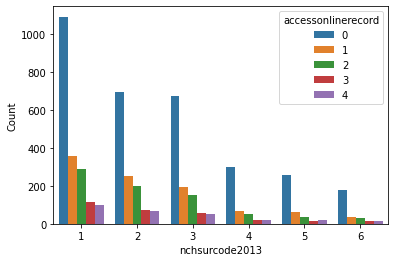

observed data:
 accessonlinerecord     0    1    2    3   4
nchsurcode2013                             
1                   1091  359  289  116  97
2                    697  252  201   71  70
3                    675  192  154   59  54
4                    298   66   54   20  18
5                    257   61   36   17  18
6                    178   35   29   13  13
expected data:
 [[1136.35555556  343.11111111  271.28888889  105.24444444   96.        ]
 [ 751.55482696  226.92440801  179.42313297   69.60582878   63.49180328]
 [ 660.15737705  199.32786885  157.60327869   61.14098361   55.7704918 ]
 [ 265.46010929   80.15300546   63.37486339   24.58579235   22.42622951]
 [ 226.456102     68.37613843   54.06320583   20.97340619   19.13114754]
 [ 156.01602914   47.10746812   37.24663024   14.44954463   13.18032787]]
chi-squared value: 45.2064 for 20 dof; p-value = 0.0010



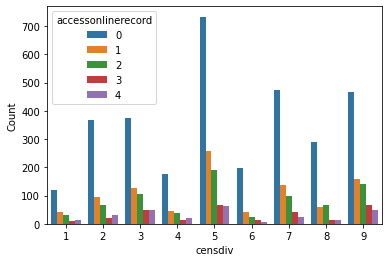

observed data:
 accessonlinerecord    0    1    2   3   4
censdiv                                  
1                   121   41   32   9  14
2                   367   94   66  22  30
3                   375  127  107  49  50
4                   176   47   38  14  22
5                   733  256  191  67  62
6                   196   43   23  12   7
7                   472  136   98  40  24
8                   290   61   67  15  13
9                   466  160  141  68  48
expected data:
 [[126.32641166  38.14298725  30.15865209  11.69981785  10.67213115]
 [337.06448087 101.77322404  80.46939891  31.21748634  28.47540984]
 [412.16174863 124.44808743  98.39781421  38.1726776   34.81967213]
 [172.89836066  52.20491803  41.27704918  16.01311475  14.60655738]
 [762.03351548 230.08834244 181.92477231  70.57632058  64.37704918]
 [163.58397086  49.39253188  39.05336976  15.15045537  13.81967213]
 [448.25500911 135.34608379 107.01457195  41.5154827   37.86885246]
 [259.63861566  78.39526412  6

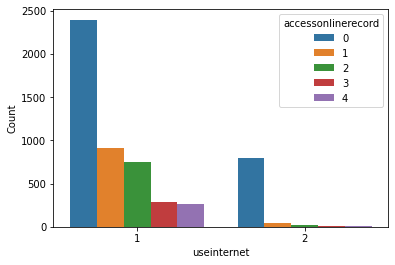

observed data:
 accessonlinerecord     0    1    2    3    4
useinternet                                 
1                   2398  917  745  289  266
2                    798   48   18    7    4
expected data:
 [[2686.61930783  811.19763206  641.39253188  248.82331512  226.96721311]
 [ 509.38069217  153.80236794  121.60746812   47.17668488   43.03278689]]
chi-squared value: 468.9500 for 4 dof; p-value = 0.0000



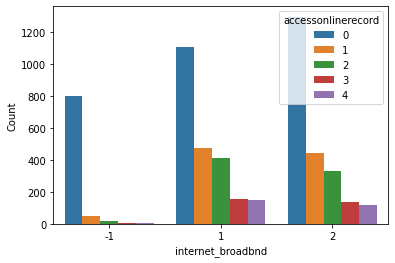

observed data:
 accessonlinerecord     0    1    2    3    4
internet_broadbnd                           
-1                   798   48   18    7    4
 1                  1104  475  414  155  147
 2                  1294  442  331  134  119
expected data:
 [[ 509.38069217  153.80236794  121.60746812   47.17668488   43.03278689]
 [1336.03278689  403.40163934  318.95901639  123.73770492  112.86885246]
 [1350.58652095  407.79599271  322.43351548  125.0856102   114.09836066]]
chi-squared value: 500.0663 for 8 dof; p-value = 0.0000



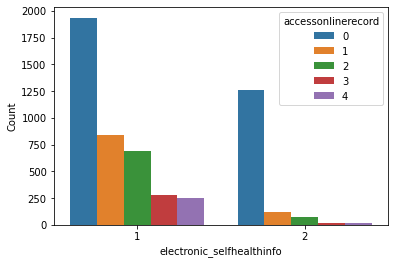

observed data:
 accessonlinerecord            0    1    2    3    4
electronic_selfhealthinfo                          
1                          1934  841  692  280  252
2                          1262  124   71   16   18
expected data:
 [[2328.01530055  702.92076503  555.78087432  215.61092896  196.67213115]
 [ 867.98469945  262.07923497  207.21912568   80.38907104   73.32786885]]
chi-squared value: 596.4659 for 4 dof; p-value = 0.0000



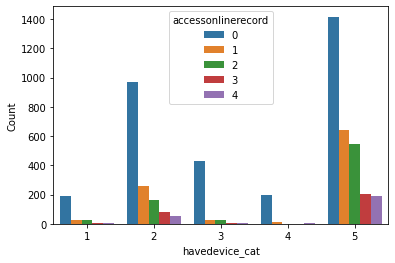

observed data:
 accessonlinerecord     0    1    2    3    4
havedevice_cat                              
1                    190   24   28    7    9
2                    969  262  162   79   55
3                    427   25   27    9    9
4                    195   13    2    0    3
5                   1415  641  544  201  194
expected data:
 [[ 150.19453552   45.34972678   35.8568306    13.91038251   12.68852459]
 [ 888.9420765   268.40710383  212.22240437   82.33005464   75.09836066]
 [ 289.32823315   87.35974499   69.07304189   26.79635701   24.44262295]
 [ 123.99781421   37.43989071   29.60273224   11.48415301   10.47540984]
 [1743.53734062  526.4435337   416.24499089  161.47905282  147.29508197]]
chi-squared value: 458.5088 for 16 dof; p-value = 0.0000



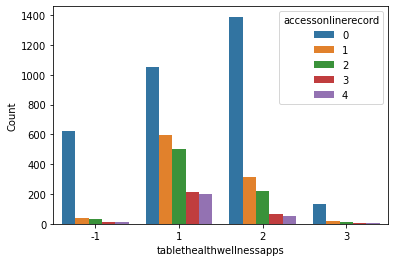

observed data:
 accessonlinerecord           0    1    2    3    4
tablethealthwellnessapps                          
-1                         622   38   29    9   12
 1                        1050  596  500  215  200
 2                        1390  311  223   69   51
 3                         134   20   11    3    7
expected data:
 [[ 413.32604736  124.7996357    98.67577413   38.28051002   34.91803279]
 [1490.8845173   450.1575592   355.9276867   138.07941712  125.95081967]
 [1189.9132969   359.28233151  284.07504554  110.20473588  100.52459016]
 [ 101.87613843   30.76047359   24.32149362    9.43533698    8.60655738]]
chi-squared value: 693.6398 for 12 dof; p-value = 0.0000



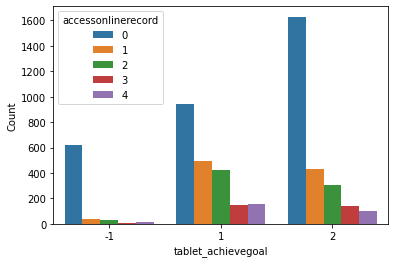

observed data:
 accessonlinerecord     0    1    2    3    4
tablet_achievegoal                          
-1                   622   38   29    9   12
 1                   945  492  427  145  157
 2                  1629  435  307  142  101
expected data:
 [[ 413.32604736  124.7996357    98.67577413   38.28051002   34.91803279]
 [1260.93551913  380.72677596  301.03060109  116.78251366  106.52459016]
 [1521.73843352  459.47358834  363.29362477  140.93697632  128.55737705]]
chi-squared value: 470.9910 for 8 dof; p-value = 0.0000



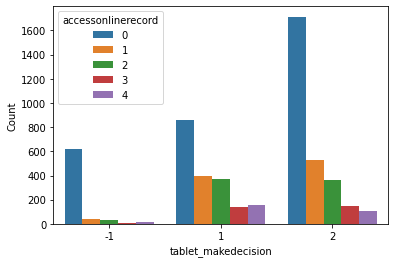

observed data:
 accessonlinerecord      0    1    2    3    4
tablet_makedecision                          
-1                    622   38   29    9   12
 1                    861  400  368  140  155
 2                   1713  527  366  147  103
expected data:
 [[ 413.32604736  124.7996357    98.67577413   38.28051002   34.91803279]
 [1120.05537341  338.18943534  267.39744991  103.73479053   94.62295082]
 [1662.61857923  502.01092896  396.92677596  153.98469945  140.45901639]]
chi-squared value: 428.1131 for 8 dof; p-value = 0.0000



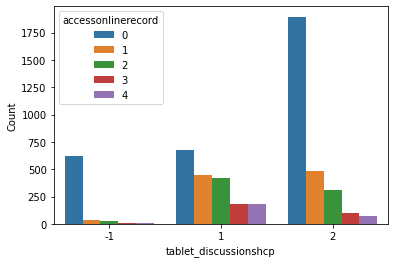

observed data:
 accessonlinerecord        0    1    2    3    4
tablet_discussionshcp                          
-1                      622   38   29    9   12
 1                      679  443  423  185  185
 2                     1895  484  311  102   73
expected data:
 [[ 413.32604736  124.7996357    98.67577413   38.28051002   34.91803279]
 [1114.81602914  336.60746812  266.14663024  103.24954463   94.18032787]
 [1667.8579235   503.59289617  398.17759563  154.46994536  140.90163934]]
chi-squared value: 802.4379 for 8 dof; p-value = 0.0000



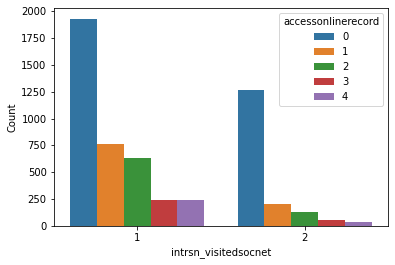

observed data:
 accessonlinerecord       0    1    2    3    4
intrsn_visitedsocnet                          
1                     1929  759  629  244  238
2                     1267  206  134   52   32
expected data:
 [[2211.58542805  667.76593807  527.9848816   204.8276867   186.83606557]
 [ 984.41457195  297.23406193  235.0151184    91.1723133    83.16393443]]
chi-squared value: 290.2498 for 4 dof; p-value = 0.0000



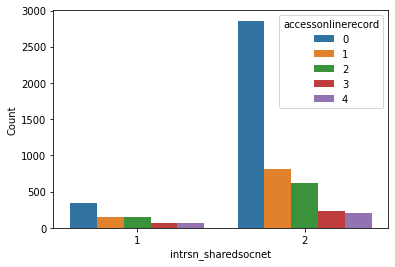

observed data:
 accessonlinerecord      0    1    2    3    4
intrsn_sharedsocnet                          
1                     338  156  149   61   61
2                    2858  809  614  235  209
expected data:
 [[ 445.3442623   134.46721311  106.31967213   41.24590164   37.62295082]
 [2750.6557377   830.53278689  656.68032787  254.75409836  232.37704918]]
chi-squared value: 81.8465 for 4 dof; p-value = 0.0000



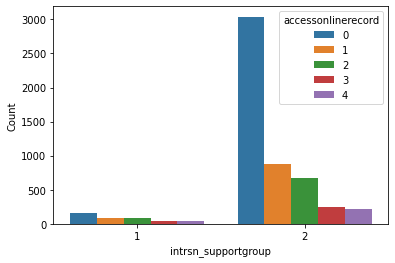

observed data:
 accessonlinerecord      0    1    2    3    4
intrsn_supportgroup                          
1                     159   81   84   43   46
2                    3037  884  679  253  224
expected data:
 [[ 240.4276867    72.59471767   57.39872495   22.26739526   20.31147541]
 [2955.5723133   892.40528233  705.60127505  273.73260474  249.68852459]]
chi-squared value: 100.2105 for 4 dof; p-value = 0.0000



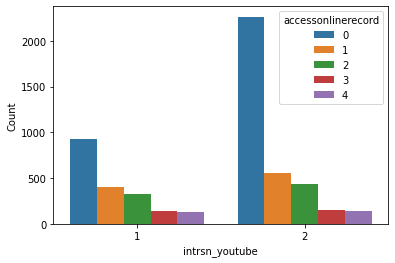

observed data:
 accessonlinerecord     0    1    2    3    4
intrsn_youtube                              
1                    933  404  331  139  125
2                   2263  561  432  157  145
expected data:
 [[1124.71256831  339.59562842  268.50928962  104.16612022   95.01639344]
 [2071.28743169  625.40437158  494.49071038  191.83387978  174.98360656]]
chi-squared value: 124.2835 for 4 dof; p-value = 0.0000



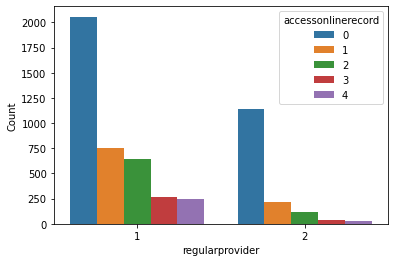

observed data:
 accessonlinerecord     0    1    2    3    4
regularprovider                             
1                   2056  753  646  262  246
2                   1140  212  117   34   24
expected data:
 [[2307.0579235   696.59289617  550.77759563  213.66994536  194.90163934]
 [ 888.9420765   268.40710383  212.22240437   82.33005464   75.09836066]]
chi-squared value: 261.3031 for 4 dof; p-value = 0.0000



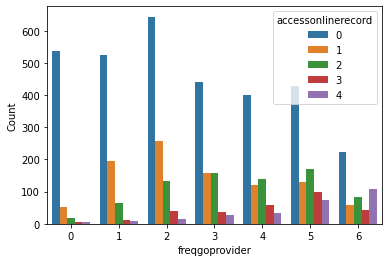

observed data:
 accessonlinerecord    0    1    2    3    4
freqgoprovider                             
0                   537   51   19    6    5
1                   524  194   64   12   10
2                   644  256  133   41   14
3                   441  157  157   37   26
4                   399  121  138   58   34
5                   428  129  169  100   74
6                   223   57   83   42  107
expected data:
 [[359.76830601 108.6284153   85.88961749  33.32021858  30.39344262]
 [468.04808743 141.32240437 111.73989071  43.34863388  39.54098361]
 [633.37850638 191.24225865 151.21020036  58.66083789  53.50819672]
 [476.19817851 143.78324226 113.6856102   44.10346084  40.2295082 ]
 [436.61202186 131.83060109 104.23497268  40.43715847  36.8852459 ]
 [523.93442623 158.19672131 125.08196721  48.52459016  44.26229508]
 [298.06047359  89.99635701  71.15774135  27.60510018  25.18032787]]
chi-squared value: 832.5551 for 24 dof; p-value = 0.0000



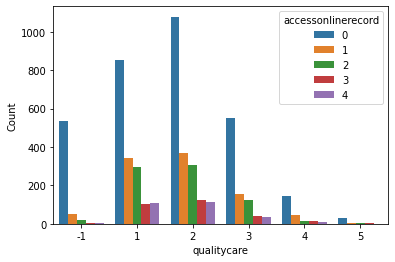

observed data:
 accessonlinerecord     0    1    2    3    4
qualitycare                                 
-1                   537   51   19    6    5
 1                   853  341  296  105  109
 2                  1078  370  305  126  113
 3                   553  154  124   40   34
 4                   146   46   16   15    8
 5                    29    3    3    4    1
expected data:
 [[ 359.76830601  108.6284153    85.88961749   33.32021858   30.39344262]
 [ 991.98251366  299.51912568  236.82185792   91.87322404   83.80327869]
 [1159.64153005  350.1420765   276.84808743  107.4010929    97.96721311]
 [ 526.84517304  159.07559199  125.77686703   48.79417122   44.50819672]
 [ 134.47650273   40.60382514   32.10437158   12.45464481   11.36065574]
 [  23.2859745     7.03096539    5.55919854    2.15664845    1.96721311]]
chi-squared value: 302.1023 for 20 dof; p-value = 0.0000



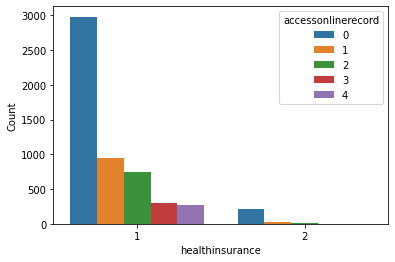

observed data:
 accessonlinerecord     0    1    2    3    4
healthinsurance                             
1                   2979  941  752  294  267
2                    217   24   11    2    3
expected data:
 [[3046.38761384  919.82604736  727.28214936  282.1435337   257.36065574]
 [ 149.61238616   45.17395264   35.71785064   13.8564663    12.63934426]]
chi-squared value: 78.5565 for 4 dof; p-value = 0.0000



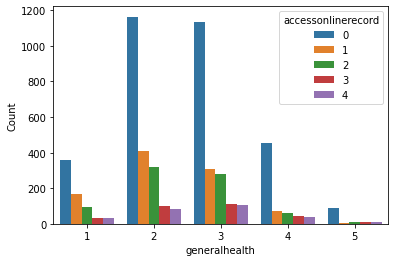

observed data:
 accessonlinerecord     0    1    2    3    4
generalhealth                               
1                    359  168   95   33   32
2                   1164  410  318  100   85
3                   1132  310  280  111  103
4                    452   70   61   44   41
5                     89    7    9    8    9
expected data:
 [[ 399.93661202  120.7568306    95.47923497   37.04043716   33.78688525]
 [1209.12422587  365.08287796  288.66138434  111.98397086  102.14754098]
 [1127.04116576  340.29872495  269.06520947  104.38178506   95.21311475]
 [ 388.87577413  117.41712204   92.83861566   36.01602914   32.85245902]
 [  71.02222222   21.44444444   16.95555556    6.57777778    6.        ]]
chi-squared value: 105.7092 for 16 dof; p-value = 0.0000



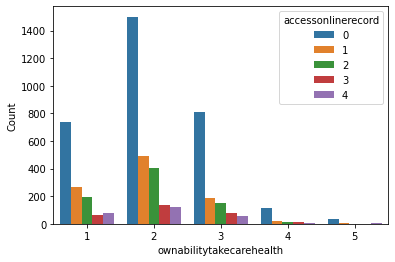

observed data:
 accessonlinerecord           0    1    2    3    4
ownabilitytakecarehealth                          
1                          734  264  193   67   80
2                         1500  489  405  135  123
3                          808  189  151   80   59
4                          116   19   13   12    5
5                           38    4    1    2    3
expected data:
 [[ 778.91584699  235.18579235  185.95519126   72.13989071   65.80327869]
 [1543.86010929  466.15300546  368.57486339  142.98579235  130.42622951]
 [ 749.22622951  226.22131148  178.86721311   69.39016393   63.29508197]
 [  96.05464481   29.00273224   22.93169399    8.89617486    8.1147541 ]
 [  27.9431694     8.43715847    6.67103825    2.58797814    2.36065574]]
chi-squared value: 58.8928 for 16 dof; p-value = 0.0000



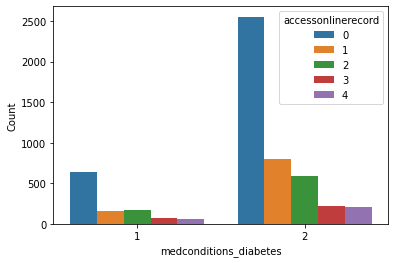

observed data:
 accessonlinerecord         0    1    2    3    4
medconditions_diabetes                          
1                        642  163  172   74   62
2                       2554  802  591  222  208
expected data:
 [[ 647.93224044  195.63661202  154.68469945   60.00874317   54.73770492]
 [2548.06775956  769.36338798  608.31530055  235.99125683  215.26229508]]
chi-squared value: 14.6284 for 4 dof; p-value = 0.0055



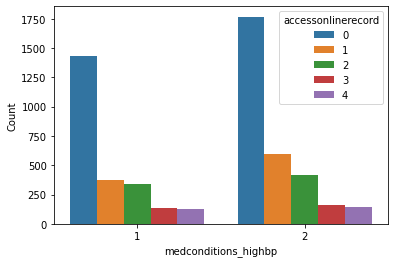

observed data:
 accessonlinerecord       0    1    2    3    4
medconditions_highbp                          
1                     1429  371  344  137  123
2                     1767  594  419  159  147
expected data:
 [[1399.4870674   422.56102004  334.10783242  129.61457195  118.2295082 ]
 [1796.5129326   542.43897996  428.89216758  166.38542805  151.7704918 ]]
chi-squared value: 13.9119 for 4 dof; p-value = 0.0076



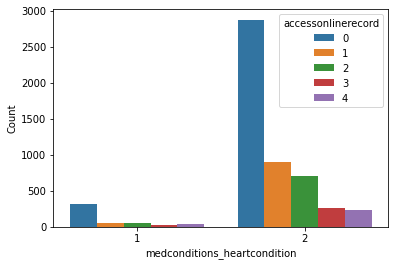

observed data:
 accessonlinerecord               0    1    2    3    4
medconditions_heartcondition                          
1                              317   58   58   33   38
2                             2879  907  705  263  232
expected data:
 [[ 293.40327869   88.59016393   70.04590164   27.17377049   24.78688525]
 [2902.59672131  876.40983607  692.95409836  268.82622951  245.21311475]]
chi-squared value: 25.1320 for 4 dof; p-value = 0.0000



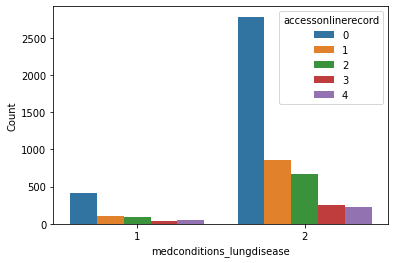

observed data:
 accessonlinerecord            0    1    2    3    4
medconditions_lungdisease                          
1                           414  111   99   43   47
2                          2782  854  664  253  223
expected data:
 [[ 415.65464481  125.50273224   99.23169399   38.49617486   35.1147541 ]
 [2780.34535519  839.49726776  663.76830601  257.50382514  234.8852459 ]]
chi-squared value: 7.1645 for 4 dof; p-value = 0.1274



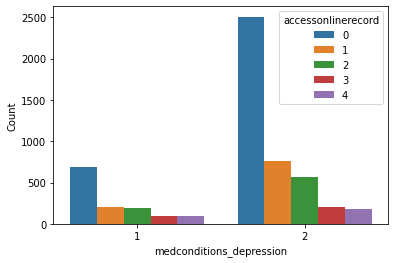

observed data:
 accessonlinerecord           0    1    2    3    4
medconditions_depression                          
1                          688  204  197   91   90
2                         2508  761  566  205  180
expected data:
 [[ 739.32969035  223.23315118  176.50455373   68.47358834   62.45901639]
 [2456.67030965  741.76684882  586.49544627  227.52641166  207.54098361]]
chi-squared value: 35.3278 for 4 dof; p-value = 0.0000



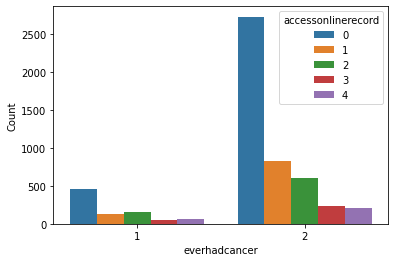

observed data:
 accessonlinerecord     0    1    2    3    4
everhadcancer                               
1                    462  131  156   55   67
2                   2734  834  607  241  203
expected data:
 [[ 507.05209472  153.0992714   121.05154827   46.96102004   42.83606557]
 [2688.94790528  811.9007286   641.94845173  249.03897996  227.16393443]]
chi-squared value: 38.3787 for 4 dof; p-value = 0.0000



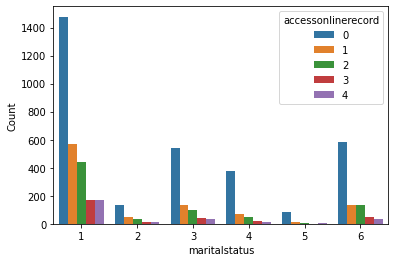

observed data:
 accessonlinerecord     0    1    2    3    4
maritalstatus                               
1                   1477  571  444  172  171
2                    135   49   35   14   12
3                    544  133   97   40   35
4                    376   69   46   21   12
5                     83   11    9    1    5
6                    581  132  132   48   35
expected data:
 [[1650.39344262  498.31967213  394.00819672  152.85245902  139.42622951]
 [ 142.62659381   43.06466302   34.05009107   13.20947177   12.04918033]
 [ 494.24480874  149.23224044  117.99398907   45.77486339   41.75409836]
 [ 305.04626594   92.10564663   72.82550091   28.25209472   25.7704918 ]
 [  63.45428051   19.15938069   15.14881603    5.87686703    5.36065574]
 [ 540.23460838  163.11839709  128.97340619   50.03424408   45.63934426]]
chi-squared value: 127.4501 for 20 dof; p-value = 0.0000



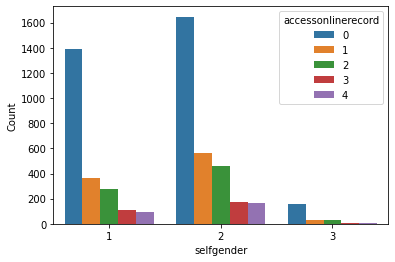

observed data:
 accessonlinerecord     0    1    2    3    4
selfgender                                  
1                   1389  365  273  109   97
2                   1647  566  457  177  167
3                    160   34   33   10    6
expected data:
 [[1299.93952641  392.50364299  310.34225865  120.39489982  109.81967213]
 [1754.59817851  529.78324226  418.8856102   162.50346084  148.2295082 ]
 [ 141.46229508   42.71311475   33.77213115   13.10163934   11.95081967]]
chi-squared value: 39.2311 for 8 dof; p-value = 0.0000



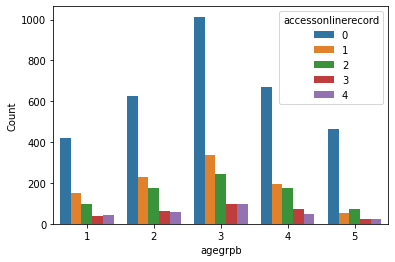

observed data:
 accessonlinerecord     0    1    2   3   4
agegrpb                                   
1                    422  150   96  36  44
2                    624  230  176  63  58
3                   1014  335  243  99  96
4                    670  195  176  74  48
5                    466   55   72  24  24
expected data:
 [[ 435.44772313  131.47905282  103.95701275   40.32932605   36.78688525]
 [ 670.05391621  202.31602914  159.96593807   62.0575592    56.60655738]
 [1040.30091075  314.10837887  248.3571949    96.34826958   87.8852459 ]
 [ 677.03970856  204.42531876  161.63369763   62.70455373   57.19672131]
 [ 373.15774135  112.6712204    89.08615665   34.56029144   31.52459016]]
chi-squared value: 83.3305 for 16 dof; p-value = 0.0000



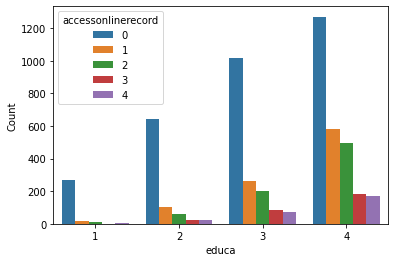

observed data:
 accessonlinerecord     0    1    2    3    4
educa                                       
1                    266   17    9    1    3
2                    641  101   62   25   24
3                   1019  263  199   87   73
4                   1270  584  493  183  170
expected data:
 [[ 172.31621129   52.0291439    41.13806922   15.95919854   14.55737705]
 [ 496.57340619  149.93533698  118.54990893   45.99052823   41.95081967]
 [ 955.30710383  288.44535519  228.06612022   88.47650273   80.70491803]
 [1571.80327869  474.59016393  375.24590164  145.57377049  132.78688525]]
chi-squared value: 376.1665 for 12 dof; p-value = 0.0000



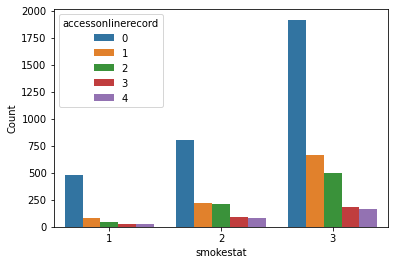

observed data:
 accessonlinerecord     0    1    2    3    4
smokestat                                   
1                    480   80   47   25   26
2                    799  220  215   90   78
3                   1917  665  501  181  166
expected data:
 [[ 383.05428051  115.65938069   91.44881603   35.47686703   32.36065574]
 [ 816.17340619  246.43533698  194.84990893   75.59052823   68.95081967]
 [1996.7723133   602.90528233  476.70127505  184.93260474  168.68852459]]
chi-squared value: 81.6411 for 8 dof; p-value = 0.0000



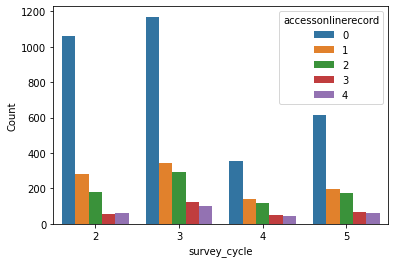

observed data:
 accessonlinerecord     0    1    2    3    4
survey_cycle                                
2                   1060  284  179   56   61
3                   1170  342  296  121  103
4                    353  143  116   51   43
5                    613  196  172   68   63
expected data:
 [[ 954.72495446  288.26958106  227.92714026   88.42258652   80.6557377 ]
 [1182.92750455  357.17304189  282.40728597  109.55774135   99.93442623]
 [ 410.99744991  124.09653916   98.11985428   38.06484517   34.72131148]
 [ 647.35009107  195.46083789  154.54571949   59.95482696   54.68852459]]
chi-squared value: 68.4120 for 12 dof; p-value = 0.0000



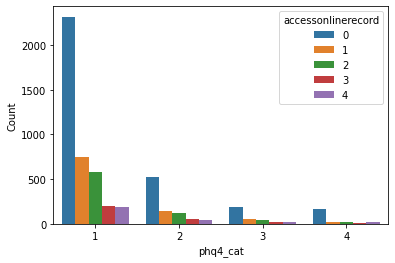

observed data:
 accessonlinerecord     0    1    2    3    4
phq4_cat                                    
1                   2316  744  580  205  192
2                    527  147  122   59   41
3                    187   54   44   19   17
4                    166   20   17   13   20
expected data:
 [[2350.13697632  709.60018215  561.06211293  217.65974499  198.54098361]
 [ 521.60582878  157.49362477  124.52604736   48.30892532   44.06557377]
 [ 186.86994536   56.42349727   44.61256831   17.30710383   15.78688525]
 [ 137.38724954   41.48269581   32.7992714    12.72422587   11.60655738]]
chi-squared value: 38.2819 for 12 dof; p-value = 0.0001



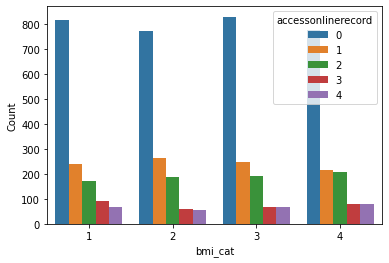

observed data:
 accessonlinerecord    0    1    2   3   4
bmi_cat                                  
1                   817  238  173  90  67
2                   773  265  189  60  56
3                   829  248  193  68  67
4                   777  214  208  78  80
expected data:
 [[806.27686703 243.44717668 192.48724954  74.67395264  68.1147541 ]
 [781.82659381 236.06466302 186.65009107  72.40947177  66.04918033]
 [817.91985428 246.96265938 195.26684882  75.75227687  69.09836066]
 [789.97668488 238.52550091 188.59581056  73.16429872  66.73770492]]
chi-squared value: 21.4571 for 12 dof; p-value = 0.0441



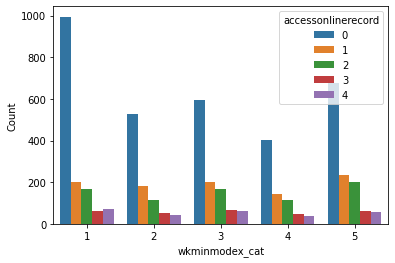

observed data:
 accessonlinerecord    0    1    2   3   4
wkminmodex_cat                           
1                   994  201  167  62  71
2                   526  180  115  54  43
3                   596  202  168  68  60
4                   403  145  113  48  38
5                   677  237  200  64  58
expected data:
 [[870.3132969  262.78233151 207.77504554  80.60473588  73.52459016]
 [534.41311475 161.36065574 127.58360656  49.49508197  45.14754098]
 [636.87140255 192.29690346 152.04408015  58.98433515  53.80327869]
 [434.86557377 131.30327869 103.81803279  40.27540984  36.73770492]
 [719.53661202 217.2568306  171.77923497  66.64043716  60.78688525]]
chi-squared value: 70.6822 for 16 dof; p-value = 0.0000



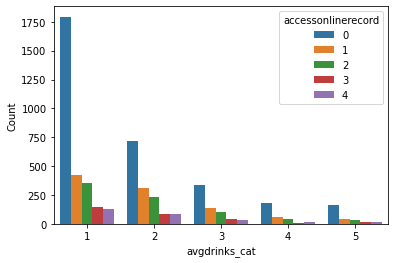

observed data:
 accessonlinerecord     0    1    2    3    4
avgdrinks_cat                               
1                   1794  423  351  148  125
2                    722  307  234   83   83
3                    340  138   99   40   32
4                    180   58   42   11   17
5                    160   39   37   14   13
expected data:
 [[1653.8863388   499.37431694  394.8420765   153.17595628  139.72131148]
 [ 831.89143898  251.18123862  198.60236794   77.04626594   70.27868852]
 [ 377.81493625  114.07741348   90.19799636   34.99162113   31.91803279]
 [ 179.30200364   54.13843352   42.80582878   16.60619308   15.14754098]
 [ 153.10528233   46.22859745   36.55173042   14.17996357   12.93442623]]
chi-squared value: 80.3765 for 16 dof; p-value = 0.0000



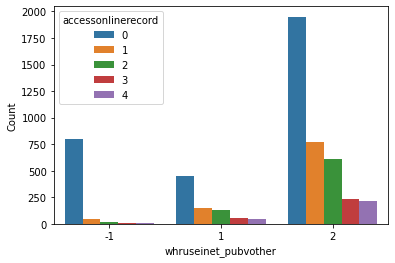

observed data:
 accessonlinerecord       0    1    2    3    4
whruseinet_pubvother                          
-1                     798   48   18    7    4
 1                     449  150  134   52   49
 2                    1949  767  611  237  217
expected data:
 [[ 509.38069217  153.80236794  121.60746812   47.17668488   43.03278689]
 [ 485.51256831  146.59562842  115.90928962   44.96612022   41.01639344]
 [2201.10673953  664.60200364  525.48324226  203.8571949   185.95081967]]
chi-squared value: 471.6531 for 8 dof; p-value = 0.0000



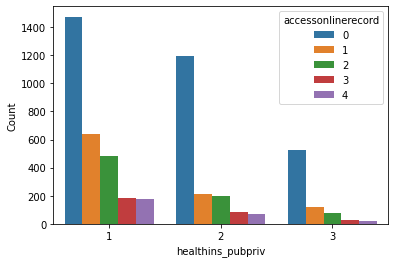

observed data:
 accessonlinerecord     0    1    2    3    4
healthins_pubpriv                           
1                   1473  636  486  186  180
2                   1197  211  200   85   68
3                    526  118   77   25   22
expected data:
 [[1723.7442623   520.46721311  411.51967213  159.64590164  145.62295082]
 [1025.16502732  309.53825137  244.74371585   94.94644809   86.60655738]
 [ 447.09071038  134.99453552  106.73661202   41.40765027   37.7704918 ]]
chi-squared value: 198.8940 for 8 dof; p-value = 0.0000



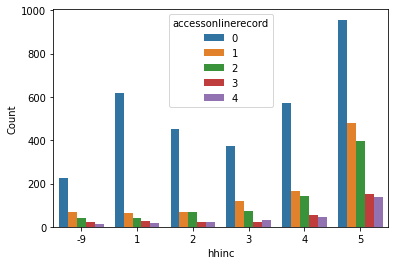

observed data:
 accessonlinerecord    0    1    2    3    4
hhinc                                      
-9                  225   67   41   22   14
 1                  618   63   42   25   19
 2                  451   67   69   23   21
 3                  373  120   72   22   32
 4                  572  167  144   54   46
 5                  957  481  395  150  138
expected data:
 [[ 214.81311475   64.86065574   51.28360656   19.89508197   18.14754098]
 [ 446.50856102  134.81876138  106.59763206   41.35373406   37.72131148]
 [ 367.33624772  110.91347905   87.69635701   34.02112933   31.03278689]
 [ 360.35045537  108.80418944   86.02859745   33.37413479   30.44262295]
 [ 572.25282332  172.7859745   136.61730419   52.9996357    48.3442623 ]
 [1234.73879781  372.81693989  294.77650273  114.35628415  104.31147541]]
chi-squared value: 368.5526 for 20 dof; p-value = 0.0000



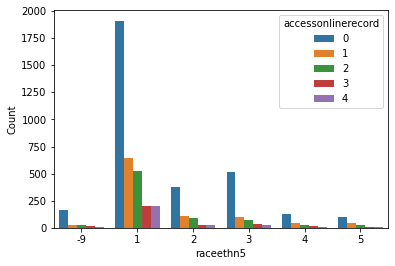

observed data:
 accessonlinerecord     0    1    2    3    4
raceethn5                                   
-9                   168   28   26   15    4
 1                  1912  643  521  203  200
 2                   378  109   87   24   26
 3                   514  100   72   32   24
 4                   125   43   30   13    8
 5                    99   42   27    9    8
expected data:
 [[ 140.29799636   42.36156648   33.49417122   12.99380692   11.85245902]
 [2025.29763206  611.51821494  483.51129326  187.57449909  171.09836066]
 [ 363.26120219  109.68306011   86.72349727   33.64371585   30.68852459]
 [ 431.95482696  130.42440801  103.12313297   40.00582878   36.49180328]
 [ 127.49071038   38.49453552   30.43661202   11.80765027   10.7704918 ]
 [ 107.69763206   32.51821494   25.71129326    9.97449909    9.09836066]]
chi-squared value: 81.7543 for 20 dof; p-value = 0.0000



In [412]:
# repeat the univariate analysis on the smaller training dataset
# the "ignore codes" don't matter here since they've been removed
for oc_var in outcome_vars:
    for cat_var in univar_cols:
        get_crosstabs(cat_var, oc_var, df_train, ignore_codes = [-99], plot_data = True)

In addition to the previously identified non-significant medical condition variables (high BP, heart condition, and lung disease), diabetes now also is non-significant with respect to `offeredaccesseither`.  

For `accessonlinerecord`, the only previously non-significant variable was BMI category. That relationship is now significant. Having lung disease is now non-signficant.  

Since lung disease has a non-significant relationship to both outcome variables, it can be dropped.

In [413]:
# drop lung disease since NS r/t both outcomes
df_train.drop(columns = ['medconditions_lungdisease'], inplace=True)
df_test.drop(columns = ['medconditions_lungdisease'], inplace=True)

<a id='mvpredsummary'></a>
##### Summary
Predictor variables were analyzed for their relationship to the two outcome variables, using the training datasete. Most variables had a significant univariate relationship to the outcome variables. Those that were non-significant with respect to both variables were removed.  
Some multi-categorical variables were consolidated into more meaningful or compact single-variable categories.  
Finally, missing data were removed, except for in the cases of variables were the omission might be a relevant category to include in the subsequent analysis.  
After these cleaning and analysis maneuvers, we are left with 41 predictor variables. The training dataset (using my randomization settings) contains 5490 entries and the test set contains 2328 entries.

<a id='nextsteps'></a>
## Next Steps
The next steps will be to create a machine learning models to predict access to and use of EMRs using the predictor variables selected in this preliminary analysis. That will be done in a separate notebook. This ends the exploratory analysis.

In [414]:
# save the updated training and test sets
df_train.to_csv('data/HINTS_train.csv.gz', compression='gzip')
df_test.to_csv('data/HINTS_test.csv.gz', compression='gzip')